# Scene Understanding using Deep Learning
## Introduction

This Notebook was written for demonstrating scene understanding for the Lockheed Martin drone challange. The code consists of three pipelines pre-processing, FCN and post processing  The project is a corner stone for  

\<img style="float: center;" src="readme_imgs/Img_groundtruth.png">

## Data Pre-processing 

We have implemented camera calibration routine to the video file.Each image was normalized and then smoothed with a Gaussian filter. The images were randomly processed with a brightness filter to help the network generalize to different lighting conditions. 

 


## FCN

 

 
 

##  Jaccard similarity coefficient 

In evaluating the model I've investigated several metrics including the Mean IU, Intersection over Union, and the Jaccard coefficient. The idea is to maximize the overlap between the predicted region and the ground truth bounding box.
 
We eventually decided to use the Jaccard coeef. The Jaccard similarity coefficient is defined as the size of the intersection divided by the size of the union of two regions. This metric is used to compare the predicted labels to a set of labels in y_true  

The coefficients are given by 

#### J(A,B) = |A∩B| / |A∪B|=|A∩B|/|A|+|B|-|A∩B| 

(If A and B are both empty, we define J(A,B) = 1.)

<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B.png">
<img style="float: center;" src="readme_imgs/Intersection_of_sets_A_and_B_2.png">
 

## Training

The Autti dataset was used and can be obtained from https://github.com/udacity/self-driving-car/tree/master/annotations .  

## Results
 

In [1]:
%matplotlib inline
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import glob
import time

from scipy.ndimage.measurements import label
import pandas as pd
#import keras.backend as K
from sklearn.metrics import jaccard_similarity_score
 
import time
import numpy
from PIL import Image, ImageDraw
import re
from shapely.geometry import Polygon
from pprint import pprint
import PIL.ImageDraw
from PIL import Image
import argparse
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
 
#add a note for the class

# Reading and processing the wkt json format 


In [2]:
#df is the dataset that we are annotating
#raw_df is the dataset that the organizers provided
#adding path for json anf image folders respectively
provided_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/training_GT_labels_v2.json'#json provided by the organizers of the challange
our_data_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/csv/data_wkt_v4.json'#our annotated dataset
img_file_dir='/media/a/D/lockheed-martin/dataset/LM_dataset/Data_Training/'#folder where images are stored
provided_df = pd.read_json(provided_data_file_dir)
df = pd.read_json(our_data_file_dir)

 
#adding a complete path for the image 
df['External ID']= [img_file_dir + u for u in df['External ID']]#iris_data_dir + new_df['parcel_id'].astype(str) + '.jpg'

df['images']=[u.split('/',8)[8] for u in df['External ID']]
raw_df=pd.DataFrame()
raw_df['images']=list(provided_df.columns.values)
raw_df['img_path']=[img_file_dir +  u for u in raw_df['images']]

raw_df['raw_inner_poly']=[ provided_df[u][0] for u in raw_df['images']]

raw_df.head()


,images,img_path,raw_inner_poly
0,IMG_5677.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[532, 354, 772, 357, 768, 594, 533, 592]"
1,IMG_7088 (1).JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[451, 226, 831, 247, 836, 623, 437, 622]"
2,IMG_0260.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[480, 373, 698, 374, 698, 599, 471, 594]"
3,IMG_4609.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[495, 309, 668, 285, 672, 554, 499, 533]"
4,IMG_2994.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[490, 190, 637, 345, 644, 686, 475, 679]"


In [3]:
#remove white spaces from image path
s=raw_df['images'][3]
print(re.sub(r"\s+", "", s))  # \s matches all white spaces

IMG_4609.JPG


#remove white space from image name in the folder containing the images

#go to img directory and run python fix.py. Here is the file

#remove white space from image name in the folder containing the images
import os
import re

""" 
Renames the filenames within the same directory to be Unix friendly
(1) Changes spaces to nothing
(2) Makes lowercase (not a Unix requirement, just looks better ;)
Usage:
python rename.py
"""
path =  os.getcwd()
 
filenames = os.listdir(path)

for filename in filenames:
    print('img name befor',filename)
    fixed_filename=re.sub(r"\s+", "", filename)
    print('img name after',fixed_filename)
    os.rename(filename, fixed_filename)

In [4]:
df.head()

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG


In [5]:
#merge the our annotations and provided annotations
df_all=pd.merge(df, raw_df, on='images')
df_all.head(10)

,Agreement,Created At,Created By,DataRow ID,Dataset Name,External ID,ID,Label,Labeled Data,Project Name,Reviews,Seconds to Label,View Label,images,img_path,raw_inner_poly
0,NaN,2019-02-06T08:35:37.000Z,alberto.galet@gmail.com,cjrsurb5r9p7w0anvd23j1pgg,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxucjqqkbd0b47j8vcjsua,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.832,https://image-segmentation-v4.labelbox.com?pro...,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[504, 191, 902, 177, 915, 580, 495, 584]"
1,NaN,2019-02-06T08:36:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p800anv2xkrhfkw,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxvb54qkw90b47dwa8uupg,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],44.299,https://image-segmentation-v4.labelbox.com?pro...,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[454, 212, 803, 221, 808, 552, 454, 566]"
2,NaN,2019-02-06T08:36:55.000Z,alberto.galet@gmail.com,cjrsurb5v9p840anv7ly4rt5s,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrsxw0feqs9n08984nfshogi,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],31.955,https://image-segmentation-v4.labelbox.com?pro...,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[590, 376, 791, 371, 794, 589, 577, 601]"
3,NaN,2019-02-07T02:17:15.000Z,alberto.galet@gmail.com,cjrsurb5v9p880anvyjs4m1oj,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzrm18i8ga08983qewu7rq,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.032,https://image-segmentation-v4.labelbox.com?pro...,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[836, 385, 641, 387, 635, 582, 841, 582]"
4,NaN,2019-02-07T02:18:01.000Z,alberto.galet@gmail.com,cjrsurb5v9p8c0anvcve1d63y,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzslxpi69j0b4753lkl3ju,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],46.003,https://image-segmentation-v4.labelbox.com?pro...,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[470, 221, 848, 231, 851, 613, 457, 609]"
5,NaN,2019-02-07T02:18:42.000Z,alberto.galet@gmail.com,cjrsurb5v9p8g0anv2ji1v57l,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzth7bi7210b47l0yydz0t,{'Outer Border': [{'geometry': 'POLYGON ((567 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],39.919,https://image-segmentation-v4.labelbox.com?pro...,IMG_0396.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[585, 338, 684, 354, 672, 523, 592, 532]"
6,NaN,2019-02-07T02:19:13.000Z,alberto.galet@gmail.com,cjrsurb5v9p8k0anv1auzm8e0,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzu5bziasw0898zn0xuaez,{'Outer Border': [{'geometry': 'POLYGON ((343 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],30.653,https://image-segmentation-v4.labelbox.com?pro...,IMG_0861.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[378, 468, 533, 480, 537, 646, 369, 646]"
7,NaN,2019-02-07T02:19:47.000Z,alberto.galet@gmail.com,cjrsurb5v9p8o0anv56veqecf,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,cjrtzuvrni8r10b47jq56iqvh,{'Outer Border': [{'geometry': 'POLYGON ((753 ...,https://storage.googleapis.com/labelbox-193903...,Test2 AlphaPilot,[],33.630,https://image-segmentation-v4.labelbox.com?pro...,IMG_1128.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,"[509, 319, 705, 255, 705, 632, 506, 616]"
8,NaN,2019-02-07T02:20:22.000Z,alberto.galet@gmail.com,cjrsurb5v9p8s0anvm6kjs3ge,Test2 AlphaPilot #2,/media/a/D/lockheed-martin/dataset/LM_dataset/..

In [6]:

keep_cols=['images', 'img_path','Label','raw_inner_poly']
df_all=df_all[keep_cols]
df_all['outer_poly']=''
df_all['inner_poly']=''
df_all['outer_x_min']=''
df_all['outer_y_min']=''
df_all['outer_x_max']=''
df_all['outer_y_max']=''
df_all['inner_x_min']=''
df_all['inner_y_min']=''
df_all['inner_x_max']=''
df_all['inner_y_max']=''
df_all['class_id']= ''
print(len(df_all))
df_all.head()

4943


,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]",,,,,,,,,,,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]",,,,,,,,,,,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]",,,,,,,,,,,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]",,,,,,,,,,,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]",,,,,,,,,,,


raw_inner_poly [632, 437, 718, 445, 720, 580, 632, 587]
poly [632, 437, 718, 445, 720, 580, 632, 587]
raw_inner_poly [571, 404, 698, 425, 686, 603, 565, 601]
poly [571, 404, 698, 425, 686, 603, 565, 601]


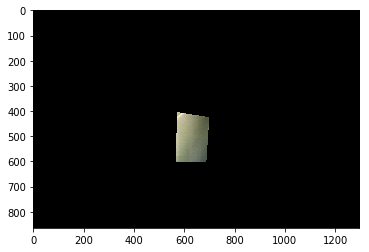

In [7]:
# checking the mask from the provided GT by the organizers



#processing the polygone and creating a mask
def get_mask_raw_data(img_shape, poly,display=False):
    output_mask = np.zeros(img_shape[:2], dtype=np.uint8)
    print('poly',poly)

    coords =  zip(*[iter(poly)] * 2) 
     
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    x = []
    y = []
    polygons = []

    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    proc_polygons=np.vstack((x,y)).T
    x,y,w,h = cv2.boundingRect(proc_polygons) 
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
for i in range(444,446):#len(df)):

    img=cv2.imread(df_all['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    #outer_poly=df['Label'][i] 
    inner_poly=df_all['raw_inner_poly'][i]
    if inner_poly:
        print('raw_inner_poly',inner_poly)
    #outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask_raw_data(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
    #outer_mask.dtype='uint8'
    #final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=inner_mask))
        plt.show
    else:
        print('polygon data corruption detected for index:', i)

test_id=1
test_poly=df['Label'][test_id]['Outer Border']#df['outer_poly'][1] 


In [10]:
#convert the polygons into a format that can be convereted to bounding boxes 
from tqdm import tqdm
#preprocessing our_dataset

def convert_coordinates(poly):
    proc_poly=poly[0]['geometry']
    nums =  re.findall(r'\d+(?:\.\d*)?', proc_poly.rpartition(',')[0])
    coords =  zip(*[iter(nums)] * 2)
    polygons = []
    for pt in coords:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    return polygons 
def convert_coordinates_raw(polygon):
    poly=[]
    polygon =  zip(*[iter(polygon)] * 2)
    for p in polygon:
        poly.append(p)
    return poly
def get_bbox(polygon):
    polygon=polygon[0]['geometry']
    polygon=(polygon)

    polygon =  re.findall(r'\d+(?:\.\d*)?', polygon)
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack((x,y)).T
   
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
def get_bbox_raw_data(polygon):
    polygon =  zip(*[iter(polygon)] * 2)
    x = []
    y = []
    for pt in polygon:
 
        init_x = (int(pt[0]))
        init_y = (int(pt[1]))

        x.append(init_x)
        y.append(init_y)
    polygons=np.vstack(((x,y))).T
    
    x,y,w,h = cv2.boundingRect(polygons)
    x_min=x
    y_min=y
    x_max=x+w
    y_max=y+h
    return x_min,y_min,x_max,y_max
    #return x_min,x_max,y_min,y_max
for i in tqdm(range(0,len(df_all))):
    #remove white spaces from image path
   
    df_all['img_path'][i]=re.sub(r"\s+", "", df_all['img_path'][i]) # \s matches all white spaces
    if df_all['raw_inner_poly'][i]:
        if df_all['Label'][i] != 'Skip':
            outer_poly=df_all['Label'][i]['Outer Border']
            #if len(outer_poly) !=1:
 
            inner_poly=df_all['raw_inner_poly'][i]#df['Label'][i]['inner flyable area']
            if inner_poly and outer_poly:
                df_all['outer_poly'][i] = convert_coordinates(outer_poly)
                df_all['inner_poly'][i] = convert_coordinates_raw(inner_poly)
                    #df['inner_poly'][i] = convert_coordinates(inner_poly)

                df_all['outer_x_min'][i],df_all['outer_y_min'][i], df_all['outer_x_max'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
                df_all['inner_x_min'][i],df_all['inner_y_min'][i], df_all['inner_x_max'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly)
                    #df_all['outer_x_min'][i],df_all['outer_x_max'][i], df_all['outer_y_min'][i],df_all['outer_y_max'][i]=get_bbox(outer_poly)
                    #df_all['inner_x_min'][i],df_all['inner_x_max'][i], df_all['inner_y_min'][i],df_all['inner_y_max'][i]=get_bbox_raw_data(inner_poly) 
        else:
            print('corrupt data detected for index:', i )
            continue
    #df['outer_poly']= h
   #df['inner_poly']= convert_coordinates(inner_poly)

100%|██████████| 4943/4943 [00:04<00:00, 1204.44it/s]

corrupt data detected for index: 4911


In [11]:
df_all.reset_index(drop=True, inplace=True)
df_all.head()

,images,img_path,Label,raw_inner_poly,outer_poly,inner_poly,outer_x_min,outer_y_min,outer_x_max,outer_y_max,inner_x_min,inner_y_min,inner_x_max,inner_y_max,class_id
0,IMG_0015.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((997 ...,"[504, 191, 902, 177, 915, 580, 495, 584]","[(997, 65), (1014, 683), (402, 673), (416, 106)]","[(504, 191), (902, 177), (915, 580), (495, 584)]",402,65,1015,684,495,177,916,585,
1,IMG_0158.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((894 ...,"[454, 212, 803, 221, 808, 552, 454, 566]","[(894, 638), (375, 646), (383, 136), (882, 141)]","[(454, 212), (803, 221), (808, 552), (454, 566)]",375,136,895,647,454,212,809,567,
2,IMG_0244.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((848 ...,"[590, 376, 791, 371, 794, 589, 577, 601]","[(848, 312), (851, 649), (533, 639), (538, 328)]","[(590, 376), (791, 371), (794, 589), (577, 601)]",533,312,852,650,577,371,795,602,
3,IMG_0367.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((597 ...,"[836, 385, 641, 387, 635, 582, 841, 582]","[(597, 623), (880, 627), (881, 344), (603, 346)]","[(836, 385), (641, 387), (635, 582), (841, 582)]",597,344,882,628,635,385,842,583,
4,IMG_0374.JPG,/media/a/D/lockheed-martin/dataset/LM_dataset/...,{'Outer Border': [{'geometry': 'POLYGON ((359 ...,"[470, 221, 848, 231, 851, 613, 457, 609]","[(359, 703), (950, 711), (943, 141), (384, 128)]","[(470, 221), (848, 231), (851, 613), (457, 609)]",359,128,951,712,457,221,852,614,


In [12]:
#keep only filed required by yolov3. Divide the dataframe into outer and inner bounding boxes and then assign a class to each one of them 
keep_cols_outer=['img_path', 'outer_x_min', 'outer_y_min', 'outer_x_max', 'outer_y_max','outer_poly','class_id']
keep_cols_inner=['img_path', 'inner_x_min', 'inner_y_min', 'inner_x_max', 'inner_y_max', 'inner_poly','class_id']
df_outer=df_all[keep_cols_outer]
df_inner=df_all[keep_cols_inner]
df_outer['class_id']=0
df_inner['class_id']=1
df_enet=pd.merge(df_outer, df_inner, on='img_path')
df_enet.head()

,img_path,outer_x_min,outer_y_min,outer_x_max,outer_y_max,outer_poly,class_id_x,inner_x_min,inner_y_min,inner_x_max,inner_y_max,inner_poly,class_id_y
0,/media/a/D/lockheed-martin/dataset/LM_dataset/...,402,65,1015,684,"[(997, 65), (1014, 683), (402, 673), (416, 106)]",0,495,177,916,585,"[(504, 191), (902, 177), (915, 580), (495, 584)]",1
1,/media/a/D/lockheed-martin/dataset/LM_dataset/...,375,136,895,647,"[(894, 638), (375, 646), (383, 136), (882, 141)]",0,454,212,809,567,"[(454, 212), (803, 221), (808, 552), (454, 566)]",1
2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,533,312,852,650,"[(848, 312), (851, 649), (533, 639), (538, 328)]",0,577,371,795,602,"[(590, 376), (791, 371), (794, 589), (577, 601)]",1
3,/media/a/D/lockheed-martin/dataset/LM_dataset/...,597,344,882,628,"[(597, 623), (880, 627), (881, 344), (603, 346)]",0,635,385,842,583,"[(836, 385), (641, 387), (635, 582), (841, 582)]",1
4,/media/a/D/lockheed-martin/dataset/LM_dataset/...,359,128,951,712,"[(359, 703), (950, 711), (943, 141), (384, 128)]",0,457,221,852,614,"[(470, 221), (848, 231), (851, 613), (457, 609)]",1


  0%|          | 2/4943 [00:00<04:23, 18.75it/s]

0
outer_poly [(997, 65), (1014, 683), (402, 673), (416, 106)]
1
outer_poly [(894, 638), (375, 646), (383, 136), (882, 141)]
2
outer_poly [(848, 312), (851, 649), (533, 639), (538, 328)]
3
outer_poly [(597, 623), (880, 627), (881, 344), (603, 346)]
4


  0%|          | 8/4943 [00:00<03:54, 21.04it/s]

outer_poly [(359, 703), (950, 711), (943, 141), (384, 128)]
5
outer_poly [(567, 585), (717, 563), (719, 319), (571, 294)]
6
outer_poly [(343, 425), (337, 697), (568, 683), (570, 441)]
7
outer_poly [(753, 175), (472, 263), (474, 665), (761, 732)]
8
outer_poly [(585, 391), (580, 647), (806, 643), (807, 406)]
9


  0%|          | 14/4943 [00:00<03:41, 22.23it/s]

outer_poly [(471, 383), (465, 679), (757, 676), (756, 392)]
10
outer_poly [(286, 107), (257, 753), (943, 736), (903, 113)]
11
outer_poly [(439, 469), (439, 710), (677, 706), (669, 449)]
12
outer_poly [(859, 590), (648, 592), (648, 376), (856, 375)]
13
outer_poly [(753, 71), (442, 211), (446, 653), (763, 728)]
14


  0%|          | 17/4943 [00:00<03:38, 22.57it/s]

outer_poly [(575, 223), (946, 231), (947, 601), (580, 613)]
15
outer_poly [(751, 165), (504, 254), (504, 630), (759, 681)]
16
outer_poly [(399, 115), (1037, 39), (1031, 781), (408, 714)]
17
outer_poly [(437, 298), (794, 224), (799, 756), (434, 709)]
18
outer_poly [(514, 423), (375, 438), (376, 626), (515, 634)]
19


  0%|          | 23/4943 [00:01<03:34, 22.92it/s]

outer_poly [(418, 317), (418, 731), (674, 806), (663, 199)]
20
outer_poly [(491, 379), (414, 406), (415, 620), (494, 635)]
21
outer_poly [(602, 235), (782, 300), (785, 612), (603, 646)]
22
outer_poly [(360, 88), (971, 136), (984, 740), (342, 762)]
23
outer_poly [(472, 338), (726, 338), (727, 594), (470, 594)]
24


  1%|          | 26/4943 [00:01<03:34, 22.96it/s]

outer_poly [(741, 316), (571, 342), (572, 565), (746, 573)]
25
outer_poly [(558, 301), (765, 365), (768, 677), (559, 700)]
26
outer_poly [(513, 255), (755, 339), (760, 693), (511, 724)]
27
outer_poly [(696, 287), (562, 369), (565, 682), (706, 705)]
28
outer_poly [(749, 160), (554, 304), (559, 704), (772, 752)]


  1%|          | 32/4943 [00:01<03:33, 23.02it/s]

29
outer_poly [(704, 378), (458, 366), (454, 627), (705, 625)]
30
outer_poly [(955, 655), (441, 655), (448, 176), (931, 137)]
31
outer_poly [(633, 366), (882, 372), (886, 624), (632, 624)]
32
outer_poly [(416, 292), (818, 252), (825, 714), (403, 698)]
33
outer_poly [(494, 256), (841, 214), (852, 602), (498, 602)]


  1%|          | 38/4943 [00:01<03:33, 22.99it/s]

34
outer_poly [(569, 399), (714, 352), (721, 664), (569, 654)]
35
outer_poly [(623, 373), (724, 316), (728, 637), (624, 626)]
36
outer_poly [(749, 242), (754, 711), (430, 679), (435, 309)]
37
outer_poly [(579, 427), (877, 396), (891, 733), (577, 732)]
38
outer_poly [(710, 426), (614, 483), (616, 731), (716, 738)]


  1%|          | 41/4943 [00:01<03:33, 22.98it/s]

39
outer_poly [(839, 814), (614, 776), (611, 309), (810, 69)]
40
outer_poly [(450, 141), (932, 15), (936, 726), (457, 644)]
41
outer_poly [(819, 22), (825, 709), (499, 612), (491, 153)]
42
outer_poly [(666, 248), (575, 287), (578, 524), (668, 553)]
43
outer_poly [(794, 254), (662, 303), (663, 584), (794, 628)]


  1%|          | 47/4943 [00:02<03:32, 23.06it/s]

44
outer_poly [(850, 244), (472, 154), (463, 781), (848, 697)]
45
outer_poly [(527, 441), (671, 403), (679, 657), (529, 659)]
46
outer_poly [(842, 589), (619, 596), (622, 341), (843, 355)]
47
outer_poly [(343, 724), (810, 651), (801, 111), (608, 0), (360, 0)]
48
outer_poly [(393, 284), (711, 325), (711, 659), (380, 665)]


  1%|          | 53/4943 [00:02<03:34, 22.75it/s]

49
outer_poly [(748, 115), (446, 219), (445, 661), (746, 767)]
50
outer_poly [(727, 345), (831, 326), (829, 538), (723, 521)]
51
outer_poly [(784, 120), (453, 232), (455, 684), (792, 769)]
52
outer_poly [(629, 718), (768, 682), (765, 350), (641, 270)]
53
outer_poly [(489, 388), (718, 401), (717, 642), (482, 646)]


  1%|          | 56/4943 [00:02<03:32, 23.03it/s]

54
outer_poly [(863, 103), (389, 173), (377, 652), (871, 674)]
55
outer_poly [(494, 263), (866, 234), (873, 639), (489, 632)]
56
outer_poly [(511, 337), (685, 376), (685, 623), (507, 633)]
57
outer_poly [(531, 273), (706, 379), (710, 728), (524, 751)]
58
outer_poly [(380, 406), (626, 427), (629, 686), (373, 691)]


  1%|▏         | 62/4943 [00:02<03:30, 23.23it/s]

59
outer_poly [(427, 298), (774, 330), (784, 683), (420, 689)]
60
outer_poly [(307, 148), (904, 127), (933, 756), (270, 753)]
61
outer_poly [(469, 402), (789, 372), (806, 721), (469, 727)]
62
outer_poly [(418, 272), (838, 258), (849, 689), (423, 693)]
63
outer_poly [(568, 225), (745, 272), (748, 587), (569, 635)]


  1%|▏         | 68/4943 [00:02<03:28, 23.33it/s]

64
outer_poly [(478, 99), (1077, 115), (1074, 705), (484, 726)]
65
outer_poly [(598, 270), (874, 268), (875, 546), (599, 544)]
66
outer_poly [(533, 383), (789, 392), (791, 650), (530, 656)]
67
outer_poly [(390, 284), (837, 273), (843, 743), (380, 736)]
68
outer_poly [(468, 333), (715, 338), (716, 584), (467, 586)]


  1%|▏         | 71/4943 [00:03<03:30, 23.19it/s]

69
outer_poly [(516, 289), (802, 268), (806, 587), (516, 580)]
70
outer_poly [(390, 264), (624, 206), (628, 611), (391, 586)]
71
outer_poly [(539, 409), (779, 427), (783, 684), (535, 689)]
72
outer_poly [(367, 383), (615, 403), (615, 659), (361, 663)]
73
outer_poly [(469, 400), (603, 362), (611, 613), (473, 615)]


  2%|▏         | 77/4943 [00:03<03:30, 23.14it/s]

74
outer_poly [(461, 440), (703, 450), (704, 693), (455, 695)]
75
outer_poly [(298, 149), (819, 68), (835, 702), (297, 672)]
76
outer_poly [(537, 301), (734, 332), (734, 560), (532, 559)]
77
outer_poly [(477, 230), (768, 268), (769, 566), (471, 568)]
78
outer_poly [(499, 302), (850, 258), (872, 652), (500, 658)]


  2%|▏         | 83/4943 [00:03<03:29, 23.22it/s]

79
outer_poly [(533, 335), (745, 315), (745, 566), (529, 562)]
80
outer_poly [(661, 340), (808, 358), (806, 567), (658, 580)]
81
outer_poly [(397, 259), (658, 94), (679, 676), (396, 669)]
82
outer_poly [(444, 268), (686, 317), (686, 624), (439, 653)]
83
outer_poly [(589, 323), (815, 337), (811, 571), (586, 575)]


  2%|▏         | 86/4943 [00:03<03:29, 23.23it/s]

84
outer_poly [(544, 160), (537, 768), (939, 698), (939, 233)]
85
outer_poly [(537, 272), (903, 291), (909, 659), (535, 669)]
86
outer_poly [(403, 160), (385, 742), (908, 715), (905, 214), (515, 160), (403, 147)]
87
outer_poly [(201, 185), (688, 150), (679, 723), (198, 677)]
88
outer_poly [(411, 255), (732, 269), (735, 585), (408, 589)]


  2%|▏         | 92/4943 [00:03<03:28, 23.28it/s]

89
outer_poly [(234, 13), (831, 147), (858, 726), (171, 739)]
90
outer_poly [(579, 272), (890, 274), (899, 586), (589, 598)]
91
outer_poly [(351, 64), (977, 56), (1003, 693), (337, 700)]
92
outer_poly [(459, 377), (562, 357), (564, 569), (458, 556)]
93
outer_poly [(567, 292), (797, 333), (801, 634), (565, 657)]


  2%|▏         | 98/4943 [00:04<03:32, 22.76it/s]

94
outer_poly [(589, 294), (709, 179), (713, 706), (592, 655)]
95
outer_poly [(592, 411), (700, 393), (705, 577), (594, 574)]
96
outer_poly [(530, 357), (698, 319), (700, 607), (529, 597)]
97
outer_poly [(477, 230), (804, 279), (807, 626), (470, 640)]
98
outer_poly [(508, 213), (797, 295), (802, 656), (499, 680)]


  2%|▏         | 101/4943 [00:04<03:31, 22.94it/s]

99
outer_poly [(450, 295), (778, 345), (786, 692), (442, 704)]
100
outer_poly [(466, 404), (706, 419), (710, 670), (463, 674)]
101
outer_poly [(461, 473), (695, 457), (702, 713), (459, 717)]
102
outer_poly [(530, 355), (743, 282), (758, 665), (532, 661)]
103
outer_poly [(550, 343), (697, 346), (696, 493), (549, 494)]


  2%|▏         | 107/4943 [00:04<03:28, 23.14it/s]

104
outer_poly [(660, 335), (843, 333), (843, 518), (660, 517)]
105
outer_poly [(550, 336), (860, 337), (864, 649), (550, 654)]
106
outer_poly [(211, 306), (496, 322), (496, 597), (210, 609)]
107
outer_poly [(466, 213), (974, 174), (981, 724), (465, 702)]
108
outer_poly [(417, 227), (723, 256), (722, 578), (420, 607)]


  2%|▏         | 113/4943 [00:04<03:29, 23.01it/s]

109
outer_poly [(566, 260), (807, 267), (804, 509), (565, 513)]
110
outer_poly [(628, 268), (894, 268), (893, 534), (629, 534)]
111
outer_poly [(481, 262), (777, 256), (777, 557), (482, 553)]
112
outer_poly [(420, 304), (593, 281), (597, 545), (423, 531)]
113
outer_poly [(566, 278), (637, 230), (644, 601), (569, 558)]


  2%|▏         | 116/4943 [00:05<03:29, 23.05it/s]

114
outer_poly [(432, 283), (857, 249), (862, 730), (428, 706)]
115
outer_poly [(448, 289), (446, 709), (821, 763), (810, 209)]
116
outer_poly [(417, 251), (835, 152), (853, 771), (421, 713)]
117
outer_poly [(377, 326), (676, 274), (686, 720), (379, 690)]
118
outer_poly [(413, 363), (538, 339), (543, 577), (414, 566)]


  2%|▏         | 122/4943 [00:05<03:30, 22.93it/s]

119
outer_poly [(439, 365), (545, 346), (548, 564), (440, 555)]
120
outer_poly [(539, 241), (691, 312), (690, 623), (535, 654)]
121
outer_poly [(574, 302), (846, 277), (851, 592), (575, 584)]
122
outer_poly [(543, 267), (648, 187), (652, 616), (543, 581)]
123
outer_poly [(461, 329), (814, 367), (825, 738), (454, 755)]


  3%|▎         | 128/4943 [00:05<03:29, 23.03it/s]

124
outer_poly [(378, 160), (903, 244), (928, 783), (362, 823)]
125
outer_poly [(326, 254), (732, 215), (738, 681), (318, 670)]
126
outer_poly [(465, 307), (782, 343), (787, 673), (457, 680)]
127
outer_poly [(313, 17), (1038, 69), (1108, 803), (251, 817)]
128
outer_poly [(434, 303), (817, 301), (828, 698), (421, 693)]


  3%|▎         | 131/4943 [00:05<03:28, 23.09it/s]

129
outer_poly [(574, 307), (751, 327), (750, 532), (572, 536)]
130
outer_poly [(492, 82), (896, 196), (897, 652), (480, 699)]
131
outer_poly [(437, 317), (745, 287), (745, 650), (435, 636)]
132
outer_poly [(478, 380), (723, 356), (724, 644), (476, 637)]
133
outer_poly [(530, 303), (795, 399), (804, 766), (517, 778)]


  3%|▎         | 137/4943 [00:05<03:28, 23.07it/s]

134
outer_poly [(479, 335), (740, 302), (740, 643), (476, 627)]
135
outer_poly [(343, 179), (910, 152), (932, 771), (300, 750)]
136
outer_poly [(773, 453), (777, 707), (667, 702), (664, 493)]
137
outer_poly [(526, 140), (758, 310), (762, 722), (506, 729)]
138
outer_poly [(552, 213), (1015, 229), (1010, 689), (550, 699)]


  3%|▎         | 143/4943 [00:06<03:34, 22.42it/s]

139
outer_poly [(735, 346), (893, 359), (890, 561), (732, 571)]
140
outer_poly [(440, 385), (628, 328), (631, 660), (439, 657)]
141
outer_poly [(527, 343), (683, 364), (683, 578), (523, 590)]
142
outer_poly [(808, 43), (581, 295), (591, 760), (862, 776)]
143


  3%|▎         | 146/4943 [00:06<03:35, 22.25it/s]

outer_poly [(529, 301), (752, 59), (796, 773), (536, 760)]
144
outer_poly [(567, 291), (885, 309), (882, 627), (562, 633)]
145
outer_poly [(429, 337), (694, 369), (696, 652), (424, 663)]
146
outer_poly [(105, 111), (740, 114), (732, 741), (109, 740)]
147
outer_poly [(215, 103), (862, 130), (853, 743), (217, 767)]


  3%|▎         | 152/4943 [00:06<03:34, 22.34it/s]

148
outer_poly [(400, 186), (938, 200), (962, 747), (368, 741)]
149
outer_poly [(336, 182), (846, 170), (869, 697), (311, 696)]
150
outer_poly [(643, 248), (945, 246), (953, 551), (644, 552)]
151
outer_poly [(270, 0), (241, 720), (1050, 720), (1046, 6)]
152
outer_poly [(400, 194), (818, 247), (815, 671), (399, 706)]


  3%|▎         | 155/4943 [00:06<03:33, 22.46it/s]

153
outer_poly [(260, 105), (865, 162), (856, 731), (256, 773)]
154
outer_poly [(508, 282), (808, 263), (805, 607), (505, 590)]
155
outer_poly [(503, 282), (796, 263), (790, 601), (502, 578)]
156
outer_poly [(535, 332), (731, 278), (735, 625), (536, 611)]
157
outer_poly [(456, 259), (733, 363), (740, 741), (441, 763)]


  3%|▎         | 161/4943 [00:07<03:27, 23.07it/s]

158
outer_poly [(500, 443), (613, 422), (618, 607), (503, 606)]
159
outer_poly [(421, 326), (735, 356), (742, 678), (413, 683)]
160
outer_poly [(626, 509), (694, 470), (701, 716), (631, 712)]
161
outer_poly [(445, 596), (830, 614), (837, 203), (434, 207)]
162
outer_poly [(351, 235), (831, 248), (841, 725), (348, 736)]


  3%|▎         | 167/4943 [00:07<03:22, 23.63it/s]

163
outer_poly [(185, 207), (611, 279), (613, 697), (177, 752)]
164
outer_poly [(387, 259), (724, 276), (728, 609), (387, 626)]
165
outer_poly [(605, 357), (668, 320), (672, 601), (608, 582)]
166
outer_poly [(591, 362), (660, 329), (664, 598), (593, 581)]
167
outer_poly [(420, 104), (955, 161), (967, 700), (421, 745)]


  3%|▎         | 170/4943 [00:07<03:22, 23.55it/s]

168
outer_poly [(532, 79), (919, 172), (916, 640), (533, 731)]
169
outer_poly [(570, 264), (818, 280), (818, 548), (571, 563)]
170
outer_poly [(537, 243), (745, 181), (751, 640), (542, 585)]
171
outer_poly [(547, 180), (710, 282), (711, 653), (545, 719)]
172
outer_poly [(511, 335), (859, 344), (864, 697), (508, 704)]


  4%|▎         | 176/4943 [00:07<03:20, 23.76it/s]

173
outer_poly [(537, 211), (737, 292), (736, 628), (533, 666)]
174
outer_poly [(401, 271), (729, 263), (732, 599), (401, 598)]
175
outer_poly [(403, 254), (759, 245), (762, 612), (399, 611)]
176
outer_poly [(500, 182), (894, 57), (905, 703), (498, 643)]
177
outer_poly [(437, 244), (648, 167), (651, 624), (438, 592)]


  4%|▎         | 182/4943 [00:07<03:23, 23.43it/s]

178
outer_poly [(384, 167), (874, 220), (890, 708), (377, 739)]
179
outer_poly [(314, 61), (1005, 66), (1037, 765), (293, 777)]
180
outer_poly [(374, 106), (1009, 104), (1037, 752), (357, 758)]
181
outer_poly [(433, 387), (677, 412), (678, 666), (427, 669)]
182
outer_poly [(327, 81), (885, 161), (900, 716), (294, 730)]


  4%|▎         | 185/4943 [00:08<03:25, 23.21it/s]

183
outer_poly [(539, 63), (807, 251), (820, 711), (537, 770)]
184
outer_poly [(462, 340), (794, 310), (802, 683), (458, 677)]
185
outer_poly [(310, 298), (731, 261), (736, 737), (302, 724)]
186
outer_poly [(420, 345), (719, 319), (724, 673), (415, 659)]
187
outer_poly [(386, 198), (879, 87), (894, 772), (378, 718)]


  4%|▍         | 191/4943 [00:08<03:26, 23.02it/s]

188
outer_poly [(326, 179), (891, 18), (915, 841), (317, 767)]
189
outer_poly [(430, 370), (558, 299), (564, 706), (431, 675)]
190
outer_poly [(569, 448), (844, 441), (852, 727), (563, 727)]
191
outer_poly [(537, 272), (863, 111), (894, 730), (535, 709)]
192
outer_poly [(191, 326), (479, 334), (453, 656), (164, 624)]


  4%|▍         | 197/4943 [00:08<03:25, 23.05it/s]

193
outer_poly [(552, 261), (768, 224), (770, 554), (552, 533)]
194
outer_poly [(656, 324), (748, 295), (747, 575), (658, 545)]
195
outer_poly [(481, 380), (711, 410), (714, 665), (473, 664)]
196
outer_poly [(488, 279), (822, 267), (822, 625), (489, 613)]
197
outer_poly [(783, 308), (1035, 315), (1031, 573), (779, 572)]


  4%|▍         | 200/4943 [00:08<03:24, 23.14it/s]

198
outer_poly [(574, 439), (727, 402), (733, 658), (577, 659)]
199
outer_poly [(524, 301), (733, 370), (737, 665), (515, 667)]
200
outer_poly [(644, 363), (561, 417), (573, 642), (665, 640)]
201
outer_poly [(627, 86), (499, 284), (525, 685), (680, 688)]
202
outer_poly [(405, 0), (391, 864), (655, 864), (1128, 803), (1122, 86), (734, 0)]


  4%|▍         | 206/4943 [00:08<03:20, 23.58it/s]

203
outer_poly [(518, 121), (965, 68), (958, 577), (513, 552)]
204
outer_poly [(466, 684), (677, 862), (678, 91), (554, 91), (461, 175)]
205
outer_poly [(574, 312), (823, 323), (820, 581), (576, 586)]
206
outer_poly [(423, 175), (916, 221), (910, 704), (415, 738)]
207
outer_poly [(450, 303), (746, 202), (766, 667), (451, 666)]


  4%|▍         | 212/4943 [00:09<03:23, 23.29it/s]

208
outer_poly [(682, 51), (407, 230), (402, 665), (703, 676)]
209
outer_poly [(522, 430), (649, 387), (654, 652), (524, 651)]
210
outer_poly [(680, 405), (745, 360), (756, 613), (685, 613)]
211
outer_poly [(273, 114), (821, 170), (829, 703), (257, 730)]
212
outer_poly [(289, 167), (942, 174), (943, 830), (277, 829)]


  4%|▍         | 215/4943 [00:09<03:24, 23.07it/s]

213
outer_poly [(356, 55), (1081, 61), (1097, 812), (330, 791)]
214
outer_poly [(738, 315), (1001, 310), (1007, 576), (741, 576)]
215
outer_poly [(757, 377), (928, 367), (934, 542), (762, 544)]
216
outer_poly [(727, 376), (561, 380), (564, 546), (729, 542)]
217
outer_poly [(291, 5), (293, 750), (1020, 744), (1037, 27), (591, 8)]


  4%|▍         | 221/4943 [00:09<03:24, 23.14it/s]

218
outer_poly [(524, 244), (777, 243), (775, 497), (526, 495)]
219
outer_poly [(498, 454), (637, 436), (639, 654), (499, 643)]
220
outer_poly [(507, 225), (883, 281), (888, 682), (503, 713)]
221
outer_poly [(558, 411), (700, 380), (702, 649), (558, 636)]
222
outer_poly [(509, 312), (736, 249), (743, 637), (508, 619)]


  5%|▍         | 227/4943 [00:09<03:20, 23.50it/s]

223
outer_poly [(521, 356), (706, 313), (713, 618), (522, 607)]
224
outer_poly [(536, 12), (701, 209), (706, 650), (534, 706)]
225
outer_poly [(497, 338), (642, 423), (643, 727), (488, 743)]
226
outer_poly [(473, 280), (848, 342), (863, 744), (463, 763)]
227
outer_poly [(415, 231), (754, 49), (780, 740), (410, 706)]


  5%|▍         | 230/4943 [00:09<03:21, 23.41it/s]

228
outer_poly [(525, 446), (669, 416), (670, 662), (522, 657)]
229
outer_poly [(549, 381), (721, 382), (720, 550), (549, 551)]
230
outer_poly [(668, 333), (850, 328), (854, 513), (671, 515)]
231
outer_poly [(364, 288), (747, 268), (759, 668), (369, 671)]
232
outer_poly [(261, 405), (466, 408), (464, 603), (260, 605)]


  5%|▍         | 236/4943 [00:10<03:19, 23.63it/s]

233
outer_poly [(273, 109), (852, 115), (861, 687), (273, 703)]
234
outer_poly [(509, 223), (672, 58), (681, 774), (512, 669)]
235
outer_poly [(404, 192), (750, 191), (751, 532), (408, 538)]
236
outer_poly [(470, 214), (684, 253), (685, 544), (474, 581)]
237
outer_poly [(519, 202), (826, 83), (836, 753), (527, 648)]


  5%|▍         | 242/4943 [00:10<03:21, 23.38it/s]

238
outer_poly [(450, 325), (882, 351), (892, 784), (446, 798)]
239
outer_poly [(435, 319), (790, 295), (796, 697), (432, 683)]
240
outer_poly [(423, 298), (773, 231), (779, 745), (421, 698)]
241
outer_poly [(553, 310), (554, 579), (813, 587), (808, 291)]
242
outer_poly [(1003, 55), (1013, 705), (605, 642), (605, 186)]


  5%|▍         | 245/4943 [00:10<03:19, 23.51it/s]

243
outer_poly [(358, 91), (970, 99), (978, 715), (347, 713)]
244
outer_poly [(547, 162), (774, 259), (774, 634), (540, 676)]
245
outer_poly [(480, 279), (849, 290), (853, 658), (476, 659)]
246
outer_poly [(446, 356), (678, 309), (686, 667), (446, 653)]
247
outer_poly [(427, 54), (968, 156), (1001, 704), (411, 731)]


  5%|▌         | 251/4943 [00:10<03:16, 23.88it/s]

248
outer_poly [(492, 380), (742, 391), (744, 646), (487, 646)]
249
outer_poly [(392, 210), (860, 240), (869, 709), (367, 712)]
250
outer_poly [(581, 262), (753, 240), (757, 456), (587, 456)]
251
outer_poly [(340, 145), (938, 158), (963, 770), (309, 769)]
252
outer_poly [(530, 303), (799, 268), (804, 593), (530, 587)]


  5%|▌         | 257/4943 [00:11<03:17, 23.76it/s]

253
outer_poly [(397, 207), (864, 49), (904, 755), (394, 722)]
254
outer_poly [(487, 234), (797, 56), (816, 742), (483, 692)]
255
outer_poly [(431, 32), (906, 180), (910, 704), (411, 768)]
256
outer_poly [(552, 305), (737, 325), (733, 529), (547, 533)]
257
outer_poly [(474, 59), (723, 300), (728, 784), (441, 817)]


  5%|▌         | 260/4943 [00:11<03:18, 23.55it/s]

258
outer_poly [(455, 203), (913, 87), (926, 746), (450, 687)]
259
outer_poly [(434, 104), (1024, 157), (1060, 751), (406, 759)]
260
outer_poly [(596, 435), (781, 394), (789, 690), (593, 686)]
261
outer_poly [(631, 396), (819, 315), (831, 711), (632, 699)]
262
outer_poly [(625, 395), (739, 270), (753, 759), (630, 741)]


  5%|▌         | 266/4943 [00:11<03:20, 23.32it/s]

263
outer_poly [(400, 158), (920, 205), (916, 714), (394, 748)]
264
outer_poly [(500, 445), (645, 420), (652, 642), (496, 641)]
265
outer_poly [(539, 402), (683, 348), (688, 652), (540, 649)]
266
outer_poly [(609, 455), (723, 372), (738, 747), (614, 743)]
267
outer_poly [(508, 280), (659, 66), (683, 723), (511, 708)]


  6%|▌         | 272/4943 [00:11<03:20, 23.33it/s]

268
outer_poly [(388, 146), (965, 149), (958, 725), (385, 719)]
269
outer_poly [(216, 202), (677, 208), (675, 662), (216, 664)]
270
outer_poly [(348, 209), (854, 198), (855, 719), (341, 707)]
271
outer_poly [(368, 145), (1002, 155), (1016, 815), (314, 795)]
272
outer_poly [(472, 442), (744, 441), (752, 719), (467, 722)]


  6%|▌         | 275/4943 [00:11<03:21, 23.21it/s]

273
outer_poly [(322, 99), (915, 76), (987, 683), (299, 704)]
274
outer_poly [(353, 1), (335, 704), (1117, 714), (1106, 2)]
275
outer_poly [(485, 333), (843, 310), (847, 705), (476, 690)]
276
outer_poly [(401, 127), (779, 228), (773, 676), (391, 763)]
277
outer_poly [(421, 203), (838, 245), (833, 655), (416, 683)]


  6%|▌         | 281/4943 [00:12<03:19, 23.34it/s]

278
outer_poly [(411, 353), (553, 320), (553, 619), (412, 595)]
279
outer_poly [(507, 412), (742, 396), (748, 662), (508, 658)]
280
outer_poly [(640, 418), (792, 395), (797, 629), (642, 620)]
281
outer_poly [(597, 418), (664, 395), (667, 597), (598, 588)]
282
outer_poly [(289, 66), (866, 112), (873, 676), (267, 684)]


  6%|▌         | 287/4943 [00:12<03:22, 23.01it/s]

283
outer_poly [(623, 417), (687, 380), (689, 622), (624, 617)]
284
outer_poly [(559, 334), (710, 334), (709, 485), (558, 484)]
285
outer_poly [(547, 367), (736, 369), (737, 558), (549, 559)]
286
outer_poly [(433, 200), (815, 78), (829, 735), (436, 665)]
287
outer_poly [(257, 78), (822, 154), (831, 703), (256, 760)]


  6%|▌         | 290/4943 [00:12<03:22, 22.98it/s]

288
outer_poly [(572, 121), (928, 240), (930, 728), (569, 843)]
289
outer_poly [(507, 91), (1020, 148), (1017, 672), (515, 732)]
290
outer_poly [(447, 191), (840, 220), (840, 614), (451, 641)]
291
outer_poly [(511, 281), (762, 277), (763, 534), (514, 531)]
292
outer_poly [(459, 307), (632, 283), (636, 550), (460, 534)]


  6%|▌         | 296/4943 [00:12<03:21, 23.11it/s]

293
outer_poly [(565, 353), (833, 355), (833, 623), (563, 622)]
294
outer_poly [(498, 262), (841, 230), (845, 625), (498, 609)]
295
outer_poly [(479, 347), (594, 324), (596, 553), (478, 543)]
296
outer_poly [(503, 409), (754, 411), (759, 663), (500, 663)]
297
outer_poly [(402, 350), (695, 344), (700, 646), (400, 646)]


  6%|▌         | 302/4943 [00:13<03:20, 23.12it/s]

298
outer_poly [(553, 403), (715, 366), (719, 650), (555, 641)]
299
outer_poly [(425, 46), (993, 162), (1049, 746), (394, 768)]
300
outer_poly [(416, 258), (849, 63), (903, 759), (410, 759)]
301
outer_poly [(397, 94), (770, 247), (776, 701), (375, 739)]
302
outer_poly [(465, 386), (675, 408), (673, 630), (457, 631)]


  6%|▌         | 305/4943 [00:13<03:21, 23.05it/s]

303
outer_poly [(621, 390), (877, 391), (885, 653), (622, 654)]
304
outer_poly [(550, 271), (785, 305), (788, 578), (550, 588)]
305
outer_poly [(564, 289), (778, 318), (781, 571), (566, 580)]
306
outer_poly [(459, 211), (821, 234), (828, 598), (457, 609)]
307
outer_poly [(414, 233), (863, 112), (896, 729), (416, 710)]


  6%|▋         | 311/4943 [00:13<03:21, 23.01it/s]

308
outer_poly [(526, 453), (632, 432), (633, 649), (525, 643)]
309
outer_poly [(587, 222), (783, 274), (778, 559), (581, 577)]
310
outer_poly [(572, 278), (718, 49), (740, 802), (577, 737)]
311
outer_poly [(479, 360), (717, 345), (715, 619), (475, 608)]
312
outer_poly [(558, 413), (721, 475), (723, 755), (551, 757)]


  6%|▋         | 317/4943 [00:13<03:19, 23.24it/s]

313
outer_poly [(523, 316), (677, 301), (677, 510), (521, 502)]
314
outer_poly [(441, 65), (1064, 147), (1105, 770), (405, 775)]
315
outer_poly [(521, 365), (897, 315), (920, 754), (511, 748)]
316
outer_poly [(552, 441), (825, 419), (833, 728), (547, 724)]
317
outer_poly [(453, 241), (853, 91), (874, 737), (438, 713)]


  6%|▋         | 320/4943 [00:13<03:19, 23.13it/s]

318
outer_poly [(226, 246), (681, 245), (677, 718), (209, 709)]
319
outer_poly [(553, 330), (815, 187), (841, 740), (554, 726)]
320
outer_poly [(522, 188), (976, 125), (976, 671), (526, 625)]
321
outer_poly [(527, 227), (841, 186), (841, 585), (532, 558)]
322
outer_poly [(605, 470), (702, 405), (709, 728), (607, 720)]


  7%|▋         | 326/4943 [00:14<03:20, 23.03it/s]

323
outer_poly [(514, 302), (862, 255), (880, 652), (512, 655)]
324
outer_poly [(589, 530), (667, 481), (677, 747), (593, 746)]
325
outer_poly [(590, 276), (708, 150), (721, 613), (599, 607)]
326
outer_poly [(383, 17), (1071, 73), (1095, 756), (366, 783)]
327
outer_poly [(190, 113), (692, 226), (691, 721), (150, 758)]


  7%|▋         | 332/4943 [00:14<03:26, 22.38it/s]

328
outer_poly [(428, 2), (623, 112), (596, 739), (5, 847), (4, 3)]
329
outer_poly [(363, 213), (833, 239), (835, 699), (355, 709)]
330
outer_poly [(426, 194), (956, 206), (960, 745), (404, 737)]
331
outer_poly [(611, 447), (873, 453), (870, 717), (602, 708)]
332
outer_poly [(346, 40), (1023, 63), (1000, 716), (349, 719)]


  7%|▋         | 335/4943 [00:14<03:24, 22.55it/s]

333
outer_poly [(418, 289), (742, 321), (738, 648), (409, 655)]
334
outer_poly [(557, 374), (791, 361), (795, 622), (559, 614)]
335
outer_poly [(361, 279), (820, 253), (827, 756), (349, 742)]
336
outer_poly [(527, 379), (751, 329), (757, 681), (526, 663)]
337
outer_poly [(530, 452), (641, 432), (646, 614), (534, 614)]


  7%|▋         | 341/4943 [00:14<03:21, 22.89it/s]

338
outer_poly [(393, 222), (827, 279), (852, 721), (381, 737)]
339
outer_poly [(398, 221), (934, 158), (970, 751), (383, 755)]
340
outer_poly [(511, 314), (802, 219), (827, 677), (518, 671)]
341
outer_poly [(514, 393), (598, 348), (603, 614), (515, 610)]
342
outer_poly [(422, 231), (765, 85), (797, 656), (427, 657)]


  7%|▋         | 347/4943 [00:15<03:19, 23.06it/s]

343
outer_poly [(439, 250), (766, 105), (805, 662), (445, 662)]
344
outer_poly [(425, 230), (705, 51), (739, 663), (428, 661)]
345
outer_poly [(589, 437), (661, 371), (683, 664), (608, 663)]
346
outer_poly [(458, 295), (772, 289), (769, 607), (464, 599)]
347
outer_poly [(614, 460), (745, 458), (750, 601), (617, 607)]


  7%|▋         | 350/4943 [00:15<03:19, 23.02it/s]

348
outer_poly [(406, 337), (558, 336), (558, 488), (408, 488)]
349
outer_poly [(567, 336), (718, 337), (716, 488), (567, 486)]
350
outer_poly [(291, 106), (896, 146), (906, 730), (288, 762)]
351
outer_poly [(401, 226), (827, 243), (829, 658), (399, 668)]
352
outer_poly [(515, 293), (862, 256), (867, 665), (512, 651)]


  7%|▋         | 356/4943 [00:15<03:19, 22.96it/s]

353
outer_poly [(566, 323), (782, 362), (784, 670), (564, 708)]
354
outer_poly [(442, 163), (846, 210), (851, 631), (450, 684)]
355
outer_poly [(559, 269), (762, 280), (758, 495), (560, 503)]
356
outer_poly [(561, 265), (764, 279), (762, 492), (561, 498)]
357
outer_poly [(523, 242), (866, 241), (866, 583), (526, 583)]


  7%|▋         | 362/4943 [00:15<03:19, 22.99it/s]

358
outer_poly [(439, 197), (1053, 241), (1080, 857), (430, 863)]
359
outer_poly [(516, 351), (806, 345), (804, 640), (517, 639)]
360
outer_poly [(597, 329), (774, 303), (773, 356), (778, 686), (599, 672)]
361
outer_poly [(472, 271), (675, 320), (677, 608), (468, 624)]
362
outer_poly [(478, 275), (856, 285), (860, 661), (476, 664)]


  7%|▋         | 365/4943 [00:15<03:19, 22.94it/s]

363
outer_poly [(562, 329), (849, 364), (856, 675), (561, 685)]
364
outer_poly [(576, 391), (816, 412), (820, 675), (574, 681)]
365
outer_poly [(432, 404), (746, 403), (752, 724), (426, 723)]
366
outer_poly [(746, 451), (826, 419), (835, 657), (752, 647)]
367
outer_poly [(438, 14), (705, 248), (704, 725), (406, 787)]


  8%|▊         | 371/4943 [00:16<03:23, 22.45it/s]

368
outer_poly [(417, 63), (663, 268), (662, 719), (394, 771)]
369
outer_poly [(515, 282), (832, 246), (841, 605), (513, 602)]
370
outer_poly [(561, 277), (818, 247), (822, 543), (562, 542)]
371
outer_poly [(556, 262), (728, 175), (734, 589), (555, 575)]
372
outer_poly [(413, 59), (926, 170), (954, 703), (406, 751)]


  8%|▊         | 377/4943 [00:16<03:22, 22.49it/s]

373
outer_poly [(542, 261), (826, 106), (844, 731), (539, 689)]
374
outer_poly [(605, 316), (747, 207), (756, 677), (606, 652)]
375
outer_poly [(588, 264), (737, 15), (764, 790), (593, 720)]
376
outer_poly [(558, 394), (732, 466), (736, 759), (552, 767)]
377
outer_poly [(565, 420), (759, 476), (764, 748), (558, 755)]


  8%|▊         | 380/4943 [00:16<03:21, 22.62it/s]

378
outer_poly [(477, 255), (902, 85), (944, 827), (486, 757)]
379
outer_poly [(427, 368), (629, 343), (626, 638), (422, 620)]
380
outer_poly [(605, 314), (850, 327), (847, 582), (602, 589)]
381
outer_poly [(363, 282), (763, 287), (777, 688), (352, 692)]
382
outer_poly [(383, 100), (821, 215), (820, 703), (371, 778)]


  8%|▊         | 386/4943 [00:16<03:18, 22.93it/s]

383
outer_poly [(581, 350), (756, 388), (758, 650), (580, 672)]
384
outer_poly [(566, 308), (790, 360), (795, 676), (568, 710)]
385
outer_poly [(546, 279), (787, 342), (793, 681), (544, 719)]
386
outer_poly [(393, 202), (835, 247), (844, 687), (395, 718)]
387
outer_poly [(501, 346), (881, 341), (903, 725), (495, 737)]


  8%|▊         | 392/4943 [00:16<03:15, 23.34it/s]

388
outer_poly [(504, 443), (767, 444), (774, 710), (499, 712)]
389
outer_poly [(423, 165), (737, 208), (735, 528), (415, 526)]
390
outer_poly [(476, 239), (860, 207), (864, 629), (476, 621)]
391
outer_poly [(666, 322), (933, 315), (937, 587), (667, 585)]
392
outer_poly [(428, 83), (1073, 62), (1108, 725), (415, 724)]


  8%|▊         | 395/4943 [00:17<03:14, 23.38it/s]

393
outer_poly [(290, 2), (253, 753), (1061, 758), (1035, 3)]
394
outer_poly [(573, 153), (846, 244), (843, 643), (564, 708)]
395
outer_poly [(535, 242), (774, 291), (771, 617), (531, 658)]
396
outer_poly [(445, 414), (661, 429), (661, 681), (444, 696)]
397
outer_poly [(378, 338), (731, 328), (730, 690), (375, 687)]


  8%|▊         | 401/4943 [00:17<03:14, 23.40it/s]

398
outer_poly [(516, 434), (665, 423), (671, 657), (519, 649)]
399
outer_poly [(454, 138), (833, 252), (838, 709), (444, 774)]
400
outer_poly [(356, 183), (907, 182), (916, 741), (345, 739)]
401
outer_poly [(291, 235), (757, 214), (756, 713), (287, 696)]
402
outer_poly [(556, 344), (715, 301), (719, 644), (556, 618)]


  8%|▊         | 407/4943 [00:17<03:19, 22.75it/s]

403
outer_poly [(498, 292), (807, 304), (809, 610), (497, 612)]
404
outer_poly [(623, 418), (709, 357), (730, 645), (638, 648)]
405
outer_poly [(577, 437), (726, 436), (730, 586), (579, 589)]
406
outer_poly [(612, 203), (982, 51), (1001, 757), (619, 670)]
407
outer_poly [(344, 152), (888, 78), (895, 740), (341, 695)]


  8%|▊         | 410/4943 [00:17<03:16, 23.03it/s]

408
outer_poly [(543, 224), (964, 182), (963, 662), (549, 631)]
409
outer_poly [(463, 317), (619, 298), (623, 537), (468, 525)]
410
outer_poly [(514, 402), (689, 368), (692, 676), (513, 655)]
411
outer_poly [(433, 375), (530, 335), (533, 646), (436, 623)]
412
outer_poly [(456, 40), (691, 209), (688, 662), (444, 744)]


  8%|▊         | 416/4943 [00:18<03:16, 23.09it/s]

413
outer_poly [(469, 260), (780, 301), (778, 624), (464, 639)]
414
outer_poly [(412, 246), (820, 260), (826, 672), (407, 673)]
415
outer_poly [(435, 323), (738, 331), (736, 632), (428, 629)]
416
outer_poly [(323, 265), (648, 246), (648, 611), (319, 599)]
417
outer_poly [(403, 260), (706, 191), (713, 662), (408, 631)]


  9%|▊         | 422/4943 [00:18<03:16, 22.99it/s]

418
outer_poly [(411, 153), (790, 11), (804, 696), (418, 628)]
419
outer_poly [(512, 374), (683, 410), (684, 648), (511, 659)]
420
outer_poly [(559, 419), (826, 411), (833, 685), (559, 686)]
421
outer_poly [(390, 326), (723, 318), (727, 660), (387, 658)]
422
outer_poly [(445, 425), (590, 400), (595, 624), (446, 620)]


  9%|▊         | 425/4943 [00:18<03:23, 22.22it/s]

423
outer_poly [(346, 277), (627, 124), (641, 778), (341, 725)]
424
outer_poly [(466, 215), (834, 272), (844, 659), (452, 661)]
425
outer_poly [(496, 32), (828, 245), (849, 732), (477, 773)]
426
outer_poly [(390, 188), (836, 254), (847, 704), (379, 723)]
427


  9%|▊         | 431/4943 [00:18<03:18, 22.68it/s]

outer_poly [(582, 310), (760, 275), (762, 539), (581, 537)]
428
outer_poly [(342, 131), (956, 90), (983, 751), (318, 736)]
429
outer_poly [(438, 154), (932, 199), (939, 689), (428, 704)]
430
outer_poly [(446, 361), (706, 339), (709, 645), (443, 636)]
431
outer_poly [(542, 311), (935, 327), (956, 730), (535, 729)]
432


  9%|▉         | 434/4943 [00:18<03:18, 22.75it/s]

outer_poly [(308, 82), (975, 92), (1021, 777), (258, 779)]
433
outer_poly [(255, 448), (345, 424), (344, 653), (251, 641)]
434
outer_poly [(591, 447), (746, 403), (753, 687), (590, 683)]
435
outer_poly [(647, 489), (757, 448), (762, 716), (645, 708)]
436
outer_poly [(612, 434), (731, 354), (740, 725), (613, 716)]


  9%|▉         | 440/4943 [00:19<03:17, 22.83it/s]

437
outer_poly [(627, 326), (806, 299), (805, 597), (626, 570)]
438
outer_poly [(773, 298), (1004, 308), (1000, 549), (771, 550)]
439
outer_poly [(396, 347), (718, 352), (728, 679), (389, 679)]
440
outer_poly [(572, 302), (748, 317), (744, 522), (567, 529)]
441
outer_poly [(510, 446), (668, 415), (675, 653), (509, 655)]


  9%|▉         | 446/4943 [00:19<03:16, 22.84it/s]

442
outer_poly [(852, 286), (951, 323), (953, 576), (856, 603)]
443
outer_poly [(593, 391), (668, 331), (681, 623), (598, 620)]
444
outer_poly [(611, 399), (748, 414), (752, 612), (611, 625)]
445
outer_poly [(542, 352), (739, 395), (731, 646), (529, 650)]
446


  9%|▉         | 449/4943 [00:19<03:22, 22.24it/s]

outer_poly [(364, 52), (1101, 41), (1121, 796), (358, 789)]
447
outer_poly [(374, 262), (689, 278), (692, 585), (369, 591)]
448
outer_poly [(380, 160), (967, 160), (1024, 759), (353, 773)]
449
outer_poly [(386, 325), (685, 320), (688, 623), (384, 625)]
450
outer_poly [(331, 235), (704, 245), (703, 617), (323, 617)]


  9%|▉         | 455/4943 [00:19<03:19, 22.46it/s]

451
outer_poly [(409, 230), (834, 188), (845, 665), (413, 653)]
452
outer_poly [(359, 99), (935, 99), (957, 684), (348, 690)]
453
outer_poly [(499, 322), (853, 300), (856, 694), (485, 679)]
454
outer_poly [(359, 251), (708, 235), (700, 624), (358, 603)]
455
outer_poly [(453, 62), (1169, 45), (1169, 773), (453, 759)]


  9%|▉         | 458/4943 [00:19<03:18, 22.58it/s]

456
outer_poly [(351, 126), (955, 131), (955, 734), (349, 739)]
457
outer_poly [(479, 132), (949, 216), (954, 710), (476, 754)]
458
outer_poly [(321, 268), (726, 249), (725, 690), (316, 678)]
459
outer_poly [(392, 308), (790, 302), (793, 714), (383, 709)]
460
outer_poly [(416, 278), (862, 268), (866, 737), (403, 725)]


  9%|▉         | 464/4943 [00:20<03:18, 22.53it/s]

461
outer_poly [(488, 401), (750, 383), (755, 672), (488, 665)]
462
outer_poly [(525, 383), (680, 334), (682, 675), (523, 652)]
463
outer_poly [(581, 407), (699, 385), (699, 590), (583, 584)]
464
outer_poly [(322, 280), (622, 218), (629, 650), (319, 637)]
465
outer_poly [(380, 131), (900, 47), (907, 680), (367, 652)]


 10%|▉         | 470/4943 [00:20<03:15, 22.94it/s]

466
outer_poly [(509, 341), (757, 321), (763, 605), (512, 600)]
467
outer_poly [(456, 307), (803, 364), (812, 742), (440, 748)]
468
outer_poly [(452, 306), (773, 349), (777, 690), (444, 700)]
469
outer_poly [(508, 438), (734, 413), (745, 673), (510, 674)]
470
outer_poly [(513, 357), (702, 274), (714, 674), (511, 661)]


 10%|▉         | 473/4943 [00:20<03:13, 23.14it/s]

471
outer_poly [(511, 297), (747, 163), (769, 681), (519, 668)]
472
outer_poly [(324, 338), (539, 333), (540, 554), (324, 554)]
473
outer_poly [(450, 91), (846, 213), (851, 690), (445, 773)]
474
outer_poly [(465, 254), (787, 331), (798, 751), (464, 827)]
475
outer_poly [(494, 98), (858, 185), (859, 629), (498, 708)]


 10%|▉         | 479/4943 [00:20<03:13, 23.03it/s]

476
outer_poly [(439, 88), (997, 131), (998, 672), (454, 724)]
477
outer_poly [(600, 324), (671, 308), (674, 523), (603, 507)]
478
outer_poly [(656, 302), (750, 268), (756, 574), (660, 544)]
479
outer_poly [(481, 109), (676, 254), (678, 681), (476, 780)]
480
outer_poly [(394, 258), (852, 253), (865, 718), (391, 720)]


 10%|▉         | 485/4943 [00:21<03:12, 23.14it/s]

481
outer_poly [(487, 383), (678, 351), (682, 684), (489, 660)]
482
outer_poly [(435, 413), (512, 385), (514, 638), (435, 622)]
483
outer_poly [(400, 244), (828, 258), (833, 689), (395, 691)]
484
outer_poly [(461, 308), (635, 277), (636, 564), (461, 549)]
485
outer_poly [(421, 207), (629, 72), (636, 677), (423, 617)]


 10%|▉         | 488/4943 [00:21<03:12, 23.13it/s]

486
outer_poly [(536, 258), (653, 168), (660, 623), (538, 583)]
487
outer_poly [(374, 229), (673, 325), (671, 701), (364, 739)]
488
outer_poly [(387, 88), (954, 148), (975, 712), (375, 745)]
489
outer_poly [(449, 395), (712, 403), (716, 669), (444, 668)]
490
outer_poly [(543, 299), (856, 262), (862, 628), (546, 620)]


 10%|▉         | 494/4943 [00:21<03:10, 23.41it/s]

491
outer_poly [(662, 454), (744, 420), (751, 661), (666, 653)]
492
outer_poly [(473, 311), (629, 165), (636, 763), (474, 710)]
493
outer_poly [(444, 336), (584, 226), (592, 730), (449, 692)]
494
outer_poly [(421, 166), (641, 297), (636, 678), (409, 706)]
495
outer_poly [(465, 361), (703, 378), (704, 621), (457, 620)]


 10%|█         | 500/4943 [00:21<03:07, 23.64it/s]

496
outer_poly [(377, 192), (874, 113), (892, 735), (367, 700)]
497
outer_poly [(424, 226), (871, 130), (880, 745), (417, 699)]
498
outer_poly [(371, 382), (534, 317), (535, 723), (372, 687)]
499
outer_poly [(509, 373), (645, 356), (649, 561), (511, 558)]
500
outer_poly [(471, 29), (695, 254), (704, 738), (460, 831)]


 10%|█         | 503/4943 [00:21<03:08, 23.56it/s]

501
outer_poly [(414, 396), (659, 388), (658, 639), (414, 641)]
502
outer_poly [(247, 113), (879, 48), (885, 794), (232, 739)]
503
outer_poly [(663, 486), (776, 451), (782, 694), (666, 689)]
504
outer_poly [(637, 480), (748, 445), (753, 687), (637, 683)]
505
outer_poly [(451, 211), (888, 247), (885, 682), (446, 707)]


 10%|█         | 509/4943 [00:22<03:06, 23.78it/s]

506
outer_poly [(375, 303), (588, 325), (582, 567), (369, 579)]
507
outer_poly [(369, 218), (686, 33), (701, 687), (360, 674)]
508
outer_poly [(824, 274), (936, 308), (936, 554), (823, 576)]
509
outer_poly [(535, 315), (805, 331), (806, 607), (534, 617)]
510
outer_poly [(384, 154), (353, 743), (984, 750), (954, 172)]


 10%|█         | 515/4943 [00:22<03:05, 23.90it/s]

511
outer_poly [(508, 400), (741, 394), (751, 632), (514, 640)]
512
outer_poly [(649, 327), (755, 311), (759, 490), (653, 482)]
513
outer_poly [(671, 275), (761, 213), (757, 642), (669, 579)]
514
outer_poly [(404, 399), (726, 383), (729, 738), (401, 727)]
515
outer_poly [(579, 397), (748, 425), (748, 654), (575, 664)]


 11%|█         | 521/4943 [00:22<03:03, 24.12it/s]

516
outer_poly [(528, 377), (782, 399), (783, 665), (523, 671)]
517
outer_poly [(430, 396), (678, 415), (677, 665), (427, 673)]
518
outer_poly [(320, 171), (913, 156), (916, 784), (290, 760)]
519
outer_poly [(570, 369), (726, 217), (750, 769), (577, 747)]
520
outer_poly [(530, 341), (681, 344), (681, 494), (530, 494)]


 11%|█         | 524/4943 [00:22<03:03, 24.13it/s]

521
outer_poly [(354, 382), (558, 386), (559, 587), (355, 592)]
522
outer_poly [(270, 58), (955, 64), (968, 742), (271, 757)]
523
outer_poly [(488, 238), (928, 171), (937, 722), (489, 685)]
524
outer_poly [(355, 78), (1020, 96), (1031, 760), (352, 768)]
525
outer_poly [(586, 288), (586, 575), (440, 619), (439, 249)]
526


 11%|█         | 530/4943 [00:22<03:04, 23.94it/s]

outer_poly [(539, 225), (756, 252), (756, 537), (544, 571)]
527
outer_poly [(690, 263), (948, 265), (946, 522), (690, 523)]
528
outer_poly [(377, 109), (1014, 42), (1007, 768), (387, 708)]
529
outer_poly [(590, 357), (829, 374), (831, 635), (586, 645)]
530
outer_poly [(470, 298), (839, 296), (843, 667), (468, 670)]
531


 11%|█         | 536/4943 [00:23<03:04, 23.85it/s]

outer_poly [(412, 339), (556, 314), (558, 583), (414, 569)]
532
outer_poly [(281, 1), (261, 775), (621, 676), (626, 190), (317, 5)]
533
outer_poly [(472, 265), (681, 319), (676, 608), (468, 631)]
534
outer_poly [(490, 292), (756, 318), (758, 601), (487, 611)]
535
outer_poly [(404, 162), (774, 27), (781, 687), (409, 628)]
536


 11%|█         | 539/4943 [00:23<03:05, 23.69it/s]

outer_poly [(459, 216), (709, 106), (716, 661), (463, 610)]
537
outer_poly [(530, 345), (595, 323), (599, 538), (532, 528)]
538
outer_poly [(323, 268), (740, 300), (743, 712), (312, 721)]
539
outer_poly [(461, 361), (771, 376), (777, 685), (458, 690)]
540
outer_poly [(626, 355), (864, 330), (873, 600), (634, 598)]
541


 11%|█         | 545/4943 [00:23<03:04, 23.88it/s]

outer_poly [(516, 390), (689, 350), (694, 654), (517, 641)]
542
outer_poly [(493, 251), (833, 95), (861, 756), (498, 702)]
543
outer_poly [(605, 240), (741, 335), (746, 642), (605, 650)]
544
outer_poly [(495, 362), (683, 289), (693, 704), (495, 680)]
545
outer_poly [(368, 128), (920, 165), (935, 714), (341, 718)]
546


 11%|█         | 551/4943 [00:23<03:03, 23.90it/s]

outer_poly [(361, 183), (898, 214), (913, 758), (330, 758)]
547
outer_poly [(442, 374), (659, 332), (662, 664), (437, 653)]
548
outer_poly [(575, 288), (767, 313), (762, 531), (570, 536)]
549
outer_poly [(575, 340), (727, 438), (728, 758), (567, 769)]
550
outer_poly [(466, 322), (743, 284), (745, 650), (461, 633)]
551


 11%|█         | 554/4943 [00:23<03:03, 23.88it/s]

outer_poly [(530, 313), (686, 299), (686, 510), (529, 503)]
552
outer_poly [(507, 354), (723, 324), (722, 637), (503, 622)]
553
outer_poly [(513, 307), (898, 334), (916, 728), (503, 733)]
554
outer_poly [(538, 397), (717, 360), (724, 662), (540, 651)]
555
outer_poly [(427, 302), (835, 326), (846, 733), (410, 730)]
556


 11%|█▏        | 560/4943 [00:24<03:02, 24.08it/s]

outer_poly [(616, 374), (618, 732), (746, 748), (733, 241)]
557
outer_poly [(624, 1), (398, 91), (410, 673), (939, 818), (935, 5)]
558
outer_poly [(497, 368), (739, 379), (740, 622), (495, 623)]
559
outer_poly [(139, 209), (627, 201), (636, 703), (111, 705)]
560
outer_poly [(621, 297), (847, 321), (843, 571), (616, 584)]
561


 11%|█▏        | 566/4943 [00:24<03:02, 23.96it/s]

outer_poly [(682, 41), (540, 230), (546, 635), (704, 646)]
562
outer_poly [(695, 327), (894, 342), (891, 560), (690, 563)]
563
outer_poly [(573, 380), (657, 311), (666, 639), (578, 635)]
564
outer_poly [(474, 5), (465, 859), (779, 861), (1119, 788), (1114, 123), (743, 6)]
565
outer_poly [(405, 9), (383, 864), (512, 864), (882, 756), (873, 194), (442, 2)]
566


 12%|█▏        | 569/4943 [00:24<03:02, 23.98it/s]

outer_poly [(413, 190), (419, 769), (657, 695), (650, 304)]
567
outer_poly [(506, 378), (707, 395), (704, 611), (500, 614)]
568
outer_poly [(479, 276), (641, 325), (630, 560), (464, 565)]
569
outer_poly [(451, 380), (626, 377), (630, 551), (454, 555)]
570
outer_poly [(276, 32), (1035, 27), (1053, 820), (236, 784)]
571


 12%|█▏        | 575/4943 [00:24<03:01, 24.07it/s]

outer_poly [(581, 300), (578, 585), (763, 562), (765, 318), (606, 299)]
572
outer_poly [(506, 329), (614, 316), (617, 499), (508, 490)]
573
outer_poly [(569, 407), (673, 385), (676, 584), (569, 580)]
574
outer_poly [(587, 348), (834, 337), (839, 596), (588, 596)]
575
outer_poly [(449, 327), (713, 331), (711, 595), (446, 591)]
576


 12%|█▏        | 581/4943 [00:25<03:00, 24.14it/s]

outer_poly [(368, 397), (605, 421), (604, 669), (360, 672)]
577
outer_poly [(383, 355), (755, 305), (769, 753), (374, 747)]
578
outer_poly [(463, 327), (709, 246), (718, 671), (459, 660)]
579
outer_poly [(433, 296), (712, 192), (729, 678), (431, 668)]
580
outer_poly [(430, 234), (771, 82), (800, 693), (429, 677)]
581


 12%|█▏        | 584/4943 [00:25<03:00, 24.10it/s]

outer_poly [(524, 421), (662, 381), (666, 655), (526, 649)]
582
outer_poly [(616, 451), (696, 368), (706, 741), (622, 731)]
583
outer_poly [(573, 342), (911, 327), (925, 675), (579, 678)]
584
outer_poly [(637, 300), (767, 237), (770, 638), (638, 598)]
585
outer_poly [(581, 625), (711, 585), (712, 287), (583, 225)]
586


 12%|█▏        | 590/4943 [00:25<03:04, 23.65it/s]

outer_poly [(597, 271), (805, 283), (802, 508), (597, 512)]
587
outer_poly [(528, 192), (963, 200), (961, 631), (532, 643)]
588
outer_poly [(377, 183), (871, 148), (864, 689), (381, 660)]
589
outer_poly [(506, 247), (837, 227), (835, 594), (510, 579)]
590
outer_poly [(365, 388), (581, 356), (581, 686), (362, 667)]


 12%|█▏        | 593/4943 [00:25<03:04, 23.55it/s]

591
outer_poly [(483, 92), (1019, 149), (1035, 685), (480, 718)]
592
outer_poly [(363, 139), (913, 168), (923, 710), (351, 725)]
593
outer_poly [(531, 343), (814, 350), (815, 634), (529, 634)]
594
outer_poly [(403, 308), (718, 311), (716, 627), (396, 622)]
595
outer_poly [(599, 324), (822, 307), (829, 571), (603, 565)]


 12%|█▏        | 599/4943 [00:25<03:03, 23.73it/s]

596
outer_poly [(369, 216), (718, 129), (725, 675), (374, 634)]
597
outer_poly [(525, 99), (757, 264), (760, 701), (517, 761)]
598
outer_poly [(383, 218), (601, 327), (599, 692), (368, 731)]
599
outer_poly [(707, 353), (979, 356), (985, 631), (709, 635)]
600
outer_poly [(431, 295), (817, 296), (825, 683), (426, 687)]


 12%|█▏        | 605/4943 [00:26<03:03, 23.59it/s]

601
outer_poly [(514, 437), (636, 417), (639, 620), (517, 615)]
602
outer_poly [(531, 397), (623, 334), (629, 693), (536, 674)]
603
outer_poly [(449, 356), (716, 385), (717, 665), (441, 668)]
604
outer_poly [(606, 446), (724, 421), (724, 644), (605, 637)]
605
outer_poly [(558, 245), (775, 289), (771, 571), (550, 588)]


 12%|█▏        | 608/4943 [00:26<03:02, 23.80it/s]

606
outer_poly [(375, 235), (837, 209), (840, 708), (368, 694)]
607
outer_poly [(528, 334), (689, 322), (689, 542), (527, 532)]
608
outer_poly [(509, 373), (858, 378), (869, 733), (499, 731)]
609
outer_poly [(267, 136), (884, 61), (887, 790), (255, 740)]
610
outer_poly [(520, 280), (873, 149), (895, 724), (512, 705)]


 12%|█▏        | 614/4943 [00:26<03:01, 23.85it/s]

611
outer_poly [(627, 263), (851, 258), (853, 534), (631, 532)]
612
outer_poly [(602, 472), (729, 421), (735, 723), (600, 714)]
613
outer_poly [(597, 274), (683, 241), (686, 529), (601, 501)]
614
outer_poly [(356, 199), (711, 77), (710, 799), (357, 680)]
615
outer_poly [(287, 318), (584, 358), (581, 658), (273, 661)]


 13%|█▎        | 620/4943 [00:26<02:59, 24.09it/s]

616
outer_poly [(274, 136), (777, 206), (792, 700), (244, 706)]
617
outer_poly [(538, 257), (843, 286), (841, 620), (536, 648)]
618
outer_poly [(461, 380), (704, 356), (713, 628), (466, 635)]
619
outer_poly [(594, 384), (669, 326), (676, 616), (597, 617)]
620
outer_poly [(794, 1), (851, 11), (872, 843), (711, 863), (3, 864), (3, 0)]


 13%|█▎        | 623/4943 [00:26<02:59, 24.04it/s]

621
outer_poly [(414, 342), (639, 380), (631, 637), (399, 639)]
622
outer_poly [(734, 3), (691, 763), (359, 864), (0, 864), (0, 0)]
623
outer_poly [(531, 245), (884, 258), (882, 610), (530, 619)]
624
outer_poly [(591, 323), (849, 339), (846, 605), (588, 609)]
625
outer_poly [(391, 298), (684, 310), (685, 598), (388, 602)]


 13%|█▎        | 629/4943 [00:27<02:59, 24.00it/s]

626
outer_poly [(458, 244), (889, 250), (887, 666), (477, 716)]
627
outer_poly [(563, 149), (1079, 123), (1100, 666), (558, 658)]
628
outer_poly [(516, 332), (764, 328), (767, 583), (515, 581)]
629
outer_poly [(434, 247), (879, 218), (877, 713), (418, 687)]
630
outer_poly [(623, 265), (798, 198), (796, 670), (625, 600)]


 13%|█▎        | 635/4943 [00:27<02:57, 24.21it/s]

631
outer_poly [(587, 298), (746, 261), (740, 608), (587, 566)]
632
outer_poly [(567, 395), (726, 418), (722, 653), (561, 661)]
633
outer_poly [(582, 412), (656, 387), (662, 612), (586, 595)]
634
outer_poly [(544, 319), (650, 219), (657, 655), (547, 637)]
635
outer_poly [(471, 145), (730, 305), (738, 727), (457, 750)]


 13%|█▎        | 638/4943 [00:27<02:58, 24.11it/s]

636
outer_poly [(511, 358), (700, 415), (703, 690), (507, 696)]
637
outer_poly [(554, 407), (775, 422), (776, 653), (551, 651)]
638
outer_poly [(450, 393), (702, 403), (705, 653), (450, 659)]
639
outer_poly [(636, 464), (755, 437), (763, 644), (639, 645)]
640
outer_poly [(522, 511), (722, 507), (727, 711), (524, 713)]


 13%|█▎        | 644/4943 [00:27<02:58, 24.15it/s]

641
outer_poly [(433, 644), (812, 632), (807, 264), (435, 246)]
642
outer_poly [(292, 135), (719, 140), (721, 554), (299, 565)]
643
outer_poly [(503, 235), (806, 254), (803, 561), (507, 575)]
644
outer_poly [(486, 113), (1059, 129), (1052, 690), (491, 704)]
645
outer_poly [(457, 219), (848, 220), (846, 603), (847, 608), (459, 614)]


 13%|█▎        | 650/4943 [00:27<02:59, 23.85it/s]

646
outer_poly [(601, 310), (684, 285), (689, 540), (607, 521)]
647
outer_poly [(508, 341), (787, 345), (789, 623), (506, 624)]
648
outer_poly [(328, 230), (721, 200), (721, 648), (323, 632)]
649
outer_poly [(404, 175), (810, 53), (822, 702), (407, 644)]
650
outer_poly [(384, 281), (735, 315), (743, 662), (377, 676)]


 13%|█▎        | 653/4943 [00:28<03:01, 23.67it/s]

651
outer_poly [(556, 385), (736, 350), (739, 610), (556, 608)]
652
outer_poly [(451, 214), (744, 311), (748, 685), (439, 707)]
653
outer_poly [(547, 225), (697, 307), (698, 601), (544, 611)]
654
outer_poly [(263, 111), (867, 161), (880, 768), (212, 765)]
655
outer_poly [(582, 393), (858, 396), (860, 670), (581, 673)]


 13%|█▎        | 659/4943 [00:28<03:01, 23.56it/s]

656
outer_poly [(376, 11), (1034, 129), (1086, 794), (345, 853)]
657
outer_poly [(585, 396), (846, 377), (857, 665), (585, 663)]
658
outer_poly [(569, 352), (709, 326), (710, 552), (570, 548)]
659
outer_poly [(609, 322), (713, 265), (720, 582), (614, 568)]
660
outer_poly [(600, 384), (692, 335), (696, 627), (602, 616)]


 13%|█▎        | 665/4943 [00:28<02:59, 23.85it/s]

661
outer_poly [(472, 255), (882, 183), (886, 720), (467, 684)]
662
outer_poly [(506, 195), (801, 289), (805, 655), (497, 662)]
663
outer_poly [(498, 252), (894, 123), (920, 763), (501, 711)]
664
outer_poly [(476, 381), (816, 391), (824, 737), (463, 733)]
665
outer_poly [(538, 407), (675, 364), (677, 682), (537, 658)]


 14%|█▎        | 668/4943 [00:28<02:58, 23.97it/s]

666
outer_poly [(495, 412), (797, 402), (806, 724), (484, 725)]
667
outer_poly [(412, 353), (798, 321), (812, 752), (397, 745)]
668
outer_poly [(539, 467), (784, 451), (789, 726), (538, 723)]
669
outer_poly [(560, 269), (901, 91), (936, 741), (564, 717)]
670
outer_poly [(661, 415), (836, 344), (844, 705), (661, 701)]


 14%|█▎        | 674/4943 [00:28<02:58, 23.87it/s]

671
outer_poly [(610, 315), (835, 115), (871, 786), (617, 755)]
672
outer_poly [(509, 292), (683, 393), (680, 708), (495, 717)]
673
outer_poly [(483, 393), (702, 418), (703, 663), (481, 662)]
674
outer_poly [(272, 37), (840, 141), (862, 701), (226, 705)]
675
outer_poly [(507, 380), (723, 397), (729, 625), (509, 628)]


 14%|█▍        | 680/4943 [00:29<02:56, 24.09it/s]

676
outer_poly [(443, 396), (737, 398), (746, 694), (438, 697)]
677
outer_poly [(499, 364), (766, 335), (779, 635), (503, 639)]
678
outer_poly [(584, 473), (700, 448), (704, 650), (587, 648)]
679
outer_poly [(718, 2), (762, 27), (753, 791), (603, 864), (0, 862), (5, 3)]
680
outer_poly [(656, 362), (915, 372), (921, 647), (658, 653)]


 14%|█▍        | 683/4943 [00:29<02:57, 23.98it/s]

681
outer_poly [(457, 321), (756, 353), (759, 662), (450, 674)]
682
outer_poly [(352, 215), (720, 290), (719, 680), (331, 700)]
683
outer_poly [(523, 296), (813, 316), (813, 613), (519, 621)]
684
outer_poly [(573, 127), (1207, 179), (1249, 832), (547, 820)]
685
outer_poly [(547, 396), (852, 421), (850, 737), (531, 730)]


 14%|█▍        | 689/4943 [00:29<02:54, 24.32it/s]

686
outer_poly [(336, 86), (1066, 47), (1019, 794), (380, 718)]
687
outer_poly [(494, 235), (847, 258), (853, 618), (496, 615)]
688
outer_poly [(150, 284), (477, 290), (474, 607), (142, 608)]
689
outer_poly [(474, 180), (813, 149), (813, 534), (475, 520)]
690
outer_poly [(412, 186), (617, 218), (615, 496), (415, 503)]


 14%|█▍        | 695/4943 [00:29<02:54, 24.41it/s]

691
outer_poly [(478, 282), (777, 289), (773, 589), (472, 585)]
692
outer_poly [(655, 334), (1018, 317), (1025, 702), (648, 687)]
693
outer_poly [(693, 322), (780, 291), (780, 583), (692, 554)]
694
outer_poly [(358, 220), (965, 153), (975, 863), (349, 812)]
695
outer_poly [(413, 253), (823, 134), (836, 843), (415, 741)]


 14%|█▍        | 698/4943 [00:29<02:54, 24.31it/s]

696
outer_poly [(570, 72), (814, 239), (819, 701), (562, 800)]
697
outer_poly [(668, 384), (727, 350), (728, 612), (669, 594)]
698
outer_poly [(527, 431), (634, 408), (636, 633), (526, 622)]
699
outer_poly [(565, 434), (637, 418), (642, 565), (570, 563)]
700
outer_poly [(481, 316), (658, 364), (656, 632), (474, 643)]


 14%|█▍        | 704/4943 [00:30<02:54, 24.33it/s]

701
outer_poly [(628, 279), (847, 148), (870, 666), (637, 644)]
702
outer_poly [(575, 446), (675, 416), (680, 637), (578, 635)]
703
outer_poly [(518, 263), (832, 280), (833, 610), (523, 649)]
704
outer_poly [(466, 487), (659, 484), (661, 676), (467, 682)]
705
outer_poly [(571, 440), (743, 442), (750, 625), (573, 634)]


 14%|█▍        | 710/4943 [00:30<02:54, 24.19it/s]

706
outer_poly [(601, 445), (782, 447), (786, 640), (606, 647)]
707
outer_poly [(487, 235), (872, 113), (885, 759), (489, 689)]
708
outer_poly [(551, 297), (652, 216), (657, 656), (559, 610)]
709
outer_poly [(582, 285), (808, 297), (810, 538), (583, 549)]
710
outer_poly [(510, 74), (1177, 85), (1166, 740), (516, 756)]


 14%|█▍        | 713/4943 [00:30<02:55, 24.11it/s]

711
outer_poly [(451, 238), (688, 302), (685, 624), (447, 655)]
712
outer_poly [(637, 341), (694, 311), (698, 557), (639, 543)]
713
outer_poly [(430, 370), (665, 389), (666, 629), (427, 634)]
714
outer_poly [(560, 408), (714, 372), (719, 647), (561, 638)]
715
outer_poly [(537, 435), (629, 400), (631, 666), (537, 653)]


 15%|█▍        | 719/4943 [00:30<02:55, 24.10it/s]

716
outer_poly [(435, 164), (863, 253), (873, 706), (416, 724)]
717
outer_poly [(486, 14), (796, 265), (821, 768), (475, 819)]
718
outer_poly [(367, 116), (917, 174), (934, 719), (341, 728)]
719
outer_poly [(363, 217), (882, 194), (897, 747), (340, 738)]
720
outer_poly [(523, 375), (826, 363), (832, 683), (518, 678)]


 15%|█▍        | 725/4943 [00:31<02:56, 23.93it/s]

721
outer_poly [(484, 219), (885, 71), (904, 726), (481, 682)]
722
outer_poly [(449, 370), (662, 330), (664, 656), (444, 643)]
723
outer_poly [(418, 225), (857, 58), (893, 763), (420, 724)]
724
outer_poly [(466, 261), (739, 77), (757, 753), (459, 707)]
725
outer_poly [(621, 385), (757, 463), (760, 755), (616, 763)]


 15%|█▍        | 728/4943 [00:31<02:55, 23.97it/s]

726
outer_poly [(446, 215), (905, 132), (914, 732), (439, 688)]
727
outer_poly [(567, 393), (700, 376), (703, 569), (571, 564)]
728
outer_poly [(611, 399), (731, 381), (738, 564), (613, 560)]
729
outer_poly [(617, 394), (828, 413), (833, 643), (616, 643)]
730
outer_poly [(528, 356), (863, 377), (871, 716), (520, 719)]


 15%|█▍        | 734/4943 [00:31<02:55, 24.02it/s]

731
outer_poly [(444, 325), (853, 317), (862, 744), (426, 737)]
732
outer_poly [(575, 466), (818, 453), (824, 716), (572, 713)]
733
outer_poly [(369, 186), (949, 99), (979, 788), (333, 763)]
734
outer_poly [(395, 373), (645, 366), (641, 642), (387, 632)]
735
outer_poly [(475, 383), (675, 381), (677, 629), (471, 628)]


 15%|█▍        | 740/4943 [00:31<02:56, 23.81it/s]

736
outer_poly [(597, 473), (689, 416), (694, 723), (598, 715)]
737
outer_poly [(394, 305), (719, 340), (727, 669), (388, 676)]
738
outer_poly [(514, 272), (789, 307), (788, 620), (510, 648)]
739
outer_poly [(682, 342), (821, 357), (821, 554), (680, 567)]
740
outer_poly [(455, 2), (453, 852), (879, 693), (875, 130), (631, 3)]


 15%|█▌        | 743/4943 [00:31<02:57, 23.66it/s]

741
outer_poly [(486, 228), (753, 240), (752, 509), (486, 518)]
742
outer_poly [(568, 384), (757, 408), (759, 647), (566, 662)]
743
outer_poly [(532, 397), (629, 418), (636, 611), (535, 629)]
744
outer_poly [(649, 32), (653, 862), (721, 863), (900, 745), (889, 217), (710, 34)]
745
outer_poly [(439, 251), (435, 675), (813, 658), (814, 283)]


 15%|█▌        | 749/4943 [00:32<02:57, 23.58it/s]

746
outer_poly [(391, 78), (362, 778), (1104, 792), (1082, 77)]
747
outer_poly [(266, 34), (991, 36), (1080, 784), (203, 802)]
748
outer_poly [(532, 378), (697, 373), (701, 540), (536, 544)]
749
outer_poly [(625, 183), (828, 270), (835, 604), (629, 633)]
750
outer_poly [(544, 404), (755, 408), (754, 621), (543, 617)]


 15%|█▌        | 755/4943 [00:32<02:57, 23.58it/s]

751
outer_poly [(540, 112), (821, 272), (827, 731), (529, 798)]
752
outer_poly [(578, 396), (745, 425), (745, 650), (574, 662)]
753
outer_poly [(383, 245), (854, 267), (858, 742), (369, 741)]
754
outer_poly [(425, 240), (911, 177), (916, 773), (408, 728)]
755
outer_poly [(560, 414), (711, 388), (713, 645), (560, 631)]


 15%|█▌        | 758/4943 [00:32<02:56, 23.73it/s]

756
outer_poly [(642, 442), (736, 419), (741, 625), (644, 617)]
757
outer_poly [(507, 219), (699, 13), (703, 777), (505, 681)]
758
outer_poly [(354, 136), (862, 62), (863, 672), (343, 645)]
759
outer_poly [(314, 1), (300, 689), (970, 680), (957, 50), (443, 1)]
760
outer_poly [(499, 279), (732, 337), (735, 635), (499, 648)]


 15%|█▌        | 764/4943 [00:32<02:54, 23.92it/s]

761
outer_poly [(526, 246), (712, 370), (718, 731), (520, 755)]
762
outer_poly [(513, 448), (661, 417), (664, 664), (514, 662)]
763
outer_poly [(420, 353), (719, 369), (725, 664), (414, 668)]
764
outer_poly [(493, 210), (687, 372), (694, 764), (479, 779)]
765
outer_poly [(534, 298), (742, 365), (743, 652), (526, 656)]


 16%|█▌        | 770/4943 [00:32<02:56, 23.68it/s]

766
outer_poly [(517, 288), (662, 47), (725, 735), (547, 727)]
767
outer_poly [(461, 250), (907, 264), (919, 712), (456, 716)]
768
outer_poly [(89, 224), (533, 249), (543, 658), (98, 691)]
769
outer_poly [(171, 289), (491, 335), (490, 662), (162, 694)]
770
outer_poly [(543, 244), (837, 260), (833, 554), (547, 569)]


 16%|█▌        | 773/4943 [00:33<02:57, 23.44it/s]

771
outer_poly [(477, 274), (737, 266), (742, 532), (486, 534)]
772
outer_poly [(383, 281), (663, 275), (662, 565), (385, 563)]
773
outer_poly [(474, 231), (940, 239), (944, 706), (467, 709)]
774
outer_poly [(482, 310), (835, 307), (840, 663), (484, 663)]
775
outer_poly [(395, 373), (638, 359), (643, 633), (400, 629)]


 16%|█▌        | 779/4943 [00:33<02:57, 23.45it/s]

776
outer_poly [(414, 241), (749, 286), (747, 635), (408, 651)]
777
outer_poly [(399, 301), (728, 308), (725, 633), (390, 629)]
778
outer_poly [(306, 205), (783, 223), (791, 692), (296, 696)]
779
outer_poly [(332, 193), (791, 189), (787, 661), (320, 649)]
780
outer_poly [(570, 318), (759, 376), (764, 669), (572, 689)]


 16%|█▌        | 785/4943 [00:33<02:57, 23.48it/s]

781
outer_poly [(630, 322), (914, 288), (921, 616), (633, 609)]
782
outer_poly [(501, 232), (820, 281), (825, 616), (493, 619)]
783
outer_poly [(518, 310), (741, 370), (741, 663), (509, 677)]
784
outer_poly [(561, 361), (872, 361), (880, 673), (562, 673)]
785
outer_poly [(331, 201), (921, 17), (1009, 821), (310, 811)]


 16%|█▌        | 788/4943 [00:33<02:56, 23.57it/s]

786
outer_poly [(330, 123), (953, 135), (980, 771), (298, 771)]
787
outer_poly [(350, 166), (922, 181), (947, 767), (319, 767)]
788
outer_poly [(571, 292), (797, 340), (803, 625), (575, 642)]
789
outer_poly [(565, 334), (774, 254), (779, 679), (562, 660)]
790
outer_poly [(511, 224), (785, 279), (784, 602), (504, 624)]


 16%|█▌        | 794/4943 [00:33<02:56, 23.52it/s]

791
outer_poly [(527, 353), (724, 444), (725, 772), (512, 784)]
792
outer_poly [(565, 413), (721, 385), (726, 641), (568, 628)]
793
outer_poly [(482, 343), (668, 270), (679, 700), (485, 666)]
794
outer_poly [(663, 427), (745, 404), (750, 606), (667, 596)]
795
outer_poly [(505, 413), (678, 399), (674, 632), (502, 621)]


 16%|█▌        | 800/4943 [00:34<02:56, 23.43it/s]

796
outer_poly [(544, 256), (808, 307), (808, 654), (545, 698)]
797
outer_poly [(710, 297), (824, 341), (821, 609), (709, 645)]
798
outer_poly [(825, 299), (921, 327), (922, 547), (824, 564)]
799
outer_poly [(543, 298), (832, 325), (829, 631), (536, 646)]
800
outer_poly [(538, 318), (640, 221), (651, 626), (540, 621)]


 16%|█▌        | 803/4943 [00:34<02:57, 23.33it/s]

801
outer_poly [(279, 3), (258, 862), (938, 864), (1129, 837), (1128, 45), (967, 0)]
802
outer_poly [(574, 418), (636, 377), (641, 617), (577, 615)]
803
outer_poly [(480, 303), (802, 304), (801, 629), (476, 623)]
804
outer_poly [(184, 27), (910, 77), (920, 793), (141, 795)]
805
outer_poly [(495, 292), (966, 297), (976, 788), (471, 771)]


 16%|█▋        | 809/4943 [00:34<02:56, 23.40it/s]

806
outer_poly [(339, 87), (990, 94), (1026, 756), (298, 755)]
807
outer_poly [(207, 107), (824, 80), (859, 727), (163, 731)]
808
outer_poly [(238, 221), (649, 244), (648, 640), (227, 644)]
809
outer_poly [(380, 199), (789, 192), (793, 613), (373, 612)]
810
outer_poly [(505, 300), (746, 306), (747, 552), (502, 549)]


 16%|█▋        | 815/4943 [00:34<02:55, 23.46it/s]

811
outer_poly [(512, 325), (507, 564), (626, 554), (627, 326), (546, 319)]
812
outer_poly [(570, 260), (870, 199), (871, 695), (569, 631)]
813
outer_poly [(509, 381), (779, 370), (782, 653), (511, 648)]
814
outer_poly [(504, 347), (744, 354), (744, 598), (503, 600)]
815
outer_poly [(504, 163), (673, 276), (674, 627), (498, 658)]


 17%|█▋        | 818/4943 [00:35<02:56, 23.41it/s]

816
outer_poly [(461, 342), (694, 253), (705, 700), (459, 683)]
817
outer_poly [(473, 346), (701, 262), (712, 690), (474, 678)]
818
outer_poly [(428, 7), (398, 789), (753, 744), (741, 251)]
819
outer_poly [(305, 129), (896, 132), (930, 733), (278, 741)]
820
outer_poly [(475, 414), (764, 406), (773, 702), (470, 705)]


 17%|█▋        | 824/4943 [00:35<02:54, 23.57it/s]

821
outer_poly [(504, 439), (769, 415), (782, 710), (506, 714)]
822
outer_poly [(540, 452), (675, 422), (683, 652), (545, 651)]
823
outer_poly [(498, 294), (642, 397), (642, 714), (488, 718)]
824
outer_poly [(407, 167), (781, 203), (793, 578), (407, 585)]
825
outer_poly [(375, 230), (876, 243), (885, 737), (374, 744)]


 17%|█▋        | 830/4943 [00:35<02:53, 23.65it/s]

826
outer_poly [(331, 234), (707, 267), (710, 631), (328, 651)]
827
outer_poly [(437, 346), (665, 304), (669, 663), (439, 639)]
828
outer_poly [(620, 351), (695, 303), (698, 625), (623, 600)]
829
outer_poly [(552, 136), (903, 247), (901, 724), (548, 829)]
830
outer_poly [(469, 101), (966, 157), (959, 661), (476, 716)]


 17%|█▋        | 833/4943 [00:35<02:53, 23.64it/s]

831
outer_poly [(558, 246), (721, 151), (733, 690), (569, 611)]
832
outer_poly [(503, 396), (747, 415), (745, 674), (500, 683)]
833
outer_poly [(535, 392), (764, 407), (766, 648), (534, 653)]
834
outer_poly [(512, 348), (810, 341), (814, 648), (513, 644)]
835
outer_poly [(604, 440), (727, 423), (731, 634), (606, 625)]


 17%|█▋        | 839/4943 [00:35<02:53, 23.65it/s]

836
outer_poly [(550, 431), (690, 408), (693, 648), (552, 636)]
837
outer_poly [(395, 314), (569, 277), (570, 609), (395, 586)]
838
outer_poly [(366, 364), (484, 346), (485, 561), (371, 550)]
839
outer_poly [(502, 261), (647, 321), (647, 614), (500, 642)]
840
outer_poly [(328, 92), (807, 184), (810, 667), (318, 708)]


 17%|█▋        | 845/4943 [00:36<02:53, 23.57it/s]

841
outer_poly [(322, 239), (691, 239), (692, 612), (318, 607)]
842
outer_poly [(453, 335), (686, 323), (683, 577), (453, 571)]
843
outer_poly [(553, 345), (623, 321), (624, 548), (555, 536)]
844
outer_poly [(573, 400), (744, 350), (749, 677), (574, 661)]
845
outer_poly [(620, 259), (787, 306), (794, 556), (623, 559)]


 17%|█▋        | 848/4943 [00:36<02:53, 23.54it/s]

846
outer_poly [(552, 306), (669, 253), (671, 546), (553, 539)]
847
outer_poly [(459, 381), (675, 400), (674, 629), (453, 632)]
848
outer_poly [(308, 348), (589, 381), (585, 663), (296, 664)]
849
outer_poly [(495, 342), (817, 350), (818, 668), (488, 667)]
850
outer_poly [(599, 457), (704, 427), (700, 658), (600, 650)]


 17%|█▋        | 854/4943 [00:36<02:53, 23.57it/s]

851
outer_poly [(528, 227), (511, 779), (716, 759), (714, 374)]
852
outer_poly [(419, 366), (623, 354), (623, 589), (417, 583)]
853
outer_poly [(500, 93), (801, 301), (813, 771), (471, 794)]
854
outer_poly [(524, 207), (1031, 18), (1081, 829), (532, 749)]
855
outer_poly [(468, 384), (780, 392), (782, 705), (458, 705)]


 17%|█▋        | 860/4943 [00:36<02:54, 23.40it/s]

856
outer_poly [(318, 187), (854, 123), (855, 762), (310, 718)]
857
outer_poly [(554, 352), (856, 249), (875, 735), (548, 723)]
858
outer_poly [(536, 397), (749, 341), (758, 682), (532, 676)]
859
outer_poly [(364, 415), (622, 405), (625, 673), (360, 672)]
860
outer_poly [(461, 310), (601, 334), (600, 540), (457, 554)]


 17%|█▋        | 863/4943 [00:36<02:55, 23.22it/s]

861
outer_poly [(468, 353), (617, 372), (617, 577), (463, 589)]
862
outer_poly [(545, 318), (647, 221), (654, 624), (547, 617)]
863
outer_poly [(396, 66), (381, 864), (550, 864), (923, 766), (903, 186), (614, 68)]
864
outer_poly [(543, 226), (746, 314), (758, 673), (551, 731)]
865
outer_poly [(319, 44), (967, 109), (981, 743), (295, 763)]


 18%|█▊        | 869/4943 [00:37<02:56, 23.07it/s]

866
outer_poly [(272, 38), (1042, 48), (1044, 809), (269, 815)]
867
outer_poly [(207, 40), (987, 38), (986, 818), (204, 812)]
868
outer_poly [(348, 123), (948, 142), (978, 752), (309, 748)]
869
outer_poly [(473, 215), (656, 239), (652, 504), (476, 507)]
870
outer_poly [(565, 299), (674, 197), (676, 675), (568, 632)]


 18%|█▊        | 875/4943 [00:37<02:55, 23.17it/s]

871
outer_poly [(453, 220), (782, 87), (792, 688), (451, 649)]
872
outer_poly [(457, 112), (963, 151), (973, 658), (445, 666)]
873
outer_poly [(350, 279), (638, 310), (636, 597), (343, 604)]
874
outer_poly [(496, 443), (610, 421), (614, 604), (501, 605)]
875
outer_poly [(412, 303), (811, 302), (826, 705), (404, 710)]


 18%|█▊        | 878/4943 [00:37<02:55, 23.12it/s]

876
outer_poly [(545, 405), (623, 369), (625, 606), (547, 603)]
877
outer_poly [(495, 427), (619, 393), (627, 621), (499, 623)]
878
outer_poly [(576, 338), (796, 338), (796, 559), (576, 559)]
879
outer_poly [(435, 293), (658, 332), (661, 616), (438, 642)]
880
outer_poly [(355, 87), (949, 146), (960, 723), (355, 767)]


 18%|█▊        | 884/4943 [00:37<02:55, 23.19it/s]

881
outer_poly [(467, 204), (842, 230), (843, 604), (476, 627)]
882
outer_poly [(470, 62), (1138, 83), (1135, 739), (479, 760)]
883
outer_poly [(369, 136), (937, 132), (940, 694), (377, 701)]
884
outer_poly [(462, 213), (862, 216), (862, 606), (467, 613)]
885
outer_poly [(425, 309), (804, 300), (806, 690), (425, 685)]


 18%|█▊        | 890/4943 [00:38<02:54, 23.22it/s]

886
outer_poly [(470, 247), (700, 309), (700, 623), (465, 656)]
887
outer_poly [(442, 340), (671, 325), (675, 578), (447, 577)]
888
outer_poly [(374, 284), (584, 238), (586, 594), (375, 575)]
889
outer_poly [(405, 230), (682, 153), (685, 634), (403, 599)]
890
outer_poly [(447, 318), (535, 280), (536, 569), (447, 550)]


 18%|█▊        | 893/4943 [00:38<02:54, 23.21it/s]

891
outer_poly [(581, 334), (645, 299), (647, 569), (583, 553)]
892
outer_poly [(318, 154), (865, 92), (885, 711), (315, 695)]
893
outer_poly [(556, 303), (692, 252), (690, 544), (556, 541)]
894
outer_poly [(603, 253), (693, 308), (693, 543), (600, 549)]
895
outer_poly [(588, 250), (694, 302), (690, 531), (582, 536)]


 18%|█▊        | 899/4943 [00:38<02:52, 23.39it/s]

896
outer_poly [(564, 269), (750, 322), (751, 581), (560, 583)]
897
outer_poly [(442, 192), (843, 107), (854, 622), (434, 611)]
898
outer_poly [(491, 229), (779, 290), (787, 624), (493, 643)]
899
outer_poly [(524, 222), (856, 279), (866, 647), (522, 667)]
900
outer_poly [(573, 314), (795, 337), (801, 576), (578, 581)]


 18%|█▊        | 905/4943 [00:38<02:51, 23.57it/s]

901
outer_poly [(333, 24), (1053, 94), (1113, 809), (300, 858)]
902
outer_poly [(499, 244), (802, 65), (825, 743), (500, 696)]
903
outer_poly [(586, 405), (661, 374), (661, 608), (586, 600)]
904
outer_poly [(463, 375), (714, 356), (714, 648), (460, 638)]
905
outer_poly [(520, 258), (768, 326), (774, 640), (516, 650)]


 18%|█▊        | 908/4943 [00:38<02:52, 23.36it/s]

906
outer_poly [(542, 410), (710, 370), (717, 654), (545, 642)]
907
outer_poly [(629, 221), (997, 3), (1028, 7), (1059, 862), (1001, 864), (635, 743)]
908
outer_poly [(431, 272), (899, 278), (913, 753), (410, 751)]
909
outer_poly [(377, 144), (993, 117), (1039, 768), (346, 771)]
910
outer_poly [(294, 114), (958, 51), (1006, 794), (243, 782)]


 18%|█▊        | 914/4943 [00:39<02:52, 23.33it/s]

911
outer_poly [(331, 272), (811, 224), (824, 773), (301, 762)]
912
outer_poly [(588, 397), (759, 306), (767, 728), (582, 714)]
913
outer_poly [(476, 190), (869, 124), (871, 654), (482, 603)]
914
outer_poly [(584, 493), (667, 449), (670, 720), (582, 713)]
915
outer_poly [(511, 109), (758, 301), (762, 731), (490, 742)]


 19%|█▊        | 920/4943 [00:39<02:52, 23.26it/s]

916
outer_poly [(550, 232), (881, 164), (875, 709), (548, 634)]
917
outer_poly [(522, 292), (766, 251), (766, 654), (519, 610)]
918
outer_poly [(451, 331), (719, 373), (724, 663), (446, 665)]
919
outer_poly [(460, 65), (765, 227), (763, 714), (454, 864)]
920
outer_poly [(519, 362), (691, 290), (699, 653), (521, 648)]


 19%|█▊        | 923/4943 [00:39<02:52, 23.28it/s]

921
outer_poly [(585, 388), (740, 323), (752, 652), (590, 650)]
922
outer_poly [(609, 363), (702, 280), (717, 643), (619, 638)]
923
outer_poly [(616, 151), (1043, 222), (1044, 696), (607, 744)]
924
outer_poly [(311, 79), (959, 165), (979, 793), (290, 852)]
925
outer_poly [(492, 356), (716, 374), (713, 604), (487, 607)]


 19%|█▉        | 929/4943 [00:39<02:50, 23.60it/s]

926
outer_poly [(495, 288), (982, 276), (990, 802), (465, 773)]
927
outer_poly [(511, 367), (795, 343), (831, 633), (531, 656)]
928
outer_poly [(553, 284), (822, 306), (816, 589), (548, 601)]
929
outer_poly [(260, 76), (878, 156), (869, 740), (251, 801)]
930
outer_poly [(318, 160), (826, 206), (820, 699), (308, 725)]


 19%|█▉        | 935/4943 [00:40<02:48, 23.82it/s]

931
outer_poly [(496, 429), (661, 408), (663, 665), (496, 649)]
932
outer_poly [(584, 378), (689, 360), (688, 567), (584, 554)]
933
outer_poly [(176, 150), (764, 89), (761, 782), (161, 738)]
934
outer_poly [(479, 301), (871, 300), (878, 704), (473, 699)]
935
outer_poly [(513, 216), (746, 14), (757, 776), (513, 682)]


 19%|█▉        | 938/4943 [00:40<02:48, 23.79it/s]

936
outer_poly [(502, 215), (773, 35), (787, 706), (503, 656)]
937
outer_poly [(482, 231), (815, 118), (829, 673), (484, 644)]
938
outer_poly [(241, 4), (214, 703), (911, 692), (897, 52), (382, 2)]
939
outer_poly [(481, 225), (852, 259), (856, 634), (478, 643)]
940
outer_poly [(250, 12), (804, 126), (815, 670), (232, 702)]


 19%|█▉        | 944/4943 [00:40<02:50, 23.48it/s]

941
outer_poly [(487, 392), (740, 396), (744, 648), (485, 652)]
942
outer_poly [(435, 387), (721, 397), (724, 681), (428, 682)]
943
outer_poly [(582, 451), (645, 424), (651, 628), (587, 625)]
944
outer_poly [(281, 211), (787, 118), (815, 753), (256, 740)]
945
outer_poly [(473, 277), (771, 144), (801, 690), (477, 676)]


 19%|█▉        | 950/4943 [00:40<02:49, 23.50it/s]

946
outer_poly [(476, 427), (604, 389), (614, 625), (483, 627)]
947
outer_poly [(483, 668), (688, 666), (642, 95), (462, 274)]
948
outer_poly [(505, 280), (634, 82), (686, 688), (528, 681)]
949
outer_poly [(620, 335), (785, 338), (783, 504), (620, 503)]
950
outer_poly [(581, 563), (785, 532), (782, 260), (584, 233), (574, 234)]


 19%|█▉        | 953/4943 [00:40<02:50, 23.35it/s]

951
outer_poly [(409, 246), (716, 198), (722, 638), (419, 604)]
952
outer_poly [(487, 163), (825, 266), (832, 701), (482, 767)]
953
outer_poly [(343, 176), (936, 117), (944, 795), (337, 757)]
954
outer_poly [(448, 442), (580, 427), (583, 633), (449, 626)]
955
outer_poly [(493, 305), (658, 159), (665, 843), (494, 743)]


 19%|█▉        | 959/4943 [00:41<02:52, 23.15it/s]

956
outer_poly [(431, 234), (762, 154), (767, 672), (433, 634)]
957
outer_poly [(466, 316), (568, 266), (571, 588), (469, 567)]
958
outer_poly [(608, 337), (790, 389), (796, 678), (609, 697)]
959
outer_poly [(575, 287), (742, 100), (760, 795), (580, 726)]
960
outer_poly [(504, 246), (815, 133), (826, 634), (499, 625)]


 20%|█▉        | 965/4943 [00:41<02:47, 23.72it/s]

961
outer_poly [(375, 168), (835, 243), (847, 710), (355, 731)]
962
outer_poly [(310, 318), (615, 358), (608, 664), (291, 664)]
963
outer_poly [(426, 211), (829, 258), (839, 662), (411, 672)]
964
outer_poly [(468, 242), (821, 279), (828, 634), (467, 641)]
965
outer_poly [(368, 145), (965, 85), (1014, 736), (349, 741)]


 20%|█▉        | 968/4943 [00:41<02:48, 23.62it/s]

966
outer_poly [(556, 266), (827, 228), (830, 558), (555, 550)]
967
outer_poly [(527, 451), (633, 426), (635, 648), (525, 642)]
968
outer_poly [(623, 463), (680, 419), (681, 691), (625, 682)]
969
outer_poly [(346, 182), (923, 84), (949, 807), (337, 758)]
970
outer_poly [(561, 372), (774, 325), (781, 675), (561, 658)]


 20%|█▉        | 974/4943 [00:41<02:47, 23.71it/s]

971
outer_poly [(484, 365), (851, 361), (855, 732), (471, 727)]
972
outer_poly [(545, 324), (859, 218), (878, 724), (542, 708)]
973
outer_poly [(311, 312), (720, 289), (722, 746), (299, 729)]
974
outer_poly [(187, 151), (865, 119), (869, 863), (779, 863), (152, 831)]
975
outer_poly [(652, 426), (817, 361), (824, 703), (652, 694)]


 20%|█▉        | 980/4943 [00:41<02:45, 23.88it/s]

976
outer_poly [(438, 357), (692, 383), (692, 646), (432, 646)]
977
outer_poly [(479, 230), (870, 257), (867, 649), (476, 666)]
978
outer_poly [(514, 152), (869, 248), (868, 699), (507, 783)]
979
outer_poly [(652, 249), (792, 308), (789, 624), (647, 673)]
980
outer_poly [(557, 276), (886, 300), (889, 646), (550, 659)]


 20%|█▉        | 983/4943 [00:42<02:46, 23.76it/s]

981
outer_poly [(584, 361), (691, 399), (696, 635), (586, 658)]
982
outer_poly [(511, 359), (736, 374), (735, 607), (505, 609)]
983
outer_poly [(473, 227), (905, 222), (901, 661), (472, 649)]
984
outer_poly [(565, 404), (878, 412), (875, 732), (551, 722)]
985
outer_poly [(329, 235), (725, 257), (725, 642), (319, 646)]


 20%|██        | 989/4943 [00:42<02:42, 24.28it/s]

986
outer_poly [(623, 361), (831, 356), (836, 564), (629, 567)]
987
outer_poly [(620, 258), (919, 258), (924, 558), (621, 558)]
988
outer_poly [(308, 81), (788, 142), (800, 608), (300, 629)]
989
outer_poly [(429, 295), (717, 307), (716, 592), (420, 586)]
990
outer_poly [(202, 9), (925, 109), (911, 782), (191, 852)]


 20%|██        | 995/4943 [00:42<02:40, 24.59it/s]

991
outer_poly [(545, 325), (616, 296), (617, 573), (547, 547)]
992
outer_poly [(642, 401), (712, 379), (713, 583), (645, 572)]
993
outer_poly [(584, 188), (754, 4), (801, 0), (813, 731), (587, 656)]
994
outer_poly [(522, 184), (672, 344), (674, 737), (515, 764)]
995
outer_poly [(518, 225), (714, 357), (718, 731), (509, 759)]
996


 20%|██        | 1001/4943 [00:42<02:41, 24.44it/s]

outer_poly [(473, 293), (833, 355), (840, 745), (456, 753)]
997
outer_poly [(532, 444), (682, 415), (690, 645), (536, 644)]
998
outer_poly [(500, 152), (697, 338), (703, 755), (488, 787)]
999
outer_poly [(362, 211), (893, 191), (919, 747), (340, 744)]
1000
outer_poly [(391, 327), (786, 304), (805, 722), (383, 729)]
1001


 20%|██        | 1004/4943 [00:42<02:43, 24.12it/s]

outer_poly [(446, 347), (721, 314), (733, 630), (451, 634)]
1002
outer_poly [(555, 454), (678, 425), (684, 637), (558, 637)]
1003
outer_poly [(564, 302), (747, 71), (777, 800), (565, 762)]
1004
outer_poly [(362, 123), (687, 277), (699, 698), (341, 716)]
1005
outer_poly [(397, 21), (898, 131), (925, 645), (378, 658)]
1006


 20%|██        | 1010/4943 [00:43<02:42, 24.27it/s]

outer_poly [(379, 167), (750, 244), (756, 632), (360, 639)]
1007
outer_poly [(311, 47), (863, 137), (892, 682), (283, 697)]
1008
outer_poly [(428, 213), (857, 121), (896, 648), (427, 656)]
1009
outer_poly [(571, 413), (736, 365), (753, 639), (581, 642)]
1010
outer_poly [(585, 411), (667, 322), (702, 682), (607, 687)]
1011


 21%|██        | 1016/4943 [00:43<02:40, 24.43it/s]

outer_poly [(502, 202), (907, 232), (892, 647), (509, 708)]
1012
outer_poly [(453, 563), (652, 532), (650, 255), (450, 219)]
1013
outer_poly [(580, 242), (731, 165), (737, 654), (587, 585)]
1014
outer_poly [(520, 393), (704, 358), (705, 681), (519, 658)]
1015
outer_poly [(481, 271), (817, 155), (830, 790), (482, 715)]
1016


 21%|██        | 1019/4943 [00:43<02:40, 24.38it/s]

outer_poly [(611, 242), (788, 306), (789, 612), (612, 643)]
1017
outer_poly [(309, 82), (800, 177), (801, 674), (295, 714)]
1018
outer_poly [(369, 161), (895, 187), (901, 701), (359, 708)]
1019
outer_poly [(475, 339), (730, 341), (731, 596), (473, 594)]
1020
outer_poly [(368, 283), (571, 244), (572, 580), (366, 564)]
1021


 21%|██        | 1025/4943 [00:43<02:45, 23.71it/s]

outer_poly [(540, 406), (687, 375), (693, 630), (544, 620)]
1022
outer_poly [(267, 368), (450, 308), (447, 702), (260, 682)]
1023
outer_poly [(553, 266), (709, 362), (711, 692), (549, 714)]
1024
outer_poly [(573, 281), (729, 252), (731, 490), (574, 488)]
1025
outer_poly [(542, 275), (781, 149), (794, 643), (540, 638)]


 21%|██        | 1028/4943 [00:43<02:46, 23.56it/s]

1026
outer_poly [(473, 290), (791, 342), (793, 683), (461, 692)]
1027
outer_poly [(482, 60), (743, 268), (752, 725), (467, 760)]
1028
outer_poly [(465, 386), (675, 407), (671, 629), (456, 629)]
1029
outer_poly [(423, 296), (827, 289), (836, 704), (414, 702)]
1030
outer_poly [(371, 168), (935, 141), (951, 746), (343, 729)]


 21%|██        | 1034/4943 [00:44<02:44, 23.83it/s]

1031
outer_poly [(382, 175), (927, 88), (951, 742), (367, 716)]
1032
outer_poly [(510, 167), (793, 258), (793, 626), (506, 667)]
1033
outer_poly [(538, 267), (763, 388), (766, 756), (520, 773)]
1034
outer_poly [(616, 431), (702, 409), (704, 615), (619, 606)]
1035
outer_poly [(358, 276), (708, 219), (699, 717), (346, 670)]


 21%|██        | 1040/4943 [00:44<02:42, 23.99it/s]

1036
outer_poly [(237, 193), (784, 136), (796, 776), (189, 758)]
1037
outer_poly [(404, 324), (822, 288), (832, 760), (380, 749)]
1038
outer_poly [(400, 383), (587, 367), (586, 618), (397, 607)]
1039
outer_poly [(358, 334), (710, 282), (712, 757), (349, 722)]
1040
outer_poly [(500, 152), (916, 140), (913, 637), (500, 630)]


 21%|██        | 1046/4943 [00:44<02:39, 24.37it/s]

1041
outer_poly [(288, 208), (695, 269), (704, 677), (269, 681)]
1042
outer_poly [(413, 370), (602, 311), (603, 653), (410, 648)]
1043
outer_poly [(648, 316), (859, 331), (855, 557), (644, 559)]
1044
outer_poly [(554, 400), (722, 416), (721, 613), (549, 619)]
1045
outer_poly [(460, 328), (630, 367), (618, 594), (445, 598)]
1046


 21%|██        | 1049/4943 [00:44<02:39, 24.44it/s]

outer_poly [(457, 271), (831, 280), (831, 655), (451, 659)]
1047
outer_poly [(341, 107), (981, 95), (1048, 750), (311, 772)]
1048
outer_poly [(581, 304), (821, 324), (815, 578), (578, 589)]
1049
outer_poly [(530, 216), (815, 96), (812, 774), (532, 659)]
1050
outer_poly [(459, 434), (620, 414), (622, 663), (460, 647)]
1051


 21%|██▏       | 1055/4943 [00:45<02:39, 24.40it/s]

outer_poly [(574, 375), (679, 357), (680, 565), (575, 552)]
1052
outer_poly [(369, 290), (534, 205), (536, 715), (373, 651)]
1053
outer_poly [(542, 83), (691, 244), (690, 637), (538, 684)]
1054
outer_poly [(602, 398), (794, 444), (801, 716), (601, 730)]
1055
outer_poly [(400, 334), (678, 256), (689, 698), (396, 686)]
1056


 21%|██▏       | 1061/4943 [00:45<02:41, 23.97it/s]

outer_poly [(458, 236), (844, 92), (877, 699), (455, 684)]
1057
outer_poly [(556, 262), (735, 396), (744, 765), (555, 774)]
1058
outer_poly [(551, 432), (699, 432), (699, 582), (551, 584)]
1059
outer_poly [(382, 244), (756, 264), (757, 631), (380, 645)]
1060
outer_poly [(400, 250), (718, 155), (732, 709), (407, 659)]
1061


 22%|██▏       | 1064/4943 [00:45<02:42, 23.81it/s]

outer_poly [(463, 293), (763, 293), (762, 591), (463, 593)]
1062
outer_poly [(377, 89), (984, 139), (997, 734), (374, 770)]
1063
outer_poly [(409, 123), (756, 199), (753, 609), (415, 681)]
1064
outer_poly [(557, 259), (813, 272), (815, 538), (559, 548)]
1065
outer_poly [(517, 418), (761, 433), (762, 688), (516, 693)]
1066


 22%|██▏       | 1070/4943 [00:45<02:40, 24.10it/s]

outer_poly [(489, 261), (719, 327), (721, 662), (487, 712)]
1067
outer_poly [(356, 181), (949, 154), (954, 786), (347, 762)]
1068
outer_poly [(565, 375), (827, 364), (832, 640), (566, 637)]
1069
outer_poly [(481, 314), (750, 234), (762, 726), (484, 680)]
1070
outer_poly [(543, 329), (828, 339), (831, 627), (540, 631)]
1071


 22%|██▏       | 1076/4943 [00:45<02:40, 24.06it/s]

outer_poly [(491, 295), (810, 313), (815, 634), (485, 641)]
1072
outer_poly [(298, 320), (549, 317), (546, 570), (294, 569)]
1073
outer_poly [(421, 352), (578, 331), (579, 565), (421, 556)]
1074
outer_poly [(441, 388), (701, 395), (704, 652), (439, 655)]
1075
outer_poly [(420, 350), (756, 363), (762, 698), (411, 702)]
1076


 22%|██▏       | 1079/4943 [00:46<02:40, 24.06it/s]

outer_poly [(251, 84), (912, 134), (939, 784), (219, 804)]
1077
outer_poly [(417, 390), (744, 385), (749, 724), (410, 720)]
1078
outer_poly [(386, 380), (641, 375), (643, 641), (382, 638)]
1079
outer_poly [(592, 202), (748, 318), (754, 653), (590, 659)]
1080
outer_poly [(584, 383), (708, 445), (712, 699), (583, 705)]
1081


 22%|██▏       | 1085/4943 [00:46<02:40, 23.98it/s]

outer_poly [(578, 418), (681, 366), (690, 681), (581, 666)]
1082
outer_poly [(455, 174), (772, 290), (777, 691), (438, 715)]
1083
outer_poly [(478, 137), (829, 252), (837, 665), (462, 684)]
1084
outer_poly [(383, 252), (775, 296), (781, 690), (371, 695)]
1085
outer_poly [(593, 291), (676, 246), (675, 509), (592, 502)]
1086


 22%|██▏       | 1091/4943 [00:46<02:39, 24.11it/s]

outer_poly [(530, 232), (786, 290), (792, 608), (529, 629)]
1087
outer_poly [(529, 407), (671, 382), (672, 613), (528, 608)]
1088
outer_poly [(440, 249), (777, 98), (800, 736), (440, 696)]
1089
outer_poly [(584, 128), (810, 241), (804, 620), (577, 669)]
1090
outer_poly [(507, 185), (981, 1), (1069, 6), (1124, 863), (511, 767)]
1091


 22%|██▏       | 1094/4943 [00:46<02:39, 24.06it/s]

outer_poly [(513, 417), (743, 432), (742, 666), (504, 664)]
1092
outer_poly [(378, 183), (949, 186), (981, 773), (344, 772)]
1093
outer_poly [(415, 347), (610, 269), (616, 737), (418, 689)]
1094
outer_poly [(561, 412), (744, 357), (747, 694), (557, 685)]
1095
outer_poly [(624, 519), (822, 534), (821, 264), (623, 288)]
1096


 22%|██▏       | 1100/4943 [00:46<02:39, 24.05it/s]

outer_poly [(448, 366), (704, 393), (707, 660), (443, 660)]
1097
outer_poly [(1013, 236), (1007, 681), (557, 688), (563, 219)]
1098
outer_poly [(615, 295), (835, 307), (832, 530), (612, 538)]
1099
outer_poly [(494, 211), (879, 253), (876, 660), (492, 695)]
1100
outer_poly [(762, 244), (903, 291), (905, 579), (762, 612)]
1101


 22%|██▏       | 1106/4943 [00:47<02:39, 24.07it/s]

outer_poly [(776, 258), (887, 307), (886, 583), (775, 613)]
1102
outer_poly [(571, 430), (631, 390), (634, 624), (572, 621)]
1103
outer_poly [(518, 214), (807, 228), (807, 513), (519, 522)]
1104
outer_poly [(125, 363), (314, 401), (302, 618), (98, 622)]
1105
outer_poly [(229, 21), (968, 63), (984, 807), (184, 806)]
1106


 22%|██▏       | 1109/4943 [00:47<02:40, 23.94it/s]

outer_poly [(481, 316), (874, 359), (874, 762), (456, 756)]
1107
outer_poly [(146, 107), (789, 85), (829, 749), (88, 761)]
1108
outer_poly [(437, 364), (689, 374), (692, 623), (434, 625)]
1109
outer_poly [(476, 333), (819, 307), (820, 702), (466, 685)]
1110
outer_poly [(481, 285), (761, 268), (758, 588), (480, 571)]
1111


 23%|██▎       | 1115/4943 [00:47<02:37, 24.33it/s]

outer_poly [(673, 344), (764, 329), (767, 496), (675, 488)]
1112
outer_poly [(438, 425), (622, 441), (619, 671), (434, 680)]
1113
outer_poly [(570, 392), (781, 378), (788, 621), (572, 617)]
1114
outer_poly [(436, 140), (956, 216), (970, 745), (418, 777)]
1115
outer_poly [(790, 395), (839, 359), (843, 596), (796, 585)]
1116


 23%|██▎       | 1121/4943 [00:47<02:36, 24.39it/s]

outer_poly [(347, 281), (601, 237), (600, 650), (345, 638)]
1117
outer_poly [(398, 323), (644, 332), (643, 580), (394, 581)]
1118
outer_poly [(415, 211), (818, 236), (820, 636), (405, 640)]
1119
outer_poly [(525, 317), (745, 332), (744, 560), (522, 561)]
1120
outer_poly [(379, 357), (663, 388), (665, 680), (368, 685)]
1121


 23%|██▎       | 1124/4943 [00:47<02:39, 23.93it/s]

outer_poly [(474, 147), (1073, 38), (1129, 734), (469, 729)]
1122
outer_poly [(453, 372), (669, 306), (675, 686), (450, 676)]
1123
outer_poly [(583, 223), (755, 0), (776, 724), (584, 676)]
1124
outer_poly [(379, 133), (872, 208), (900, 711), (364, 729)]
1125
outer_poly [(502, 401), (728, 419), (732, 655), (499, 658)]
1126


 23%|██▎       | 1130/4943 [00:48<02:38, 24.10it/s]

outer_poly [(455, 368), (759, 330), (772, 682), (455, 686)]
1127
outer_poly [(367, 258), (651, 303), (655, 606), (362, 610)]
1128
outer_poly [(481, 343), (656, 279), (668, 619), (484, 618)]
1129
outer_poly [(289, 132), (871, 138), (880, 715), (289, 725)]
1130
outer_poly [(611, 263), (759, 326), (765, 622), (614, 662)]
1131


 23%|██▎       | 1136/4943 [00:48<02:38, 24.09it/s]

outer_poly [(485, 118), (815, 189), (821, 606), (491, 672)]
1132
outer_poly [(480, 216), (839, 236), (841, 598), (485, 622)]
1133
outer_poly [(379, 154), (919, 151), (919, 685), (383, 689)]
1134
outer_poly [(589, 276), (853, 272), (851, 535), (592, 535)]
1135
outer_poly [(422, 266), (721, 253), (723, 566), (428, 561)]
1136


 23%|██▎       | 1139/4943 [00:48<02:36, 24.35it/s]

outer_poly [(429, 233), (813, 212), (814, 623), (435, 608)]
1137
outer_poly [(462, 297), (653, 273), (655, 559), (465, 541)]
1138
outer_poly [(628, 300), (785, 278), (788, 546), (632, 526)]
1139
outer_poly [(574, 268), (786, 226), (789, 607), (577, 570)]
1140
outer_poly [(458, 366), (737, 391), (739, 686), (456, 700)]
1141


 23%|██▎       | 1145/4943 [00:48<02:37, 24.13it/s]

outer_poly [(484, 254), (902, 263), (909, 682), (480, 688)]
1142
outer_poly [(360, 145), (1036, 92), (1053, 831), (351, 799)]
1143
outer_poly [(310, 190), (870, 124), (877, 798), (303, 750)]
1144
outer_poly [(397, 407), (569, 385), (570, 649), (394, 637)]
1145
outer_poly [(508, 409), (670, 381), (672, 664), (506, 647)]
1146


 23%|██▎       | 1151/4943 [00:49<02:37, 24.08it/s]

outer_poly [(512, 76), (756, 253), (764, 705), (504, 773)]
1147
outer_poly [(548, 394), (745, 411), (745, 623), (545, 627)]
1148
outer_poly [(557, 264), (777, 318), (782, 599), (554, 604)]
1149
outer_poly [(391, 276), (757, 315), (763, 685), (380, 690)]
1150
outer_poly [(557, 389), (815, 393), (816, 651), (553, 650)]
1151


 23%|██▎       | 1154/4943 [00:49<02:36, 24.23it/s]

outer_poly [(503, 365), (690, 325), (690, 632), (502, 622)]
1152
outer_poly [(521, 341), (743, 277), (748, 659), (519, 644)]
1153
outer_poly [(527, 320), (778, 265), (785, 629), (530, 617)]
1154
outer_poly [(580, 385), (748, 331), (748, 662), (577, 647)]
1155
outer_poly [(588, 311), (723, 231), (728, 616), (592, 598)]
1156


 23%|██▎       | 1160/4943 [00:49<02:35, 24.25it/s]

outer_poly [(593, 473), (651, 426), (652, 711), (593, 700)]
1157
outer_poly [(578, 422), (713, 400), (717, 619), (581, 613)]
1158
outer_poly [(440, 310), (868, 298), (886, 743), (424, 744)]
1159
outer_poly [(376, 369), (624, 360), (619, 632), (370, 623)]
1160
outer_poly [(537, 270), (829, 42), (865, 780), (531, 744)]
1161


 24%|██▎       | 1166/4943 [00:49<02:35, 24.30it/s]

outer_poly [(464, 236), (871, 168), (872, 731), (465, 670)]
1162
outer_poly [(564, 343), (746, 360), (743, 579), (560, 592)]
1163
outer_poly [(548, 453), (652, 422), (658, 639), (550, 639)]
1164
outer_poly [(741, 6), (693, 755), (346, 864), (0, 864), (0, 3)]
1165
outer_poly [(310, 151), (950, 144), (961, 835), (248, 800)]
1166


 24%|██▎       | 1169/4943 [00:49<02:34, 24.40it/s]

outer_poly [(423, 381), (743, 394), (742, 716), (405, 711)]
1167
outer_poly [(488, 392), (813, 391), (828, 723), (481, 725)]
1168
outer_poly [(396, 503), (657, 513), (658, 778), (385, 780)]
1169
outer_poly [(428, 412), (639, 383), (638, 708), (423, 682)]
1170
outer_poly [(716, 343), (798, 284), (801, 655), (720, 621)]
1171
outer_poly [(659, 310), (773, 381), (776, 682), (652, 713)]


 24%|██▍       | 1175/4943 [00:49<02:32, 24.72it/s]

1172
outer_poly [(554, 403), (789, 420), (789, 670), (550, 673)]
1173
outer_poly [(555, 282), (876, 291), (882, 613), (550, 612)]
1174
outer_poly [(449, 270), (731, 306), (729, 605), (443, 613)]
1175
outer_poly [(481, 140), (614, 264), (614, 625), (470, 662)]
1176
outer_poly [(457, 343), (792, 349), (799, 687), (449, 687)]


 24%|██▍       | 1181/4943 [00:50<02:33, 24.56it/s]

1177
outer_poly [(517, 330), (767, 238), (779, 684), (513, 672)]
1178
outer_poly [(532, 389), (716, 331), (728, 660), (535, 656)]
1179
outer_poly [(555, 412), (626, 381), (629, 596), (555, 592)]
1180
outer_poly [(478, 303), (690, 203), (704, 633), (481, 630)]
1181
outer_poly [(517, 285), (662, 47), (723, 733), (544, 725)]


 24%|██▍       | 1187/4943 [00:50<02:36, 24.03it/s]

1182
outer_poly [(558, 382), (650, 276), (679, 681), (577, 681)]
1183
outer_poly [(406, 334), (710, 324), (713, 654), (415, 639)]
1184
outer_poly [(553, 500), (711, 497), (715, 657), (554, 660)]
1185
outer_poly [(586, 440), (741, 437), (743, 593), (589, 595)]
1186
outer_poly [(524, 369), (744, 363), (742, 590), (522, 586)]


 24%|██▍       | 1190/4943 [00:50<02:34, 24.24it/s]

1187
outer_poly [(466, 345), (616, 344), (618, 495), (465, 496)]
1188
outer_poly [(542, 348), (693, 350), (694, 500), (543, 500)]
1189
outer_poly [(450, 265), (668, 319), (670, 626), (449, 663)]
1190
outer_poly [(574, 109), (1097, 164), (1108, 695), (578, 738)]
1191
outer_poly [(494, 277), (844, 272), (857, 625), (495, 631)]
1192


 24%|██▍       | 1196/4943 [00:50<02:34, 24.24it/s]

outer_poly [(583, 261), (797, 275), (795, 501), (581, 507)]
1193
outer_poly [(635, 263), (908, 267), (910, 541), (635, 543)]
1194
outer_poly [(478, 260), (785, 253), (789, 564), (485, 563)]
1195
outer_poly [(461, 386), (687, 373), (691, 619), (466, 617)]
1196
outer_poly [(415, 354), (546, 331), (548, 577), (417, 565)]
1197


 24%|██▍       | 1202/4943 [00:51<02:35, 24.03it/s]

outer_poly [(440, 339), (650, 254), (656, 754), (438, 702)]
1198
outer_poly [(474, 318), (683, 283), (683, 596), (473, 582)]
1199
outer_poly [(462, 331), (654, 300), (656, 590), (464, 576)]
1200
outer_poly [(445, 326), (711, 261), (719, 675), (447, 660)]
1201
outer_poly [(500, 363), (703, 311), (708, 667), (501, 651)]
1202


 24%|██▍       | 1205/4943 [00:51<02:34, 24.21it/s]

outer_poly [(497, 395), (656, 343), (660, 686), (497, 669)]
1203
outer_poly [(533, 70), (752, 241), (762, 650), (527, 675)]
1204
outer_poly [(461, 18), (899, 238), (935, 784), (433, 830)]
1205
outer_poly [(426, 320), (765, 304), (768, 667), (422, 662)]
1206
outer_poly [(474, 381), (675, 345), (673, 646), (469, 637)]
1207


 24%|██▍       | 1211/4943 [00:51<02:32, 24.47it/s]

outer_poly [(608, 412), (747, 359), (746, 689), (605, 673)]
1208
outer_poly [(621, 399), (700, 313), (706, 718), (620, 697)]
1209
outer_poly [(343, 88), (1014, 70), (1066, 783), (295, 774)]
1210
outer_poly [(437, 283), (908, 270), (927, 764), (412, 759)]
1211
outer_poly [(343, 218), (886, 188), (909, 778), (310, 766)]
1212


 25%|██▍       | 1217/4943 [00:51<02:35, 23.98it/s]

outer_poly [(465, 415), (784, 402), (791, 738), (456, 735)]
1213
outer_poly [(600, 471), (736, 439), (741, 683), (601, 681)]
1214
outer_poly [(553, 190), (840, 79), (844, 686), (562, 602)]
1215
outer_poly [(384, 352), (658, 383), (660, 662), (376, 665)]
1216
outer_poly [(324, 207), (814, 208), (840, 704), (307, 715)]
1217


 25%|██▍       | 1220/4943 [00:51<02:35, 24.00it/s]

outer_poly [(569, 365), (799, 299), (817, 656), (572, 657)]
1218
outer_poly [(482, 413), (628, 374), (636, 631), (484, 633)]
1219
outer_poly [(507, 349), (659, 370), (658, 576), (500, 588)]
1220
outer_poly [(685, 405), (582, 479), (588, 744), (700, 744)]
1221
outer_poly [(580, 301), (868, 328), (865, 628), (574, 636)]
1222


 25%|██▍       | 1226/4943 [00:52<02:35, 23.86it/s]

outer_poly [(617, 382), (693, 416), (696, 635), (618, 652)]
1223
outer_poly [(446, 325), (614, 365), (603, 588), (432, 592)]
1224
outer_poly [(160, 207), (631, 197), (628, 684), (159, 674)]
1225
outer_poly [(369, 169), (846, 221), (853, 694), (360, 731)]
1226
outer_poly [(431, 310), (799, 318), (797, 688), (417, 680)]
1227


 25%|██▍       | 1229/4943 [00:52<02:37, 23.53it/s]

outer_poly [(344, 170), (843, 280), (848, 804), (295, 838)]
1228
outer_poly [(458, 264), (773, 284), (766, 602), (452, 611)]
1229
outer_poly [(468, 330), (582, 311), (580, 547), (465, 532)]
1230
outer_poly [(301, 160), (849, 171), (845, 711), (297, 718)]
1231
outer_poly [(382, 284), (597, 203), (601, 716), (383, 651)]


 25%|██▍       | 1235/4943 [00:52<02:36, 23.75it/s]

1232
outer_poly [(432, 259), (812, 285), (815, 663), (425, 675)]
1233
outer_poly [(638, 244), (777, 338), (777, 686), (635, 728)]
1234
outer_poly [(432, 268), (674, 169), (677, 664), (430, 635)]
1235
outer_poly [(503, 376), (652, 340), (653, 613), (502, 604)]
1236
outer_poly [(520, 238), (801, 98), (815, 680), (520, 645)]


 25%|██▌       | 1241/4943 [00:52<02:36, 23.68it/s]

1237
outer_poly [(379, 64), (1010, 35), (1028, 696), (363, 685)]
1238
outer_poly [(477, 174), (592, 16), (692, 18), (705, 747), (470, 682)]
1239
outer_poly [(375, 51), (733, 253), (744, 729), (338, 763)]
1240
outer_poly [(540, 413), (701, 368), (710, 654), (542, 650)]
1241
outer_poly [(614, 319), (813, 88), (861, 804), (627, 775)]


 25%|██▌       | 1244/4943 [00:52<02:36, 23.56it/s]

1242
outer_poly [(575, 432), (662, 341), (667, 743), (575, 731)]
1243
outer_poly [(264, 51), (804, 148), (830, 676), (230, 694)]
1244
outer_poly [(414, 264), (757, 269), (767, 615), (411, 618)]
1245
outer_poly [(570, 420), (725, 381), (738, 637), (576, 640)]
1246
outer_poly [(535, 420), (650, 385), (660, 601), (542, 602)]


 25%|██▌       | 1250/4943 [00:53<02:36, 23.59it/s]

1247
outer_poly [(425, 279), (629, 51), (684, 725), (446, 725)]
1248
outer_poly [(559, 456), (716, 456), (719, 613), (562, 617)]
1249
outer_poly [(497, 491), (663, 490), (666, 656), (498, 657)]
1250
outer_poly [(611, 342), (794, 334), (796, 523), (613, 523)]
1251
outer_poly [(385, 269), (807, 261), (814, 687), (384, 692)]


 25%|██▌       | 1256/4943 [00:53<02:36, 23.59it/s]

1252
outer_poly [(430, 271), (716, 338), (720, 712), (428, 781)]
1253
outer_poly [(594, 273), (802, 286), (798, 507), (593, 514)]
1254
outer_poly [(560, 250), (871, 253), (870, 562), (563, 563)]
1255
outer_poly [(543, 230), (943, 194), (944, 645), (549, 619)]
1256
outer_poly [(562, 293), (708, 258), (713, 585), (566, 555)]


 25%|██▌       | 1259/4943 [00:53<02:36, 23.49it/s]

1257
outer_poly [(458, 346), (854, 366), (863, 764), (449, 779)]
1258
outer_poly [(540, 377), (773, 387), (775, 621), (541, 625)]
1259
outer_poly [(372, 174), (994, 137), (1010, 802), (365, 782)]
1260
outer_poly [(540, 383), (775, 373), (778, 632), (539, 627)]
1261
outer_poly [(541, 338), (617, 305), (621, 556), (542, 544)]


 26%|██▌       | 1265/4943 [00:53<02:36, 23.46it/s]

1262
outer_poly [(487, 357), (787, 384), (795, 698), (483, 709)]
1263
outer_poly [(390, 347), (814, 342), (825, 781), (377, 774)]
1264
outer_poly [(575, 322), (767, 288), (769, 550), (577, 548)]
1265
outer_poly [(422, 272), (843, 277), (853, 700), (414, 703)]
1266
outer_poly [(528, 397), (801, 393), (804, 673), (523, 670)]


 26%|██▌       | 1271/4943 [00:54<02:37, 23.25it/s]

1267
outer_poly [(420, 177), (1015, 90), (1042, 800), (411, 758)]
1268
outer_poly [(467, 261), (763, 116), (767, 803), (463, 714)]
1269
outer_poly [(453, 188), (985, 48), (994, 815), (446, 724)]
1270
outer_poly [(524, 406), (781, 372), (783, 724), (517, 703)]
1271
outer_poly [(353, 147), (980, 50), (1023, 802), (308, 774)]


 26%|██▌       | 1274/4943 [00:54<02:38, 23.14it/s]

1272
outer_poly [(530, 287), (755, 372), (757, 683), (523, 689)]
1273
outer_poly [(399, 244), (812, 275), (832, 686), (392, 697)]
1274
outer_poly [(346, 268), (773, 274), (790, 704), (330, 710)]
1275
outer_poly [(430, 412), (708, 411), (716, 690), (428, 693)]
1276
outer_poly [(308, 391), (592, 389), (592, 682), (295, 681)]


 26%|██▌       | 1280/4943 [00:54<02:39, 22.92it/s]

1277
outer_poly [(835, 388), (979, 403), (980, 593), (829, 598)]
1278
outer_poly [(625, 336), (704, 366), (702, 597), (621, 621)]
1279
outer_poly [(546, 130), (885, 216), (882, 632), (543, 687)]
1280
outer_poly [(625, 338), (858, 351), (859, 601), (622, 609)]
1281
outer_poly [(548, 423), (697, 443), (698, 644), (547, 655)]


 26%|██▌       | 1286/4943 [00:54<02:38, 23.12it/s]

1282
outer_poly [(610, 371), (690, 408), (695, 638), (611, 658)]
1283
outer_poly [(694, 0), (718, 27), (679, 735), (273, 862), (5, 861), (0, 8)]
1284
outer_poly [(275, 219), (669, 242), (668, 621), (275, 638)]
1285
outer_poly [(230, 219), (610, 250), (609, 617), (229, 641)]
1286
outer_poly [(462, 269), (780, 274), (775, 589), (457, 585)]


 26%|██▌       | 1289/4943 [00:54<02:42, 22.49it/s]

1287
outer_poly [(358, 63), (968, 77), (964, 674), (350, 668)]
1288
outer_poly [(663, 405), (870, 409), (870, 615), (661, 612)]
1289
outer_poly [(480, 142), (945, 169), (934, 625), (475, 636)]
1290
outer_poly [(545, 248), (801, 249), (797, 504), (544, 500)]
1291
outer_poly [(571, 249), (844, 234), (839, 535), (571, 522)]


 26%|██▌       | 1295/4943 [00:55<02:37, 23.15it/s]

1292
outer_poly [(453, 365), (525, 320), (528, 648), (458, 616)]
1293
outer_poly [(543, 408), (661, 389), (662, 584), (544, 577)]
1294
outer_poly [(614, 374), (752, 338), (751, 630), (618, 609)]
1295
outer_poly [(514, 358), (677, 405), (676, 666), (509, 683)]
1296
outer_poly [(465, 134), (972, 216), (988, 743), (453, 788)]


 26%|██▋       | 1301/4943 [00:55<02:35, 23.40it/s]

1297
outer_poly [(536, 397), (791, 388), (796, 657), (535, 655)]
1298
outer_poly [(473, 200), (829, 61), (840, 686), (467, 643)]
1299
outer_poly [(392, 296), (823, 294), (842, 732), (376, 742)]
1300
outer_poly [(500, 446), (646, 416), (658, 643), (506, 645)]
1301
outer_poly [(425, 71), (682, 311), (689, 781), (392, 799)]


 26%|██▋       | 1304/4943 [00:55<02:35, 23.40it/s]

1302
outer_poly [(421, 174), (719, 295), (731, 690), (411, 706)]
1303
outer_poly [(481, 300), (692, 233), (698, 666), (482, 630)]
1304
outer_poly [(368, 415), (593, 418), (598, 640), (368, 650)]
1305
outer_poly [(458, 304), (832, 311), (836, 680), (457, 687)]
1306
outer_poly [(439, 389), (584, 367), (586, 599), (442, 590)]


 27%|██▋       | 1310/4943 [00:55<02:37, 23.04it/s]

1307
outer_poly [(563, 276), (840, 279), (839, 553), (564, 553)]
1308
outer_poly [(502, 238), (874, 208), (876, 624), (508, 605)]
1309
outer_poly [(421, 293), (632, 345), (632, 638), (414, 667)]
1310
outer_poly [(501, 394), (709, 411), (706, 629), (497, 635)]
1311
outer_poly [(522, 326), (772, 331), (772, 583), (520, 581)]


 27%|██▋       | 1316/4943 [00:55<02:34, 23.46it/s]

1312
outer_poly [(410, 289), (717, 266), (721, 608), (409, 600)]
1313
outer_poly [(521, 288), (812, 265), (813, 596), (520, 585)]
1314
outer_poly [(460, 313), (691, 269), (695, 623), (460, 607)]
1315
outer_poly [(500, 416), (784, 410), (791, 702), (498, 702)]
1316
outer_poly [(358, 154), (897, 52), (918, 729), (355, 696)]


 27%|██▋       | 1319/4943 [00:56<02:34, 23.40it/s]

1317
outer_poly [(435, 397), (614, 368), (619, 643), (434, 636)]
1318
outer_poly [(458, 216), (872, 260), (895, 683), (446, 692)]
1319
outer_poly [(511, 420), (584, 370), (587, 675), (512, 661)]
1320
outer_poly [(318, 146), (1005, 20), (1099, 847), (273, 837)]
1321
outer_poly [(490, 372), (744, 380), (745, 634), (484, 629)]


 27%|██▋       | 1325/4943 [00:56<02:35, 23.32it/s]

1322
outer_poly [(411, 195), (920, 30), (982, 735), (405, 729)]
1323
outer_poly [(333, 205), (849, 205), (863, 743), (307, 732)]
1324
outer_poly [(384, 217), (881, 143), (909, 734), (369, 723)]
1325
outer_poly [(498, 423), (724, 406), (729, 663), (496, 661)]
1326
outer_poly [(519, 271), (834, 246), (841, 582), (522, 581)]


 27%|██▋       | 1331/4943 [00:56<02:34, 23.43it/s]

1327
outer_poly [(525, 314), (772, 236), (777, 669), (519, 647)]
1328
outer_poly [(570, 362), (757, 299), (762, 672), (570, 656)]
1329
outer_poly [(527, 56), (849, 288), (859, 794), (490, 812)]
1330
outer_poly [(451, 389), (716, 419), (714, 694), (438, 693)]
1331
outer_poly [(483, 253), (923, 291), (944, 731), (470, 735)]


 27%|██▋       | 1334/4943 [00:56<02:34, 23.42it/s]

1332
outer_poly [(531, 430), (603, 399), (606, 646), (533, 632)]
1333
outer_poly [(605, 400), (724, 364), (724, 647), (605, 627)]
1334
outer_poly [(514, 362), (745, 345), (744, 623), (512, 611)]
1335
outer_poly [(528, 184), (904, 174), (899, 640), (531, 633)]
1336
outer_poly [(646, 296), (750, 268), (752, 520), (647, 501)]


 27%|██▋       | 1340/4943 [00:56<02:32, 23.62it/s]

1337
outer_poly [(683, 268), (858, 175), (860, 717), (682, 631)]
1338
outer_poly [(387, 363), (702, 367), (707, 678), (380, 682)]
1339
outer_poly [(556, 328), (701, 353), (697, 577), (557, 595)]
1340
outer_poly [(300, 0), (309, 663), (944, 629), (942, 24), (748, 3)]
1341
outer_poly [(441, 49), (438, 856), (910, 748), (895, 211)]


 27%|██▋       | 1346/4943 [00:57<02:30, 23.88it/s]

1342
outer_poly [(469, 355), (657, 388), (649, 613), (454, 616)]
1343
outer_poly [(307, 4), (271, 687), (576, 618), (596, 174), (347, 4)]
1344
outer_poly [(447, 336), (719, 341), (721, 614), (446, 615)]
1345
outer_poly [(546, 380), (874, 408), (874, 745), (529, 741)]
1346
outer_poly [(600, 273), (911, 273), (923, 585), (607, 597)]


 27%|██▋       | 1349/4943 [00:57<02:31, 23.78it/s]

1347
outer_poly [(497, 291), (883, 256), (887, 700), (483, 681)]
1348
outer_poly [(453, 3), (391, 862), (884, 862), (1000, 841), (979, 214), (553, 9)]
1349
outer_poly [(288, 35), (941, 130), (928, 753), (283, 828)]
1350
outer_poly [(554, 308), (781, 326), (779, 570), (553, 581)]
1351
outer_poly [(577, 352), (793, 365), (793, 601), (575, 607)]


 27%|██▋       | 1355/4943 [00:57<02:29, 24.03it/s]

1352
outer_poly [(288, 129), (865, 178), (869, 737), (272, 763)]
1353
outer_poly [(609, 400), (688, 368), (691, 614), (611, 597)]
1354
outer_poly [(725, 291), (861, 167), (869, 739), (731, 670)]
1355
outer_poly [(298, 92), (986, 101), (1006, 805), (268, 800)]
1356
outer_poly [(410, 333), (776, 320), (781, 706), (401, 704)]


 28%|██▊       | 1361/4943 [00:57<02:30, 23.76it/s]

1357
outer_poly [(493, 328), (665, 267), (665, 635), (488, 618)]
1358
outer_poly [(551, 197), (964, 219), (975, 637), (547, 643)]
1359
outer_poly [(484, 108), (465, 787), (826, 749), (815, 284)]
1360
outer_poly [(398, 210), (871, 109), (909, 685), (397, 693)]
1361
outer_poly [(536, 385), (627, 282), (657, 679), (558, 678)]


 28%|██▊       | 1364/4943 [00:57<02:30, 23.82it/s]

1362
outer_poly [(612, 461), (783, 459), (787, 633), (615, 636)]
1363
outer_poly [(518, 490), (694, 485), (697, 666), (518, 669)]
1364
outer_poly [(587, 367), (931, 349), (946, 701), (596, 706)]
1365
outer_poly [(555, 367), (904, 349), (919, 711), (560, 713)]
1366
outer_poly [(511, 285), (852, 274), (862, 615), (519, 621)]


 28%|██▊       | 1370/4943 [00:58<02:28, 24.03it/s]

1367
outer_poly [(475, 312), (772, 302), (782, 602), (482, 609)]
1368
outer_poly [(496, 300), (745, 351), (752, 695), (497, 747)]
1369
outer_poly [(506, 159), (1012, 175), (1006, 677), (507, 683)]
1370
outer_poly [(625, 196), (787, 33), (799, 808), (632, 661)]
1371
outer_poly [(572, 368), (665, 302), (671, 720), (571, 673)]


 28%|██▊       | 1376/4943 [00:58<02:28, 24.06it/s]

1372
outer_poly [(409, 231), (816, 264), (820, 669), (400, 686)]
1373
outer_poly [(363, 180), (836, 226), (843, 694), (353, 718)]
1374
outer_poly [(415, 367), (543, 349), (546, 548), (413, 543)]
1375
outer_poly [(369, 280), (583, 234), (584, 595), (369, 575)]
1376
outer_poly [(465, 340), (586, 317), (588, 552), (467, 543)]


 28%|██▊       | 1379/4943 [00:58<02:28, 24.08it/s]

1377
outer_poly [(435, 336), (723, 361), (722, 654), (427, 660)]
1378
outer_poly [(447, 369), (747, 382), (752, 681), (443, 687)]
1379
outer_poly [(450, 410), (752, 410), (758, 717), (445, 717)]
1380
outer_poly [(642, 361), (875, 338), (884, 598), (648, 597)]
1381
outer_poly [(493, 426), (644, 391), (647, 670), (495, 659)]


 28%|██▊       | 1385/4943 [00:58<02:28, 23.92it/s]

1382
outer_poly [(482, 264), (771, 81), (801, 792), (482, 729)]
1383
outer_poly [(534, 333), (792, 286), (802, 617), (531, 619)]
1384
outer_poly [(522, 318), (870, 326), (878, 677), (515, 677)]
1385
outer_poly [(527, 333), (772, 311), (779, 582), (530, 581)]
1386
outer_poly [(454, 273), (781, 183), (788, 683), (450, 657)]


 28%|██▊       | 1391/4943 [00:59<02:29, 23.75it/s]

1387
outer_poly [(407, 83), (990, 132), (997, 707), (392, 726)]
1388
outer_poly [(492, 310), (651, 301), (646, 505), (489, 496)]
1389
outer_poly [(599, 272), (867, 255), (869, 545), (601, 538)]
1390
outer_poly [(571, 248), (864, 229), (866, 549), (576, 536)]
1391
outer_poly [(564, 278), (847, 59), (883, 775), (558, 745)]


 28%|██▊       | 1394/4943 [00:59<02:29, 23.72it/s]

1392
outer_poly [(592, 298), (857, 101), (891, 771), (588, 737)]
1393
outer_poly [(600, 312), (731, 295), (732, 499), (601, 489)]
1394
outer_poly [(401, 272), (727, 240), (727, 652), (400, 621)]
1395
outer_poly [(508, 180), (1030, 204), (1028, 717), (506, 729)]
1396
outer_poly [(445, 368), (641, 300), (649, 660), (442, 657)]


 28%|██▊       | 1400/4943 [00:59<02:28, 23.85it/s]

1397
outer_poly [(592, 360), (682, 280), (690, 631), (597, 628)]
1398
outer_poly [(401, 156), (914, 234), (927, 750), (389, 801)]
1399
outer_poly [(567, 346), (747, 380), (747, 634), (563, 652)]
1400
outer_poly [(592, 360), (719, 393), (727, 634), (594, 658)]
1401
outer_poly [(812, 409), (1014, 427), (1016, 661), (809, 666)]


 28%|██▊       | 1406/4943 [00:59<02:27, 23.99it/s]

1402
outer_poly [(505, 246), (907, 216), (901, 672), (505, 636)]
1403
outer_poly [(399, 168), (967, 166), (967, 736), (397, 735)]
1404
outer_poly [(285, 52), (1044, 20), (1063, 820), (274, 791)]
1405
outer_poly [(408, 347), (680, 340), (679, 622), (405, 619)]
1406
outer_poly [(627, 258), (1040, 223), (1058, 662), (627, 656)]


 29%|██▊       | 1409/4943 [00:59<02:28, 23.86it/s]

1407
outer_poly [(524, 356), (809, 346), (815, 639), (525, 635)]
1408
outer_poly [(543, 355), (849, 324), (851, 704), (536, 679)]
1409
outer_poly [(534, 262), (774, 257), (770, 509), (531, 499)]
1410
outer_poly [(462, 309), (696, 299), (693, 557), (463, 550)]
1411
outer_poly [(430, 320), (534, 264), (536, 660), (432, 615)]


 29%|██▊       | 1415/4943 [01:00<02:27, 23.90it/s]

1412
outer_poly [(493, 339), (571, 289), (572, 648), (494, 612)]
1413
outer_poly [(438, 123), (917, 210), (925, 710), (433, 759)]
1414
outer_poly [(622, 246), (782, 79), (788, 698), (622, 641)]
1415
outer_poly [(666, 385), (833, 351), (838, 603), (674, 592)]
1416
outer_poly [(921, 308), (927, 611), (622, 607), (622, 301)]


 29%|██▊       | 1421/4943 [01:00<02:26, 23.98it/s]

1417
outer_poly [(418, 160), (829, 226), (835, 656), (409, 670)]
1418
outer_poly [(545, 342), (764, 362), (765, 600), (543, 603)]
1419
outer_poly [(598, 424), (771, 465), (778, 714), (600, 725)]
1420
outer_poly [(393, 398), (646, 425), (647, 686), (383, 692)]
1421
outer_poly [(411, 299), (727, 198), (743, 710), (408, 690)]


 29%|██▉       | 1424/4943 [01:00<02:26, 24.04it/s]

1422
outer_poly [(446, 349), (761, 357), (768, 671), (442, 677)]
1423
outer_poly [(609, 426), (731, 385), (735, 653), (612, 648)]
1424
outer_poly [(345, 172), (857, 62), (900, 684), (337, 690)]
1425
outer_poly [(427, 264), (634, 23), (700, 724), (449, 726)]
1426
outer_poly [(618, 462), (786, 459), (791, 629), (621, 634)]


 29%|██▉       | 1430/4943 [01:00<02:26, 23.93it/s]

1427
outer_poly [(481, 492), (680, 488), (683, 690), (481, 691)]
1428
outer_poly [(358, 13), (354, 777), (640, 657), (639, 181), (395, 13)]
1429
outer_poly [(431, 118), (999, 127), (996, 680), (437, 693)]
1430
outer_poly [(601, 313), (646, 286), (650, 543), (602, 519)]
1431
outer_poly [(485, 387), (740, 408), (741, 679), (481, 690)]


 29%|██▉       | 1436/4943 [01:01<02:28, 23.62it/s]

1432
outer_poly [(444, 272), (820, 184), (829, 762), (439, 708)]
1433
outer_poly [(413, 4), (772, 188), (772, 682), (396, 770)]
1434
outer_poly [(475, 291), (824, 303), (826, 652), (469, 652)]
1435
outer_poly [(471, 333), (655, 307), (657, 586), (469, 573)]
1436
outer_poly [(500, 375), (639, 358), (642, 567), (500, 561)]


 29%|██▉       | 1439/4943 [01:01<02:29, 23.49it/s]

1437
outer_poly [(481, 295), (593, 240), (594, 596), (482, 571)]
1438
outer_poly [(361, 285), (696, 315), (699, 652), (352, 660)]
1439
outer_poly [(453, 420), (604, 394), (608, 629), (453, 624)]
1440
outer_poly [(506, 378), (693, 331), (699, 660), (505, 646)]
1441
outer_poly [(553, 388), (834, 393), (838, 675), (549, 674)]


 29%|██▉       | 1445/4943 [01:01<02:29, 23.44it/s]

1442
outer_poly [(470, 124), (827, 239), (840, 672), (465, 709)]
1443
outer_poly [(503, 361), (822, 348), (830, 686), (497, 683)]
1444
outer_poly [(461, 411), (715, 399), (719, 670), (457, 669)]
1445
outer_poly [(504, 228), (867, 267), (875, 639), (503, 654)]
1446
outer_poly [(561, 372), (732, 307), (732, 679), (557, 662)]


 29%|██▉       | 1451/4943 [01:01<02:27, 23.73it/s]

1447
outer_poly [(511, 210), (701, 369), (705, 764), (490, 785)]
1448
outer_poly [(404, 318), (648, 286), (647, 616), (404, 599)]
1449
outer_poly [(462, 336), (728, 265), (736, 716), (463, 684)]
1450
outer_poly [(512, 398), (818, 401), (823, 712), (503, 706)]
1451
outer_poly [(227, 412), (344, 378), (342, 672), (225, 653)]


 29%|██▉       | 1454/4943 [01:01<02:27, 23.71it/s]

1452
outer_poly [(493, 420), (794, 410), (801, 725), (484, 724)]
1453
outer_poly [(599, 468), (735, 410), (740, 731), (600, 724)]
1454
outer_poly [(233, 96), (799, 0), (831, 2), (840, 739), (251, 682)]
1455
outer_poly [(519, 1), (959, 130), (962, 697), (439, 806), (444, 1)]
1456
outer_poly [(477, 291), (697, 335), (694, 618), (472, 641)]


 30%|██▉       | 1460/4943 [01:02<02:25, 23.86it/s]

1457
outer_poly [(282, 3), (274, 864), (1027, 864), (1174, 843), (1168, 29), (1078, 3)]
1458
outer_poly [(870, 358), (1018, 378), (1019, 599), (868, 610)]
1459
outer_poly [(617, 310), (910, 323), (912, 621), (615, 626)]
1460
outer_poly [(498, 166), (467, 724), (873, 701), (880, 268)]
1461
outer_poly [(435, 121), (911, 194), (906, 677), (437, 739)]


 30%|██▉       | 1466/4943 [01:02<02:25, 23.85it/s]

1462
outer_poly [(412, 363), (753, 378), (755, 723), (394, 716)]
1463
outer_poly [(273, 94), (965, 34), (1042, 805), (201, 804)]
1464
outer_poly [(573, 244), (959, 205), (968, 637), (572, 623)]
1465
outer_poly [(562, 373), (735, 368), (739, 542), (566, 545)]
1466
outer_poly [(417, 257), (752, 266), (747, 598), (408, 593)]


 30%|██▉       | 1469/4943 [01:02<02:25, 23.82it/s]

1467
outer_poly [(555, 249), (1045, 190), (1054, 754), (544, 720)]
1468
outer_poly [(721, 334), (821, 320), (822, 499), (722, 488)]
1469
outer_poly [(311, 252), (737, 271), (737, 687), (305, 700)]
1470
outer_poly [(317, 239), (852, 243), (852, 788), (305, 781)]
1471
outer_poly [(499, 452), (639, 433), (640, 650), (499, 641)]


 30%|██▉       | 1475/4943 [01:02<02:27, 23.54it/s]

1472
outer_poly [(663, 289), (811, 343), (814, 631), (666, 663)]
1473
outer_poly [(558, 288), (724, 340), (727, 632), (552, 667)]
1474
outer_poly [(324, 240), (673, 162), (673, 668), (318, 642)]
1475
outer_poly [(380, 372), (658, 399), (657, 681), (372, 689)]
1476
outer_poly [(534, 457), (663, 429), (667, 650), (535, 648)]


 30%|██▉       | 1481/4943 [01:02<02:29, 23.15it/s]

1477
outer_poly [(521, 272), (751, 139), (763, 679), (520, 654)]
1478
outer_poly [(509, 231), (691, 33), (707, 704), (508, 666)]
1479
outer_poly [(430, 263), (774, 237), (784, 603), (428, 607)]
1480
outer_poly [(402, 240), (775, 245), (790, 616), (398, 622)]
1481
outer_poly [(558, 501), (755, 495), (762, 695), (563, 699)]


 30%|███       | 1484/4943 [01:03<02:28, 23.23it/s]

1482
outer_poly [(556, 346), (740, 345), (741, 528), (557, 530)]
1483
outer_poly [(510, 262), (940, 271), (955, 705), (511, 709)]
1484
outer_poly [(286, 269), (628, 202), (633, 712), (284, 675)]
1485
outer_poly [(373, 246), (375, 618), (525, 572), (525, 286)]
1486
outer_poly [(422, 222), (734, 252), (732, 588), (424, 614)]


 30%|███       | 1490/4943 [01:03<02:27, 23.44it/s]

1487
outer_poly [(500, 261), (815, 240), (817, 585), (507, 575)]
1488
outer_poly [(602, 284), (786, 255), (788, 575), (607, 547)]
1489
outer_poly [(508, 217), (804, 296), (807, 688), (507, 737)]
1490
outer_poly [(483, 228), (774, 290), (783, 651), (481, 689)]
1491
outer_poly [(543, 438), (669, 421), (671, 624), (546, 618)]


 30%|███       | 1496/4943 [01:03<02:27, 23.39it/s]

1492
outer_poly [(477, 382), (677, 343), (681, 694), (477, 669)]
1493
outer_poly [(185, 100), (774, 51), (774, 712), (178, 681)]
1494
outer_poly [(437, 249), (747, 173), (750, 667), (431, 628)]
1495
outer_poly [(425, 278), (695, 218), (702, 638), (422, 612)]
1496
outer_poly [(392, 284), (569, 230), (570, 600), (393, 576)]


 30%|███       | 1499/4943 [01:03<02:27, 23.39it/s]

1497
outer_poly [(482, 301), (636, 261), (641, 583), (483, 561)]
1498
outer_poly [(519, 47), (837, 237), (845, 727), (507, 801)]
1499
outer_poly [(393, 408), (653, 420), (656, 678), (389, 684)]
1500
outer_poly [(221, 301), (550, 286), (552, 646), (218, 643)]
1501
outer_poly [(656, 462), (770, 434), (776, 673), (660, 664)]


 30%|███       | 1505/4943 [01:03<02:26, 23.53it/s]

1502
outer_poly [(437, 20), (935, 200), (975, 747), (400, 768)]
1503
outer_poly [(592, 290), (737, 225), (737, 560), (596, 550)]
1504
outer_poly [(426, 279), (843, 276), (850, 704), (411, 699)]
1505
outer_poly [(524, 393), (683, 363), (684, 625), (522, 615)]
1506
outer_poly [(550, 205), (671, 0), (714, 2), (738, 749), (562, 684)]


 31%|███       | 1511/4943 [01:04<02:25, 23.64it/s]

1507
outer_poly [(575, 428), (730, 484), (731, 747), (571, 753)]
1508
outer_poly [(452, 86), (918, 198), (929, 681), (439, 702)]
1509
outer_poly [(508, 369), (686, 306), (688, 705), (508, 669)]
1510
outer_poly [(309, 132), (943, 79), (981, 781), (262, 768)]
1511
outer_poly [(329, 126), (865, 2), (1085, 3), (1117, 862), (411, 864), (306, 844)]


 31%|███       | 1514/4943 [01:04<02:26, 23.40it/s]

1512
outer_poly [(658, 383), (787, 224), (804, 785), (658, 759)]
1513
outer_poly [(586, 361), (743, 437), (747, 728), (580, 731)]
1514
outer_poly [(695, 230), (968, 101), (966, 788), (696, 663)]
1515
outer_poly [(589, 334), (701, 309), (701, 579), (589, 554)]
1516
outer_poly [(343, 334), (638, 354), (644, 647), (338, 652)]


 31%|███       | 1520/4943 [01:04<02:25, 23.58it/s]

1517
outer_poly [(407, 403), (665, 407), (668, 666), (400, 666)]
1518
outer_poly [(388, 259), (716, 137), (739, 660), (389, 659)]
1519
outer_poly [(684, 335), (827, 351), (825, 554), (682, 567)]
1520
outer_poly [(553, 445), (686, 413), (694, 647), (556, 647)]
1521
outer_poly [(503, 214), (868, 296), (875, 720), (498, 773)]


 31%|███       | 1526/4943 [01:04<02:23, 23.81it/s]

1522
outer_poly [(524, 284), (624, 329), (615, 556), (510, 567)]
1523
outer_poly [(373, 205), (857, 230), (860, 707), (366, 716)]
1524
outer_poly [(348, 362), (638, 364), (631, 658), (334, 652)]
1525
outer_poly [(212, 0), (209, 613), (824, 587), (824, 21), (661, 2)]
1526
outer_poly [(394, 106), (929, 119), (931, 662), (377, 655)]


 31%|███       | 1529/4943 [01:04<02:23, 23.76it/s]

1527
outer_poly [(521, 264), (961, 265), (969, 719), (504, 710)]
1528
outer_poly [(410, 313), (730, 287), (732, 655), (408, 641)]
1529
outer_poly [(516, 379), (734, 393), (734, 619), (513, 621)]
1530
outer_poly [(548, 426), (616, 402), (617, 602), (548, 593)]
1531
outer_poly [(477, 405), (733, 416), (735, 677), (471, 679)]


 31%|███       | 1535/4943 [01:05<02:22, 23.86it/s]

1532
outer_poly [(413, 18), (718, 262), (728, 748), (378, 787)]
1533
outer_poly [(509, 344), (742, 263), (754, 680), (504, 670)]
1534
outer_poly [(629, 459), (742, 432), (748, 632), (632, 632)]
1535
outer_poly [(295, 153), (779, 130), (795, 630), (283, 637)]
1536
outer_poly [(665, 421), (814, 379), (832, 634), (671, 636)]


 31%|███       | 1541/4943 [01:05<02:21, 24.00it/s]

1537
outer_poly [(455, 280), (681, 169), (699, 630), (460, 630)]
1538
outer_poly [(512, 101), (748, 14), (720, 839), (518, 594)]
1539
outer_poly [(499, 251), (908, 242), (901, 643), (512, 639)]
1540
outer_poly [(349, 305), (652, 309), (654, 610), (348, 614)]
1541
outer_poly [(545, 257), (800, 272), (800, 547), (545, 563)]


 31%|███       | 1544/4943 [01:05<02:23, 23.71it/s]

1542
outer_poly [(544, 238), (836, 257), (836, 557), (545, 568)]
1543
outer_poly [(640, 316), (752, 294), (753, 545), (640, 525)]
1544
outer_poly [(586, 296), (642, 257), (646, 564), (587, 534)]
1545
outer_poly [(554, 203), (710, 294), (709, 654), (550, 713)]
1546
outer_poly [(577, 165), (796, 274), (796, 676), (571, 748)]


 31%|███▏      | 1550/4943 [01:05<02:25, 23.40it/s]

1547
outer_poly [(714, 362), (806, 360), (811, 608), (716, 606)]
1548
outer_poly [(475, 336), (612, 271), (614, 684), (477, 641)]
1549
outer_poly [(581, 336), (839, 309), (843, 680), (583, 664)]
1550
outer_poly [(441, 356), (685, 373), (686, 625), (438, 630)]
1551
outer_poly [(449, 230), (852, 189), (856, 659), (446, 637)]


 31%|███▏      | 1556/4943 [01:06<02:25, 23.29it/s]

1552
outer_poly [(362, 179), (830, 119), (840, 677), (362, 650)]
1553
outer_poly [(382, 199), (610, 319), (606, 694), (365, 739)]
1554
outer_poly [(423, 172), (760, 291), (766, 713), (411, 759)]
1555
outer_poly [(445, 426), (692, 435), (695, 684), (441, 687)]
1556
outer_poly [(458, 319), (817, 318), (823, 677), (455, 679)]


 32%|███▏      | 1559/4943 [01:06<02:25, 23.22it/s]

1557
outer_poly [(372, 139), (968, 104), (989, 744), (356, 726)]
1558
outer_poly [(560, 357), (787, 340), (789, 588), (564, 587)]
1559
outer_poly [(632, 326), (904, 294), (913, 611), (636, 607)]
1560
outer_poly [(674, 436), (788, 395), (796, 667), (678, 658)]
1561
outer_poly [(453, 145), (860, 235), (874, 664), (431, 670)]


 32%|███▏      | 1565/4943 [01:06<02:24, 23.33it/s]

1562
outer_poly [(452, 389), (702, 412), (701, 674), (442, 671)]
1563
outer_poly [(528, 395), (809, 388), (815, 673), (526, 675)]
1564
outer_poly [(589, 315), (766, 343), (768, 566), (589, 575)]
1565
outer_poly [(379, 86), (1009, 130), (1039, 767), (334, 763)]
1566
outer_poly [(257, 416), (367, 384), (362, 662), (252, 643)]


 32%|███▏      | 1571/4943 [01:06<02:22, 23.71it/s]

1567
outer_poly [(250, 87), (943, 3), (952, 825), (238, 758)]
1568
outer_poly [(370, 250), (776, 208), (774, 698), (361, 669)]
1569
outer_poly [(584, 444), (762, 403), (766, 687), (582, 681)]
1570
outer_poly [(370, 364), (611, 362), (609, 648), (367, 647)]
1571
outer_poly [(326, 374), (598, 357), (595, 676), (319, 665)]


 32%|███▏      | 1574/4943 [01:06<02:23, 23.51it/s]

1572
outer_poly [(514, 132), (749, 306), (753, 720), (492, 731)]
1573
outer_poly [(502, 243), (632, 181), (634, 584), (507, 540)]
1574
outer_poly [(631, 353), (755, 368), (755, 546), (628, 555)]
1575
outer_poly [(668, 327), (767, 352), (766, 571), (665, 593)]
1576
outer_poly [(647, 49), (956, 189), (957, 662), (644, 760)]


 32%|███▏      | 1580/4943 [01:07<02:23, 23.48it/s]

1577
outer_poly [(551, 389), (701, 327), (713, 648), (555, 646)]
1578
outer_poly [(523, 338), (739, 357), (739, 592), (520, 600)]
1579
outer_poly [(656, 248), (977, 284), (978, 638), (652, 660)]
1580
outer_poly [(804, 340), (961, 356), (963, 575), (801, 584)]
1581
outer_poly [(602, 370), (809, 399), (811, 658), (600, 674)]


 32%|███▏      | 1586/4943 [01:07<02:22, 23.58it/s]

1582
outer_poly [(503, 373), (655, 404), (654, 631), (497, 644)]
1583
outer_poly [(92, 111), (723, 113), (716, 744), (92, 734)]
1584
outer_poly [(71, 266), (471, 275), (467, 668), (53, 669)]
1585
outer_poly [(550, 318), (805, 312), (810, 573), (549, 575)]
1586
outer_poly [(374, 128), (894, 50), (907, 666), (364, 647)]


 32%|███▏      | 1589/4943 [01:07<02:22, 23.61it/s]

1587
outer_poly [(499, 206), (876, 187), (868, 605), (499, 575)]
1588
outer_poly [(308, 241), (732, 280), (733, 698), (305, 729)]
1589
outer_poly [(509, 214), (879, 81), (884, 794), (512, 690)]
1590
outer_poly [(309, 230), (591, 93), (595, 809), (312, 700)]
1591
outer_poly [(581, 365), (718, 360), (720, 608), (582, 604)]


 32%|███▏      | 1595/4943 [01:07<02:19, 23.93it/s]

1592
outer_poly [(518, 370), (755, 354), (759, 616), (518, 611)]
1593
outer_poly [(548, 264), (899, 272), (902, 624), (543, 623)]
1594
outer_poly [(530, 157), (686, 331), (692, 742), (521, 782)]
1595
outer_poly [(487, 435), (719, 414), (728, 677), (486, 678)]
1596
outer_poly [(615, 409), (738, 377), (742, 613), (616, 607)]


 32%|███▏      | 1601/4943 [01:07<02:19, 24.01it/s]

1597
outer_poly [(522, 405), (690, 362), (695, 647), (520, 643)]
1598
outer_poly [(508, 321), (712, 220), (724, 671), (508, 661)]
1599
outer_poly [(743, 418), (894, 374), (910, 627), (752, 630)]
1600
outer_poly [(611, 512), (783, 505), (789, 681), (615, 683)]
1601
outer_poly [(245, 290), (517, 298), (514, 562), (240, 563)]


 32%|███▏      | 1604/4943 [01:08<02:19, 23.97it/s]

1602
outer_poly [(413, 193), (943, 130), (958, 741), (414, 708)]
1603
outer_poly [(339, 85), (883, 161), (894, 703), (335, 749)]
1604
outer_poly [(370, 167), (751, 167), (752, 546), (374, 549)]
1605
outer_poly [(573, 223), (723, 274), (721, 582), (570, 628)]
1606
outer_poly [(647, 300), (751, 257), (754, 589), (653, 556)]


 33%|███▎      | 1610/4943 [01:08<02:21, 23.55it/s]

1607
outer_poly [(439, 324), (804, 306), (807, 694), (435, 686)]
1608
outer_poly [(410, 345), (710, 325), (713, 668), (405, 657)]
1609
outer_poly [(344, 142), (881, 149), (885, 689), (331, 694)]
1610
outer_poly [(547, 242), (694, 314), (691, 619), (538, 650)]
1611
outer_poly [(406, 236), (747, 279), (744, 635), (396, 655)]


 33%|███▎      | 1616/4943 [01:08<02:23, 23.20it/s]

1612
outer_poly [(306, 78), (922, 145), (927, 742), (286, 770)]
1613
outer_poly [(376, 192), (815, 145), (820, 662), (372, 641)]
1614
outer_poly [(512, 347), (670, 327), (668, 576), (515, 564)]
1615
outer_poly [(458, 162), (768, 0), (788, 3), (794, 714), (459, 630)]
1616
outer_poly [(448, 218), (849, 82), (870, 732), (451, 689)]


 33%|███▎      | 1619/4943 [01:08<02:23, 23.10it/s]

1617
outer_poly [(387, 237), (770, 119), (780, 718), (384, 685)]
1618
outer_poly [(447, 385), (638, 346), (642, 646), (444, 635)]
1619
outer_poly [(631, 239), (825, 300), (829, 582), (627, 584)]
1620
outer_poly [(522, 291), (682, 368), (683, 670), (517, 686)]
1621
outer_poly [(544, 276), (704, 190), (710, 575), (544, 570)]


 33%|███▎      | 1625/4943 [01:09<02:22, 23.37it/s]

1622
outer_poly [(490, 273), (785, 242), (788, 580), (489, 575)]
1623
outer_poly [(492, 369), (754, 373), (751, 638), (484, 636)]
1624
outer_poly [(420, 253), (882, 271), (894, 739), (400, 737)]
1625
outer_poly [(285, 220), (776, 181), (786, 728), (262, 717)]
1626
outer_poly [(197, 178), (738, 143), (747, 737), (166, 729)]


 33%|███▎      | 1631/4943 [01:09<02:23, 23.16it/s]

1627
outer_poly [(476, 233), (851, 108), (868, 717), (467, 679)]
1628
outer_poly [(501, 367), (690, 317), (694, 637), (500, 628)]
1629
outer_poly [(564, 298), (722, 203), (729, 632), (570, 606)]
1630
outer_poly [(472, 80), (837, 209), (839, 659), (459, 712)]
1631
outer_poly [(575, 244), (717, 0), (725, 1), (754, 789), (577, 719)]


 33%|███▎      | 1634/4943 [01:09<02:22, 23.20it/s]

1632
outer_poly [(526, 323), (733, 420), (738, 767), (514, 779)]
1633
outer_poly [(366, 284), (829, 266), (843, 765), (335, 755)]
1634
outer_poly [(386, 342), (778, 332), (783, 744), (368, 736)]
1635
outer_poly [(675, 290), (852, 273), (854, 497), (681, 488)]
1636
outer_poly [(599, 477), (689, 424), (693, 720), (600, 714)]


 33%|███▎      | 1640/4943 [01:09<02:19, 23.65it/s]

1637
outer_poly [(599, 92), (985, 186), (988, 653), (593, 717)]
1638
outer_poly [(501, 183), (833, 261), (834, 668), (489, 718)]
1639
outer_poly [(612, 0), (641, 26), (612, 690), (5, 864), (2, 0)]
1640
outer_poly [(199, 41), (949, 61), (956, 793), (191, 814)]
1641
outer_poly [(250, 64), (990, 65), (1003, 855), (168, 817)]


 33%|███▎      | 1646/4943 [01:09<02:19, 23.55it/s]

1642
outer_poly [(701, 319), (968, 310), (974, 583), (702, 584)]
1643
outer_poly [(159, 192), (628, 211), (623, 671), (141, 670)]
1644
outer_poly [(264, 3), (252, 696), (1043, 681), (1020, 0)]
1645
outer_poly [(417, 64), (1053, 15), (1056, 706), (396, 674)]
1646
outer_poly [(544, 254), (871, 287), (865, 630), (539, 647)]


 33%|███▎      | 1649/4943 [01:10<02:19, 23.55it/s]

1647
outer_poly [(423, 362), (547, 338), (545, 593), (422, 574)]
1648
outer_poly [(490, 292), (840, 304), (839, 651), (486, 658)]
1649
outer_poly [(387, 238), (844, 236), (850, 702), (382, 702)]
1650
outer_poly [(604, 230), (751, 75), (778, 74), (793, 707), (609, 653)]
1651
outer_poly [(457, 404), (724, 393), (730, 672), (454, 672)]


 33%|███▎      | 1655/4943 [01:10<02:17, 23.88it/s]

1652
outer_poly [(489, 398), (660, 439), (667, 690), (490, 701)]
1653
outer_poly [(574, 431), (647, 366), (670, 671), (591, 673)]
1654
outer_poly [(580, 508), (751, 503), (756, 675), (584, 679)]
1655
outer_poly [(481, 492), (653, 490), (655, 663), (483, 665)]
1656
outer_poly [(279, 123), (906, 115), (917, 749), (277, 750)]


 34%|███▎      | 1661/4943 [01:10<02:15, 24.18it/s]

1657
outer_poly [(306, 249), (688, 259), (689, 631), (300, 638)]
1658
outer_poly [(503, 313), (690, 341), (696, 600), (505, 622)]
1659
outer_poly [(532, 113), (1038, 171), (1051, 690), (535, 740)]
1660
outer_poly [(535, 268), (772, 313), (774, 615), (535, 645)]
1661
outer_poly [(337, 230), (794, 293), (801, 759), (324, 799)]


 34%|███▎      | 1664/4943 [01:10<02:16, 24.08it/s]

1662
outer_poly [(382, 250), (893, 233), (894, 772), (370, 752)]
1663
outer_poly [(538, 349), (831, 323), (839, 668), (545, 653)]
1664
outer_poly [(530, 347), (648, 244), (653, 756), (530, 692)]
1665
outer_poly [(556, 226), (748, 300), (750, 624), (556, 663)]
1666
outer_poly [(253, 1), (280, 1), (588, 195), (582, 681), (228, 775)]


 34%|███▍      | 1670/4943 [01:10<02:16, 23.94it/s]

1667
outer_poly [(467, 273), (670, 323), (669, 602), (464, 622)]
1668
outer_poly [(410, 254), (665, 185), (671, 634), (406, 602)]
1669
outer_poly [(474, 251), (834, 307), (846, 704), (468, 731)]
1670
outer_poly [(348, 128), (939, 78), (990, 714), (324, 719)]
1671
outer_poly [(525, 333), (769, 299), (771, 591), (525, 589)]


 34%|███▍      | 1676/4943 [01:11<02:15, 24.09it/s]

1672
outer_poly [(572, 335), (805, 296), (812, 593), (571, 592)]
1673
outer_poly [(546, 298), (804, 212), (817, 633), (547, 629)]
1674
outer_poly [(486, 374), (721, 396), (718, 639), (481, 636)]
1675
outer_poly [(504, 302), (858, 321), (865, 679), (495, 682)]
1676
outer_poly [(523, 200), (820, 273), (838, 634), (527, 657)]


 34%|███▍      | 1679/4943 [01:11<02:16, 23.96it/s]

1677
outer_poly [(518, 321), (753, 244), (765, 659), (517, 641)]
1678
outer_poly [(566, 291), (747, 174), (759, 662), (571, 635)]
1679
outer_poly [(621, 257), (741, 300), (739, 542), (620, 558)]
1680
outer_poly [(544, 406), (683, 364), (684, 658), (541, 646)]
1681
outer_poly [(414, 166), (1023, 75), (1052, 801), (405, 759)]


 34%|███▍      | 1685/4943 [01:11<02:15, 24.02it/s]

1682
outer_poly [(328, 270), (802, 216), (818, 769), (317, 749)]
1683
outer_poly [(329, 152), (910, 63), (926, 769), (321, 727)]
1684
outer_poly [(508, 310), (786, 262), (787, 668), (504, 640)]
1685
outer_poly [(472, 353), (702, 310), (702, 660), (469, 640)]
1686
outer_poly [(546, 206), (1059, 0), (1075, 5), (1131, 846), (552, 764)]


 34%|███▍      | 1691/4943 [01:11<02:14, 24.13it/s]

1687
outer_poly [(484, 365), (719, 298), (728, 706), (482, 681)]
1688
outer_poly [(524, 432), (789, 443), (795, 709), (521, 710)]
1689
outer_poly [(566, 469), (815, 456), (822, 722), (565, 721)]
1690
outer_poly [(666, 477), (784, 439), (788, 691), (667, 686)]
1691
outer_poly [(520, 316), (691, 407), (695, 718), (510, 726)]


 34%|███▍      | 1694/4943 [01:11<02:15, 23.98it/s]

1692
outer_poly [(383, 236), (755, 173), (753, 719), (380, 659)]
1693
outer_poly [(414, 263), (798, 306), (808, 708), (410, 742)]
1694
outer_poly [(258, 103), (817, 170), (825, 714), (232, 740)]
1695
outer_poly [(401, 262), (634, 329), (620, 629), (382, 639)]
1696
outer_poly [(347, 130), (997, 140), (1020, 818), (293, 796)]


 34%|███▍      | 1700/4943 [01:12<02:15, 23.89it/s]

1697
outer_poly [(406, 201), (931, 214), (953, 750), (376, 745)]
1698
outer_poly [(461, 306), (744, 314), (744, 597), (457, 598)]
1699
outer_poly [(367, 106), (1060, 22), (1136, 790), (331, 790)]
1700
outer_poly [(544, 145), (1057, 123), (1074, 658), (538, 652)]
1701
outer_poly [(0, 251), (348, 278), (366, 619), (0, 651)]


 35%|███▍      | 1706/4943 [01:12<02:14, 24.09it/s]

1702
outer_poly [(689, 373), (859, 367), (862, 537), (692, 540)]
1703
outer_poly [(511, 309), (759, 318), (754, 569), (508, 572)]
1704
outer_poly [(543, 248), (812, 253), (803, 520), (540, 517)]
1705
outer_poly [(437, 357), (706, 348), (708, 630), (432, 628)]
1706
outer_poly [(366, 244), (802, 188), (811, 724), (362, 692)]


 35%|███▍      | 1709/4943 [01:12<02:14, 24.03it/s]

1707
outer_poly [(482, 48), (716, 259), (719, 736), (464, 833)]
1708
outer_poly [(647, 440), (729, 421), (732, 588), (650, 585)]
1709
outer_poly [(538, 339), (759, 286), (762, 635), (536, 621)]
1710
outer_poly [(462, 343), (689, 367), (689, 604), (460, 609)]
1711
outer_poly [(502, 339), (647, 421), (646, 726), (494, 740)]


 35%|███▍      | 1715/4943 [01:12<02:13, 24.17it/s]

1712
outer_poly [(534, 300), (650, 186), (656, 665), (534, 641)]
1713
outer_poly [(346, 200), (689, 241), (691, 584), (335, 585)]
1714
outer_poly [(420, 229), (839, 140), (872, 652), (420, 662)]
1715
outer_poly [(586, 501), (771, 495), (776, 684), (589, 686)]
1716
outer_poly [(575, 441), (726, 442), (731, 604), (578, 611)]


 35%|███▍      | 1721/4943 [01:13<02:14, 23.98it/s]

1717
outer_poly [(514, 341), (663, 342), (664, 489), (515, 490)]
1718
outer_poly [(585, 337), (769, 332), (769, 519), (586, 519)]
1719
outer_poly [(396, 383), (548, 362), (551, 598), (397, 590)]
1720
outer_poly [(435, 195), (793, 234), (792, 612), (437, 649)]
1721
outer_poly [(606, 280), (845, 288), (843, 536), (606, 545)]


 35%|███▍      | 1724/4943 [01:13<02:14, 23.90it/s]

1722
outer_poly [(304, 70), (1004, 68), (1004, 757), (317, 767)]
1723
outer_poly [(611, 241), (782, 311), (784, 647), (610, 689)]
1724
outer_poly [(495, 393), (765, 410), (767, 693), (490, 702)]
1725
outer_poly [(538, 425), (682, 401), (684, 651), (540, 639)]
1726
outer_poly [(478, 399), (615, 361), (614, 672), (476, 649)]


 35%|███▍      | 1730/4943 [01:13<02:14, 23.82it/s]

1727
outer_poly [(461, 278), (582, 214), (584, 592), (463, 564)]
1728
outer_poly [(380, 172), (861, 224), (876, 703), (371, 726)]
1729
outer_poly [(372, 241), (828, 227), (835, 703), (361, 696)]
1730
outer_poly [(353, 317), (595, 231), (600, 704), (350, 676)]
1731
outer_poly [(500, 467), (626, 442), (629, 668), (500, 661)]


 35%|███▌      | 1736/4943 [01:13<02:13, 23.97it/s]

1732
outer_poly [(525, 467), (640, 445), (642, 662), (526, 655)]
1733
outer_poly [(532, 409), (681, 361), (687, 681), (533, 666)]
1734
outer_poly [(429, 14), (692, 250), (689, 729), (392, 779)]
1735
outer_poly [(606, 260), (730, 212), (733, 485), (609, 483)]
1736
outer_poly [(472, 227), (813, 289), (820, 654), (463, 664)]


 35%|███▌      | 1739/4943 [01:13<02:14, 23.89it/s]

1737
outer_poly [(412, 220), (885, 50), (930, 766), (398, 747)]
1738
outer_poly [(512, 33), (836, 221), (847, 703), (503, 761)]
1739
outer_poly [(516, 272), (797, 286), (801, 576), (516, 579)]
1740
outer_poly [(528, 329), (749, 289), (756, 594), (530, 588)]
1741
outer_poly [(535, 270), (812, 120), (831, 726), (533, 688)]


 35%|███▌      | 1745/4943 [01:14<02:13, 23.93it/s]

1742
outer_poly [(602, 245), (730, 315), (723, 612), (597, 639)]
1743
outer_poly [(563, 390), (720, 333), (723, 670), (562, 656)]
1744
outer_poly [(592, 343), (698, 211), (705, 739), (590, 704)]
1745
outer_poly [(551, 195), (1043, 54), (1063, 776), (543, 706)]
1746
outer_poly [(613, 398), (835, 421), (838, 661), (610, 661)]


 35%|███▌      | 1751/4943 [01:14<02:13, 23.86it/s]

1747
outer_poly [(522, 301), (859, 183), (886, 765), (526, 720)]
1748
outer_poly [(623, 480), (737, 435), (743, 705), (626, 700)]
1749
outer_poly [(627, 457), (740, 384), (749, 736), (631, 725)]
1750
outer_poly [(468, 369), (696, 400), (699, 651), (462, 649)]
1751
outer_poly [(434, 315), (747, 336), (757, 652), (429, 655)]


 35%|███▌      | 1754/4943 [01:14<02:14, 23.80it/s]

1752
outer_poly [(358, 298), (746, 303), (761, 697), (346, 700)]
1753
outer_poly [(587, 239), (848, 298), (847, 654), (581, 703)]
1754
outer_poly [(552, 154), (722, 251), (718, 614), (548, 677)]
1755
outer_poly [(656, 430), (789, 322), (811, 750), (664, 747)]
1756
outer_poly [(527, 263), (661, 98), (680, 649), (533, 642)]


 36%|███▌      | 1760/4943 [01:14<02:12, 23.93it/s]

1757
outer_poly [(186, 33), (912, 124), (935, 818), (500, 864), (155, 862)]
1758
outer_poly [(556, 319), (843, 319), (844, 606), (554, 607)]
1759
outer_poly [(396, 209), (969, 155), (1019, 787), (371, 786)]
1760
outer_poly [(638, 239), (1030, 191), (1042, 630), (638, 618)]
1761
outer_poly [(627, 319), (885, 319), (894, 578), (633, 582)]


 36%|███▌      | 1766/4943 [01:14<02:12, 23.96it/s]

1762
outer_poly [(223, 127), (728, 156), (731, 651), (201, 653)]
1763
outer_poly [(581, 339), (891, 315), (894, 665), (578, 651)]
1764
outer_poly [(453, 325), (764, 318), (763, 647), (442, 637)]
1765
outer_poly [(401, 217), (829, 186), (822, 687), (398, 644)]
1766
outer_poly [(344, 301), (536, 241), (539, 677), (344, 631)]


 36%|███▌      | 1769/4943 [01:15<02:11, 24.06it/s]

1767
outer_poly [(556, 386), (715, 363), (718, 604), (557, 594)]
1768
outer_poly [(560, 383), (694, 348), (695, 610), (561, 599)]
1769
outer_poly [(481, 57), (1087, 109), (1114, 722), (466, 736)]
1770
outer_poly [(488, 41), (684, 280), (695, 749), (478, 805)]
1771
outer_poly [(510, 434), (668, 394), (676, 664), (512, 660)]


 36%|███▌      | 1775/4943 [01:15<02:11, 24.11it/s]

1772
outer_poly [(488, 351), (712, 274), (717, 690), (483, 675)]
1773
outer_poly [(446, 34), (818, 235), (832, 730), (421, 763)]
1774
outer_poly [(433, 391), (671, 413), (671, 659), (425, 657)]
1775
outer_poly [(419, 325), (836, 280), (863, 739), (412, 746)]
1776
outer_poly [(429, 335), (821, 298), (841, 729), (422, 733)]


 36%|███▌      | 1781/4943 [01:15<02:11, 24.09it/s]

1777
outer_poly [(518, 412), (699, 370), (708, 652), (519, 651)]
1778
outer_poly [(338, 98), (781, 192), (801, 647), (327, 661)]
1779
outer_poly [(452, 365), (637, 364), (637, 553), (452, 551)]
1780
outer_poly [(402, 128), (893, 133), (893, 619), (402, 624)]
1781
outer_poly [(459, 272), (866, 257), (873, 676), (457, 674)]


 36%|███▌      | 1784/4943 [01:15<02:11, 24.01it/s]

1782
outer_poly [(509, 3), (538, 1), (762, 214), (773, 735), (569, 864), (512, 864)]
1783
outer_poly [(425, 62), (1086, 93), (1079, 729), (431, 766)]
1784
outer_poly [(508, 285), (811, 258), (812, 607), (504, 597)]
1785
outer_poly [(449, 198), (727, 63), (738, 691), (451, 628)]
1786
outer_poly [(554, 170), (722, 1), (762, 3), (766, 740), (552, 640)]


 36%|███▌      | 1790/4943 [01:15<02:11, 23.99it/s]

1787
outer_poly [(492, 351), (691, 400), (693, 678), (488, 696)]
1788
outer_poly [(585, 403), (792, 418), (792, 639), (583, 644)]
1789
outer_poly [(430, 351), (690, 372), (692, 639), (424, 645)]
1790
outer_poly [(562, 342), (840, 352), (850, 636), (562, 642)]
1791
outer_poly [(439, 377), (824, 372), (834, 769), (429, 769)]


 36%|███▋      | 1796/4943 [01:16<02:12, 23.67it/s]

1792
outer_poly [(449, 330), (702, 270), (712, 670), (448, 654)]
1793
outer_poly [(445, 368), (656, 325), (661, 656), (443, 643)]
1794
outer_poly [(531, 423), (613, 364), (616, 699), (532, 682)]
1795
outer_poly [(594, 319), (731, 395), (733, 694), (589, 710)]
1796
outer_poly [(559, 277), (778, 145), (792, 648), (558, 638)]


 36%|███▋      | 1799/4943 [01:16<02:12, 23.79it/s]

1797
outer_poly [(573, 370), (815, 395), (819, 659), (569, 661)]
1798
outer_poly [(522, 280), (814, 199), (821, 643), (516, 630)]
1799
outer_poly [(561, 277), (775, 211), (777, 573), (559, 564)]
1800
outer_poly [(543, 74), (764, 198), (765, 580), (537, 611)]
1801
outer_poly [(446, 100), (922, 182), (942, 675), (441, 708)]


 37%|███▋      | 1805/4943 [01:16<02:13, 23.53it/s]

1802
outer_poly [(0, 49), (544, 63), (526, 741), (0, 730)]
1803
outer_poly [(457, 269), (795, 165), (811, 712), (452, 678)]
1804
outer_poly [(477, 281), (785, 151), (801, 722), (474, 689)]
1805
outer_poly [(589, 409), (742, 362), (747, 658), (593, 650)]
1806
outer_poly [(566, 398), (716, 346), (722, 669), (567, 658)]


 37%|███▋      | 1811/4943 [01:16<02:14, 23.24it/s]

1807
outer_poly [(586, 310), (715, 122), (726, 774), (582, 723)]
1808
outer_poly [(391, 136), (885, 2), (1008, 8), (1020, 850), (380, 746)]
1809
outer_poly [(427, 161), (997, 8), (1011, 829), (426, 729)]
1810
outer_poly [(311, 208), (808, 155), (806, 750), (297, 709)]
1811
outer_poly [(343, 71), (818, 197), (829, 685), (309, 688)]


 37%|███▋      | 1814/4943 [01:16<02:13, 23.37it/s]

1812
outer_poly [(469, 265), (690, 201), (689, 697), (470, 628)]
1813
outer_poly [(449, 376), (694, 351), (705, 628), (450, 633)]
1814
outer_poly [(425, 458), (572, 434), (577, 647), (426, 648)]
1815
outer_poly [(542, 449), (674, 415), (680, 645), (548, 645)]
1816
outer_poly [(504, 201), (974, 235), (974, 709), (494, 730)]


 37%|███▋      | 1820/4943 [01:17<02:11, 23.73it/s]

1817
outer_poly [(377, 257), (737, 300), (737, 662), (365, 676)]
1818
outer_poly [(314, 362), (517, 386), (513, 608), (302, 612)]
1819
outer_poly [(350, 280), (677, 330), (677, 676), (336, 693)]
1820
outer_poly [(171, 0), (635, 5), (911, 89), (917, 787), (109, 849)]
1821
outer_poly [(566, 375), (844, 377), (841, 658), (559, 653)]


 37%|███▋      | 1826/4943 [01:17<02:10, 23.95it/s]

1822
outer_poly [(536, 325), (895, 308), (901, 697), (527, 683)]
1823
outer_poly [(494, 401), (694, 408), (693, 610), (488, 607)]
1824
outer_poly [(639, 312), (821, 328), (816, 549), (629, 551), (631, 334)]
1825
outer_poly [(556, 172), (1015, 33), (1000, 836), (550, 689)]
1826
outer_poly [(418, 281), (733, 285), (732, 598), (415, 597)]


 37%|███▋      | 1829/4943 [01:17<02:11, 23.77it/s]

1827
outer_poly [(600, 324), (849, 321), (849, 570), (601, 572)]
1828
outer_poly [(390, 282), (823, 230), (829, 749), (376, 723)]
1829
outer_poly [(453, 268), (685, 159), (689, 662), (451, 631)]
1830
outer_poly [(453, 229), (797, 110), (810, 679), (454, 647)]
1831
outer_poly [(525, 309), (832, 289), (839, 620), (523, 617)]


 37%|███▋      | 1835/4943 [01:17<02:11, 23.61it/s]

1832
outer_poly [(341, 74), (906, 163), (930, 726), (312, 744)]
1833
outer_poly [(434, 337), (796, 306), (806, 703), (429, 699)]
1834
outer_poly [(531, 460), (649, 439), (651, 631), (532, 630)]
1835
outer_poly [(444, 286), (810, 320), (825, 691), (439, 701)]
1836
outer_poly [(490, 378), (835, 345), (852, 721), (487, 726)]


 37%|███▋      | 1841/4943 [01:18<02:10, 23.82it/s]

1837
outer_poly [(549, 403), (728, 354), (733, 659), (548, 654)]
1838
outer_poly [(372, 133), (689, 284), (701, 700), (352, 716)]
1839
outer_poly [(373, 165), (960, 171), (976, 762), (365, 771)]
1840
outer_poly [(443, 325), (746, 332), (751, 634), (443, 643)]
1841
outer_poly [(462, 228), (755, 252), (755, 571), (465, 590)]


 37%|███▋      | 1844/4943 [01:18<02:10, 23.81it/s]

1842
outer_poly [(475, 239), (785, 257), (779, 567), (477, 584)]
1843
outer_poly [(563, 245), (849, 258), (847, 548), (564, 561)]
1844
outer_poly [(438, 184), (901, 193), (905, 651), (442, 662)]
1845
outer_poly [(476, 255), (799, 241), (800, 583), (481, 576)]
1846
outer_poly [(660, 295), (767, 249), (773, 592), (662, 558)]


 37%|███▋      | 1850/4943 [01:18<02:09, 23.88it/s]

1847
outer_poly [(331, 136), (884, 144), (887, 693), (320, 697)]
1848
outer_poly [(471, 325), (666, 293), (667, 589), (466, 576)]
1849
outer_poly [(559, 346), (633, 316), (634, 555), (560, 543)]
1850
outer_poly [(457, 293), (697, 360), (701, 683), (450, 707)]
1851
outer_poly [(566, 410), (786, 426), (793, 665), (569, 675)]


 38%|███▊      | 1856/4943 [01:18<02:09, 23.84it/s]

1852
outer_poly [(447, 95), (919, 175), (932, 650), (424, 651)]
1853
outer_poly [(286, 341), (573, 371), (570, 662), (271, 668)]
1854
outer_poly [(452, 179), (850, 252), (867, 675), (439, 692)]
1855
outer_poly [(572, 341), (737, 310), (739, 564), (573, 557)]
1856
outer_poly [(597, 294), (750, 169), (762, 688), (599, 657)]


 38%|███▊      | 1859/4943 [01:18<02:10, 23.71it/s]

1857
outer_poly [(562, 297), (787, 355), (793, 650), (554, 654)]
1858
outer_poly [(550, 191), (1058, 44), (1079, 780), (548, 706)]
1859
outer_poly [(553, 330), (799, 200), (815, 733), (543, 718)]
1860
outer_poly [(651, 434), (810, 370), (816, 705), (653, 697)]
1861
outer_poly [(452, 78), (704, 287), (705, 722), (419, 733)]


 38%|███▊      | 1865/4943 [01:19<02:08, 23.92it/s]

1862
outer_poly [(618, 299), (761, 279), (762, 511), (618, 497)]
1863
outer_poly [(393, 284), (713, 265), (709, 637), (391, 615)]
1864
outer_poly [(495, 371), (722, 388), (730, 626), (493, 628)]
1865
outer_poly [(592, 296), (840, 313), (840, 579), (593, 592)]
1866
outer_poly [(574, 332), (739, 351), (737, 554), (569, 562)]


 38%|███▊      | 1871/4943 [01:19<02:08, 23.97it/s]

1867
outer_poly [(484, 424), (621, 442), (622, 628), (480, 637)]
1868
outer_poly [(472, 311), (701, 363), (687, 631), (450, 635)]
1869
outer_poly [(338, 135), (941, 112), (931, 750), (336, 718)]
1870
outer_poly [(264, 320), (531, 334), (526, 594), (252, 591)]
1871
outer_poly [(422, 137), (766, 234), (761, 663), (414, 745)]


 38%|███▊      | 1874/4943 [01:19<02:08, 23.88it/s]

1872
outer_poly [(546, 248), (809, 252), (804, 517), (543, 516)]
1873
outer_poly [(255, 86), (863, 69), (848, 703), (255, 670)]
1874
outer_poly [(493, 173), (882, 0), (878, 856), (493, 691)]
1875
outer_poly [(141, 142), (844, 217), (850, 864), (102, 864)]
1876
outer_poly [(501, 244), (857, 291), (857, 671), (497, 697)]


 38%|███▊      | 1880/4943 [01:19<02:07, 24.05it/s]

1877
outer_poly [(483, 331), (775, 311), (775, 639), (481, 628)]
1878
outer_poly [(403, 261), (772, 222), (775, 649), (395, 638)]
1879
outer_poly [(576, 335), (833, 338), (837, 599), (576, 597)]
1880
outer_poly [(293, 224), (663, 262), (666, 625), (284, 635)]
1881
outer_poly [(441, 73), (623, 294), (626, 747), (423, 796)]


 38%|███▊      | 1886/4943 [01:19<02:06, 24.13it/s]

1882
outer_poly [(383, 182), (714, 319), (723, 746), (363, 773)]
1883
outer_poly [(510, 366), (794, 352), (800, 655), (503, 652)]
1884
outer_poly [(415, 287), (680, 324), (687, 613), (410, 617)]
1885
outer_poly [(300, 41), (857, 135), (885, 688), (267, 696)]
1886
outer_poly [(481, 416), (602, 384), (608, 602), (485, 604)]


 38%|███▊      | 1889/4943 [01:20<02:07, 23.93it/s]

1887
outer_poly [(470, 181), (942, 200), (919, 659), (468, 672)]
1888
outer_poly [(267, 148), (851, 95), (859, 748), (265, 719)]
1889
outer_poly [(591, 280), (838, 290), (839, 551), (592, 559)]
1890
outer_poly [(570, 338), (832, 339), (836, 603), (571, 602)]
1891
outer_poly [(439, 336), (768, 320), (772, 673), (434, 667)]


 38%|███▊      | 1895/4943 [01:20<02:06, 24.12it/s]

1892
outer_poly [(385, 249), (782, 289), (789, 686), (379, 704)]
1893
outer_poly [(462, 321), (751, 337), (756, 629), (458, 636)]
1894
outer_poly [(606, 213), (1013, 56), (1047, 731), (606, 679)]
1895
outer_poly [(530, 242), (820, 271), (825, 564), (525, 570)]
1896
outer_poly [(437, 69), (789, 240), (787, 699), (409, 738)]


 38%|███▊      | 1901/4943 [01:20<02:07, 23.88it/s]

1897
outer_poly [(380, 95), (862, 202), (876, 704), (360, 729)]
1898
outer_poly [(479, 105), (765, 286), (782, 731), (460, 762)]
1899
outer_poly [(606, 212), (833, 296), (839, 628), (603, 638)]
1900
outer_poly [(555, 291), (766, 270), (765, 520), (553, 516)]
1901
outer_poly [(434, 313), (806, 312), (812, 694), (420, 692)]


 39%|███▊      | 1904/4943 [01:20<02:07, 23.90it/s]

1902
outer_poly [(366, 298), (778, 245), (785, 740), (350, 725)]
1903
outer_poly [(372, 188), (976, 18), (1050, 823), (365, 797)]
1904
outer_poly [(483, 277), (804, 174), (821, 694), (481, 668)]
1905
outer_poly [(619, 403), (762, 346), (760, 686), (613, 669)]
1906
outer_poly [(539, 280), (761, 393), (764, 757), (525, 769)]


 39%|███▊      | 1910/4943 [01:20<02:06, 23.95it/s]

1907
outer_poly [(538, 316), (697, 300), (696, 517), (537, 509)]
1908
outer_poly [(607, 329), (807, 376), (811, 643), (600, 649)]
1909
outer_poly [(527, 340), (886, 366), (897, 732), (515, 731)]
1910
outer_poly [(513, 366), (826, 383), (833, 703), (506, 702)]
1911
outer_poly [(534, 437), (790, 445), (798, 706), (529, 706)]


 39%|███▉      | 1916/4943 [01:21<02:05, 24.08it/s]

1912
outer_poly [(197, 49), (544, 0), (1087, 6), (1123, 859), (152, 864)]
1913
outer_poly [(569, 473), (686, 446), (690, 651), (572, 650)]
1914
outer_poly [(524, 267), (642, 136), (652, 619), (526, 611)]
1915
outer_poly [(538, 234), (921, 272), (924, 675), (532, 698)]
1916
outer_poly [(709, 304), (952, 327), (951, 601), (702, 614)]


 39%|███▉      | 1919/4943 [01:21<02:06, 23.89it/s]

1917
outer_poly [(665, 414), (732, 361), (744, 627), (671, 627)]
1918
outer_poly [(497, 246), (911, 249), (910, 662), (495, 657)]
1919
outer_poly [(214, 19), (929, 90), (932, 772), (194, 812)]
1920
outer_poly [(467, 350), (736, 341), (737, 622), (464, 618)]
1921
outer_poly [(399, 322), (708, 313), (706, 635), (397, 627)]


 39%|███▉      | 1925/4943 [01:21<02:05, 24.07it/s]

1922
outer_poly [(303, 32), (1044, 47), (1066, 811), (267, 804)]
1923
outer_poly [(364, 99), (1022, 110), (1033, 786), (331, 773)]
1924
outer_poly [(589, 434), (863, 433), (863, 716), (578, 705)]
1925
outer_poly [(528, 280), (816, 295), (810, 590), (522, 593)]
1926
outer_poly [(392, 325), (654, 330), (656, 592), (391, 596)]


 39%|███▉      | 1931/4943 [01:21<02:04, 24.15it/s]

1927
outer_poly [(350, 371), (633, 323), (638, 763), (354, 722)]
1928
outer_poly [(382, 329), (558, 281), (558, 660), (384, 624)]
1929
outer_poly [(443, 328), (708, 347), (708, 621), (440, 628)]
1930
outer_poly [(532, 388), (671, 369), (674, 594), (534, 583)]
1931
outer_poly [(548, 280), (793, 176), (801, 731), (548, 672)]


 39%|███▉      | 1934/4943 [01:21<02:04, 24.15it/s]

1932
outer_poly [(656, 280), (784, 150), (790, 671), (661, 634)]
1933
outer_poly [(278, 31), (829, 125), (835, 662), (254, 684)]
1934
outer_poly [(409, 53), (724, 225), (721, 676), (383, 725)]
1935
outer_poly [(376, 73), (996, 119), (1030, 739), (353, 752)]
1936
outer_poly [(444, 213), (854, 179), (867, 620), (439, 622)]


 39%|███▉      | 1940/4943 [01:22<02:04, 24.13it/s]

1937
outer_poly [(518, 403), (712, 359), (720, 661), (518, 657)]
1938
outer_poly [(533, 403), (611, 367), (616, 606), (536, 603)]
1939
outer_poly [(552, 294), (902, 267), (913, 645), (555, 638)]
1940
outer_poly [(215, 134), (810, 94), (820, 749), (211, 728)]
1941
outer_poly [(508, 244), (766, 110), (776, 770), (505, 681)]


 39%|███▉      | 1946/4943 [01:22<02:04, 24.12it/s]

1942
outer_poly [(546, 268), (757, 284), (755, 505), (545, 509)]
1943
outer_poly [(598, 224), (729, 99), (738, 737), (606, 629)]
1944
outer_poly [(614, 387), (859, 376), (863, 636), (616, 632)]
1945
outer_poly [(482, 218), (944, 126), (961, 722), (480, 686)]
1946
outer_poly [(534, 439), (657, 419), (660, 624), (536, 620)]


 39%|███▉      | 1949/4943 [01:22<02:04, 24.06it/s]

1947
outer_poly [(553, 441), (694, 407), (699, 665), (554, 656)]
1948
outer_poly [(637, 327), (829, 348), (827, 558), (633, 555)]
1949
outer_poly [(458, 277), (782, 59), (821, 756), (453, 747)]
1950
outer_poly [(426, 188), (906, 233), (920, 713), (404, 719)]
1951
outer_poly [(565, 307), (762, 274), (766, 544), (566, 540)]


 40%|███▉      | 1955/4943 [01:22<02:04, 23.97it/s]

1952
outer_poly [(502, 262), (718, 98), (731, 694), (500, 673)]
1953
outer_poly [(497, 413), (752, 406), (756, 670), (495, 668)]
1954
outer_poly [(601, 312), (776, 333), (778, 546), (600, 552)]
1955
outer_poly [(385, 32), (947, 146), (975, 714), (371, 762)]
1956
outer_poly [(453, 3), (1011, 171), (1028, 770), (428, 850)]


 40%|███▉      | 1961/4943 [01:23<02:05, 23.81it/s]

1957
outer_poly [(516, 244), (798, 290), (795, 608), (509, 624)]
1958
outer_poly [(589, 300), (809, 318), (808, 559), (585, 565)]
1959
outer_poly [(889, 198), (886, 648), (431, 667), (440, 137)]
1960
outer_poly [(603, 390), (694, 345), (697, 626), (605, 615)]
1961
outer_poly [(936, 283), (960, 750), (461, 757), (477, 241)]


 40%|███▉      | 1964/4943 [01:23<02:05, 23.72it/s]

1962
outer_poly [(338, 139), (936, 154), (968, 773), (294, 767)]
1963
outer_poly [(399, 194), (805, 2), (979, 8), (1022, 864), (484, 861), (388, 832)]
1964
outer_poly [(347, 167), (745, 256), (756, 668), (328, 679)]
1965
outer_poly [(378, 288), (731, 313), (738, 664), (371, 670)]
1966
outer_poly [(478, 207), (918, 241), (913, 679), (471, 703)]


 40%|███▉      | 1970/4943 [01:23<02:05, 23.77it/s]

1967
outer_poly [(631, 309), (841, 332), (840, 590), (629, 608)]
1968
outer_poly [(610, 313), (723, 345), (721, 585), (608, 611)]
1969
outer_poly [(812, 274), (933, 314), (934, 570), (810, 594)]
1970
outer_poly [(572, 94), (784, 224), (781, 632), (566, 710)]
1971
outer_poly [(263, 349), (419, 367), (419, 566), (256, 582)]


 40%|███▉      | 1976/4943 [01:23<02:05, 23.58it/s]

1972
outer_poly [(485, 230), (723, 244), (720, 481), (485, 484)]
1973
outer_poly [(595, 66), (800, 260), (802, 728), (594, 839)]
1974
outer_poly [(570, 341), (841, 332), (846, 615), (571, 606)]
1975
outer_poly [(539, 396), (812, 384), (826, 671), (536, 671)]
1976
outer_poly [(502, 327), (794, 298), (820, 592), (520, 615)]


 40%|████      | 1979/4943 [01:23<02:06, 23.43it/s]

1977
outer_poly [(544, 332), (804, 335), (805, 597), (538, 595)]
1978
outer_poly [(517, 403), (703, 444), (705, 733), (512, 766)]
1979
outer_poly [(418, 356), (737, 348), (739, 681), (414, 676)]
1980
outer_poly [(393, 199), (944, 108), (962, 799), (379, 747)]
1981
outer_poly [(531, 401), (644, 376), (644, 594), (530, 586)]


 40%|████      | 1985/4943 [01:24<02:08, 23.05it/s]

1982
outer_poly [(589, 271), (846, 167), (857, 665), (590, 636)]
1983
outer_poly [(468, 273), (761, 307), (763, 615), (464, 623)]
1984
outer_poly [(346, 152), (785, 248), (800, 704), (328, 723)]
1985
outer_poly [(439, 250), (843, 294), (865, 709), (432, 726)]
1986
outer_poly [(363, 240), (783, 267), (790, 682), (349, 687)]


 40%|████      | 1991/4943 [01:24<02:06, 23.34it/s]

1987
outer_poly [(461, 343), (735, 346), (745, 624), (458, 628)]
1988
outer_poly [(493, 334), (644, 334), (644, 485), (493, 483)]
1989
outer_poly [(506, 365), (698, 367), (698, 559), (505, 558)]
1990
outer_poly [(551, 346), (736, 344), (738, 530), (551, 530)]
1991
outer_poly [(424, 333), (644, 330), (646, 553), (423, 554)]


 40%|████      | 1994/4943 [01:24<02:05, 23.44it/s]

1992
outer_poly [(268, 150), (845, 98), (857, 748), (263, 723)]
1993
outer_poly [(394, 281), (730, 287), (734, 616), (393, 619)]
1994
outer_poly [(509, 167), (787, 220), (787, 579), (512, 631)]
1995
outer_poly [(486, 212), (778, 100), (790, 736), (501, 640)]
1996
outer_poly [(594, 210), (787, 294), (782, 655), (595, 704)]


 40%|████      | 2000/4943 [01:24<02:03, 23.80it/s]

1997
outer_poly [(632, 317), (817, 342), (820, 594), (631, 613)]
1998
outer_poly [(447, 296), (850, 312), (854, 716), (439, 725)]
1999
outer_poly [(550, 324), (856, 327), (859, 635), (547, 636)]
2000
outer_poly [(419, 310), (605, 266), (608, 620), (422, 595)]
2001
outer_poly [(479, 375), (648, 318), (651, 708), (481, 675)]


 41%|████      | 2006/4943 [01:24<02:02, 24.03it/s]

2002
outer_poly [(558, 346), (803, 353), (805, 600), (554, 603)]
2003
outer_poly [(482, 286), (771, 263), (777, 589), (482, 581)]
2004
outer_poly [(474, 239), (647, 128), (653, 654), (474, 607)]
2005
outer_poly [(404, 335), (725, 324), (727, 656), (399, 655)]
2006
outer_poly [(635, 439), (719, 404), (725, 656), (636, 646)]


 41%|████      | 2009/4943 [01:25<02:04, 23.60it/s]

2007
outer_poly [(428, 144), (789, 230), (796, 621), (413, 629)]
2008
outer_poly [(439, 82), (672, 278), (668, 720), (407, 768)]
2009
outer_poly [(513, 320), (730, 374), (729, 661), (508, 677)]
2010
outer_poly [(447, 374), (700, 401), (698, 664), (434, 664)]
2011
outer_poly [(485, 324), (754, 352), (757, 635), (480, 634)]


 41%|████      | 2012/4943 [01:25<02:04, 23.46it/s]

2012
outer_poly [(431, 45), (902, 174), (922, 678), (422, 724)]
2013
outer_poly [(522, 238), (822, 279), (829, 607), (522, 623)]
2014
outer_poly [(636, 442), (759, 413), (763, 646), (637, 640)]


 41%|████      | 2018/4943 [01:25<02:25, 20.16it/s]

2015
outer_poly [(494, 161), (862, 231), (862, 635), (485, 662)]
2016
outer_poly [(381, 408), (699, 381), (704, 757), (372, 745)]
2017
outer_poly [(430, 352), (634, 339), (635, 577), (426, 570)]
2018
outer_poly [(500, 366), (734, 350), (735, 623), (498, 613)]
2019
outer_poly [(607, 387), (735, 369), (742, 556), (613, 553)]


 41%|████      | 2024/4943 [01:25<02:13, 21.90it/s]

2020
outer_poly [(495, 347), (744, 285), (756, 690), (499, 667)]
2021
outer_poly [(508, 410), (611, 385), (613, 624), (508, 613)]
2022
outer_poly [(513, 451), (771, 440), (774, 715), (508, 713)]
2023
outer_poly [(405, 374), (643, 369), (642, 638), (396, 627)]
2024
outer_poly [(522, 273), (785, 24), (808, 797), (512, 756)]


 41%|████      | 2027/4943 [01:25<02:10, 22.39it/s]

2025
outer_poly [(228, 292), (619, 284), (625, 690), (209, 692)]
2026
outer_poly [(537, 237), (769, 284), (772, 597), (534, 633)]
2027
outer_poly [(535, 348), (814, 368), (817, 659), (531, 669)]
2028
outer_poly [(564, 304), (844, 349), (852, 692), (565, 724)]
2029
outer_poly [(633, 355), (861, 363), (864, 598), (631, 602)]


 41%|████      | 2033/4943 [01:26<02:06, 22.97it/s]

2030
outer_poly [(414, 68), (1134, 53), (1158, 809), (391, 782)]
2031
outer_poly [(383, 174), (984, 177), (1003, 809), (336, 787)]
2032
outer_poly [(580, 181), (927, 137), (927, 541), (578, 526)]
2033
outer_poly [(308, 138), (830, 119), (823, 676), (309, 650)]
2034
outer_poly [(525, 350), (881, 374), (887, 748), (521, 771)]


 41%|████▏     | 2039/4943 [01:26<02:04, 23.38it/s]

2035
outer_poly [(602, 249), (756, 318), (759, 638), (601, 681)]
2036
outer_poly [(554, 339), (791, 358), (791, 618), (549, 625)]
2037
outer_poly [(444, 365), (702, 396), (705, 678), (437, 685)]
2038
outer_poly [(432, 193), (940, 222), (960, 732), (412, 741)]
2039
outer_poly [(440, 330), (791, 341), (798, 696), (429, 696)]


 41%|████▏     | 2042/4943 [01:26<02:03, 23.55it/s]

2040
outer_poly [(465, 408), (750, 396), (757, 694), (462, 694)]
2041
outer_poly [(289, 158), (823, 164), (832, 696), (286, 706)]
2042
outer_poly [(454, 88), (851, 216), (855, 697), (447, 779)]
2043
outer_poly [(580, 235), (752, 280), (754, 584), (584, 630)]
2044
outer_poly [(482, 180), (910, 201), (909, 624), (486, 647)]


 41%|████▏     | 2048/4943 [01:26<02:02, 23.58it/s]

2045
outer_poly [(481, 283), (701, 255), (704, 581), (484, 557)]
2046
outer_poly [(359, 215), (882, 246), (891, 768), (345, 787)]
2047
outer_poly [(447, 286), (834, 287), (840, 674), (444, 676)]
2048
outer_poly [(523, 345), (828, 343), (828, 650), (521, 645)]
2049
outer_poly [(503, 345), (752, 348), (757, 599), (499, 602)]


 42%|████▏     | 2054/4943 [01:27<02:03, 23.33it/s]

2050
outer_poly [(396, 313), (713, 256), (722, 724), (400, 692)]
2051
outer_poly [(589, 428), (650, 387), (651, 675), (588, 655)]
2052
outer_poly [(512, 335), (791, 345), (794, 626), (507, 630)]
2053
outer_poly [(364, 187), (823, 126), (829, 676), (363, 648)]
2054
outer_poly [(478, 84), (774, 258), (784, 727), (466, 790)]


 42%|████▏     | 2057/4943 [01:27<02:05, 22.94it/s]

2055
outer_poly [(369, 223), (830, 256), (842, 711), (357, 723)]
2056
outer_poly [(395, 137), (1019, 48), (1048, 773), (383, 740)]
2057
outer_poly [(555, 382), (745, 321), (752, 690), (556, 671)]
2058
outer_poly [(643, 462), (753, 435), (759, 660), (645, 654)]
2059


 42%|████▏     | 2063/4943 [01:27<02:07, 22.62it/s]

outer_poly [(368, 63), (640, 251), (639, 695), (340, 740)]
2060
outer_poly [(487, 267), (853, 109), (892, 710), (485, 708)]
2061
outer_poly [(529, 268), (860, 312), (871, 659), (528, 665)]
2062
outer_poly [(465, 381), (721, 395), (723, 654), (458, 656)]
2063
outer_poly [(326, 183), (964, 17), (1063, 846), (293, 834)]


 42%|████▏     | 2066/4943 [01:27<02:09, 22.26it/s]

2064
outer_poly [(577, 241), (685, 303), (686, 567), (577, 582)]
2065
outer_poly [(296, 78), (964, 62), (992, 770), (255, 756)]
2066
outer_poly [(509, 384), (675, 349), (677, 624), (509, 617)]
2067
outer_poly [(517, 311), (774, 226), (779, 681), (511, 659)]
2068
outer_poly [(570, 368), (751, 307), (757, 671), (567, 655)]


 42%|████▏     | 2072/4943 [01:27<02:04, 22.97it/s]

2069
outer_poly [(410, 94), (1091, 26), (1109, 776), (396, 741)]
2070
outer_poly [(419, 103), (793, 300), (800, 785), (369, 806)]
2071
outer_poly [(503, 337), (759, 303), (759, 637), (500, 622)]
2072
outer_poly [(522, 134), (1030, 15), (1036, 716), (533, 640)]
2073
outer_poly [(508, 325), (676, 414), (676, 718), (502, 722)]


 42%|████▏     | 2078/4943 [01:28<02:02, 23.39it/s]

2074
outer_poly [(614, 277), (713, 228), (718, 560), (619, 525)]
2075
outer_poly [(668, 304), (815, 244), (813, 663), (668, 610)]
2076
outer_poly [(619, 375), (798, 422), (801, 678), (618, 680)]
2077
outer_poly [(575, 341), (745, 329), (745, 548), (578, 536)]
2078
outer_poly [(908, 271), (909, 651), (538, 675), (544, 234)]


 42%|████▏     | 2084/4943 [01:28<01:57, 24.30it/s]

2079
outer_poly [(629, 441), (759, 339), (781, 749), (636, 746)]
2080
outer_poly [(586, 318), (792, 333), (789, 557), (582, 559)]
2081
outer_poly [(444, 227), (731, 289), (729, 645), (439, 692)]
2082
outer_poly [(492, 302), (742, 357), (733, 662), (473, 673)]
2083
outer_poly [(61, 2), (0, 678), (0, 864), (192, 864), (640, 715), (687, 50), (628, 0)]
2084


 42%|████▏     | 2087/4943 [01:28<01:57, 24.38it/s]

outer_poly [(406, 168), (953, 188), (979, 752), (367, 744)]
2085
outer_poly [(309, 296), (691, 296), (700, 693), (288, 688)]
2086
outer_poly [(411, 327), (649, 328), (651, 566), (407, 568)]
2087
outer_poly [(634, 321), (912, 323), (914, 604), (634, 605)]
2088
outer_poly [(606, 268), (923, 268), (931, 587), (615, 597)]
2089


 42%|████▏     | 2093/4943 [01:28<01:57, 24.32it/s]

outer_poly [(688, 371), (865, 365), (866, 540), (691, 543)]
2090
outer_poly [(762, 376), (934, 367), (942, 543), (767, 546)]
2091
outer_poly [(592, 249), (966, 207), (981, 614), (593, 612)]
2092
outer_poly [(502, 284), (698, 296), (699, 504), (503, 515)]
2093
outer_poly [(548, 300), (768, 272), (760, 601), (549, 568)]
2094


 42%|████▏     | 2099/4943 [01:29<01:56, 24.41it/s]

outer_poly [(584, 147), (792, 269), (798, 675), (578, 746)]
2095
outer_poly [(494, 394), (755, 397), (757, 664), (486, 662)]
2096
outer_poly [(571, 410), (730, 385), (730, 628), (570, 620)]
2097
outer_poly [(540, 408), (697, 366), (693, 656), (546, 641)]
2098
outer_poly [(448, 320), (724, 301), (728, 612), (448, 606)]
2099


 43%|████▎     | 2102/4943 [01:29<01:56, 24.35it/s]

outer_poly [(458, 328), (721, 337), (724, 600), (457, 604)]
2100
outer_poly [(487, 129), (679, 261), (680, 635), (482, 674)]
2101
outer_poly [(439, 149), (747, 294), (759, 711), (422, 735)]
2102
outer_poly [(379, 260), (727, 324), (731, 695), (361, 703)]
2103
outer_poly [(582, 415), (651, 387), (654, 596), (582, 594)]
2104


 43%|████▎     | 2108/4943 [01:29<01:55, 24.62it/s]

outer_poly [(507, 385), (677, 381), (677, 554), (507, 554)]
2105
outer_poly [(391, 233), (881, 241), (885, 730), (384, 739)]
2106
outer_poly [(755, 74), (772, 730), (452, 655), (448, 208)]
2107
outer_poly [(514, 241), (786, 127), (802, 698), (522, 639)]
2108
outer_poly [(483, 342), (658, 304), (662, 620), (490, 598)]
2109


 43%|████▎     | 2114/4943 [01:29<01:57, 24.14it/s]

outer_poly [(267, 280), (622, 276), (625, 639), (261, 636)]
2110
outer_poly [(481, 174), (1002, 154), (997, 692), (486, 676)]
2111
outer_poly [(551, 305), (789, 293), (787, 550), (557, 544)]
2112
outer_poly [(445, 132), (827, 234), (824, 684), (440, 755)]
2113
outer_poly [(355, 260), (794, 311), (802, 759), (348, 801)]
2114


 43%|████▎     | 2117/4943 [01:29<01:57, 24.11it/s]

outer_poly [(501, 362), (767, 345), (770, 640), (499, 632)]
2115
outer_poly [(505, 301), (679, 138), (689, 860), (504, 749)]
2116
outer_poly [(313, 216), (794, 211), (801, 708), (300, 701)]
2117
outer_poly [(393, 335), (621, 327), (624, 578), (396, 575)]
2118
outer_poly [(519, 366), (655, 342), (659, 562), (520, 558)]
2119


 43%|████▎     | 2123/4943 [01:30<01:56, 24.13it/s]

outer_poly [(428, 308), (609, 275), (609, 573), (427, 559)]
2120
outer_poly [(462, 318), (557, 275), (558, 575), (465, 557)]
2121
outer_poly [(537, 445), (681, 410), (686, 674), (536, 665)]
2122
outer_poly [(632, 468), (744, 443), (748, 664), (634, 655)]
2123
outer_poly [(574, 354), (825, 333), (835, 605), (577, 609)]
2124


 43%|████▎     | 2129/4943 [01:30<01:57, 23.97it/s]

outer_poly [(581, 329), (751, 302), (755, 536), (582, 535)]
2125
outer_poly [(543, 310), (748, 370), (754, 667), (542, 679)]
2126
outer_poly [(306, 131), (913, 39), (957, 739), (278, 731)]
2127
outer_poly [(485, 425), (722, 405), (726, 671), (485, 670)]
2128
outer_poly [(534, 282), (796, 152), (811, 714), (532, 680)]
2129


 43%|████▎     | 2132/4943 [01:30<01:57, 23.87it/s]

outer_poly [(521, 34), (764, 199), (759, 638), (509, 714)]
2130
outer_poly [(481, 281), (737, 123), (752, 742), (473, 705)]
2131
outer_poly [(541, 252), (790, 295), (787, 580), (535, 596)]
2132
outer_poly [(606, 304), (808, 319), (806, 534), (601, 538)]
2133
outer_poly [(586, 396), (709, 378), (713, 567), (587, 562)]
2134


 43%|████▎     | 2138/4943 [01:30<01:56, 24.18it/s]

outer_poly [(418, 364), (591, 292), (596, 728), (418, 686)]
2135
outer_poly [(368, 170), (957, 143), (1005, 767), (341, 773)]
2136
outer_poly [(642, 215), (949, 204), (947, 577), (648, 568)]
2137
outer_poly [(558, 244), (710, 166), (715, 624), (565, 569)]
2138
outer_poly [(377, 150), (908, 0), (952, 8), (950, 862), (805, 864), (382, 749)]
2139


 43%|████▎     | 2144/4943 [01:30<01:55, 24.14it/s]

outer_poly [(324, 147), (946, 118), (943, 775), (317, 752)]
2140
outer_poly [(593, 2), (612, 0), (937, 161), (932, 665), (585, 784)]
2141
outer_poly [(528, 412), (662, 366), (666, 645), (530, 643)]
2142
outer_poly [(520, 302), (624, 194), (632, 614), (522, 609)]
2143
outer_poly [(515, 250), (781, 305), (781, 642), (511, 681)]
2144


 43%|████▎     | 2147/4943 [01:31<01:55, 24.25it/s]

outer_poly [(302, 58), (972, 149), (994, 803), (276, 856)]
2145
outer_poly [(480, 316), (800, 341), (806, 671), (477, 689)]
2146
outer_poly [(134, 203), (606, 197), (607, 680), (138, 674)]
2147
outer_poly [(369, 218), (856, 211), (858, 714), (359, 699)]
2148
outer_poly [(672, 365), (954, 368), (958, 652), (672, 656)]
2149


 44%|████▎     | 2153/4943 [01:31<01:54, 24.39it/s]

outer_poly [(480, 300), (751, 280), (778, 558), (493, 577)]
2150
outer_poly [(469, 334), (777, 302), (817, 611), (493, 644)]
2151
outer_poly [(530, 340), (829, 325), (842, 638), (530, 640)]
2152
outer_poly [(536, 216), (887, 198), (880, 585), (537, 558)]
2153
outer_poly [(258, 124), (859, 82), (851, 762), (258, 709)]
2154


 44%|████▎     | 2159/4943 [01:31<01:52, 24.76it/s]

outer_poly [(505, 217), (801, 103), (795, 775), (505, 662)]
2155
outer_poly [(395, 227), (718, 141), (720, 732), (398, 650)]
2156
outer_poly [(327, 424), (560, 440), (558, 691), (321, 703)]
2157
outer_poly [(511, 423), (677, 457), (678, 715), (506, 740)]
2158
outer_poly [(441, 420), (634, 396), (635, 694), (439, 674)]
2159
outer_poly [(558, 220), (788, 30), (791, 856), (556, 700)]


 44%|████▎     | 2162/4943 [01:31<01:52, 24.73it/s]

2160
outer_poly [(498, 262), (692, 330), (693, 648), (495, 689)]
2161
outer_poly [(562, 343), (786, 354), (786, 592), (563, 593)]
2162
outer_poly [(420, 348), (730, 361), (730, 672), (408, 671)]
2163
outer_poly [(497, 349), (829, 350), (833, 684), (495, 680)]
2164
outer_poly [(498, 423), (734, 419), (728, 669), (491, 658)]


 44%|████▍     | 2168/4943 [01:31<01:55, 23.97it/s]

2165
outer_poly [(557, 386), (689, 270), (703, 732), (561, 720)]
2166
outer_poly [(491, 292), (638, 395), (638, 710), (482, 719)]
2167
outer_poly [(546, 474), (701, 470), (705, 628), (550, 630)]
2168
outer_poly [(675, 374), (883, 371), (889, 588), (678, 590)]
2169
outer_poly [(435, 341), (586, 341), (588, 491), (435, 492)]


 44%|████▍     | 2174/4943 [01:32<01:57, 23.47it/s]

2170
outer_poly [(788, 101), (788, 750), (148, 739), (161, 117)]
2171
outer_poly [(315, 223), (701, 252), (703, 631), (313, 652)]
2172
outer_poly [(294, 286), (653, 293), (651, 645), (294, 648)]
2173
outer_poly [(495, 89), (872, 183), (872, 641), (495, 727)]
2174
outer_poly [(439, 90), (1014, 123), (1015, 688), (448, 723)]


 44%|████▍     | 2177/4943 [01:32<01:58, 23.28it/s]

2175
outer_poly [(488, 287), (717, 275), (723, 288), (727, 539), (493, 531)]
2176
outer_poly [(540, 228), (713, 123), (725, 706), (548, 617)]
2177
outer_poly [(599, 229), (777, 306), (782, 650), (596, 694)]
2178
outer_poly [(481, 165), (828, 252), (831, 670), (473, 727)]
2179
outer_poly [(422, 300), (783, 228), (794, 760), (418, 712)]


 44%|████▍     | 2183/4943 [01:32<01:58, 23.21it/s]

2180
outer_poly [(407, 367), (528, 346), (528, 568), (408, 558)]
2181
outer_poly [(420, 48), (648, 216), (646, 658), (404, 736)]
2182
outer_poly [(301, 111), (840, 177), (844, 699), (290, 730)]
2183
outer_poly [(264, 187), (729, 181), (728, 660), (251, 653)]
2184
outer_poly [(508, 270), (742, 353), (749, 695), (509, 722)]


 44%|████▍     | 2189/4943 [01:32<01:57, 23.44it/s]

2185
outer_poly [(527, 286), (754, 133), (769, 721), (531, 681)]
2186
outer_poly [(604, 370), (849, 401), (856, 673), (597, 671)]
2187
outer_poly [(589, 395), (816, 419), (820, 667), (584, 668)]
2188
outer_poly [(495, 330), (773, 269), (775, 692), (490, 659)]
2189
outer_poly [(523, 285), (778, 167), (790, 729), (524, 674)]


 44%|████▍     | 2192/4943 [01:32<01:57, 23.37it/s]

2190
outer_poly [(581, 435), (651, 404), (656, 640), (585, 629)]
2191
outer_poly [(536, 451), (794, 442), (797, 706), (535, 707)]
2192
outer_poly [(414, 328), (819, 298), (829, 749), (397, 740)]
2193
outer_poly [(388, 404), (712, 388), (718, 742), (375, 736)]
2194
outer_poly [(264, 76), (969, 45), (982, 799), (244, 768)]


 44%|████▍     | 2198/4943 [01:33<01:58, 23.15it/s]

2195
outer_poly [(671, 473), (808, 424), (815, 713), (672, 705)]
2196
outer_poly [(570, 231), (908, 204), (910, 580), (572, 563)]
2197
outer_poly [(568, 277), (770, 242), (770, 553), (569, 532)]
2198
outer_poly [(509, 157), (734, 318), (735, 717), (491, 726)]
2199
outer_poly [(302, 328), (590, 364), (594, 656), (296, 661)]


 45%|████▍     | 2204/4943 [01:33<01:58, 23.16it/s]

2200
outer_poly [(578, 284), (862, 303), (860, 592), (577, 600)]
2201
outer_poly [(610, 322), (768, 340), (765, 535), (603, 540)]
2202
outer_poly [(405, 2), (397, 831), (802, 682), (802, 144), (533, 1)]
2203
outer_poly [(500, 464), (625, 435), (626, 654), (499, 651)]
2204
outer_poly [(567, 450), (671, 414), (677, 638), (569, 640)]


 45%|████▍     | 2207/4943 [01:33<01:56, 23.40it/s]

2205
outer_poly [(474, 380), (721, 395), (723, 655), (470, 665)]
2206
outer_poly [(443, 407), (642, 427), (643, 656), (439, 667)]
2207
outer_poly [(400, 203), (936, 204), (985, 753), (377, 763)]
2208
outer_poly [(519, 124), (783, 130), (776, 397), (513, 392)]
2209
outer_poly [(207, 227), (605, 221), (605, 632), (194, 624)]


 45%|████▍     | 2213/4943 [01:33<01:55, 23.65it/s]

2210
outer_poly [(758, 251), (762, 616), (393, 627), (389, 256)]
2211
outer_poly [(278, 178), (765, 193), (773, 672), (265, 677)]
2212
outer_poly [(314, 0), (279, 703), (1078, 721), (1067, 3)]
2213
outer_poly [(279, 77), (1014, 33), (997, 832), (276, 775)]
2214
outer_poly [(638, 324), (708, 291), (706, 573), (638, 544)]


 45%|████▍     | 2219/4943 [01:34<01:56, 23.43it/s]

2215
outer_poly [(317, 266), (683, 281), (683, 640), (314, 647)]
2216
outer_poly [(400, 381), (650, 341), (654, 735), (399, 700)]
2217
outer_poly [(428, 303), (569, 235), (571, 681), (429, 631)]
2218
outer_poly [(549, 345), (774, 362), (778, 608), (549, 616)]
2219
outer_poly [(266, 145), (869, 124), (874, 767), (253, 743)]


 45%|████▍     | 2222/4943 [01:34<01:55, 23.60it/s]

2220
outer_poly [(514, 288), (771, 321), (769, 601), (509, 603)]
2221
outer_poly [(441, 360), (703, 391), (707, 674), (436, 683)]
2222
outer_poly [(300, 396), (512, 421), (508, 644), (289, 645)]
2223
outer_poly [(576, 386), (756, 329), (775, 632), (581, 638)]
2224
outer_poly [(546, 354), (832, 358), (831, 643), (548, 650)]


 45%|████▌     | 2228/4943 [01:34<01:55, 23.52it/s]

2225
outer_poly [(469, 482), (673, 480), (675, 685), (469, 687)]
2226
outer_poly [(541, 353), (693, 353), (694, 504), (543, 505)]
2227
outer_poly [(570, 216), (765, 273), (766, 607), (569, 663)]
2228
outer_poly [(476, 128), (797, 198), (797, 599), (480, 661)]
2229
outer_poly [(548, 253), (742, 191), (752, 630), (550, 580)]


 45%|████▌     | 2234/4943 [01:34<01:53, 23.88it/s]

2230
outer_poly [(611, 298), (738, 272), (739, 556), (613, 530)]
2231
outer_poly [(631, 260), (790, 322), (791, 636), (630, 674)]
2232
outer_poly [(599, 272), (999, 316), (1017, 746), (606, 784)]
2233
outer_poly [(1296, 208), (752, 184), (766, 820), (1296, 792)]
2234
outer_poly [(524, 394), (741, 408), (741, 636), (521, 641)]


 45%|████▌     | 2237/4943 [01:34<01:53, 23.80it/s]

2235
outer_poly [(848, 229), (854, 717), (355, 723), (361, 225)]
2236
outer_poly [(327, 180), (918, 99), (928, 816), (319, 762)]
2237
outer_poly [(369, 195), (634, 279), (636, 634), (365, 676)]
2238
outer_poly [(377, 262), (609, 206), (610, 606), (377, 578)]
2239
outer_poly [(368, 230), (758, 107), (773, 725), (363, 690)]


 45%|████▌     | 2243/4943 [01:35<01:54, 23.65it/s]

2240
outer_poly [(575, 469), (687, 446), (688, 664), (574, 657)]
2241
outer_poly [(393, 89), (650, 263), (648, 692), (366, 731)]
2242
outer_poly [(564, 329), (754, 383), (753, 661), (561, 668)]
2243
outer_poly [(583, 331), (724, 363), (724, 568), (579, 571)]
2244
outer_poly [(424, 171), (948, 124), (978, 690), (410, 690)]


 45%|████▌     | 2249/4943 [01:35<01:53, 23.69it/s]

2245
outer_poly [(380, 171), (904, 83), (938, 699), (367, 694)]
2246
outer_poly [(532, 321), (872, 329), (877, 673), (524, 669)]
2247
outer_poly [(463, 230), (835, 139), (852, 649), (459, 636)]
2248
outer_poly [(27, 43), (694, 147), (691, 771), (0, 785), (0, 287)]
2249
outer_poly [(506, 8), (843, 233), (867, 741), (500, 815)]


 46%|████▌     | 2252/4943 [01:35<01:54, 23.51it/s]

2250
outer_poly [(597, 249), (708, 296), (708, 535), (593, 546)]
2251
outer_poly [(458, 249), (854, 214), (870, 643), (460, 642)]
2252
outer_poly [(511, 277), (822, 239), (832, 598), (513, 593)]
2253
outer_poly [(549, 266), (768, 298), (766, 557), (542, 570)]
2254
outer_poly [(543, 266), (716, 392), (715, 754), (529, 771)]


 46%|████▌     | 2258/4943 [01:35<01:54, 23.49it/s]

2255
outer_poly [(546, 336), (875, 364), (888, 707), (539, 711)]
2256
outer_poly [(518, 439), (778, 447), (783, 711), (508, 709)]
2257
outer_poly [(574, 457), (824, 452), (826, 713), (566, 707)]
2258
outer_poly [(547, 462), (819, 450), (827, 736), (543, 735)]
2259
outer_poly [(486, 283), (854, 147), (873, 742), (474, 719)]


 46%|████▌     | 2264/4943 [01:35<01:56, 23.06it/s]

2260
outer_poly [(625, 455), (741, 374), (751, 736), (628, 727)]
2261
outer_poly [(640, 483), (700, 421), (705, 734), (642, 725)]
2262
outer_poly [(409, 97), (729, 262), (730, 688), (379, 694)]
2263
outer_poly [(466, 325), (712, 320), (715, 580), (468, 573)]
2264
outer_poly [(540, 269), (807, 307), (807, 625), (534, 655)]


 46%|████▌     | 2267/4943 [01:36<01:55, 23.21it/s]

2265
outer_poly [(517, 236), (918, 296), (932, 727), (516, 765)]
2266
outer_poly [(520, 0), (574, 34), (537, 763), (80, 864), (0, 863), (0, 0)]
2267
outer_poly [(157, 202), (626, 212), (621, 672), (156, 670)]
2268
outer_poly [(421, 163), (898, 153), (922, 639), (404, 640)]
2269
outer_poly [(432, 188), (895, 195), (912, 654), (443, 675)]


 46%|████▌     | 2273/4943 [01:36<01:55, 23.14it/s]

2270
outer_poly [(437, 278), (747, 279), (754, 588), (441, 597)]
2271
outer_poly [(430, 325), (746, 321), (746, 648), (422, 643)]
2272
outer_poly [(397, 5), (394, 864), (728, 864), (1105, 794), (1108, 102), (617, 0)]
2273
outer_poly [(542, 271), (829, 295), (825, 598), (538, 614)]
2274
outer_poly [(559, 255), (768, 192), (767, 666), (557, 605)]


 46%|████▌     | 2279/4943 [01:36<01:54, 23.17it/s]

2275
outer_poly [(0, 65), (396, 241), (388, 793), (174, 864), (0, 864)]
2276
outer_poly [(381, 358), (512, 333), (511, 605), (380, 584)]
2277
outer_poly [(408, 171), (907, 220), (913, 714), (402, 741)]
2278
outer_poly [(406, 256), (818, 261), (822, 676), (401, 674)]
2279
outer_poly [(505, 365), (648, 326), (647, 622), (503, 607)]


 46%|████▌     | 2282/4943 [01:36<01:54, 23.29it/s]

2280
outer_poly [(406, 325), (689, 333), (687, 616), (401, 610)]
2281
outer_poly [(291, 395), (507, 421), (503, 650), (276, 650)]
2282
outer_poly [(425, 127), (954, 168), (925, 684), (433, 765)]
2283
outer_poly [(492, 381), (585, 394), (578, 529), (578, 654), (486, 657)]
2284
outer_poly [(414, 179), (903, 192), (885, 656), (425, 669)]


 46%|████▋     | 2288/4943 [01:37<01:54, 23.09it/s]

2285
outer_poly [(618, 339), (798, 333), (802, 521), (621, 520)]
2286
outer_poly [(589, 265), (835, 281), (832, 545), (588, 557)]
2287
outer_poly [(459, 231), (776, 249), (776, 567), (463, 584)]
2288
outer_poly [(510, 266), (795, 270), (795, 553), (509, 554)]
2289
outer_poly [(594, 261), (850, 260), (851, 513), (596, 515)]


 46%|████▋     | 2294/4943 [01:37<01:55, 22.97it/s]

2290
outer_poly [(420, 280), (694, 263), (699, 568), (430, 559)]
2291
outer_poly [(546, 246), (680, 316), (679, 635), (542, 680)]
2292
outer_poly [(409, 100), (1082, 126), (1094, 792), (402, 808)]
2293
outer_poly [(490, 32), (730, 209), (727, 665), (480, 747)]
2294
outer_poly [(549, 170), (770, 268), (769, 629), (542, 672)]


 46%|████▋     | 2297/4943 [01:37<01:55, 22.93it/s]

2295
outer_poly [(386, 83), (730, 221), (723, 671), (370, 733)]
2296
outer_poly [(355, 221), (756, 211), (755, 630), (346, 623)]
2297
outer_poly [(426, 380), (718, 393), (724, 685), (425, 688)]
2298
outer_poly [(418, 389), (665, 381), (668, 633), (421, 634)]
2299
outer_poly [(377, 383), (617, 378), (620, 628), (377, 627)]


 47%|████▋     | 2303/4943 [01:37<01:55, 22.95it/s]

2300
outer_poly [(261, 132), (810, 45), (824, 713), (252, 686)]
2301
outer_poly [(573, 227), (975, 95), (996, 722), (576, 678)]
2302
outer_poly [(485, 272), (803, 135), (830, 740), (488, 695)]
2303
outer_poly [(539, 322), (772, 304), (776, 557), (538, 557)]
2304
outer_poly [(508, 303), (830, 248), (840, 639), (503, 640)]


 47%|████▋     | 2309/4943 [01:37<01:54, 23.00it/s]

2305
outer_poly [(557, 353), (732, 400), (732, 656), (554, 666)]
2306
outer_poly [(762, 416), (767, 652), (544, 659), (542, 393)]
2307
outer_poly [(369, 139), (981, 37), (1027, 748), (348, 736)]
2308
outer_poly [(598, 152), (763, 271), (766, 621), (592, 649)]
2309
outer_poly [(570, 252), (749, 298), (746, 567), (565, 581)]


 47%|████▋     | 2312/4943 [01:38<01:54, 22.99it/s]

2310
outer_poly [(405, 57), (973, 146), (978, 717), (382, 749)]
2311
outer_poly [(605, 358), (706, 234), (710, 735), (605, 704)]
2312
outer_poly [(518, 381), (731, 328), (739, 693), (522, 672)]
2313
outer_poly [(481, 334), (872, 333), (886, 734), (470, 735)]
2314
outer_poly [(532, 443), (795, 432), (802, 711), (527, 706)]


 47%|████▋     | 2318/4943 [01:38<01:53, 23.04it/s]

2315
outer_poly [(342, 345), (643, 330), (641, 662), (340, 650)]
2316
outer_poly [(568, 413), (754, 354), (764, 696), (564, 692)]
2317
outer_poly [(545, 160), (983, 47), (982, 708), (548, 629)]
2318
outer_poly [(467, 326), (659, 390), (662, 672), (455, 674)]
2319
outer_poly [(432, 242), (849, 200), (857, 696), (431, 661)]


 47%|████▋     | 2324/4943 [01:38<01:53, 22.98it/s]

2320
outer_poly [(537, 179), (858, 259), (858, 675), (535, 741)]
2321
outer_poly [(676, 334), (766, 356), (768, 559), (674, 577)]
2322
outer_poly [(823, 299), (917, 324), (916, 538), (821, 553)]
2323
outer_poly [(470, 329), (675, 131), (706, 772), (469, 760)]
2324
outer_poly [(842, 338), (1004, 362), (1003, 594), (837, 609)]


 47%|████▋     | 2327/4943 [01:38<01:53, 23.01it/s]

2325
outer_poly [(413, 234), (644, 300), (642, 609), (406, 635)]
2326
outer_poly [(452, 134), (865, 96), (861, 561), (446, 547)]
2327
outer_poly [(517, 297), (679, 327), (678, 566), (512, 593)]
2328
outer_poly [(526, 314), (759, 327), (758, 575), (521, 582)]
2329
outer_poly [(514, 215), (841, 218), (834, 546), (511, 542)]


 47%|████▋     | 2333/4943 [01:38<01:52, 23.10it/s]

2330
outer_poly [(323, 64), (982, 23), (963, 742), (320, 692)]
2331
outer_poly [(395, 228), (834, 255), (835, 687), (389, 701)]
2332
outer_poly [(612, 369), (842, 355), (847, 614), (615, 607)]
2333
outer_poly [(631, 426), (690, 390), (692, 619), (632, 613)]
2334
outer_poly [(355, 221), (804, 250), (815, 696), (340, 704)]


 47%|████▋     | 2339/4943 [01:39<01:52, 23.05it/s]

2335
outer_poly [(293, 58), (967, 59), (1020, 755), (249, 764)]
2336
outer_poly [(569, 418), (637, 388), (639, 594), (568, 590)]
2337
outer_poly [(439, 283), (681, 364), (687, 690), (432, 704)]
2338
outer_poly [(481, 418), (601, 384), (609, 602), (485, 605)]
2339
outer_poly [(578, 410), (673, 342), (693, 650), (593, 654)]


 47%|████▋     | 2342/4943 [01:39<01:52, 23.06it/s]

2340
outer_poly [(472, 443), (624, 446), (625, 597), (474, 601)]
2341
outer_poly [(385, 245), (747, 272), (746, 630), (382, 643)]
2342
outer_poly [(390, 385), (594, 389), (594, 589), (389, 593)]
2343
outer_poly [(298, 223), (683, 251), (685, 623), (298, 640)]
2344
outer_poly [(585, 314), (891, 283), (897, 642), (586, 625)]


 48%|████▊     | 2348/4943 [01:39<01:52, 23.00it/s]

2345
outer_poly [(412, 138), (745, 206), (745, 606), (419, 667)]
2346
outer_poly [(606, 68), (1165, 119), (1164, 699), (609, 759)]
2347
outer_poly [(617, 280), (885, 286), (888, 559), (616, 562)]
2348
outer_poly [(585, 322), (662, 301), (666, 539), (588, 520)]
2349
outer_poly [(370, 217), (901, 200), (906, 759), (363, 745)]


 48%|████▊     | 2354/4943 [01:39<01:53, 22.83it/s]

2350
outer_poly [(482, 323), (747, 250), (754, 720), (487, 679)]
2351
outer_poly [(546, 320), (785, 301), (791, 581), (550, 575)]
2352
outer_poly [(433, 248), (639, 172), (642, 616), (433, 581)]
2353
outer_poly [(447, 269), (633, 208), (632, 603), (447, 575)]
2354
outer_poly [(351, 92), (697, 265), (696, 729), (320, 787)]


 48%|████▊     | 2357/4943 [01:40<01:53, 22.85it/s]

2355
outer_poly [(433, 286), (684, 355), (688, 689), (426, 717)]
2356
outer_poly [(438, 45), (948, 197), (991, 745), (406, 763)]
2357
outer_poly [(503, 347), (720, 383), (719, 632), (493, 631)]
2358
outer_poly [(469, 248), (847, 176), (864, 640), (462, 639)]
2359
outer_poly [(567, 283), (782, 315), (782, 559), (563, 558)]


 48%|████▊     | 2363/4943 [01:40<01:52, 23.02it/s]

2360
outer_poly [(416, 56), (967, 146), (996, 701), (391, 722)]
2361
outer_poly [(512, 332), (821, 351), (829, 662), (504, 665)]
2362
outer_poly [(531, 398), (800, 393), (806, 668), (529, 669)]
2363
outer_poly [(515, 107), (742, 269), (747, 686), (511, 738)]
2364
outer_poly [(462, 410), (713, 399), (714, 666), (457, 663)]


 48%|████▊     | 2369/4943 [01:40<01:51, 23.16it/s]

2365
outer_poly [(226, 100), (850, 17), (865, 756), (180, 726)]
2366
outer_poly [(413, 347), (746, 315), (748, 704), (404, 695)]
2367
outer_poly [(456, 246), (843, 152), (861, 689), (456, 666)]
2368
outer_poly [(607, 303), (808, 320), (804, 536), (601, 539)]
2369
outer_poly [(606, 255), (790, 65), (807, 724), (606, 678)]


 48%|████▊     | 2372/4943 [01:40<01:51, 23.02it/s]

2370
outer_poly [(375, 102), (980, 66), (980, 694), (382, 677)]
2371
outer_poly [(509, 272), (745, 266), (748, 522), (511, 515)]
2372
outer_poly [(441, 55), (701, 275), (702, 726), (404, 736)]
2373
outer_poly [(680, 277), (845, 196), (844, 699), (679, 622)]
2374
outer_poly [(422, 324), (745, 344), (759, 670), (418, 674)]


 48%|████▊     | 2378/4943 [01:40<01:51, 23.03it/s]

2375
outer_poly [(544, 410), (770, 387), (778, 639), (550, 643)]
2376
outer_poly [(458, 451), (597, 424), (602, 637), (455, 638)]
2377
outer_poly [(549, 412), (688, 361), (694, 652), (550, 650)]
2378
outer_poly [(794, 188), (787, 697), (321, 670), (323, 209)]
2379
outer_poly [(456, 240), (792, 258), (789, 589), (459, 611)]


 48%|████▊     | 2384/4943 [01:41<01:51, 22.88it/s]

2380
outer_poly [(474, 251), (850, 238), (846, 633), (472, 616)]
2381
outer_poly [(303, 33), (1051, 43), (1066, 796), (294, 795)]
2382
outer_poly [(405, 213), (889, 216), (898, 705), (397, 704)]
2383
outer_poly [(233, 22), (980, 63), (991, 809), (193, 806)]
2384
outer_poly [(369, 280), (734, 280), (738, 653), (355, 648)]


 48%|████▊     | 2387/4943 [01:41<01:51, 22.93it/s]

2385
outer_poly [(554, 284), (910, 260), (916, 643), (550, 631)]
2386
outer_poly [(764, 333), (763, 582), (520, 591), (522, 324)]
2387
outer_poly [(568, 235), (822, 236), (815, 496), (566, 491)]
2388
outer_poly [(525, 170), (954, 17), (941, 834), (524, 688)]
2389
outer_poly [(536, 375), (796, 368), (798, 645), (536, 636)]


 48%|████▊     | 2393/4943 [01:41<01:48, 23.45it/s]

2390
outer_poly [(451, 283), (792, 301), (800, 641), (453, 651)]
2391
outer_poly [(627, 208), (784, 321), (786, 694), (620, 750)]
2392
outer_poly [(475, 390), (729, 400), (730, 655), (475, 655)]
2393
outer_poly [(492, 405), (742, 390), (747, 672), (488, 665)]
2394
outer_poly [(487, 107), (813, 284), (828, 753), (464, 793)]


 49%|████▊     | 2399/4943 [01:41<01:48, 23.38it/s]

2395
outer_poly [(603, 369), (805, 427), (810, 713), (598, 729)]
2396
outer_poly [(560, 479), (661, 457), (666, 642), (563, 640)]
2397
outer_poly [(598, 431), (666, 395), (670, 622), (599, 618)]
2398
outer_poly [(458, 301), (601, 405), (607, 738), (455, 752)]
2399
outer_poly [(462, 339), (670, 409), (677, 706), (458, 720)]


 49%|████▊     | 2402/4943 [01:41<01:48, 23.42it/s]

2400
outer_poly [(432, 113), (806, 256), (822, 709), (421, 735)]
2401
outer_poly [(493, 288), (816, 267), (823, 612), (489, 607)]
2402
outer_poly [(452, 332), (601, 328), (606, 484), (453, 485)]
2403
outer_poly [(548, 365), (546, 555), (356, 554), (360, 367)]
2404
outer_poly [(479, 339), (628, 335), (630, 490), (477, 492)]


 49%|████▊     | 2408/4943 [01:42<01:49, 23.22it/s]

2405
outer_poly [(367, 265), (662, 175), (677, 699), (373, 655)]
2406
outer_poly [(467, 64), (818, 216), (821, 695), (463, 789)]
2407
outer_poly [(422, 206), (916, 139), (927, 730), (424, 697)]
2408
outer_poly [(572, 266), (854, 262), (857, 550), (574, 547)]
2409
outer_poly [(542, 295), (711, 251), (714, 613), (548, 579)]


 49%|████▉     | 2414/4943 [01:42<01:46, 23.76it/s]

2410
outer_poly [(597, 348), (815, 362), (814, 601), (597, 606)]
2411
outer_poly [(390, 284), (784, 331), (792, 740), (385, 769)]
2412
outer_poly [(482, 341), (724, 332), (727, 587), (484, 581)]
2413
outer_poly [(381, 306), (752, 271), (751, 713), (375, 689)]
2414
outer_poly [(487, 258), (829, 283), (832, 629), (484, 639)]


 49%|████▉     | 2417/4943 [01:42<01:46, 23.71it/s]

2415
outer_poly [(436, 258), (829, 271), (832, 664), (425, 667)]
2416
outer_poly [(477, 298), (823, 303), (825, 648), (475, 650)]
2417
outer_poly [(438, 126), (715, 280), (718, 716), (426, 772)]
2418
outer_poly [(508, 355), (793, 384), (801, 687), (502, 697)]
2419
outer_poly [(544, 418), (687, 390), (690, 636), (546, 627)]


 49%|████▉     | 2423/4943 [01:42<01:46, 23.74it/s]

2420
outer_poly [(605, 392), (717, 442), (725, 683), (607, 688)]
2421
outer_poly [(539, 231), (708, 345), (709, 699), (529, 723)]
2422
outer_poly [(344, 211), (914, 5), (1011, 822), (315, 820)]
2423
outer_poly [(539, 217), (798, 287), (803, 609), (535, 617)]
2424
outer_poly [(508, 218), (849, 308), (866, 704), (493, 717)]


 49%|████▉     | 2429/4943 [01:43<01:48, 23.25it/s]

2425
outer_poly [(607, 302), (754, 272), (753, 513), (605, 507)]
2426
outer_poly [(359, 123), (968, 21), (999, 751), (340, 724)]
2427
outer_poly [(542, 301), (786, 182), (798, 703), (540, 676)]
2428
outer_poly [(629, 439), (760, 404), (764, 649), (631, 643)]
2429
outer_poly [(546, 409), (714, 389), (719, 608), (549, 602)]


 49%|████▉     | 2432/4943 [01:43<01:47, 23.37it/s]

2430
outer_poly [(507, 285), (766, 162), (778, 733), (509, 677)]
2431
outer_poly [(331, 388), (575, 363), (571, 688), (323, 670)]
2432
outer_poly [(501, 401), (770, 366), (771, 732), (494, 707)]
2433
outer_poly [(582, 436), (748, 384), (752, 686), (582, 679)]
2434
outer_poly [(462, 149), (983, 71), (988, 700), (472, 649)]


 49%|████▉     | 2438/4943 [01:43<01:47, 23.40it/s]

2435
outer_poly [(523, 294), (741, 281), (739, 537), (521, 525)]
2436
outer_poly [(502, 349), (753, 385), (758, 661), (494, 662)]
2437
outer_poly [(405, 245), (793, 200), (812, 635), (401, 640)]
2438
outer_poly [(675, 352), (811, 369), (811, 565), (671, 576)]
2439
outer_poly [(864, 286), (961, 326), (964, 573), (865, 596)]


 49%|████▉     | 2444/4943 [01:43<01:47, 23.23it/s]

2440
outer_poly [(613, 302), (703, 357), (695, 601), (592, 616)]
2441
outer_poly [(363, 121), (984, 137), (997, 772), (333, 761)]
2442
outer_poly [(369, 177), (913, 136), (982, 699), (360, 731)]
2443
outer_poly [(550, 326), (828, 322), (829, 613), (549, 605)]
2444
outer_poly [(844, 374), (1015, 363), (1019, 537), (849, 539)]


 50%|████▉     | 2447/4943 [01:43<01:47, 23.15it/s]

2445
outer_poly [(467, 273), (736, 188), (742, 725), (468, 659)]
2446
outer_poly [(426, 106), (1001, 163), (1014, 733), (418, 769)]
2447
outer_poly [(446, 369), (742, 380), (742, 676), (439, 676)]
2448
outer_poly [(401, 351), (735, 341), (735, 691), (393, 683)]
2449
outer_poly [(596, 414), (671, 388), (672, 603), (598, 593)]


 50%|████▉     | 2453/4943 [01:44<01:46, 23.47it/s]

2450
outer_poly [(381, 157), (871, 83), (877, 677), (368, 647)]
2451
outer_poly [(382, 165), (889, 112), (897, 681), (372, 665)]
2452
outer_poly [(582, 252), (731, 70), (749, 697), (589, 660)]
2453
outer_poly [(459, 447), (713, 424), (723, 708), (458, 710)]
2454
outer_poly [(407, 373), (743, 331), (755, 729), (397, 730)]


 50%|████▉     | 2459/4943 [01:44<01:46, 23.29it/s]

2455
outer_poly [(490, 300), (635, 401), (636, 719), (480, 727)]
2456
outer_poly [(500, 296), (779, 191), (802, 662), (501, 663)]
2457
outer_poly [(628, 450), (808, 453), (815, 646), (632, 656)]
2458
outer_poly [(459, 309), (779, 285), (783, 641), (459, 632)]
2459
outer_poly [(613, 268), (897, 269), (898, 550), (619, 552)]


 50%|████▉     | 2462/4943 [01:44<01:45, 23.58it/s]

2460
outer_poly [(451, 312), (601, 293), (607, 527), (455, 516)]
2461
outer_poly [(551, 217), (858, 118), (867, 717), (561, 633)]
2462
outer_poly [(584, 302), (720, 265), (728, 571), (589, 544)]
2463
outer_poly [(492, 227), (740, 306), (744, 673), (490, 723)]
2464
outer_poly [(482, 336), (822, 352), (826, 688), (480, 697)]


 50%|████▉     | 2468/4943 [01:44<01:43, 24.01it/s]

2465
outer_poly [(237, 102), (913, 117), (925, 787), (223, 801)]
2466
outer_poly [(491, 374), (731, 360), (736, 631), (495, 625)]
2467
outer_poly [(478, 314), (757, 228), (770, 742), (482, 692)]
2468
outer_poly [(339, 154), (839, 207), (843, 701), (326, 722)]
2469
outer_poly [(342, 302), (615, 303), (615, 575), (341, 575)]


 50%|█████     | 2474/4943 [01:45<01:43, 23.82it/s]

2470
outer_poly [(485, 316), (735, 308), (733, 569), (485, 564)]
2471
outer_poly [(512, 157), (867, 0), (878, 4), (889, 709), (515, 632)]
2472
outer_poly [(383, 131), (708, 274), (708, 718), (360, 773)]
2473
outer_poly [(437, 232), (809, 301), (823, 704), (434, 733)]
2474
outer_poly [(425, 368), (651, 383), (653, 616), (423, 620)]


 50%|█████     | 2477/4943 [01:45<01:43, 23.72it/s]

2475
outer_poly [(404, 315), (785, 332), (793, 709), (397, 714)]
2476
outer_poly [(290, 133), (897, 170), (920, 773), (265, 787)]
2477
outer_poly [(253, 356), (504, 346), (505, 615), (249, 615)]
2478
outer_poly [(646, 362), (876, 339), (882, 596), (652, 597)]
2479
outer_poly [(400, 73), (966, 177), (1016, 759), (358, 773)]


 50%|█████     | 2483/4943 [01:45<01:44, 23.53it/s]

2480
outer_poly [(411, 183), (913, 110), (935, 687), (398, 677)]
2481
outer_poly [(469, 345), (800, 344), (806, 678), (465, 681)]
2482
outer_poly [(542, 285), (802, 300), (806, 568), (542, 574)]
2483
outer_poly [(512, 393), (675, 358), (678, 625), (511, 619)]
2484
outer_poly [(545, 450), (654, 421), (658, 647), (547, 643)]


 50%|█████     | 2489/4943 [01:45<01:43, 23.80it/s]

2485
outer_poly [(536, 348), (701, 260), (709, 690), (535, 669)]
2486
outer_poly [(495, 314), (785, 273), (786, 654), (490, 634)]
2487
outer_poly [(515, 352), (667, 335), (669, 543), (517, 538)]
2488
outer_poly [(298, 451), (381, 435), (380, 646), (296, 635)]
2489
outer_poly [(485, 400), (581, 381), (579, 603), (481, 591)]


 50%|█████     | 2492/4943 [01:45<01:43, 23.76it/s]

2490
outer_poly [(415, 150), (931, 3), (1008, 3), (1023, 849), (405, 749)]
2491
outer_poly [(359, 286), (681, 236), (676, 702), (347, 662)]
2492
outer_poly [(727, 404), (732, 737), (625, 729), (624, 470)]
2493
outer_poly [(627, 296), (806, 272), (810, 520), (628, 510)]
2494
outer_poly [(544, 204), (754, 336), (757, 711), (530, 717)]


 51%|█████     | 2498/4943 [01:46<01:43, 23.68it/s]

2495
outer_poly [(402, 271), (840, 272), (861, 713), (389, 718)]
2496
outer_poly [(683, 291), (898, 308), (892, 533), (677, 540)]
2497
outer_poly [(447, 250), (612, 0), (630, 720), (443, 705)]
2498
outer_poly [(292, 91), (832, 196), (832, 732), (278, 799)]
2499
outer_poly [(509, 300), (748, 326), (745, 598), (504, 611)]


 51%|█████     | 2504/4943 [01:46<01:43, 23.59it/s]

2500
outer_poly [(790, 312), (996, 337), (1002, 600), (787, 615)]
2501
outer_poly [(480, 239), (802, 270), (801, 598), (475, 620)]
2502
outer_poly [(534, 399), (830, 424), (826, 727), (522, 721)]
2503
outer_poly [(483, 253), (847, 241), (871, 610), (485, 621)]
2504
outer_poly [(562, 280), (887, 292), (886, 617), (559, 620)]


 51%|█████     | 2510/4943 [01:46<01:40, 24.23it/s]

2505
outer_poly [(344, 0), (336, 606), (979, 610), (983, 0)]
2506
outer_poly [(540, 239), (820, 324), (820, 690), (526, 715)]
2507
outer_poly [(580, 299), (779, 314), (776, 529), (577, 534)]
2508
outer_poly [(345, 83), (897, 128), (885, 656), (345, 676)]
2509
outer_poly [(519, 379), (787, 368), (789, 649), (518, 643)]
2510


 51%|█████     | 2513/4943 [01:46<01:43, 23.41it/s]

outer_poly [(609, 341), (882, 347), (886, 627), (609, 628)]
2511
outer_poly [(386, 149), (949, 171), (951, 725), (379, 736)]
2512
outer_poly [(537, 337), (829, 330), (833, 632), (536, 628)]
2513
outer_poly [(488, 303), (841, 289), (845, 659), (483, 654)]
2514
outer_poly [(645, 408), (713, 386), (716, 590), (647, 578)]


 51%|█████     | 2519/4943 [01:46<01:44, 23.29it/s]

2515
outer_poly [(611, 415), (715, 395), (715, 588), (612, 583)]
2516
outer_poly [(598, 328), (849, 326), (852, 578), (599, 577)]
2517
outer_poly [(463, 15), (667, 272), (674, 754), (448, 814)]
2518
outer_poly [(421, 383), (717, 391), (718, 686), (416, 690)]
2519
outer_poly [(473, 437), (633, 407), (639, 651), (473, 648)]


 51%|█████     | 2522/4943 [01:47<01:43, 23.37it/s]

2520
outer_poly [(604, 357), (756, 292), (761, 646), (604, 635)]
2521
outer_poly [(466, 229), (641, 354), (638, 707), (451, 716)]
2522
outer_poly [(369, 210), (732, 97), (745, 728), (373, 665)]
2523
outer_poly [(474, 206), (650, 31), (659, 779), (480, 665)]
2524
outer_poly [(468, 255), (763, 260), (766, 553), (474, 559)]


 51%|█████     | 2528/4943 [01:47<01:44, 23.20it/s]

2525
outer_poly [(333, 193), (781, 151), (784, 677), (342, 644)]
2526
outer_poly [(635, 307), (829, 335), (832, 595), (638, 616)]
2527
outer_poly [(553, 354), (828, 353), (831, 631), (550, 631)]
2528
outer_poly [(564, 340), (847, 308), (855, 672), (567, 655)]
2529
outer_poly [(365, 293), (639, 317), (639, 598), (358, 602)]


 51%|█████▏    | 2534/4943 [01:47<01:42, 23.44it/s]

2530
outer_poly [(363, 145), (900, 171), (908, 702), (349, 717)]
2531
outer_poly [(389, 302), (724, 309), (723, 645), (381, 642)]
2532
outer_poly [(329, 230), (778, 242), (780, 688), (315, 690)]
2533
outer_poly [(291, 198), (803, 192), (805, 721), (273, 711)]
2534
outer_poly [(497, 161), (671, 0), (720, 0), (726, 743), (500, 638)]


 51%|█████▏    | 2537/4943 [01:47<01:41, 23.63it/s]

2535
outer_poly [(565, 313), (766, 374), (769, 676), (565, 698)]
2536
outer_poly [(465, 188), (747, 302), (750, 704), (453, 746)]
2537
outer_poly [(398, 91), (945, 169), (968, 718), (390, 751)]
2538
outer_poly [(390, 278), (753, 315), (759, 680), (381, 693)]
2539
outer_poly [(481, 383), (732, 390), (733, 642), (477, 644)]


 51%|█████▏    | 2543/4943 [01:47<01:41, 23.64it/s]

2540
outer_poly [(619, 342), (875, 317), (884, 612), (621, 607)]
2541
outer_poly [(434, 200), (808, 229), (817, 603), (428, 607)]
2542
outer_poly [(435, 397), (714, 389), (716, 686), (426, 681)]
2543
outer_poly [(490, 357), (803, 331), (811, 684), (485, 676)]
2544
outer_poly [(456, 255), (811, 139), (825, 710), (446, 676)]


 52%|█████▏    | 2549/4943 [01:48<01:42, 23.42it/s]

2545
outer_poly [(532, 292), (782, 170), (801, 703), (532, 678)]
2546
outer_poly [(769, 226), (548, 325), (547, 666), (781, 684)]
2547
outer_poly [(459, 365), (619, 285), (624, 687), (458, 670)]
2548
outer_poly [(603, 246), (796, 40), (814, 737), (605, 687)]
2549
outer_poly [(432, 118), (1081, 54), (1096, 772), (421, 736)]


 52%|█████▏    | 2552/4943 [01:48<01:42, 23.32it/s]

2550
outer_poly [(575, 329), (701, 155), (706, 769), (575, 725)]
2551
outer_poly [(576, 436), (758, 481), (762, 742), (573, 745)]
2552
outer_poly [(444, 64), (931, 188), (947, 699), (415, 718)]
2553
outer_poly [(571, 423), (708, 399), (714, 627), (573, 617)]
2554
outer_poly [(520, 278), (789, 152), (804, 745), (522, 684)]


 52%|█████▏    | 2558/4943 [01:48<01:41, 23.57it/s]

2555
outer_poly [(488, 354), (864, 358), (876, 742), (479, 742)]
2556
outer_poly [(619, 461), (697, 383), (702, 747), (623, 733)]
2557
outer_poly [(537, 153), (768, 317), (769, 723), (518, 731)]
2558
outer_poly [(588, 304), (903, 342), (908, 685), (589, 710)]
2559
outer_poly [(449, 227), (588, 299), (578, 582), (432, 604)]


 52%|█████▏    | 2564/4943 [01:48<01:41, 23.51it/s]

2560
outer_poly [(459, 355), (745, 367), (745, 657), (452, 657)]
2561
outer_poly [(250, 63), (891, 33), (972, 688), (212, 719)]
2562
outer_poly [(582, 151), (1105, 112), (1121, 665), (575, 651)]
2563
outer_poly [(467, 244), (874, 221), (881, 660), (461, 647)]
2564
outer_poly [(507, 319), (828, 319), (829, 648), (499, 639)]


 52%|█████▏    | 2567/4943 [01:48<01:41, 23.48it/s]

2565
outer_poly [(457, 135), (939, 164), (930, 639), (453, 648)]
2566
outer_poly [(285, 79), (998, 35), (980, 820), (279, 754)]
2567
outer_poly [(552, 325), (745, 356), (745, 609), (555, 622)]
2568
outer_poly [(546, 282), (837, 191), (849, 723), (548, 670)]
2569
outer_poly [(455, 284), (747, 208), (760, 654), (456, 636)]


 52%|█████▏    | 2573/4943 [01:49<01:38, 24.12it/s]

2570
outer_poly [(369, 130), (855, 240), (871, 747), (339, 772)]
2571
outer_poly [(436, 395), (713, 373), (715, 685), (430, 682)]
2572
outer_poly [(354, 317), (657, 354), (662, 659), (348, 661)]
2573
outer_poly [(425, 370), (764, 347), (783, 711), (420, 712)]
2574
outer_poly [(606, 408), (750, 344), (767, 673), (612, 662)]


 52%|█████▏    | 2579/4943 [01:49<01:38, 23.89it/s]

2575
outer_poly [(604, 507), (799, 500), (807, 702), (606, 707)]
2576
outer_poly [(573, 448), (711, 449), (716, 599), (574, 605)]
2577
outer_poly [(534, 341), (719, 339), (721, 526), (534, 525)]
2578
outer_poly [(497, 335), (682, 332), (682, 519), (498, 518)]
2579
outer_poly [(318, 300), (570, 239), (575, 670), (321, 638)]


 52%|█████▏    | 2582/4943 [01:49<01:39, 23.61it/s]

2580
outer_poly [(462, 277), (736, 341), (740, 705), (462, 767)]
2581
outer_poly [(462, 213), (670, 250), (672, 536), (467, 570)]
2582
outer_poly [(530, 241), (796, 262), (796, 548), (531, 566)]
2583
outer_poly [(479, 150), (955, 182), (955, 659), (484, 700)]
2584
outer_poly [(507, 164), (976, 183), (978, 644), (511, 669)]


 52%|█████▏    | 2588/4943 [01:49<01:42, 23.06it/s]

2585
outer_poly [(472, 276), (717, 243), (721, 596), (480, 570)]
2586
outer_poly [(551, 274), (726, 231), (731, 616), (557, 575)]
2587
outer_poly [(386, 438), (530, 420), (536, 641), (386, 633)]
2588
outer_poly [(566, 378), (657, 310), (661, 717), (569, 675)]
2589
outer_poly [(383, 121), (959, 127), (968, 703), (374, 704)]


 52%|█████▏    | 2594/4943 [01:50<01:42, 22.93it/s]

2590
outer_poly [(389, 62), (679, 220), (676, 662), (374, 736)]
2591
outer_poly [(332, 198), (770, 191), (773, 641), (326, 634)]
2592
outer_poly [(403, 267), (654, 202), (653, 628), (405, 595)]
2593
outer_poly [(514, 406), (716, 425), (717, 645), (510, 654)]
2594
outer_poly [(676, 383), (679, 648), (414, 653), (421, 364)]


 53%|█████▎    | 2597/4943 [01:50<01:42, 22.88it/s]

2595
outer_poly [(541, 374), (825, 372), (829, 658), (538, 658)]
2596
outer_poly [(244, 350), (507, 338), (506, 617), (241, 619)]
2597
outer_poly [(394, 18), (1050, 103), (1134, 762), (355, 791)]
2598
outer_poly [(542, 281), (819, 227), (826, 586), (543, 582)]
2599
outer_poly [(518, 265), (756, 230), (756, 536), (516, 528)]


 53%|█████▎    | 2603/4943 [01:50<01:45, 22.23it/s]

2600
outer_poly [(493, 425), (724, 408), (728, 668), (491, 667)]
2601
outer_poly [(511, 308), (787, 224), (798, 680), (509, 658)]
2602
outer_poly [(427, 102), (907, 178), (905, 665), (407, 690)]
2603
outer_poly [(535, 277), (775, 296), (774, 549), (532, 553)]
2604


 53%|█████▎    | 2606/4943 [01:50<01:47, 21.76it/s]

outer_poly [(609, 236), (805, 17), (827, 745), (606, 690)]
2605
outer_poly [(735, 456), (736, 754), (588, 763), (596, 377)]
2606
outer_poly [(555, 376), (674, 358), (679, 537), (560, 536)]
2607
outer_poly [(418, 274), (863, 297), (877, 745), (395, 743)]
2608
outer_poly [(432, 405), (630, 387), (630, 653), (429, 639)]


 53%|█████▎    | 2612/4943 [01:50<01:44, 22.39it/s]

2609
outer_poly [(563, 242), (863, 221), (869, 552), (566, 536)]
2610
outer_poly [(506, 159), (962, 71), (966, 693), (514, 630)]
2611
outer_poly [(562, 249), (814, 203), (814, 588), (565, 555)]
2612
outer_poly [(611, 366), (766, 442), (772, 729), (602, 733)]
2613
outer_poly [(366, 206), (809, 247), (831, 689), (351, 699)]


 53%|█████▎    | 2618/4943 [01:51<01:40, 23.11it/s]

2614
outer_poly [(613, 295), (830, 310), (825, 538), (607, 540)]
2615
outer_poly [(407, 369), (713, 372), (721, 679), (401, 682)]
2616
outer_poly [(417, 392), (700, 393), (709, 678), (410, 682)]
2617
outer_poly [(502, 158), (1028, 203), (1025, 727), (488, 746)]
2618
outer_poly [(501, 348), (692, 383), (683, 612), (483, 617)]


 53%|█████▎    | 2621/4943 [01:51<01:39, 23.32it/s]

2619
outer_poly [(443, 287), (643, 338), (632, 605), (426, 612)]
2620
outer_poly [(360, 272), (819, 279), (818, 735), (356, 736)]
2621
outer_poly [(426, 56), (1172, 27), (1197, 806), (403, 788)]
2622
outer_poly [(315, 58), (882, 164), (909, 723), (267, 738)]
2623
outer_poly [(334, 233), (752, 228), (752, 660), (327, 648)]


 53%|█████▎    | 2627/4943 [01:51<01:38, 23.46it/s]

2624
outer_poly [(448, 20), (747, 0), (1119, 2), (1151, 680), (443, 679)]
2625
outer_poly [(558, 299), (761, 273), (758, 578), (556, 554)]
2626
outer_poly [(451, 436), (608, 417), (610, 659), (450, 645)]
2627
outer_poly [(407, 371), (578, 338), (578, 651), (406, 626)]
2628
outer_poly [(445, 376), (552, 358), (553, 575), (445, 562)]


 53%|█████▎    | 2633/4943 [01:51<01:39, 23.24it/s]

2629
outer_poly [(323, 105), (968, 132), (974, 769), (306, 779)]
2630
outer_poly [(426, 174), (904, 178), (914, 659), (417, 661)]
2631
outer_poly [(503, 259), (755, 322), (759, 644), (499, 662)]
2632
outer_poly [(557, 474), (679, 447), (687, 656), (559, 655)]
2633
outer_poly [(444, 83), (695, 315), (701, 778), (412, 799)]


 53%|█████▎    | 2636/4943 [01:51<01:39, 23.23it/s]

2634
outer_poly [(486, 302), (635, 406), (639, 729), (481, 739)]
2635
outer_poly [(563, 500), (756, 496), (763, 692), (569, 695)]
2636
outer_poly [(403, 336), (555, 337), (555, 490), (401, 490)]
2637
outer_poly [(588, 365), (938, 348), (953, 706), (596, 709)]
2638
outer_poly [(452, 284), (826, 250), (832, 674), (453, 659)]


 53%|█████▎    | 2642/4943 [01:52<01:39, 23.20it/s]

2639
outer_poly [(512, 233), (805, 257), (805, 567), (515, 589)]
2640
outer_poly [(528, 289), (773, 275), (777, 545), (532, 540)]
2641
outer_poly [(850, 381), (848, 632), (611, 638), (620, 364)]
2642
outer_poly [(345, 213), (888, 178), (895, 775), (338, 750)]
2643
outer_poly [(436, 325), (779, 300), (786, 690), (438, 673)]


 54%|█████▎    | 2648/4943 [01:52<01:39, 23.07it/s]

2644
outer_poly [(550, 445), (671, 428), (677, 634), (551, 622)]
2645
outer_poly [(508, 276), (795, 306), (796, 611), (502, 621)]
2646
outer_poly [(327, 199), (825, 210), (829, 706), (316, 710)]
2647
outer_poly [(407, 220), (816, 184), (815, 663), (397, 639)]
2648
outer_poly [(521, 343), (603, 307), (608, 568), (523, 555)]


 54%|█████▎    | 2651/4943 [01:52<01:42, 22.40it/s]

2649
outer_poly [(431, 250), (636, 342), (636, 687), (421, 718)]
2650
outer_poly [(380, 245), (663, 338), (666, 706), (366, 739)]
2651
outer_poly [(430, 200), (822, 277), (834, 704), (423, 736)]
2652
outer_poly [(343, 124), (919, 55), (940, 713), (337, 690)]
2653


 54%|█████▍    | 2657/4943 [01:52<01:42, 22.35it/s]

outer_poly [(462, 283), (770, 160), (791, 733), (465, 698)]
2654
outer_poly [(637, 321), (790, 360), (795, 585), (638, 588)]
2655
outer_poly [(725, 433), (837, 395), (846, 659), (729, 647)]
2656
outer_poly [(846, 202), (860, 650), (420, 656), (442, 76)]
2657
outer_poly [(441, 13), (711, 251), (707, 731), (406, 787)]


 54%|█████▍    | 2660/4943 [01:53<01:45, 21.70it/s]

2658
outer_poly [(483, 40), (904, 199), (922, 688), (466, 710)]
2659
outer_poly [(373, 153), (872, 216), (887, 713), (351, 724)]
2660
outer_poly [(555, 313), (770, 340), (771, 573), (550, 577)]
2661
outer_poly [(495, 220), (917, 184), (939, 635), (495, 636)]
2662


 54%|█████▍    | 2666/4943 [01:53<01:42, 22.30it/s]

outer_poly [(549, 284), (760, 311), (757, 550), (542, 556)]
2663
outer_poly [(893, 160), (909, 735), (390, 712), (404, 222)]
2664
outer_poly [(442, 171), (861, 223), (880, 653), (439, 672)]
2665
outer_poly [(710, 402), (713, 685), (452, 676), (456, 417)]
2666
outer_poly [(467, 401), (649, 376), (648, 652), (461, 632)]


 54%|█████▍    | 2669/4943 [01:53<01:41, 22.48it/s]

2667
outer_poly [(605, 446), (691, 353), (695, 745), (603, 732)]
2668
outer_poly [(575, 353), (737, 428), (743, 725), (571, 729)]
2669
outer_poly [(481, 160), (1038, 182), (1032, 731), (478, 743)]
2670
outer_poly [(673, 303), (917, 316), (914, 576), (674, 582)]
2671
outer_poly [(651, 314), (850, 334), (845, 579), (647, 594)]


 54%|█████▍    | 2675/4943 [01:53<01:38, 22.91it/s]

2672
outer_poly [(349, 292), (606, 187), (615, 662), (346, 657)]
2673
outer_poly [(443, 387), (621, 332), (627, 648), (441, 648)]
2674
outer_poly [(155, 6), (150, 250), (147, 864), (776, 864), (988, 822), (982, 61), (768, 3)]
2675
outer_poly [(442, 362), (698, 388), (701, 662), (440, 677)]
2676
outer_poly [(550, 334), (800, 374), (807, 679), (551, 709)]


 54%|█████▍    | 2681/4943 [01:53<01:38, 23.00it/s]

2677
outer_poly [(564, 270), (810, 332), (816, 685), (561, 726)]
2678
outer_poly [(234, 79), (815, 174), (818, 735), (202, 769)]
2679
outer_poly [(364, 189), (765, 235), (763, 648), (361, 690)]
2680
outer_poly [(244, 186), (676, 222), (678, 642), (244, 682)]
2681
outer_poly [(565, 444), (821, 453), (817, 713), (555, 703)]


 54%|█████▍    | 2684/4943 [01:54<01:37, 23.11it/s]

2682
outer_poly [(500, 461), (759, 460), (767, 722), (497, 724)]
2683
outer_poly [(575, 325), (835, 315), (839, 583), (577, 582)]
2684
outer_poly [(387, 228), (815, 232), (824, 658), (378, 666)]
2685
outer_poly [(868, 392), (1047, 419), (1080, 818), (892, 829)]
2686
outer_poly [(440, 181), (901, 112), (923, 659), (439, 645)]


 54%|█████▍    | 2690/4943 [01:54<01:42, 22.04it/s]

2687
outer_poly [(609, 106), (927, 225), (920, 676), (602, 769)]
2688
outer_poly [(517, 244), (793, 247), (788, 522), (514, 517)]
2689
outer_poly [(512, 258), (767, 250), (765, 518), (510, 513)]
2690
outer_poly [(535, 352), (745, 315), (749, 639), (531, 620)]
2691
outer_poly [(477, 331), (689, 406), (694, 711), (470, 721)]


 55%|█████▍    | 2696/4943 [01:54<01:43, 21.62it/s]

2692
outer_poly [(438, 377), (726, 384), (735, 669), (438, 678)]
2693
outer_poly [(446, 44), (712, 298), (722, 777), (410, 801)]
2694
outer_poly [(514, 303), (727, 376), (730, 669), (502, 672)]
2695
outer_poly [(540, 340), (728, 339), (729, 523), (541, 524)]
2696


 55%|█████▍    | 2699/4943 [01:54<01:41, 22.10it/s]

outer_poly [(422, 392), (628, 392), (629, 598), (421, 600)]
2697
outer_poly [(586, 277), (811, 329), (814, 667), (586, 718)]
2698
outer_poly [(519, 177), (967, 195), (964, 634), (524, 652)]
2699
outer_poly [(416, 245), (759, 219), (761, 613), (422, 594)]
2700
outer_poly [(588, 299), (796, 333), (797, 605), (590, 628)]


 55%|█████▍    | 2705/4943 [01:55<01:39, 22.52it/s]

2701
outer_poly [(466, 322), (801, 316), (802, 661), (463, 656)]
2702
outer_poly [(424, 383), (659, 371), (661, 629), (423, 627)]
2703
outer_poly [(366, 136), (811, 212), (815, 669), (358, 703)]
2704
outer_poly [(452, 345), (709, 352), (710, 612), (447, 609)]
2705
outer_poly [(450, 242), (827, 205), (831, 637), (447, 620)]


 55%|█████▍    | 2708/4943 [01:55<01:38, 22.60it/s]

2706
outer_poly [(413, 311), (599, 272), (601, 576), (412, 562)]
2707
outer_poly [(535, 323), (678, 286), (680, 575), (533, 560)]
2708
outer_poly [(364, 159), (588, 0), (631, 3), (640, 731), (366, 643)]
2709
outer_poly [(553, 341), (730, 394), (730, 669), (548, 689)]
2710
outer_poly [(492, 372), (679, 419), (680, 677), (488, 696)]


 55%|█████▍    | 2714/4943 [01:55<01:37, 22.85it/s]

2711
outer_poly [(476, 338), (691, 245), (701, 717), (480, 689)]
2712
outer_poly [(527, 407), (613, 345), (619, 692), (528, 674)]
2713
outer_poly [(510, 203), (903, 168), (917, 586), (508, 588)]
2714
outer_poly [(582, 300), (726, 384), (727, 696), (576, 713)]
2715
outer_poly [(642, 299), (822, 357), (828, 625), (641, 634)]


 55%|█████▌    | 2720/4943 [01:55<01:37, 22.86it/s]

2716
outer_poly [(367, 75), (945, 155), (971, 729), (348, 763)]
2717
outer_poly [(582, 401), (743, 353), (746, 665), (581, 651)]
2718
outer_poly [(605, 231), (808, 1), (834, 752), (612, 692)]
2719
outer_poly [(374, 126), (1022, 35), (1048, 808), (359, 751)]
2720
outer_poly [(349, 128), (996, 40), (1018, 803), (337, 756)]


 55%|█████▌    | 2723/4943 [01:55<01:36, 22.94it/s]

2721
outer_poly [(553, 323), (897, 357), (910, 707), (549, 710)]
2722
outer_poly [(424, 395), (524, 375), (520, 602), (420, 587)]
2723
outer_poly [(347, 134), (992, 38), (1037, 808), (299, 775)]
2724
outer_poly [(461, 373), (691, 364), (687, 621), (455, 609)]
2725
outer_poly [(256, 96), (921, 80), (924, 785), (235, 757)]


 55%|█████▌    | 2729/4943 [01:56<01:35, 23.09it/s]

2726
outer_poly [(527, 274), (662, 239), (669, 547), (534, 522)]
2727
outer_poly [(422, 69), (771, 261), (775, 720), (378, 731)]
2728
outer_poly [(624, 357), (767, 346), (765, 555), (624, 540)]
2729
outer_poly [(503, 346), (682, 334), (683, 564), (502, 552)]
2730
outer_poly [(482, 337), (775, 302), (790, 636), (487, 639)]


 55%|█████▌    | 2735/4943 [01:56<01:35, 23.17it/s]

2731
outer_poly [(480, 459), (621, 433), (629, 640), (482, 642)]
2732
outer_poly [(443, 322), (647, 222), (656, 659), (442, 654)]
2733
outer_poly [(289, 45), (904, 166), (900, 767), (268, 841)]
2734
outer_poly [(590, 273), (887, 305), (888, 625), (589, 649)]
2735
outer_poly [(523, 197), (841, 264), (842, 664), (513, 707)]


 55%|█████▌    | 2738/4943 [01:56<01:36, 22.87it/s]

2736
outer_poly [(426, 270), (608, 326), (596, 582), (406, 590)]
2737
outer_poly [(495, 348), (796, 354), (792, 653), (488, 648)]
2738
outer_poly [(325, 26), (1053, 78), (1058, 780), (307, 804)]
2739
outer_poly [(446, 358), (748, 359), (747, 670), (437, 661)]
2740
outer_poly [(289, 69), (1000, 95), (1027, 837), (224, 806)]


 56%|█████▌    | 2744/4943 [01:56<01:35, 22.99it/s]

2741
outer_poly [(404, 359), (686, 362), (690, 651), (395, 645)]
2742
outer_poly [(426, 260), (802, 223), (813, 639), (434, 632)]
2743
outer_poly [(438, 363), (690, 374), (690, 623), (433, 623)]
2744
outer_poly [(451, 384), (706, 364), (712, 700), (455, 685)]
2745
outer_poly [(499, 126), (843, 244), (848, 694), (492, 761)]


 56%|█████▌    | 2750/4943 [01:57<01:34, 23.14it/s]

2746
outer_poly [(419, 243), (879, 201), (883, 728), (416, 699)]
2747
outer_poly [(536, 439), (665, 417), (667, 634), (536, 626)]
2748
outer_poly [(581, 423), (700, 395), (698, 648), (578, 634)]
2749
outer_poly [(387, 197), (707, 30), (714, 702), (383, 652)]
2750
outer_poly [(767, 153), (784, 669), (475, 643), (474, 261)]


 56%|█████▌    | 2753/4943 [01:57<01:34, 23.12it/s]

2751
outer_poly [(422, 229), (724, 344), (730, 743), (405, 768)]
2752
outer_poly [(556, 386), (640, 322), (643, 650), (560, 636)]
2753
outer_poly [(377, 240), (915, 188), (956, 776), (359, 781)]
2754
outer_poly [(474, 450), (713, 430), (721, 703), (470, 704)]
2755
outer_poly [(567, 352), (680, 279), (687, 629), (572, 619)]


 56%|█████▌    | 2759/4943 [01:57<01:34, 23.07it/s]

2756
outer_poly [(568, 367), (787, 366), (787, 592), (565, 590)]
2757
outer_poly [(676, 330), (858, 328), (860, 513), (678, 515)]
2758
outer_poly [(432, 210), (807, 84), (821, 737), (440, 666)]
2759
outer_poly [(543, 244), (816, 261), (819, 562), (545, 580)]
2760
outer_poly [(416, 103), (966, 138), (967, 674), (423, 714)]


 56%|█████▌    | 2765/4943 [01:57<01:35, 22.91it/s]

2761
outer_poly [(540, 253), (777, 263), (775, 506), (539, 505)]
2762
outer_poly [(456, 204), (865, 212), (865, 612), (460, 619)]
2763
outer_poly [(572, 258), (767, 205), (770, 626), (577, 577)]
2764
outer_poly [(568, 438), (698, 417), (701, 640), (570, 630)]
2765
outer_poly [(443, 375), (541, 333), (548, 658), (444, 631)]


 56%|█████▌    | 2768/4943 [01:57<01:34, 23.09it/s]

2766
outer_poly [(313, 78), (928, 140), (936, 741), (290, 768)]
2767
outer_poly [(317, 178), (784, 134), (788, 674), (309, 651)]
2768
outer_poly [(586, 354), (688, 335), (688, 536), (586, 528)]
2769
outer_poly [(560, 344), (630, 317), (632, 548), (560, 536)]
2770
outer_poly [(504, 306), (644, 375), (644, 668), (499, 691)]


 56%|█████▌    | 2774/4943 [01:58<01:34, 23.04it/s]

2771
outer_poly [(529, 146), (744, 287), (746, 691), (524, 742)]
2772
outer_poly [(462, 370), (680, 325), (686, 665), (465, 652)]
2773
outer_poly [(612, 419), (715, 469), (720, 693), (613, 696)]
2774
outer_poly [(770, 236), (789, 735), (561, 702), (557, 335)]
2775
outer_poly [(583, 241), (699, 314), (697, 595), (578, 600)]


 56%|█████▌    | 2780/4943 [01:58<01:35, 22.74it/s]

2776
outer_poly [(440, 186), (797, 270), (807, 666), (425, 676)]
2777
outer_poly [(484, 207), (913, 145), (934, 636), (483, 632)]
2778
outer_poly [(361, 145), (950, 112), (967, 751), (330, 732)]
2779
outer_poly [(526, 320), (779, 266), (786, 629), (531, 619)]
2780
outer_poly [(560, 326), (775, 239), (781, 681), (556, 660)]


 56%|█████▋    | 2783/4943 [01:58<01:34, 22.79it/s]

2781
outer_poly [(563, 272), (761, 301), (755, 538), (557, 548)]
2782
outer_poly [(426, 201), (903, 115), (919, 742), (421, 695)]
2783
outer_poly [(501, 239), (935, 88), (965, 785), (508, 724)]
2784
outer_poly [(529, 443), (799, 444), (803, 717), (524, 719)]
2785
outer_poly [(259, 418), (367, 391), (362, 660), (256, 641)]


 56%|█████▋    | 2789/4943 [01:58<01:33, 23.00it/s]

2786
outer_poly [(536, 491), (770, 475), (773, 736), (532, 733)]
2787
outer_poly [(205, 189), (742, 181), (746, 743), (185, 736)]
2788
outer_poly [(375, 116), (951, 32), (957, 727), (384, 673)]
2789
outer_poly [(578, 328), (757, 306), (758, 582), (577, 560)]
2790
outer_poly [(428, 215), (930, 153), (937, 755), (430, 706)]


 57%|█████▋    | 2795/4943 [01:58<01:33, 22.92it/s]

2791
outer_poly [(434, 379), (686, 393), (691, 646), (430, 649)]
2792
outer_poly [(520, 238), (893, 265), (888, 640), (517, 655)]
2793
outer_poly [(397, 437), (646, 432), (650, 688), (392, 690)]
2794
outer_poly [(497, 353), (684, 265), (695, 665), (498, 663)]
2795
outer_poly [(517, 238), (915, 268), (916, 671), (509, 689)]


 57%|█████▋    | 2798/4943 [01:59<01:33, 23.04it/s]

2796
outer_poly [(586, 417), (648, 373), (654, 618), (590, 616)]
2797
outer_poly [(608, 375), (832, 384), (833, 614), (608, 619)]
2798
outer_poly [(423, 311), (725, 350), (724, 670), (412, 683)]
2799
outer_poly [(465, 330), (798, 340), (794, 676), (451, 671)]
2800
outer_poly [(569, 446), (824, 457), (822, 716), (556, 706)]


 57%|█████▋    | 2804/4943 [01:59<01:30, 23.59it/s]

2801
outer_poly [(454, 318), (763, 311), (771, 625), (451, 626)]
2802
outer_poly [(247, 51), (1017, 80), (969, 752), (301, 830)]
2803
outer_poly [(570, 314), (786, 330), (783, 563), (567, 571)]
2804
outer_poly [(458, 137), (928, 168), (919, 627), (457, 642)]
2805
outer_poly [(348, 57), (955, 101), (941, 679), (348, 706)]


 57%|█████▋    | 2810/4943 [01:59<01:30, 23.63it/s]

2806
outer_poly [(486, 250), (815, 193), (810, 698), (483, 636)]
2807
outer_poly [(508, 382), (621, 357), (622, 582), (513, 569)]
2808
outer_poly [(426, 270), (617, 158), (621, 758), (430, 673)]
2809
outer_poly [(509, 385), (560, 359), (559, 602), (509, 582)]
2810
outer_poly [(528, 375), (756, 358), (758, 608), (531, 605)]


 57%|█████▋    | 2813/4943 [01:59<01:30, 23.61it/s]

2811
outer_poly [(745, 268), (744, 662), (624, 624), (620, 334)]
2812
outer_poly [(568, 366), (659, 319), (661, 612), (567, 599)]
2813
outer_poly [(673, 429), (759, 410), (760, 583), (675, 578)]
2814
outer_poly [(581, 413), (693, 389), (693, 588), (580, 582)]
2815
outer_poly [(493, 339), (640, 421), (639, 728), (486, 743)]


 57%|█████▋    | 2819/4943 [01:59<01:29, 23.76it/s]

2816
outer_poly [(520, 407), (783, 403), (789, 671), (519, 672)]
2817
outer_poly [(514, 394), (706, 436), (711, 692), (511, 700)]
2818
outer_poly [(525, 409), (699, 444), (705, 675), (523, 684)]
2819
outer_poly [(286, 65), (914, 8), (948, 693), (258, 689)]
2820
outer_poly [(470, 391), (784, 348), (803, 723), (469, 721)]


 57%|█████▋    | 2825/4943 [02:00<01:27, 24.16it/s]

2821
outer_poly [(550, 439), (660, 399), (662, 643), (550, 641)]
2822
outer_poly [(416, 94), (700, 300), (706, 751), (384, 767)]
2823
outer_poly [(540, 202), (733, 4), (742, 801), (543, 676)]
2824
outer_poly [(484, 129), (984, 167), (986, 666), (493, 709)]
2825
outer_poly [(316, 191), (740, 116), (743, 714), (325, 650)]


 57%|█████▋    | 2828/4943 [02:00<01:31, 23.07it/s]

2826
outer_poly [(470, 283), (681, 253), (683, 559), (477, 540)]
2827
outer_poly [(591, 308), (710, 284), (710, 547), (593, 524)]
2828
outer_poly [(817, 333), (822, 653), (538, 642), (537, 353)]
2829
outer_poly [(617, 291), (802, 260), (812, 726), (623, 708)]
2830
outer_poly [(454, 361), (562, 342), (562, 569), (454, 557)]


 57%|█████▋    | 2834/4943 [02:00<01:31, 23.05it/s]

2831
outer_poly [(365, 105), (890, 180), (907, 707), (354, 738)]
2832
outer_poly [(412, 366), (654, 385), (654, 632), (411, 635)]
2833
outer_poly [(335, 71), (1018, 66), (1048, 765), (316, 770)]
2834
outer_poly [(533, 228), (938, 108), (964, 710), (536, 671)]
2835
outer_poly [(526, 16), (871, 289), (915, 825), (511, 855)]


 57%|█████▋    | 2840/4943 [02:00<01:31, 22.99it/s]

2836
outer_poly [(342, 24), (1020, 91), (1109, 769), (303, 806)]
2837
outer_poly [(528, 327), (831, 283), (844, 634), (530, 636)]
2838
outer_poly [(535, 269), (703, 359), (702, 670), (529, 690)]
2839
outer_poly [(577, 252), (741, 304), (740, 550), (570, 553)]
2840
outer_poly [(439, 269), (837, 294), (842, 688), (427, 690)]


 58%|█████▊    | 2843/4943 [02:01<01:33, 22.56it/s]

2841
outer_poly [(558, 269), (789, 241), (789, 517), (559, 513)]
2842
outer_poly [(365, 188), (906, 163), (922, 744), (339, 732)]
2843
outer_poly [(581, 312), (739, 341), (742, 555), (581, 563)]
2844
outer_poly [(462, 416), (707, 411), (709, 668), (457, 666)]
2845
outer_poly [(489, 242), (826, 271), (835, 613), (488, 624)]


 58%|█████▊    | 2849/4943 [02:01<01:32, 22.68it/s]

2846
outer_poly [(598, 447), (713, 421), (714, 641), (596, 636)]
2847
outer_poly [(745, 225), (752, 678), (608, 654), (610, 329)]
2848
outer_poly [(470, 262), (849, 199), (854, 696), (467, 663)]
2849
outer_poly [(546, 422), (805, 439), (805, 702), (537, 699)]
2850
outer_poly [(468, 376), (655, 359), (655, 613), (466, 601)]


 58%|█████▊    | 2855/4943 [02:01<01:36, 21.55it/s]

2851
outer_poly [(573, 471), (811, 458), (817, 718), (574, 718)]
2852
outer_poly [(521, 299), (861, 173), (884, 729), (516, 712)]
2853
outer_poly [(684, 279), (896, 256), (897, 525), (689, 512)]
2854
outer_poly [(573, 322), (783, 132), (814, 769), (573, 741)]
2855


 58%|█████▊    | 2858/4943 [02:01<01:35, 21.80it/s]

outer_poly [(625, 294), (819, 271), (820, 529), (630, 515)]
2856
outer_poly [(513, 268), (627, 215), (632, 583), (522, 546)]
2857
outer_poly [(398, 227), (754, 305), (754, 681), (371, 680)]
2858
outer_poly [(453, 382), (694, 395), (700, 641), (449, 643)]
2859
outer_poly [(416, 349), (622, 273), (634, 657), (415, 654)]


 58%|█████▊    | 2864/4943 [02:01<01:32, 22.38it/s]

2860
outer_poly [(616, 530), (694, 479), (705, 742), (623, 739)]
2861
outer_poly [(215, 2), (185, 840), (975, 776), (949, 73), (555, 2)]
2862
outer_poly [(499, 263), (608, 309), (600, 553), (488, 563)]
2863
outer_poly [(355, 58), (1035, 126), (1087, 814), (315, 841)]
2864
outer_poly [(576, 148), (860, 240), (857, 652), (568, 726)]


 58%|█████▊    | 2867/4943 [02:02<01:31, 22.69it/s]

2865
outer_poly [(401, 140), (902, 150), (896, 642), (399, 643)]
2866
outer_poly [(208, 114), (841, 175), (848, 778), (200, 826)]
2867
outer_poly [(464, 245), (777, 146), (782, 754), (470, 675)]
2868
outer_poly [(485, 315), (682, 252), (684, 676), (485, 638)]
2869
outer_poly [(374, 156), (977, 159), (996, 775), (356, 777)]


 58%|█████▊    | 2873/4943 [02:02<01:30, 22.99it/s]

2870
outer_poly [(693, 298), (696, 646), (582, 621), (582, 361)]
2871
outer_poly [(684, 273), (820, 123), (833, 684), (691, 641)]
2872
outer_poly [(492, 118), (771, 291), (784, 733), (487, 763)]
2873
outer_poly [(499, 398), (731, 421), (737, 673), (496, 677)]
2874
outer_poly [(460, 354), (746, 368), (759, 663), (461, 668)]


 58%|█████▊    | 2879/4943 [02:02<01:29, 23.19it/s]

2875
outer_poly [(742, 416), (748, 701), (464, 706), (469, 426)]
2876
outer_poly [(544, 463), (668, 437), (678, 634), (549, 636)]
2877
outer_poly [(323, 118), (819, 134), (836, 625), (308, 630)]
2878
outer_poly [(517, 361), (783, 341), (795, 620), (519, 624)]
2879
outer_poly [(523, 445), (683, 445), (687, 616), (526, 624)]


 58%|█████▊    | 2882/4943 [02:02<01:29, 23.12it/s]

2880
outer_poly [(493, 255), (739, 169), (748, 675), (498, 626)]
2881
outer_poly [(422, 293), (777, 267), (781, 662), (424, 650)]
2882
outer_poly [(563, 168), (805, 254), (805, 647), (562, 724)]
2883
outer_poly [(374, 74), (1030, 91), (1024, 727), (381, 748)]
2884
outer_poly [(486, 227), (856, 226), (859, 591), (493, 594)]


 58%|█████▊    | 2888/4943 [02:03<01:29, 22.93it/s]

2885
outer_poly [(567, 347), (861, 376), (863, 690), (566, 708)]
2886
outer_poly [(438, 149), (1022, 165), (1030, 746), (430, 757)]
2887
outer_poly [(569, 379), (821, 367), (825, 638), (569, 635)]
2888
outer_poly [(700, 361), (703, 615), (468, 612), (467, 371)]
2889
outer_poly [(509, 430), (569, 403), (569, 637), (510, 624)]


 59%|█████▊    | 2894/4943 [02:03<01:28, 23.05it/s]

2890
outer_poly [(529, 424), (583, 399), (586, 637), (531, 620)]
2891
outer_poly [(512, 669), (732, 625), (733, 273), (516, 181)]
2892
outer_poly [(474, 239), (638, 146), (639, 636), (475, 593)]
2893
outer_poly [(396, 189), (862, 241), (880, 706), (390, 734)]
2894
outer_poly [(327, 225), (829, 254), (843, 755), (310, 764)]


 59%|█████▊    | 2897/4943 [02:03<01:27, 23.31it/s]

2895
outer_poly [(500, 375), (757, 376), (759, 637), (497, 635)]
2896
outer_poly [(467, 233), (960, 177), (982, 738), (464, 720)]
2897
outer_poly [(536, 219), (712, 339), (710, 700), (522, 727)]
2898
outer_poly [(471, 39), (851, 223), (873, 706), (460, 737)]
2899
outer_poly [(506, 267), (804, 304), (807, 612), (503, 614)]


 59%|█████▊    | 2903/4943 [02:03<01:26, 23.56it/s]

2900
outer_poly [(509, 380), (808, 383), (815, 689), (506, 684)]
2901
outer_poly [(473, 202), (814, 258), (823, 628), (467, 644)]
2902
outer_poly [(508, 362), (809, 338), (817, 676), (507, 673)]
2903
outer_poly [(430, 229), (809, 273), (806, 660), (416, 676)]
2904
outer_poly [(578, 405), (783, 467), (781, 753), (568, 758)]


 59%|█████▉    | 2909/4943 [02:03<01:26, 23.64it/s]

2905
outer_poly [(515, 373), (712, 349), (714, 613), (512, 602)]
2906
outer_poly [(528, 234), (804, 316), (809, 662), (521, 669)]
2907
outer_poly [(557, 293), (872, 342), (880, 687), (547, 685)]
2908
outer_poly [(443, 339), (825, 353), (829, 736), (424, 733)]
2909
outer_poly [(477, 411), (585, 387), (584, 631), (475, 613)]


 59%|█████▉    | 2912/4943 [02:04<01:25, 23.76it/s]

2910
outer_poly [(608, 457), (756, 418), (763, 686), (610, 678)]
2911
outer_poly [(446, 8), (730, 253), (731, 729), (410, 742)]
2912
outer_poly [(431, 320), (707, 367), (709, 661), (421, 664)]
2913
outer_poly [(382, 230), (810, 181), (826, 670), (371, 667)]
2914
outer_poly [(512, 300), (734, 323), (731, 587), (505, 601)]


 59%|█████▉    | 2918/4943 [02:04<01:24, 24.05it/s]

2915
outer_poly [(487, 343), (712, 256), (719, 671), (484, 664)]
2916
outer_poly [(355, 396), (528, 346), (529, 649), (351, 648)]
2917
outer_poly [(718, 275), (985, 311), (987, 631), (714, 653)]
2918
outer_poly [(561, 386), (766, 409), (772, 653), (562, 668)]
2919
outer_poly [(252, 214), (584, 318), (562, 688), (205, 709)]


 59%|█████▉    | 2924/4943 [02:04<01:22, 24.34it/s]

2920
outer_poly [(355, 61), (1070, 62), (1086, 785), (348, 780)]
2921
outer_poly [(406, 340), (773, 354), (779, 724), (385, 722)]
2922
outer_poly [(315, 229), (788, 222), (806, 711), (288, 709)]
2923
outer_poly [(440, 111), (883, 122), (881, 567), (425, 556)]
2924
outer_poly [(458, 346), (776, 346), (778, 666), (453, 666)]


 59%|█████▉    | 2930/4943 [02:04<01:22, 24.50it/s]

2925
outer_poly [(447, 265), (773, 267), (777, 590), (443, 594)]
2926
outer_poly [(357, 156), (736, 125), (732, 548), (354, 535)]
2927
outer_poly [(532, 397), (745, 400), (743, 613), (530, 609)]
2928
outer_poly [(594, 288), (833, 301), (825, 541), (588, 539)]
2929
outer_poly [(653, 348), (749, 335), (750, 507), (654, 497)]
2930


 59%|█████▉    | 2933/4943 [02:04<01:23, 24.07it/s]

outer_poly [(549, 371), (667, 346), (668, 589), (549, 574)]
2931
outer_poly [(417, 260), (788, 290), (790, 668), (412, 685)]
2932
outer_poly [(358, 220), (790, 260), (793, 683), (354, 711)]
2933
outer_poly [(325, 188), (824, 232), (824, 716), (313, 735)]
2934
outer_poly [(591, 383), (746, 414), (751, 657), (592, 671)]
2935


 59%|█████▉    | 2939/4943 [02:05<01:22, 24.27it/s]

outer_poly [(409, 238), (720, 323), (724, 704), (397, 746)]
2936
outer_poly [(495, 404), (744, 389), (748, 665), (495, 660)]
2937
outer_poly [(624, 405), (679, 362), (679, 616), (626, 600)]
2938
outer_poly [(607, 320), (853, 323), (856, 575), (606, 576)]
2939
outer_poly [(509, 297), (787, 165), (810, 715), (515, 696)]
2940


 60%|█████▉    | 2945/4943 [02:05<01:21, 24.37it/s]

outer_poly [(395, 90), (738, 269), (748, 720), (370, 751)]
2941
outer_poly [(472, 348), (778, 364), (789, 677), (474, 680)]
2942
outer_poly [(425, 381), (667, 396), (668, 637), (421, 639)]
2943
outer_poly [(551, 428), (706, 388), (711, 658), (553, 658)]
2944
outer_poly [(546, 366), (645, 310), (648, 610), (549, 604)]
2945


 60%|█████▉    | 2948/4943 [02:05<01:21, 24.42it/s]

outer_poly [(429, 243), (702, 3), (719, 3), (788, 718), (450, 721)]
2946
outer_poly [(385, 219), (839, 213), (832, 660), (393, 658)]
2947
outer_poly [(555, 262), (931, 282), (911, 650), (542, 641)]
2948
outer_poly [(563, 375), (734, 379), (735, 548), (565, 546)]
2949
outer_poly [(288, 98), (932, 62), (928, 749), (292, 723)]
2950


 60%|█████▉    | 2954/4943 [02:05<01:22, 24.07it/s]

outer_poly [(382, 123), (973, 77), (969, 733), (389, 690)]
2951
outer_poly [(519, 283), (778, 268), (781, 554), (524, 547)]
2952
outer_poly [(480, 317), (622, 299), (627, 519), (485, 508)]
2953
outer_poly [(591, 265), (775, 214), (775, 613), (592, 568)]
2954
outer_poly [(419, 443), (553, 426), (557, 632), (421, 625)]
2955


 60%|█████▉    | 2960/4943 [02:05<01:22, 24.12it/s]

outer_poly [(473, 263), (683, 321), (679, 616), (465, 637)]
2956
outer_poly [(528, 254), (879, 278), (881, 634), (523, 645)]
2957
outer_poly [(183, 62), (817, 54), (812, 707), (171, 695)]
2958
outer_poly [(574, 308), (661, 249), (661, 589), (576, 565)]
2959
outer_poly [(308, 342), (606, 340), (603, 645), (304, 642)]
2960


 60%|█████▉    | 2963/4943 [02:06<01:22, 23.97it/s]

outer_poly [(514, 435), (662, 395), (668, 669), (516, 659)]
2961
outer_poly [(465, 255), (819, 314), (819, 690), (445, 702)]
2962
outer_poly [(457, 418), (707, 407), (708, 669), (457, 667)]
2963
outer_poly [(469, 393), (664, 358), (664, 645), (469, 637)]
2964
outer_poly [(506, 237), (850, 42), (881, 755), (510, 708)]
2965


 60%|██████    | 2969/4943 [02:06<01:21, 24.12it/s]

outer_poly [(608, 280), (787, 192), (798, 607), (615, 583)]
2966
outer_poly [(615, 427), (689, 350), (690, 716), (617, 695)]
2967
outer_poly [(554, 370), (777, 444), (775, 752), (541, 753)]
2968
outer_poly [(596, 342), (870, 372), (879, 672), (596, 674)]
2969
outer_poly [(518, 390), (704, 353), (710, 663), (523, 647)]
2970


 60%|██████    | 2975/4943 [02:06<01:21, 24.27it/s]

outer_poly [(258, 445), (352, 423), (349, 653), (256, 644)]
2971
outer_poly [(560, 260), (780, 220), (780, 571), (564, 540)]
2972
outer_poly [(638, 491), (731, 422), (746, 731), (649, 730)]
2973
outer_poly [(563, 392), (639, 333), (644, 625), (568, 624)]
2974
outer_poly [(201, 68), (790, 152), (793, 713), (168, 743)]
2975


 60%|██████    | 2978/4943 [02:06<01:21, 24.25it/s]

outer_poly [(192, 188), (644, 244), (640, 673), (176, 693)]
2976
outer_poly [(384, 164), (807, 252), (798, 697), (354, 720)]
2977
outer_poly [(778, 378), (972, 397), (968, 617), (774, 621)]
2978
outer_poly [(698, 397), (857, 419), (852, 633), (687, 631)]
2979
outer_poly [(509, 344), (761, 347), (763, 603), (509, 601)]
2980


 60%|██████    | 2984/4943 [02:06<01:23, 23.51it/s]

outer_poly [(438, 250), (861, 250), (866, 678), (434, 677)]
2981
outer_poly [(533, 430), (822, 430), (820, 736), (520, 724)]
2982
outer_poly [(415, 659), (920, 647), (916, 167), (426, 119)]
2983
outer_poly [(292, 61), (883, 73), (901, 663), (280, 673)]
2984
outer_poly [(766, 283), (764, 578), (571, 553), (569, 304)]


 60%|██████    | 2987/4943 [02:07<01:22, 23.57it/s]

2985
outer_poly [(340, 43), (1075, 46), (1069, 775), (341, 780)]
2986
outer_poly [(577, 402), (668, 383), (671, 579), (580, 568)]
2987
outer_poly [(556, 413), (795, 403), (798, 665), (561, 658)]
2988
outer_poly [(801, 391), (854, 344), (862, 620), (803, 604)]
2989
outer_poly [(629, 392), (749, 357), (749, 604), (629, 596)]


 61%|██████    | 2993/4943 [02:07<01:22, 23.78it/s]

2990
outer_poly [(380, 117), (928, 121), (938, 673), (370, 675)]
2991
outer_poly [(404, 243), (764, 266), (765, 628), (399, 629)]
2992
outer_poly [(303, 259), (612, 299), (612, 612), (292, 616)]
2993
outer_poly [(377, 434), (621, 422), (620, 686), (370, 683)]
2994
outer_poly [(513, 379), (714, 319), (716, 674), (511, 666)]


 61%|██████    | 2999/4943 [02:07<01:22, 23.48it/s]

2995
outer_poly [(495, 113), (738, 327), (745, 777), (473, 794)]
2996
outer_poly [(439, 207), (716, 320), (729, 691), (429, 705)]
2997
outer_poly [(543, 309), (748, 374), (754, 660), (539, 664)]
2998
outer_poly [(585, 465), (764, 466), (770, 647), (589, 653)]
2999
outer_poly [(504, 485), (698, 485), (702, 677), (508, 681)]


 61%|██████    | 3002/4943 [02:07<01:21, 23.72it/s]

3000
outer_poly [(496, 502), (656, 499), (661, 665), (499, 670)]
3001
outer_poly [(709, 236), (528, 164), (535, 671), (713, 597)]
3002
outer_poly [(407, 244), (737, 222), (736, 604), (410, 585)]
3003
outer_poly [(380, 217), (783, 185), (781, 659), (383, 626)]
3004
outer_poly [(587, 313), (642, 272), (645, 561), (590, 532)]


 61%|██████    | 3008/4943 [02:08<01:22, 23.56it/s]

3005
outer_poly [(553, 363), (848, 371), (851, 665), (555, 673)]
3006
outer_poly [(420, 369), (684, 353), (686, 646), (421, 642)]
3007
outer_poly [(677, 210), (681, 656), (456, 616), (448, 283)]
3008
outer_poly [(372, 283), (579, 236), (582, 584), (368, 565)]
3009
outer_poly [(483, 328), (569, 292), (570, 567), (486, 550)]


 61%|██████    | 3014/4943 [02:08<01:23, 23.17it/s]

3010
outer_poly [(499, 324), (570, 278), (571, 571), (501, 553)]
3011
outer_poly [(532, 376), (799, 400), (805, 683), (529, 690)]
3012
outer_poly [(441, 352), (681, 295), (689, 669), (442, 654)]
3013
outer_poly [(573, 452), (710, 419), (716, 670), (577, 662)]
3014
outer_poly [(452, 333), (677, 236), (686, 730), (452, 696)]


 61%|██████    | 3017/4943 [02:08<01:23, 23.14it/s]

3015
outer_poly [(576, 373), (678, 295), (690, 696), (578, 671)]
3016
outer_poly [(551, 361), (724, 404), (727, 657), (551, 669)]
3017
outer_poly [(430, 354), (692, 384), (688, 652), (420, 652)]
3018
outer_poly [(804, 287), (809, 612), (495, 626), (494, 252)]
3019
outer_poly [(460, 258), (787, 294), (787, 636), (451, 647)]


 61%|██████    | 3023/4943 [02:08<01:20, 23.97it/s]

3020
outer_poly [(485, 164), (834, 326), (840, 787), (451, 805)]
3021
outer_poly [(517, 313), (806, 263), (814, 660), (511, 639)]
3022
outer_poly [(539, 411), (702, 376), (710, 652), (541, 642)]
3023
outer_poly [(550, 408), (721, 369), (727, 654), (553, 645)]
3024
outer_poly [(438, 158), (980, 205), (1006, 747), (406, 750)]


 61%|██████▏   | 3029/4943 [02:08<01:20, 23.80it/s]

3025
outer_poly [(542, 292), (790, 178), (801, 721), (543, 667)]
3026
outer_poly [(413, 288), (635, 143), (648, 781), (416, 715)]
3027
outer_poly [(480, 339), (876, 336), (885, 745), (469, 736)]
3028
outer_poly [(514, 175), (983, 110), (983, 677), (522, 635)]
3029
outer_poly [(673, 307), (905, 82), (947, 787), (677, 751)]


 61%|██████▏   | 3032/4943 [02:09<01:20, 23.85it/s]

3030
outer_poly [(578, 403), (732, 290), (739, 744), (574, 729)]
3031
outer_poly [(686, 251), (900, 134), (899, 754), (684, 649)]
3032
outer_poly [(715, 287), (989, 304), (982, 593), (712, 603)]
3033
outer_poly [(654, 330), (809, 347), (806, 567), (652, 580)]
3034
outer_poly [(508, 337), (755, 268), (766, 653), (507, 651)]


 61%|██████▏   | 3038/4943 [02:09<01:19, 24.08it/s]

3035
outer_poly [(651, 253), (763, 312), (761, 627), (647, 681)]
3036
outer_poly [(493, 394), (676, 337), (682, 667), (491, 666)]
3037
outer_poly [(826, 296), (930, 327), (932, 558), (825, 578)]
3038
outer_poly [(571, 232), (818, 244), (814, 490), (571, 495)]
3039
outer_poly [(563, 387), (704, 408), (706, 617), (564, 629)]


 62%|██████▏   | 3044/4943 [02:09<01:20, 23.65it/s]

3040
outer_poly [(582, 391), (693, 415), (699, 626), (588, 644)]
3041
outer_poly [(583, 369), (813, 381), (817, 625), (583, 629)]
3042
outer_poly [(378, 326), (719, 335), (716, 676), (365, 673)]
3043
outer_poly [(449, 231), (894, 235), (881, 667), (454, 664)]
3044
outer_poly [(262, 3), (244, 696), (987, 706), (985, 5)]


 62%|██████▏   | 3047/4943 [02:09<01:20, 23.62it/s]

3045
outer_poly [(453, 103), (976, 185), (972, 725), (449, 784)]
3046
outer_poly [(729, 293), (838, 299), (831, 537), (728, 538)]
3047
outer_poly [(446, 370), (729, 349), (738, 709), (446, 699)]
3048
outer_poly [(494, 442), (635, 427), (637, 647), (494, 636)]
3049
outer_poly [(402, 375), (487, 350), (490, 612), (407, 591)]


 62%|██████▏   | 3053/4943 [02:09<01:21, 23.30it/s]

3050
outer_poly [(598, 234), (759, 311), (762, 643), (596, 688)]
3051
outer_poly [(505, 389), (755, 390), (756, 644), (503, 643)]
3052
outer_poly [(588, 374), (747, 338), (750, 604), (591, 594)]
3053
outer_poly [(617, 254), (737, 329), (739, 623), (613, 643)]
3054
outer_poly [(451, 338), (691, 244), (700, 700), (449, 685)]


 62%|██████▏   | 3059/4943 [02:10<01:20, 23.51it/s]

3055
outer_poly [(487, 208), (723, 346), (728, 730), (470, 749)]
3056
outer_poly [(503, 393), (737, 404), (743, 648), (502, 654)]
3057
outer_poly [(437, 397), (690, 420), (694, 681), (433, 684)]
3058
outer_poly [(413, 373), (669, 399), (669, 666), (404, 666)]
3059
outer_poly [(471, 100), (715, 324), (723, 779), (444, 799)]


 62%|██████▏   | 3062/4943 [02:10<01:20, 23.36it/s]

3060
outer_poly [(523, 336), (671, 333), (671, 485), (524, 484)]
3061
outer_poly [(300, 78), (924, 91), (924, 708), (294, 713)]
3062
outer_poly [(581, 244), (720, 106), (731, 731), (582, 651)]
3063
outer_poly [(581, 222), (709, 290), (709, 593), (576, 628)]
3064
outer_poly [(441, 128), (970, 159), (968, 671), (446, 701)]


 62%|██████▏   | 3068/4943 [02:10<01:20, 23.24it/s]

3065
outer_poly [(571, 237), (897, 244), (897, 568), (575, 580)]
3066
outer_poly [(615, 257), (873, 256), (873, 510), (620, 512)]
3067
outer_poly [(568, 277), (829, 273), (828, 533), (571, 532)]
3068
outer_poly [(494, 341), (815, 353), (822, 680), (493, 689)]
3069
outer_poly [(438, 329), (780, 314), (785, 677), (437, 672)]


 62%|██████▏   | 3074/4943 [02:10<01:20, 23.33it/s]

3070
outer_poly [(351, 416), (502, 398), (504, 627), (351, 619)]
3071
outer_poly [(594, 436), (648, 409), (649, 656), (593, 640)]
3072
outer_poly [(257, 48), (794, 161), (795, 691), (243, 736)]
3073
outer_poly [(457, 338), (583, 311), (585, 557), (459, 544)]
3074
outer_poly [(387, 262), (766, 301), (775, 684), (380, 696)]


 62%|██████▏   | 3077/4943 [02:10<01:20, 23.25it/s]

3075
outer_poly [(461, 302), (744, 199), (761, 719), (462, 688)]
3076
outer_poly [(538, 359), (719, 402), (718, 650), (535, 658)]
3077
outer_poly [(606, 283), (768, 308), (768, 521), (602, 520)]
3078
outer_poly [(498, 261), (766, 198), (768, 585), (496, 572)]
3079
outer_poly [(566, 323), (766, 333), (771, 537), (569, 546)]


 62%|██████▏   | 3083/4943 [02:11<01:19, 23.27it/s]

3080
outer_poly [(577, 300), (714, 101), (729, 783), (578, 731)]
3081
outer_poly [(508, 226), (921, 126), (933, 729), (505, 673)]
3082
outer_poly [(474, 294), (787, 231), (790, 690), (467, 655)]
3083
outer_poly [(639, 402), (843, 422), (846, 646), (633, 644)]
3084
outer_poly [(511, 280), (899, 322), (917, 718), (501, 728)]


 62%|██████▏   | 3089/4943 [02:11<01:19, 23.21it/s]

3085
outer_poly [(595, 405), (695, 377), (699, 618), (598, 607)]
3086
outer_poly [(229, 409), (356, 373), (351, 684), (227, 663)]
3087
outer_poly [(529, 453), (781, 443), (786, 713), (524, 711)]
3088
outer_poly [(640, 464), (777, 406), (781, 729), (637, 725)]
3089
outer_poly [(399, 166), (829, 76), (830, 681), (405, 625)]


 63%|██████▎   | 3092/4943 [02:11<01:19, 23.28it/s]

3090
outer_poly [(596, 380), (775, 428), (781, 688), (596, 691)]
3091
outer_poly [(372, 295), (669, 347), (669, 664), (357, 662)]
3092
outer_poly [(471, 376), (695, 405), (697, 650), (467, 653)]
3093
outer_poly [(312, 114), (884, 126), (918, 707), (279, 714)]
3094
outer_poly [(614, 258), (937, 283), (932, 618), (606, 635)]


 63%|██████▎   | 3098/4943 [02:11<01:18, 23.39it/s]

3095
outer_poly [(546, 306), (717, 324), (712, 524), (539, 535)]
3096
outer_poly [(845, 287), (945, 326), (952, 579), (847, 606)]
3097
outer_poly [(534, 237), (943, 271), (951, 687), (526, 703)]
3098
outer_poly [(261, 86), (886, 138), (877, 729), (258, 770)]
3099
outer_poly [(118, 242), (515, 239), (520, 643), (120, 639)]


 63%|██████▎   | 3104/4943 [02:12<01:17, 23.68it/s]

3100
outer_poly [(384, 240), (824, 234), (823, 684), (379, 676)]
3101
outer_poly [(341, 105), (994, 91), (1068, 762), (308, 783)]
3102
outer_poly [(327, 66), (881, 164), (911, 711), (293, 723)]
3103
outer_poly [(673, 265), (983, 279), (991, 600), (675, 604)]
3104
outer_poly [(475, 205), (898, 199), (909, 626), (475, 631)]


 63%|██████▎   | 3107/4943 [02:12<01:17, 23.67it/s]

3105
outer_poly [(736, 310), (488, 304), (486, 550), (731, 554)]
3106
outer_poly [(505, 290), (686, 316), (683, 577), (504, 600)]
3107
outer_poly [(919, 9), (519, 174), (519, 692), (913, 854)]
3108
outer_poly [(457, 271), (648, 220), (643, 642), (456, 591)]
3109
outer_poly [(757, 345), (758, 784), (300, 820), (314, 302)]


 63%|██████▎   | 3113/4943 [02:12<01:16, 23.86it/s]

3110
outer_poly [(560, 388), (816, 375), (821, 647), (561, 643)]
3111
outer_poly [(451, 240), (773, 129), (779, 761), (457, 682)]
3112
outer_poly [(467, 380), (573, 357), (575, 578), (466, 564)]
3113
outer_poly [(592, 189), (777, 286), (780, 662), (585, 721)]
3114
outer_poly [(551, 159), (730, 304), (730, 711), (541, 773)]


 63%|██████▎   | 3119/4943 [02:12<01:14, 24.35it/s]

3115
outer_poly [(596, 186), (765, 318), (765, 709), (587, 761)]
3116
outer_poly [(505, 338), (683, 391), (682, 671), (499, 693)]
3117
outer_poly [(452, 284), (790, 340), (797, 696), (443, 706)]
3118
outer_poly [(464, 403), (746, 392), (752, 687), (461, 687)]
3119
outer_poly [(593, 477), (690, 456), (695, 639), (593, 636)]


 63%|██████▎   | 3122/4943 [02:12<01:16, 23.78it/s]

3120
outer_poly [(348, 153), (753, 231), (765, 648), (337, 662)]
3121
outer_poly [(336, 183), (828, 84), (862, 684), (324, 687)]
3122
outer_poly [(414, 236), (811, 163), (836, 644), (415, 648)]
3123
outer_poly [(363, 1), (357, 778), (640, 657), (639, 179), (379, 0)]
3124
outer_poly [(258, 211), (712, 221), (715, 662), (260, 675)]


 63%|██████▎   | 3128/4943 [02:13<01:17, 23.46it/s]

3125
outer_poly [(577, 285), (731, 247), (734, 587), (580, 554)]
3126
outer_poly [(613, 307), (739, 279), (741, 557), (618, 533)]
3127
outer_poly [(398, 106), (1059, 133), (1070, 789), (384, 801)]
3128
outer_poly [(615, 342), (883, 343), (885, 611), (617, 615)]
3129
outer_poly [(488, 314), (819, 317), (820, 646), (485, 647)]


 63%|██████▎   | 3134/4943 [02:13<01:15, 23.99it/s]

3130
outer_poly [(363, 240), (877, 209), (883, 769), (352, 750)]
3131
outer_poly [(363, 304), (750, 271), (755, 729), (358, 703)]
3132
outer_poly [(474, 133), (721, 249), (717, 644), (465, 693)]
3133
outer_poly [(358, 49), (654, 214), (655, 668), (343, 743)]
3134
outer_poly [(292, 168), (792, 155), (794, 678), (280, 668)]


 63%|██████▎   | 3137/4943 [02:13<01:14, 24.13it/s]

3135
outer_poly [(359, 293), (740, 286), (743, 675), (355, 672)]
3136
outer_poly [(587, 469), (704, 442), (709, 659), (587, 654)]
3137
outer_poly [(629, 315), (711, 363), (713, 586), (629, 588)]
3138
outer_poly [(466, 264), (806, 322), (810, 689), (453, 695)]
3139
outer_poly [(488, 302), (788, 349), (788, 672), (476, 677)]


 64%|██████▎   | 3143/4943 [02:13<01:15, 23.69it/s]

3140
outer_poly [(122, 143), (694, 117), (695, 738), (81, 728)]
3141
outer_poly [(584, 352), (766, 329), (770, 561), (586, 558)]
3142
outer_poly [(479, 239), (738, 37), (746, 756), (471, 702)]
3143
outer_poly [(589, 410), (666, 374), (671, 615), (593, 608)]
3144
outer_poly [(547, 278), (753, 294), (750, 515), (542, 516)]


 64%|██████▎   | 3149/4943 [02:13<01:15, 23.66it/s]

3145
outer_poly [(486, 273), (848, 210), (855, 685), (481, 657)]
3146
outer_poly [(584, 358), (841, 389), (847, 667), (579, 668)]
3147
outer_poly [(482, 324), (603, 307), (607, 489), (484, 484)]
3148
outer_poly [(517, 423), (584, 394), (588, 622), (519, 609)]
3149
outer_poly [(368, 199), (854, 91), (855, 781), (356, 710)]


 64%|██████▍   | 3152/4943 [02:14<01:16, 23.51it/s]

3150
outer_poly [(486, 399), (759, 360), (761, 734), (481, 709)]
3151
outer_poly [(463, 230), (878, 77), (900, 737), (448, 712)]
3152
outer_poly [(537, 369), (771, 278), (782, 710), (537, 700)]
3153
outer_poly [(380, 116), (897, 0), (942, 2), (949, 747), (392, 672)]
3154
outer_poly [(699, 265), (937, 232), (937, 556), (701, 534)]


 64%|██████▍   | 3158/4943 [02:14<01:17, 23.00it/s]

3155
outer_poly [(253, 59), (783, 155), (801, 674), (220, 682)]
3156
outer_poly [(621, 312), (875, 294), (876, 593), (621, 577)]
3157
outer_poly [(483, 384), (702, 403), (706, 632), (480, 634)]
3158
outer_poly [(332, 51), (704, 217), (701, 720), (361, 864), (326, 861)]
3159
outer_poly [(844, 284), (944, 323), (947, 582), (845, 610)]


 64%|██████▍   | 3164/4943 [02:14<01:15, 23.41it/s]

3160
outer_poly [(513, 241), (916, 267), (913, 670), (504, 678)]
3161
outer_poly [(451, 85), (856, 234), (865, 739), (449, 834)]
3162
outer_poly [(407, 27), (1081, 77), (1108, 753), (387, 775)]
3163
outer_poly [(476, 330), (785, 321), (785, 651), (468, 641)]
3164
outer_poly [(612, 284), (857, 353), (856, 684), (601, 699)]


 64%|██████▍   | 3167/4943 [02:14<01:15, 23.45it/s]

3165
outer_poly [(220, 156), (772, 212), (770, 742), (209, 781)]
3166
outer_poly [(474, 258), (764, 163), (774, 739), (479, 667)]
3167
outer_poly [(531, 343), (757, 301), (760, 651), (532, 628)]
3168
outer_poly [(625, 410), (780, 401), (781, 664), (624, 661)]
3169
outer_poly [(638, 289), (756, 171), (762, 664), (639, 630)]


 64%|██████▍   | 3173/4943 [02:15<01:15, 23.48it/s]

3170
outer_poly [(532, 390), (667, 360), (667, 602), (532, 595)]
3171
outer_poly [(455, 289), (729, 322), (729, 611), (449, 617)]
3172
outer_poly [(406, 312), (674, 202), (690, 703), (405, 688)]
3173
outer_poly [(399, 254), (882, 237), (902, 743), (379, 739)]
3174
outer_poly [(525, 378), (692, 302), (702, 678), (524, 669)]


 64%|██████▍   | 3179/4943 [02:15<01:14, 23.57it/s]

3175
outer_poly [(438, 264), (650, 10), (711, 724), (460, 719)]
3176
outer_poly [(544, 280), (697, 0), (780, 753), (579, 743)]
3177
outer_poly [(431, 236), (870, 215), (868, 689), (451, 655)]
3178
outer_poly [(213, 261), (641, 259), (647, 686), (210, 695)]
3179
outer_poly [(430, 53), (795, 192), (792, 659), (423, 745)]


 64%|██████▍   | 3182/4943 [02:15<01:14, 23.57it/s]

3180
outer_poly [(644, 213), (777, 282), (780, 591), (644, 631)]
3181
outer_poly [(410, 367), (519, 350), (522, 565), (411, 555)]
3182
outer_poly [(411, 63), (634, 225), (633, 657), (401, 736)]
3183
outer_poly [(389, 228), (737, 280), (734, 640), (377, 657)]
3184
outer_poly [(419, 254), (822, 266), (826, 669), (413, 671)]


 64%|██████▍   | 3188/4943 [02:15<01:15, 23.13it/s]

3185
outer_poly [(481, 345), (752, 346), (751, 618), (481, 614)]
3186
outer_poly [(453, 341), (738, 343), (737, 627), (447, 625)]
3187
outer_poly [(249, 145), (820, 136), (825, 728), (234, 718)]
3188
outer_poly [(372, 270), (702, 263), (700, 598), (372, 596)]
3189
outer_poly [(419, 282), (741, 272), (742, 602), (420, 601)]


 65%|██████▍   | 3194/4943 [02:15<01:15, 23.12it/s]

3190
outer_poly [(476, 324), (685, 286), (688, 600), (477, 586)]
3191
outer_poly [(612, 339), (675, 303), (679, 566), (613, 551)]
3192
outer_poly [(509, 160), (685, 311), (690, 718), (502, 771)]
3193
outer_poly [(406, 189), (918, 118), (942, 715), (398, 700)]
3194
outer_poly [(397, 179), (903, 90), (923, 721), (397, 688)]


 65%|██████▍   | 3197/4943 [02:16<01:15, 23.16it/s]

3195
outer_poly [(447, 401), (615, 372), (616, 632), (446, 625)]
3196
outer_poly [(341, 138), (1034, 12), (1149, 815), (300, 826)]
3197
outer_poly [(449, 152), (776, 277), (787, 694), (429, 720)]
3198
outer_poly [(540, 300), (689, 239), (690, 561), (540, 559)]
3199
outer_poly [(547, 381), (695, 318), (696, 679), (542, 662)]


 65%|██████▍   | 3203/4943 [02:16<01:15, 22.97it/s]

3200
outer_poly [(538, 400), (681, 385), (683, 594), (538, 586)]
3201
outer_poly [(570, 385), (737, 360), (740, 620), (566, 607)]
3202
outer_poly [(506, 192), (1016, 0), (1061, 6), (1113, 855), (517, 762)]
3203
outer_poly [(458, 347), (823, 362), (829, 731), (443, 725)]
3204
outer_poly [(490, 419), (787, 427), (791, 727), (482, 723)]


 65%|██████▍   | 3209/4943 [02:16<01:15, 23.01it/s]

3205
outer_poly [(412, 243), (929, 245), (959, 776), (388, 778)]
3206
outer_poly [(337, 240), (853, 215), (874, 773), (303, 761)]
3207
outer_poly [(584, 469), (733, 441), (734, 674), (583, 671)]
3208
outer_poly [(490, 347), (852, 323), (858, 724), (484, 709)]
3209
outer_poly [(355, 68), (838, 195), (851, 695), (319, 694)]


 65%|██████▍   | 3212/4943 [02:16<01:15, 23.04it/s]

3210
outer_poly [(414, 250), (769, 187), (762, 710), (414, 652)]
3211
outer_poly [(330, 372), (636, 363), (640, 679), (322, 681)]
3212
outer_poly [(847, 141), (1295, 211), (1294, 737), (840, 795)]
3213
outer_poly [(429, 111), (1005, 174), (1004, 742), (411, 767)]
3214
outer_poly [(196, 3), (186, 864), (1179, 858), (1169, 3)]


 65%|██████▌   | 3218/4943 [02:16<01:14, 23.09it/s]

3215
outer_poly [(485, 57), (977, 185), (979, 729), (477, 821)]
3216
outer_poly [(596, 410), (759, 434), (760, 655), (592, 666)]
3217
outer_poly [(537, 183), (872, 282), (884, 710), (537, 771)]
3218
outer_poly [(129, 0), (61, 859), (900, 785), (902, 76), (671, 0)]
3219
outer_poly [(478, 334), (799, 338), (794, 659), (473, 653)]


 65%|██████▌   | 3224/4943 [02:17<01:14, 23.22it/s]

3220
outer_poly [(382, 145), (986, 146), (988, 753), (379, 748)]
3221
outer_poly [(432, 318), (727, 323), (724, 611), (430, 616)]
3222
outer_poly [(659, 327), (946, 325), (948, 614), (658, 612)]
3223
outer_poly [(275, 272), (438, 226), (439, 634), (275, 588)]
3224
outer_poly [(735, 253), (732, 602), (652, 564), (653, 299)]


 65%|██████▌   | 3227/4943 [02:17<01:13, 23.37it/s]

3225
outer_poly [(477, 227), (655, 42), (663, 864), (479, 712)]
3226
outer_poly [(522, 253), (797, 316), (797, 661), (521, 691)]
3227
outer_poly [(442, 244), (857, 293), (860, 719), (431, 734)]
3228
outer_poly [(590, 307), (829, 223), (838, 660), (591, 637)]
3229
outer_poly [(423, 221), (842, 165), (850, 664), (413, 649)]


 65%|██████▌   | 3233/4943 [02:17<01:13, 23.27it/s]

3230
outer_poly [(491, 384), (787, 386), (790, 682), (484, 685)]
3231
outer_poly [(491, 252), (816, 103), (844, 694), (490, 678)]
3232
outer_poly [(629, 478), (699, 410), (705, 736), (634, 725)]
3233
outer_poly [(468, 299), (609, 403), (606, 711), (457, 715)]
3234
outer_poly [(361, 111), (869, 120), (890, 625), (353, 633)]


 66%|██████▌   | 3239/4943 [02:17<01:13, 23.16it/s]

3235
outer_poly [(899, 57), (942, 698), (268, 708), (300, 97)]
3236
outer_poly [(356, 188), (840, 90), (877, 681), (346, 682)]
3237
outer_poly [(553, 363), (650, 250), (685, 681), (576, 683)]
3238
outer_poly [(321, 237), (801, 251), (807, 723), (314, 735)]
3239
outer_poly [(357, 242), (732, 265), (737, 629), (358, 647)]


 66%|██████▌   | 3242/4943 [02:17<01:13, 23.15it/s]

3240
outer_poly [(294, 132), (833, 144), (839, 678), (292, 688)]
3241
outer_poly [(348, 254), (696, 270), (699, 607), (346, 617)]
3242
outer_poly [(448, 289), (705, 200), (715, 717), (452, 668)]
3243
outer_poly [(430, 95), (822, 216), (829, 694), (427, 773)]
3244
outer_poly [(553, 147), (821, 245), (817, 671), (550, 763)]


 66%|██████▌   | 3248/4943 [02:18<01:11, 23.74it/s]

3245
outer_poly [(600, 325), (731, 305), (736, 527), (605, 517)]
3246
outer_poly [(328, 30), (634, 207), (631, 668), (312, 750)]
3247
outer_poly [(376, 247), (787, 258), (788, 670), (368, 670)]
3248
outer_poly [(413, 170), (819, 51), (825, 701), (413, 646)]
3249
outer_poly [(481, 378), (618, 357), (622, 560), (486, 556)]


 66%|██████▌   | 3254/4943 [02:18<01:09, 24.14it/s]

3250
outer_poly [(642, 377), (770, 358), (772, 556), (644, 554)]
3251
outer_poly [(505, 51), (725, 264), (733, 737), (502, 820)]
3252
outer_poly [(504, 310), (681, 377), (685, 675), (503, 700)]
3253
outer_poly [(516, 239), (767, 329), (774, 690), (512, 730)]
3254
outer_poly [(544, 343), (857, 341), (860, 659), (544, 658)]
3255


 66%|██████▌   | 3260/4943 [02:18<01:09, 24.29it/s]

outer_poly [(561, 282), (738, 70), (756, 812), (564, 730)]
3256
outer_poly [(544, 291), (776, 269), (783, 525), (548, 528)]
3257
outer_poly [(505, 210), (804, 49), (824, 630), (504, 624)]
3258
outer_poly [(526, 260), (663, 167), (667, 564), (529, 561)]
3259
outer_poly [(505, 260), (773, 313), (778, 618), (501, 623)]
3260


 66%|██████▌   | 3263/4943 [02:18<01:10, 23.94it/s]

outer_poly [(584, 186), (767, 284), (773, 626), (582, 650)]
3261
outer_poly [(404, 276), (831, 261), (836, 716), (388, 704)]
3262
outer_poly [(604, 289), (764, 137), (781, 705), (606, 672)]
3263
outer_poly [(376, 323), (705, 300), (707, 659), (374, 655)]
3264
outer_poly [(396, 286), (747, 206), (751, 732), (391, 691)]
3265


 66%|██████▌   | 3269/4943 [02:19<01:10, 23.79it/s]

outer_poly [(511, 393), (697, 353), (704, 670), (514, 655)]
3266
outer_poly [(566, 230), (918, 43), (949, 794), (575, 707)]
3267
outer_poly [(593, 429), (676, 407), (679, 608), (596, 601)]
3268
outer_poly [(638, 258), (878, 248), (880, 550), (642, 546)]
3269
outer_poly [(475, 256), (714, 349), (719, 682), (463, 689)]
3270


 66%|██████▌   | 3272/4943 [02:19<01:10, 23.76it/s]

outer_poly [(517, 198), (837, 42), (834, 824), (522, 679)]
3271
outer_poly [(648, 330), (313, 288), (304, 671), (654, 662)]
3272
outer_poly [(369, 274), (739, 306), (753, 677), (361, 678)]
3273
outer_poly [(541, 314), (700, 343), (699, 581), (537, 603)]
3274
outer_poly [(527, 480), (632, 403), (647, 750), (532, 747)]


 66%|██████▋   | 3278/4943 [02:19<01:10, 23.52it/s]

3275
outer_poly [(433, 287), (795, 322), (801, 693), (426, 710)]
3276
outer_poly [(208, 202), (669, 220), (668, 658), (209, 674)]
3277
outer_poly [(396, 262), (764, 277), (763, 639), (393, 648)]
3278
outer_poly [(261, 83), (954, 62), (966, 787), (249, 771)]
3279
outer_poly [(423, 307), (791, 318), (787, 690), (408, 685)]


 66%|██████▋   | 3284/4943 [02:19<01:10, 23.66it/s]

3280
outer_poly [(525, 408), (836, 405), (835, 728), (511, 719)]
3281
outer_poly [(485, 115), (742, 121), (741, 377), (484, 377)]
3282
outer_poly [(269, 270), (590, 271), (595, 588), (268, 593)]
3283
outer_poly [(592, 125), (890, 229), (884, 658), (585, 743)]
3284
outer_poly [(525, 175), (940, 18), (927, 849), (522, 692)]


 66%|██████▋   | 3287/4943 [02:19<01:09, 23.76it/s]

3285
outer_poly [(340, 287), (655, 299), (654, 612), (338, 614)]
3286
outer_poly [(544, 421), (711, 452), (712, 710), (540, 739)]
3287
outer_poly [(504, 292), (790, 327), (793, 632), (503, 647)]
3288
outer_poly [(524, 375), (686, 350), (687, 609), (528, 597)]
3289
outer_poly [(428, 243), (878, 276), (886, 728), (417, 741)]


 67%|██████▋   | 3293/4943 [02:20<01:09, 23.89it/s]

3290
outer_poly [(492, 347), (685, 315), (687, 607), (491, 597)]
3291
outer_poly [(497, 280), (831, 286), (833, 619), (495, 617)]
3292
outer_poly [(692, 258), (692, 625), (308, 633), (317, 221)]
3293
outer_poly [(465, 91), (641, 299), (646, 743), (451, 790)]
3294
outer_poly [(482, 322), (634, 412), (631, 727), (470, 744)]


 67%|██████▋   | 3299/4943 [02:20<01:09, 23.55it/s]

3295
outer_poly [(429, 320), (768, 339), (781, 686), (426, 691)]
3296
outer_poly [(439, 255), (602, 376), (599, 707), (430, 717)]
3297
outer_poly [(416, 198), (702, 0), (723, 1), (753, 667), (418, 659)]
3298
outer_poly [(450, 285), (631, 105), (678, 676), (474, 680)]
3299
outer_poly [(518, 320), (635, 153), (679, 689), (541, 688)]


 67%|██████▋   | 3302/4943 [02:20<01:09, 23.50it/s]

3300
outer_poly [(416, 200), (859, 198), (851, 640), (427, 634)]
3301
outer_poly [(558, 504), (726, 500), (730, 671), (565, 671)]
3302
outer_poly [(451, 365), (644, 365), (644, 557), (450, 557)]
3303
outer_poly [(1071, 118), (1081, 746), (481, 721), (485, 156)]
3304
outer_poly [(383, 159), (927, 78), (930, 744), (384, 695)]


 67%|██████▋   | 3308/4943 [02:20<01:11, 23.01it/s]

3305
outer_poly [(631, 268), (753, 216), (758, 607), (635, 561)]
3306
outer_poly [(458, 365), (768, 389), (768, 701), (453, 715)]
3307
outer_poly [(303, 147), (918, 193), (927, 798), (282, 825)]
3308
outer_poly [(360, 156), (1011, 109), (1032, 815), (352, 792)]
3309
outer_poly [(519, 407), (686, 374), (688, 671), (518, 652)]


 67%|██████▋   | 3311/4943 [02:20<01:11, 22.87it/s]

3310
outer_poly [(495, 305), (826, 311), (829, 647), (490, 643)]
3311
outer_poly [(363, 244), (787, 251), (784, 675), (354, 671)]
3312
outer_poly [(399, 262), (641, 202), (645, 619), (398, 592)]
3313
outer_poly [(443, 238), (588, 122), (593, 662), (450, 608)]


 67%|██████▋   | 3317/4943 [02:21<01:14, 21.78it/s]

3314
outer_poly [(577, 410), (770, 425), (772, 637), (572, 643)]
3315
outer_poly [(337, 238), (815, 266), (828, 741), (323, 755)]
3316
outer_poly [(592, 263), (794, 34), (821, 817), (599, 731)]
3317
outer_poly [(463, 383), (675, 409), (674, 631), (458, 629)]
3318
outer_poly [(556, 322), (793, 344), (802, 601), (560, 607)]


 67%|██████▋   | 3323/4943 [02:21<01:12, 22.27it/s]

3319
outer_poly [(442, 325), (800, 332), (802, 690), (431, 690)]
3320
outer_poly [(569, 331), (661, 277), (662, 559), (571, 553)]
3321
outer_poly [(494, 111), (938, 202), (952, 672), (486, 704)]
3322
outer_poly [(504, 309), (788, 243), (797, 656), (508, 641)]
3323
outer_poly [(597, 230), (734, 309), (731, 620), (597, 655)]


 67%|██████▋   | 3326/4943 [02:21<01:12, 22.34it/s]

3324
outer_poly [(589, 449), (759, 495), (756, 735), (584, 741)]
3325
outer_poly [(600, 341), (792, 384), (793, 634), (600, 638)]
3326
outer_poly [(539, 254), (892, 319), (902, 700), (524, 705)]
3327
outer_poly [(504, 365), (704, 335), (703, 625), (501, 613)]
3328
outer_poly [(297, 248), (793, 199), (808, 773), (260, 759)]


 67%|██████▋   | 3332/4943 [02:21<01:11, 22.58it/s]

3329
outer_poly [(369, 106), (964, 17), (967, 732), (382, 676)]
3330
outer_poly [(552, 433), (704, 361), (707, 728), (546, 720)]
3331
outer_poly [(572, 286), (827, 40), (859, 795), (568, 756)]
3332
outer_poly [(551, 276), (757, 247), (754, 543), (557, 522)]
3333
outer_poly [(686, 334), (848, 310), (849, 580), (689, 562)]


 68%|██████▊   | 3338/4943 [02:22<01:10, 22.66it/s]

3334
outer_poly [(365, 250), (763, 283), (780, 681), (357, 687)]
3335
outer_poly [(736, 334), (826, 356), (827, 561), (732, 579)]
3336
outer_poly [(665, 219), (800, 296), (797, 646), (659, 714)]
3337
outer_poly [(643, 339), (887, 350), (884, 602), (641, 606)]
3338
outer_poly [(419, 210), (785, 248), (783, 628), (416, 663)]


 68%|██████▊   | 3341/4943 [02:22<01:09, 22.90it/s]

3339
outer_poly [(356, 161), (808, 235), (830, 691), (338, 706)]
3340
outer_poly [(648, 311), (955, 307), (956, 620), (645, 612)]
3341
outer_poly [(616, 233), (1033, 192), (1051, 642), (625, 635)]
3342
outer_poly [(430, 285), (813, 291), (824, 670), (427, 674)]
3343
outer_poly [(491, 176), (891, 210), (902, 614), (489, 629)]


 68%|██████▊   | 3347/4943 [02:22<01:09, 23.07it/s]

3344
outer_poly [(478, 223), (860, 230), (859, 611), (472, 605)]
3345
outer_poly [(464, 276), (771, 262), (766, 610), (460, 590)]
3346
outer_poly [(686, 395), (731, 369), (734, 589), (688, 575)]
3347
outer_poly [(456, 19), (710, 254), (710, 743), (434, 852)]
3348
outer_poly [(403, 241), (909, 225), (916, 766), (383, 750)]


 68%|██████▊   | 3353/4943 [02:22<01:08, 23.05it/s]

3349
outer_poly [(619, 284), (738, 168), (740, 650), (623, 618)]
3350
outer_poly [(362, 124), (855, 237), (876, 747), (337, 776)]
3351
outer_poly [(387, 107), (855, 211), (879, 700), (376, 719)]
3352
outer_poly [(346, 118), (800, 227), (821, 693), (330, 714)]
3353
outer_poly [(250, 81), (891, 99), (927, 746), (211, 758)]


 68%|██████▊   | 3356/4943 [02:22<01:08, 23.05it/s]

3354
outer_poly [(353, 175), (935, 123), (976, 765), (329, 760)]
3355
outer_poly [(438, 310), (868, 262), (896, 739), (431, 744)]
3356
outer_poly [(520, 316), (739, 387), (744, 688), (513, 695)]
3357
outer_poly [(570, 420), (727, 380), (738, 638), (575, 639)]
3358
outer_poly [(643, 418), (798, 376), (811, 631), (653, 635)]


 68%|██████▊   | 3362/4943 [02:23<01:08, 23.12it/s]

3359
outer_poly [(386, 220), (746, 109), (756, 723), (394, 664)]
3360
outer_poly [(235, 306), (498, 314), (497, 575), (233, 581)]
3361
outer_poly [(441, 358), (642, 325), (646, 630), (444, 617)]
3362
outer_poly [(409, 46), (981, 122), (980, 693), (418, 777)]
3363
outer_poly [(446, 250), (774, 238), (777, 576), (451, 574)]


 68%|██████▊   | 3368/4943 [02:23<01:07, 23.17it/s]

3364
outer_poly [(211, 114), (799, 50), (797, 759), (222, 698)]
3365
outer_poly [(484, 392), (734, 412), (735, 677), (481, 686)]
3366
outer_poly [(350, 50), (711, 207), (706, 676), (331, 745)]
3367
outer_poly [(467, 311), (768, 324), (770, 627), (463, 634)]
3368
outer_poly [(470, 285), (828, 296), (830, 654), (463, 652)]


 68%|██████▊   | 3371/4943 [02:23<01:07, 23.12it/s]

3369
outer_poly [(499, 308), (729, 261), (736, 620), (496, 601)]
3370
outer_poly [(471, 313), (674, 283), (677, 588), (472, 572)]
3371
outer_poly [(417, 204), (937, 199), (956, 732), (405, 732)]
3372
outer_poly [(565, 436), (701, 409), (706, 635), (569, 628)]
3373
outer_poly [(582, 372), (708, 294), (721, 694), (586, 669)]


 68%|██████▊   | 3377/4943 [02:23<01:07, 23.12it/s]

3374
outer_poly [(492, 353), (785, 365), (792, 665), (487, 669)]
3375
outer_poly [(572, 314), (765, 341), (767, 571), (571, 579)]
3376
outer_poly [(380, 305), (758, 288), (765, 693), (368, 687)]
3377
outer_poly [(492, 238), (799, 56), (816, 738), (486, 692)]
3378
outer_poly [(580, 393), (744, 341), (748, 662), (578, 651)]


 68%|██████▊   | 3383/4943 [02:24<01:07, 23.01it/s]

3379
outer_poly [(358, 344), (760, 301), (776, 786), (351, 766)]
3380
outer_poly [(358, 234), (800, 181), (808, 711), (350, 685)]
3381
outer_poly [(524, 396), (656, 380), (656, 578), (522, 569)]
3382
outer_poly [(544, 269), (820, 133), (837, 747), (550, 684)]
3383
outer_poly [(341, 128), (968, 136), (1006, 781), (298, 779)]


 69%|██████▊   | 3386/4943 [02:24<01:09, 22.34it/s]

3384
outer_poly [(458, 300), (899, 306), (918, 759), (439, 754)]
3385
outer_poly [(313, 183), (941, 51), (968, 864), (671, 864), (299, 815)]
3386
outer_poly [(522, 388), (871, 350), (886, 749), (516, 745)]
3387
outer_poly [(199, 248), (731, 227), (733, 809), (174, 789)]
3388
outer_poly [(546, 331), (817, 206), (840, 726), (546, 712)]


 69%|██████▊   | 3392/4943 [02:24<01:09, 22.33it/s]

3389
outer_poly [(729, 315), (739, 691), (341, 694), (348, 309)]
3390
outer_poly [(646, 316), (883, 323), (884, 576), (646, 581)]
3391
outer_poly [(500, 387), (737, 364), (750, 633), (504, 636)]
3392
outer_poly [(515, 369), (740, 306), (748, 654), (513, 653)]
3393
outer_poly [(624, 385), (839, 325), (854, 657), (629, 656)]


 69%|██████▊   | 3398/4943 [02:24<01:08, 22.63it/s]

3394
outer_poly [(788, 335), (882, 354), (881, 562), (787, 581)]
3395
outer_poly [(585, 466), (694, 444), (699, 635), (587, 636)]
3396
outer_poly [(547, 210), (950, 260), (951, 688), (539, 721)]
3397
outer_poly [(385, 22), (1152, 63), (1197, 862), (314, 847)]
3398
outer_poly [(267, 37), (841, 156), (867, 722), (215, 736)]


 69%|██████▉   | 3401/4943 [02:24<01:08, 22.66it/s]

3399
outer_poly [(683, 309), (995, 301), (1000, 617), (683, 614)]
3400
outer_poly [(485, 279), (814, 261), (827, 599), (494, 604)]
3401
outer_poly [(397, 251), (695, 290), (697, 601), (395, 615)]
3402
outer_poly [(353, 67), (930, 113), (916, 665), (351, 686)]
3403
outer_poly [(480, 380), (850, 359), (858, 768), (477, 751)]


 69%|██████▉   | 3407/4943 [02:25<01:06, 22.98it/s]

3404
outer_poly [(464, 343), (714, 341), (716, 598), (464, 598)]
3405
outer_poly [(401, 314), (785, 284), (789, 717), (393, 707)]
3406
outer_poly [(439, 231), (707, 84), (714, 695), (435, 652)]
3407
outer_poly [(493, 161), (790, 310), (802, 738), (482, 772)]
3408
outer_poly [(448, 311), (843, 274), (859, 712), (444, 708)]


 69%|██████▉   | 3413/4943 [02:25<01:06, 22.90it/s]

3409
outer_poly [(512, 387), (727, 335), (738, 668), (513, 664)]
3410
outer_poly [(521, 376), (689, 313), (698, 655), (519, 651)]
3411
outer_poly [(483, 255), (739, 99), (775, 656), (493, 655)]
3412
outer_poly [(473, 360), (685, 361), (690, 577), (476, 582)]
3413
outer_poly [(118, 247), (587, 270), (586, 714), (107, 730)]


 69%|██████▉   | 3416/4943 [02:25<01:06, 22.86it/s]

3414
outer_poly [(548, 196), (716, 257), (716, 585), (552, 645)]
3415
outer_poly [(556, 314), (781, 357), (781, 670), (555, 712)]
3416
outer_poly [(571, 307), (802, 292), (803, 547), (578, 541)]
3417
outer_poly [(523, 101), (794, 253), (798, 720), (513, 820)]
3418
outer_poly [(445, 131), (816, 252), (819, 712), (435, 790)]


 69%|██████▉   | 3422/4943 [02:25<01:06, 22.73it/s]

3419
outer_poly [(630, 369), (854, 381), (858, 624), (633, 634)]
3420
outer_poly [(491, 267), (891, 273), (896, 677), (491, 680)]
3421
outer_poly [(572, 346), (833, 346), (835, 608), (572, 607)]
3422
outer_poly [(412, 302), (807, 295), (811, 705), (406, 697)]
3423
outer_poly [(370, 338), (648, 292), (652, 707), (370, 681)]


 69%|██████▉   | 3428/4943 [02:26<01:08, 22.01it/s]

3424
outer_poly [(546, 391), (631, 329), (634, 715), (549, 678)]
3425
outer_poly [(390, 261), (728, 257), (726, 602), (387, 598)]
3426
outer_poly [(456, 283), (713, 228), (717, 627), (456, 602)]
3427
outer_poly [(540, 347), (616, 318), (616, 561), (542, 549)]
3428


 69%|██████▉   | 3431/4943 [02:26<01:08, 22.12it/s]

outer_poly [(569, 321), (873, 358), (879, 684), (569, 698)]
3429
outer_poly [(520, 366), (798, 392), (804, 685), (516, 693)]
3430
outer_poly [(383, 192), (857, 123), (869, 702), (375, 674)]
3431
outer_poly [(464, 417), (616, 391), (622, 630), (462, 624)]
3432
outer_poly [(586, 331), (719, 402), (718, 693), (581, 708)]


 70%|██████▉   | 3437/4943 [02:26<01:07, 22.25it/s]

3433
outer_poly [(486, 233), (832, 36), (866, 699), (485, 693)]
3434
outer_poly [(435, 185), (852, 266), (862, 702), (420, 721)]
3435
outer_poly [(522, 233), (790, 275), (795, 575), (517, 579)]
3436
outer_poly [(524, 381), (822, 373), (827, 681), (522, 679)]
3437
outer_poly [(446, 21), (1015, 162), (1058, 769), (431, 824)]


 70%|██████▉   | 3440/4943 [02:26<01:06, 22.49it/s]

3438
outer_poly [(509, 307), (814, 258), (825, 633), (512, 629)]
3439
outer_poly [(561, 336), (737, 309), (741, 548), (565, 546)]
3440
outer_poly [(506, 350), (708, 296), (713, 638), (506, 626)]
3441
outer_poly [(547, 576), (773, 585), (766, 261), (544, 306)]
3442
outer_poly [(484, 182), (960, 0), (1057, 2), (1115, 864), (1078, 864), (488, 772)]


 70%|██████▉   | 3446/4943 [02:26<01:06, 22.68it/s]

3443
outer_poly [(775, 412), (654, 431), (657, 612), (778, 619)]
3444
outer_poly [(829, 191), (540, 320), (538, 715), (849, 731)]
3445
outer_poly [(557, 186), (888, 179), (887, 606), (559, 599)]
3446
outer_poly [(575, 371), (788, 273), (799, 717), (572, 705)]
3447
outer_poly [(582, 241), (825, 195), (825, 581), (588, 549)]


 70%|██████▉   | 3452/4943 [02:27<01:05, 22.64it/s]

3448
outer_poly [(344, 27), (712, 251), (709, 734), (286, 740)]
3449
outer_poly [(390, 91), (719, 271), (718, 708), (348, 716)]
3450
outer_poly [(211, 51), (851, 76), (891, 713), (166, 727)]
3451
outer_poly [(300, 91), (924, 154), (917, 747), (292, 794)]
3452
outer_poly [(434, 329), (705, 245), (718, 665), (431, 663)]


 70%|██████▉   | 3455/4943 [02:27<01:07, 21.99it/s]

3453
outer_poly [(183, 6), (133, 846), (906, 781), (897, 103), (527, 0)]
3454
outer_poly [(0, 5), (0, 864), (315, 863), (691, 744), (736, 9), (731, 0)]
3455
outer_poly [(360, 233), (805, 227), (801, 686), (356, 671)]
3456
outer_poly [(395, 300), (724, 292), (723, 625), (393, 623)]
3457
outer_poly [(422, 323), (696, 320), (697, 602), (420, 601)]


 70%|███████   | 3461/4943 [02:27<01:04, 22.82it/s]

3458
outer_poly [(430, 145), (845, 153), (844, 570), (417, 565)]
3459
outer_poly [(326, 237), (717, 221), (717, 634), (319, 627)]
3460
outer_poly [(489, 317), (734, 326), (737, 570), (485, 570)]
3461
outer_poly [(536, 306), (825, 289), (831, 588), (542, 590)]
3462
outer_poly [(433, 296), (800, 277), (808, 662), (428, 662)]


 70%|███████   | 3467/4943 [02:27<01:04, 23.03it/s]

3463
outer_poly [(499, 211), (849, 215), (843, 565), (497, 559)]
3464
outer_poly [(598, 344), (692, 332), (693, 521), (600, 507)]
3465
outer_poly [(373, 320), (762, 372), (764, 773), (365, 815)]
3466
outer_poly [(516, 389), (863, 373), (870, 754), (514, 736)]
3467
outer_poly [(681, 268), (831, 330), (831, 631), (683, 666)]


 70%|███████   | 3470/4943 [02:27<01:03, 23.17it/s]

3468
outer_poly [(449, 335), (805, 342), (816, 699), (441, 701)]
3469
outer_poly [(372, 257), (817, 257), (831, 705), (360, 709)]
3470
outer_poly [(422, 304), (559, 403), (557, 709), (409, 717)]
3471
outer_poly [(543, 388), (721, 339), (736, 629), (549, 633)]
3472
outer_poly [(480, 343), (659, 275), (674, 625), (482, 624)]


 70%|███████   | 3476/4943 [02:28<01:02, 23.39it/s]

3473
outer_poly [(405, 57), (788, 131), (778, 603), (419, 742)]
3474
outer_poly [(540, 491), (700, 487), (706, 648), (544, 652)]
3475
outer_poly [(830, 243), (833, 720), (345, 731), (348, 237)]
3476
outer_poly [(487, 343), (850, 327), (864, 703), (495, 704)]
3477
outer_poly [(569, 310), (578, 613), (412, 596), (411, 346)]


 70%|███████   | 3482/4943 [02:28<01:01, 23.86it/s]

3478
outer_poly [(612, 341), (770, 296), (777, 626), (617, 603)]
3479
outer_poly [(432, 53), (795, 193), (793, 658), (426, 740)]
3480
outer_poly [(313, 300), (598, 247), (609, 675), (317, 645)]
3481
outer_poly [(288, 108), (902, 80), (894, 729), (295, 702)]
3482
outer_poly [(434, 285), (694, 270), (697, 558), (440, 552)]


 71%|███████   | 3485/4943 [02:28<01:01, 23.56it/s]

3483
outer_poly [(581, 322), (657, 302), (662, 536), (584, 517)]
3484
outer_poly [(615, 318), (694, 293), (702, 543), (619, 522)]
3485
outer_poly [(513, 220), (658, 299), (659, 640), (511, 691)]
3486
outer_poly [(508, 231), (806, 111), (818, 728), (512, 656)]
3487
outer_poly [(473, 368), (581, 344), (585, 587), (473, 572)]


 71%|███████   | 3491/4943 [02:28<01:01, 23.48it/s]

3488
outer_poly [(471, 367), (587, 340), (587, 591), (469, 579)]
3489
outer_poly [(376, 187), (829, 235), (843, 690), (365, 710)]
3490
outer_poly [(701, 427), (827, 380), (835, 678), (706, 665)]
3491
outer_poly [(541, 223), (799, 253), (798, 524), (535, 521)]
3492
outer_poly [(537, 298), (778, 310), (783, 559), (535, 559)]


 71%|███████   | 3497/4943 [02:29<01:02, 23.24it/s]

3493
outer_poly [(457, 174), (908, 81), (929, 634), (452, 628)]
3494
outer_poly [(447, 380), (698, 405), (696, 668), (440, 670)]
3495
outer_poly [(599, 242), (801, 315), (804, 613), (594, 622)]
3496
outer_poly [(462, 310), (770, 345), (774, 664), (458, 672)]
3497
outer_poly [(509, 309), (850, 328), (856, 674), (502, 678)]


 71%|███████   | 3500/4943 [02:29<01:02, 23.16it/s]

3498
outer_poly [(560, 401), (813, 397), (819, 652), (561, 655)]
3499
outer_poly [(323, 97), (990, 39), (1026, 766), (299, 752)]
3500
outer_poly [(573, 344), (682, 304), (685, 564), (575, 556)]
3501
outer_poly [(502, 261), (793, 292), (789, 594), (495, 601)]
3502
outer_poly [(572, 374), (712, 456), (716, 756), (567, 767)]


 71%|███████   | 3506/4943 [02:29<01:01, 23.32it/s]

3503
outer_poly [(521, 235), (829, 361), (843, 775), (503, 792)]
3504
outer_poly [(436, 116), (959, 196), (979, 724), (408, 735)]
3505
outer_poly [(553, 413), (773, 430), (775, 658), (549, 659)]
3506
outer_poly [(388, 157), (938, 192), (961, 747), (353, 743)]
3507
outer_poly [(420, 277), (789, 125), (803, 864), (782, 863), (414, 771)]


 71%|███████   | 3512/4943 [02:29<01:01, 23.16it/s]

3508
outer_poly [(560, 419), (760, 372), (768, 693), (557, 684)]
3509
outer_poly [(347, 335), (669, 296), (668, 720), (339, 689)]
3510
outer_poly [(272, 326), (553, 335), (526, 656), (245, 622)]
3511
outer_poly [(575, 203), (984, 169), (981, 624), (579, 597)]
3512
outer_poly [(628, 355), (767, 186), (784, 775), (628, 747)]


 71%|███████   | 3515/4943 [02:29<01:02, 22.92it/s]

3513
outer_poly [(581, 365), (768, 420), (770, 687), (578, 687)]
3514
outer_poly [(578, 306), (834, 323), (834, 586), (574, 593)]
3515
outer_poly [(490, 410), (673, 370), (680, 651), (487, 649)]
3516
outer_poly [(576, 216), (873, 293), (884, 678), (578, 727)]
3517
outer_poly [(505, 268), (881, 264), (881, 645), (502, 642)]


 71%|███████   | 3521/4943 [02:30<01:00, 23.32it/s]

3518
outer_poly [(420, 227), (954, 233), (969, 797), (381, 774)]
3519
outer_poly [(834, 518), (433, 515), (442, 127), (832, 131)]
3520
outer_poly [(654, 270), (960, 275), (968, 587), (656, 591)]
3521
outer_poly [(545, 318), (791, 327), (794, 576), (543, 578)]
3522
outer_poly [(421, 279), (736, 283), (743, 592), (426, 606)]


 71%|███████▏  | 3527/4943 [02:30<01:00, 23.47it/s]

3523
outer_poly [(703, 357), (954, 357), (968, 612), (707, 615)]
3524
outer_poly [(459, 155), (955, 133), (969, 646), (453, 645)]
3525
outer_poly [(550, 404), (767, 405), (767, 628), (546, 627)]
3526
outer_poly [(510, 294), (766, 314), (760, 578), (504, 585)]
3527
outer_poly [(397, 139), (917, 135), (900, 662), (396, 641)]


 71%|███████▏  | 3530/4943 [02:30<01:00, 23.30it/s]

3528
outer_poly [(365, 318), (646, 323), (647, 598), (368, 604)]
3529
outer_poly [(286, 209), (683, 342), (679, 819), (529, 864), (256, 863)]
3530
outer_poly [(289, 235), (661, 356), (661, 820), (481, 864), (259, 862)]
3531
outer_poly [(489, 228), (782, 301), (785, 664), (486, 709)]
3532
outer_poly [(546, 382), (697, 356), (699, 597), (550, 588)]


 72%|███████▏  | 3536/4943 [02:30<01:00, 23.28it/s]

3533
outer_poly [(569, 362), (857, 372), (860, 663), (569, 669)]
3534
outer_poly [(595, 323), (875, 312), (878, 605), (593, 601)]
3535
outer_poly [(341, 319), (744, 266), (760, 741), (329, 738)]
3536
outer_poly [(575, 476), (698, 449), (704, 656), (578, 655)]
3537
outer_poly [(491, 268), (662, 3), (683, 1), (766, 756), (524, 749)]


 72%|███████▏  | 3542/4943 [02:31<00:59, 23.42it/s]

3538
outer_poly [(462, 495), (651, 490), (653, 684), (466, 686)]
3539
outer_poly [(463, 329), (739, 306), (742, 615), (463, 610)]
3540
outer_poly [(517, 248), (739, 130), (746, 727), (517, 652)]
3541
outer_poly [(558, 175), (789, 252), (789, 631), (558, 703)]
3542
outer_poly [(980, 121), (977, 697), (395, 745), (384, 73)]


 72%|███████▏  | 3545/4943 [02:31<01:01, 22.86it/s]

3543
outer_poly [(468, 239), (807, 246), (806, 580), (471, 585)]
3544
outer_poly [(742, 200), (1259, 232), (1292, 780), (744, 808)]
3545
outer_poly [(515, 370), (802, 376), (805, 663), (515, 670)]
3546
outer_poly [(526, 338), (822, 339), (824, 635), (526, 636)]
3547


 72%|███████▏  | 3551/4943 [02:31<01:02, 22.28it/s]

outer_poly [(517, 376), (770, 358), (773, 648), (519, 639)]
3548
outer_poly [(346, 313), (600, 305), (602, 580), (347, 577)]
3549
outer_poly [(587, 332), (803, 315), (805, 571), (589, 565)]
3550
outer_poly [(516, 322), (731, 309), (734, 566), (517, 561)]
3551
outer_poly [(606, 393), (718, 445), (727, 684), (609, 689)]


 72%|███████▏  | 3554/4943 [02:31<01:01, 22.58it/s]

3552
outer_poly [(285, 328), (577, 366), (571, 660), (267, 661)]
3553
outer_poly [(480, 407), (740, 394), (743, 671), (475, 669)]
3554
outer_poly [(516, 245), (805, 284), (804, 603), (509, 619)]
3555
outer_poly [(384, 266), (811, 243), (820, 707), (374, 695)]
3556
outer_poly [(537, 245), (717, 387), (719, 762), (519, 782)]


 72%|███████▏  | 3560/4943 [02:31<00:59, 23.33it/s]

3557
outer_poly [(455, 327), (729, 289), (731, 648), (453, 630)]
3558
outer_poly [(421, 68), (1050, 132), (1097, 770), (382, 778)]
3559
outer_poly [(524, 252), (832, 91), (845, 820), (522, 720)]
3560
outer_poly [(501, 361), (861, 363), (874, 731), (492, 731)]
3561
outer_poly [(801, 434), (808, 722), (513, 720), (519, 432)]


 72%|███████▏  | 3566/4943 [02:32<00:59, 23.11it/s]

3562
outer_poly [(524, 248), (881, 63), (907, 744), (514, 712)]
3563
outer_poly [(610, 465), (742, 407), (745, 717), (610, 708)]
3564
outer_poly [(504, 213), (862, 158), (867, 619), (510, 588)]
3565
outer_poly [(472, 31), (745, 265), (746, 728), (437, 739)]
3566
outer_poly [(509, 308), (640, 291), (642, 498), (512, 488)]


 72%|███████▏  | 3569/4943 [02:32<00:59, 23.08it/s]

3567
outer_poly [(345, 174), (796, 17), (801, 864), (745, 864), (347, 727)]
3568
outer_poly [(525, 216), (920, 120), (915, 760), (524, 668)]
3569
outer_poly [(783, 224), (804, 696), (282, 707), (307, 164)]
3570
outer_poly [(456, 397), (628, 344), (634, 654), (456, 652)]
3571
outer_poly [(813, 277), (915, 323), (917, 589), (813, 615)]


 72%|███████▏  | 3575/4943 [02:32<00:59, 22.85it/s]

3572
outer_poly [(467, 140), (1006, 193), (1004, 729), (452, 754)]
3573
outer_poly [(392, 179), (891, 244), (900, 744), (378, 778)]
3574
outer_poly [(740, 424), (608, 410), (608, 620), (741, 609)]
3575
outer_poly [(756, 306), (605, 192), (604, 751), (759, 683)]
3576


 72%|███████▏  | 3578/4943 [02:32<01:01, 22.26it/s]

outer_poly [(584, 358), (838, 368), (841, 629), (584, 633)]
3577
outer_poly [(499, 371), (710, 385), (710, 612), (495, 615)]
3578
outer_poly [(325, 256), (698, 315), (701, 702), (309, 724)]
3579
outer_poly [(503, 347), (882, 358), (885, 744), (484, 734)]
3580
outer_poly [(707, 319), (975, 312), (980, 583), (708, 582)]


 73%|███████▎  | 3584/4943 [02:32<01:00, 22.44it/s]

3581
outer_poly [(467, 315), (788, 325), (785, 652), (450, 646)]
3582
outer_poly [(531, 348), (737, 314), (736, 624), (530, 607)]
3583
outer_poly [(412, 219), (901, 256), (907, 744), (392, 752)]
3584
outer_poly [(617, 202), (799, 0), (822, 3), (838, 727), (621, 659)]
3585
outer_poly [(522, 291), (788, 215), (795, 661), (520, 637)]


 73%|███████▎  | 3590/4943 [02:33<01:00, 22.49it/s]

3586
outer_poly [(772, 372), (779, 734), (422, 747), (434, 315)]
3587
outer_poly [(397, 227), (785, 79), (807, 723), (389, 693)]
3588
outer_poly [(289, 721), (818, 717), (804, 237), (318, 195)]
3589
outer_poly [(368, 51), (929, 59), (953, 619), (354, 621)]
3590
outer_poly [(545, 387), (723, 337), (736, 629), (550, 632)]


 73%|███████▎  | 3593/4943 [02:33<00:59, 22.67it/s]

3591
outer_poly [(666, 420), (820, 377), (834, 632), (673, 639)]
3592
outer_poly [(547, 300), (1002, 242), (1025, 768), (553, 746)]
3593
outer_poly [(850, 97), (857, 745), (262, 725), (263, 145)]
3594
outer_poly [(520, 324), (738, 262), (741, 673), (523, 638)]
3595
outer_poly [(503, 282), (851, 272), (863, 625), (512, 629)]


 73%|███████▎  | 3599/4943 [02:33<01:00, 22.30it/s]

3596
outer_poly [(487, 31), (765, 182), (768, 660), (494, 807)]
3597
outer_poly [(482, 149), (785, 213), (785, 589), (487, 653)]
3598
outer_poly [(627, 271), (861, 280), (860, 522), (630, 531)]
3599
outer_poly [(494, 224), (880, 222), (877, 604), (499, 604)]
3600
outer_poly [(363, 84), (1065, 35), (1057, 778), (375, 736)]


 73%|███████▎  | 3605/4943 [02:33<00:59, 22.33it/s]

3601
outer_poly [(435, 219), (833, 195), (835, 625), (442, 610)]
3602
outer_poly [(533, 287), (785, 273), (788, 548), (541, 544)]
3603
outer_poly [(370, 209), (790, 171), (793, 668), (374, 638)]
3604
outer_poly [(604, 321), (737, 306), (738, 530), (605, 518)]
3605
outer_poly [(337, 188), (890, 221), (899, 767), (326, 790)]


 73%|███████▎  | 3608/4943 [02:33<00:59, 22.35it/s]

3606
outer_poly [(560, 343), (818, 352), (819, 613), (558, 614)]
3607
outer_poly [(517, 632), (835, 631), (833, 317), (521, 311)]
3608
outer_poly [(383, 268), (675, 200), (682, 651), (387, 627)]
3609
outer_poly [(509, 258), (644, 351), (646, 687), (506, 723)]
3610
outer_poly [(438, 171), (729, 296), (731, 704), (420, 751)]


 73%|███████▎  | 3614/4943 [02:34<00:59, 22.46it/s]

3611
outer_poly [(579, 440), (706, 402), (709, 672), (579, 660)]
3612
outer_poly [(428, 311), (674, 194), (682, 751), (426, 711)]
3613
outer_poly [(837, 172), (852, 767), (592, 714), (588, 313)]
3614
outer_poly [(781, 263), (539, 221), (534, 531), (778, 531)]
3615
outer_poly [(559, 271), (783, 202), (790, 569), (558, 563)]


 73%|███████▎  | 3620/4943 [02:34<00:58, 22.63it/s]

3616
outer_poly [(455, 240), (821, 303), (826, 696), (440, 708)]
3617
outer_poly [(335, 735), (987, 732), (968, 134), (368, 91)]
3618
outer_poly [(558, 357), (732, 326), (739, 566), (562, 564)]
3619
outer_poly [(566, 234), (754, 276), (753, 529), (566, 542)]
3620
outer_poly [(503, 400), (768, 388), (773, 671), (498, 669)]


 73%|███████▎  | 3623/4943 [02:34<00:59, 22.10it/s]

3621
outer_poly [(480, 405), (733, 383), (735, 670), (478, 669)]
3622
outer_poly [(324, 202), (913, 32), (982, 839), (318, 806)]
3623
outer_poly [(606, 378), (848, 387), (850, 635), (604, 638)]
3624
outer_poly [(553, 385), (720, 360), (721, 607), (553, 593)]
3625
outer_poly [(550, 402), (691, 384), (694, 601), (552, 588)]


 73%|███████▎  | 3629/4943 [02:34<00:58, 22.46it/s]

3626
outer_poly [(476, 364), (805, 381), (806, 715), (462, 708)]
3627
outer_poly [(323, 152), (938, 107), (971, 786), (276, 771)]
3628
outer_poly [(482, 404), (661, 385), (661, 629), (479, 618)]
3629
outer_poly [(224, 137), (835, 120), (837, 761), (201, 744)]
3630
outer_poly [(486, 300), (629, 287), (631, 487), (490, 480)]


 74%|███████▎  | 3635/4943 [02:35<00:59, 21.95it/s]

3631
outer_poly [(421, 3), (377, 759), (714, 742), (711, 245), (439, 2)]
3632
outer_poly [(536, 286), (714, 387), (716, 714), (522, 720)]
3633
outer_poly [(422, 375), (686, 391), (693, 659), (418, 662)]
3634
outer_poly [(601, 286), (844, 318), (844, 613), (596, 638)]
3635


 74%|███████▎  | 3638/4943 [02:35<00:57, 22.63it/s]

outer_poly [(393, 397), (561, 347), (563, 649), (387, 649)]
3636
outer_poly [(497, 228), (920, 262), (924, 691), (486, 709)]
3637
outer_poly [(499, 224), (773, 238), (772, 516), (496, 521)]
3638
outer_poly [(279, 131), (855, 170), (855, 722), (270, 752)]
3639
outer_poly [(148, 727), (833, 727), (804, 91), (199, 104)]
3640


 74%|███████▎  | 3644/4943 [02:35<00:57, 22.67it/s]

outer_poly [(496, 387), (664, 377), (665, 548), (500, 553)]
3641
outer_poly [(544, 368), (841, 364), (844, 665), (541, 665)]
3642
outer_poly [(269, 50), (240, 796), (918, 744), (895, 136), (331, 0), (271, 2)]
3643
outer_poly [(402, 239), (757, 247), (763, 601), (398, 602)]
3644
outer_poly [(328, 301), (634, 335), (629, 649), (310, 649)]


 74%|███████▍  | 3647/4943 [02:35<00:57, 22.67it/s]

3645
outer_poly [(433, 192), (757, 258), (751, 649), (425, 706)]
3646
outer_poly [(380, 251), (732, 275), (727, 627), (372, 639)]
3647
outer_poly [(586, 293), (811, 251), (809, 628), (584, 588)]
3648
outer_poly [(583, 419), (750, 448), (755, 713), (581, 738)]
3649
outer_poly [(452, 360), (518, 319), (521, 618), (454, 592)]


 74%|███████▍  | 3653/4943 [02:35<00:56, 22.85it/s]

3650
outer_poly [(509, 346), (783, 326), (787, 634), (509, 626)]
3651
outer_poly [(545, 431), (670, 405), (668, 632), (546, 621)]
3652
outer_poly [(563, 404), (707, 379), (711, 601), (563, 596)]
3653
outer_poly [(567, 322), (790, 335), (791, 569), (564, 571)]
3654
outer_poly [(481, 335), (813, 350), (821, 684), (476, 690)]


 74%|███████▍  | 3659/4943 [02:36<00:56, 22.81it/s]

3655
outer_poly [(598, 447), (687, 424), (689, 611), (600, 608)]
3656
outer_poly [(478, 397), (648, 441), (653, 690), (477, 699)]
3657
outer_poly [(456, 326), (750, 364), (756, 683), (447, 689)]
3658
outer_poly [(268, 91), (937, 55), (979, 767), (226, 767)]
3659
outer_poly [(487, 290), (731, 170), (742, 676), (483, 661)]


 74%|███████▍  | 3662/4943 [02:36<00:56, 22.72it/s]

3660
outer_poly [(530, 321), (755, 393), (755, 697), (523, 702)]
3661
outer_poly [(548, 437), (714, 438), (718, 619), (550, 627)]
3662
outer_poly [(228, 255), (589, 306), (591, 682), (219, 715)]
3663
outer_poly [(354, 251), (727, 267), (730, 639), (348, 641)]
3664
outer_poly [(442, 315), (623, 347), (627, 608), (442, 629)]


 74%|███████▍  | 3668/4943 [02:36<00:55, 22.98it/s]

3665
outer_poly [(567, 263), (773, 277), (769, 499), (567, 501)]
3666
outer_poly [(413, 168), (930, 111), (929, 715), (418, 669)]
3667
outer_poly [(400, 208), (786, 140), (786, 695), (402, 639)]
3668
outer_poly [(533, 166), (707, 281), (706, 665), (526, 735)]
3669
outer_poly [(536, 396), (742, 409), (739, 629), (529, 637)]


 74%|███████▍  | 3674/4943 [02:36<00:54, 23.17it/s]

3670
outer_poly [(351, 393), (552, 368), (550, 672), (343, 656)]
3671
outer_poly [(575, 430), (635, 389), (640, 668), (578, 645)]
3672
outer_poly [(421, 248), (749, 288), (748, 632), (412, 648)]
3673
outer_poly [(323, 319), (578, 321), (578, 575), (322, 575)]
3674
outer_poly [(562, 356), (661, 334), (662, 530), (562, 524)]


 74%|███████▍  | 3677/4943 [02:36<00:53, 23.45it/s]

3675
outer_poly [(424, 300), (761, 333), (764, 674), (417, 682)]
3676
outer_poly [(530, 323), (722, 186), (739, 744), (538, 702)]
3677
outer_poly [(526, 301), (757, 314), (759, 556), (528, 557)]
3678
outer_poly [(508, 333), (829, 344), (835, 672), (501, 669)]
3679
outer_poly [(574, 311), (738, 276), (738, 536), (578, 532)]


 75%|███████▍  | 3683/4943 [02:37<00:52, 23.79it/s]

3680
outer_poly [(505, 397), (771, 389), (771, 666), (499, 660)]
3681
outer_poly [(497, 402), (757, 395), (763, 666), (495, 665)]
3682
outer_poly [(540, 431), (662, 400), (664, 651), (538, 641)]
3683
outer_poly [(379, 387), (661, 366), (664, 684), (376, 676)]
3684
outer_poly [(476, 425), (711, 408), (711, 672), (474, 665)]


 75%|███████▍  | 3689/4943 [02:37<00:53, 23.39it/s]

3685
outer_poly [(376, 88), (744, 234), (747, 676), (347, 690)]
3686
outer_poly [(578, 338), (790, 383), (794, 656), (581, 665)]
3687
outer_poly [(558, 362), (907, 371), (918, 726), (553, 724)]
3688
outer_poly [(388, 224), (920, 154), (950, 769), (367, 757)]
3689
outer_poly [(311, 297), (686, 292), (687, 685), (301, 677)]


 75%|███████▍  | 3692/4943 [02:37<00:54, 23.15it/s]

3690
outer_poly [(653, 490), (769, 450), (775, 702), (652, 694)]
3691
outer_poly [(590, 336), (755, 418), (761, 718), (586, 724)]
3692
outer_poly [(248, 170), (823, 107), (825, 797), (249, 740)]
3693
outer_poly [(387, 327), (752, 329), (764, 703), (372, 703)]
3694
outer_poly [(577, 263), (815, 309), (815, 647), (573, 689)]


 75%|███████▍  | 3698/4943 [02:37<00:54, 22.87it/s]

3695
outer_poly [(581, 239), (813, 286), (809, 595), (577, 623)]
3696
outer_poly [(220, 216), (639, 224), (633, 631), (222, 631)]
3697
outer_poly [(530, 340), (797, 343), (798, 608), (530, 607)]
3698
outer_poly [(467, 301), (789, 307), (790, 628), (466, 632)]
3699
outer_poly [(269, 54), (979, 80), (994, 798), (234, 794)]


 75%|███████▍  | 3704/4943 [02:38<00:54, 22.83it/s]

3700
outer_poly [(470, 328), (542, 298), (542, 562), (470, 534)]
3701
outer_poly [(426, 446), (620, 466), (618, 724), (418, 736)]
3702
outer_poly [(388, 172), (1086, 102), (1104, 864), (682, 864), (382, 834)]
3703
outer_poly [(582, 404), (654, 374), (654, 594), (582, 578)]
3704
outer_poly [(470, 240), (866, 300), (874, 724), (460, 748)]


 75%|███████▍  | 3707/4943 [02:38<00:54, 22.83it/s]

3705
outer_poly [(510, 386), (798, 388), (800, 676), (508, 674)]
3706
outer_poly [(486, 386), (756, 368), (760, 670), (484, 664)]
3707
outer_poly [(520, 400), (666, 354), (668, 668), (522, 652)]
3708
outer_poly [(546, 408), (634, 372), (636, 624), (550, 606)]
3709
outer_poly [(274, 194), (788, 220), (804, 732), (244, 742)]


 75%|███████▌  | 3713/4943 [02:38<00:52, 23.25it/s]

3710
outer_poly [(624, 414), (896, 380), (912, 684), (632, 686)]
3711
outer_poly [(364, 324), (736, 284), (746, 716), (354, 710)]
3712
outer_poly [(386, 216), (790, 64), (812, 726), (378, 698)]
3713
outer_poly [(576, 424), (692, 382), (694, 630), (576, 626)]
3714
outer_poly [(429, 207), (607, 0), (633, 3), (641, 727), (424, 677)]


 75%|███████▌  | 3719/4943 [02:38<00:52, 23.30it/s]

3715
outer_poly [(463, 127), (731, 297), (740, 730), (449, 755)]
3716
outer_poly [(405, 231), (673, 342), (681, 713), (392, 734)]
3717
outer_poly [(358, 202), (756, 286), (769, 702), (340, 718)]
3718
outer_poly [(513, 347), (706, 252), (716, 673), (515, 664)]
3719
outer_poly [(562, 420), (637, 384), (639, 603), (559, 598)]


 75%|███████▌  | 3722/4943 [02:38<00:52, 23.33it/s]

3720
outer_poly [(478, 418), (600, 384), (608, 604), (483, 606)]
3721
outer_poly [(490, 338), (644, 335), (643, 492), (490, 491)]
3722
outer_poly [(350, 241), (710, 272), (709, 628), (348, 644)]
3723
outer_poly [(355, 268), (647, 186), (658, 693), (364, 651)]
3724
outer_poly [(563, 234), (734, 277), (734, 579), (566, 621)]


 75%|███████▌  | 3728/4943 [02:39<00:51, 23.79it/s]

3725
outer_poly [(454, 133), (905, 183), (905, 651), (461, 705)]
3726
outer_poly [(517, 199), (946, 185), (946, 625), (517, 616)]
3727
outer_poly [(614, 322), (756, 303), (759, 540), (621, 528)]
3728
outer_poly [(606, 290), (782, 260), (786, 571), (607, 546)]
3729
outer_poly [(636, 255), (802, 321), (804, 645), (637, 684)]


 76%|███████▌  | 3734/4943 [02:39<00:50, 24.01it/s]

3730
outer_poly [(466, 208), (776, 282), (773, 653), (463, 697)]
3731
outer_poly [(578, 369), (814, 376), (818, 619), (573, 623)]
3732
outer_poly [(351, 145), (971, 146), (980, 772), (344, 772)]
3733
outer_poly [(356, 189), (752, 249), (752, 656), (346, 682)]
3734
outer_poly [(468, 344), (742, 350), (743, 617), (467, 619)]


 76%|███████▌  | 3737/4943 [02:39<00:50, 23.76it/s]

3735
outer_poly [(239, 65), (926, 64), (938, 764), (218, 759)]
3736
outer_poly [(473, 320), (643, 285), (644, 568), (473, 556)]
3737
outer_poly [(383, 227), (679, 139), (687, 653), (390, 618)]
3738
outer_poly [(550, 320), (700, 280), (700, 585), (550, 564)]
3739
outer_poly [(387, 321), (753, 343), (759, 711), (380, 714)]


 76%|███████▌  | 3743/4943 [02:39<00:51, 23.37it/s]

3740
outer_poly [(435, 321), (673, 214), (681, 746), (435, 706)]
3741
outer_poly [(339, 0), (646, 225), (646, 700), (303, 752)]
3742
outer_poly [(529, 312), (796, 253), (805, 621), (527, 617)]
3743
outer_poly [(567, 239), (782, 126), (791, 584), (570, 577)]
3744
outer_poly [(326, 189), (873, 182), (887, 747), (297, 743)]


 76%|███████▌  | 3749/4943 [02:40<00:50, 23.52it/s]

3745
outer_poly [(462, 200), (925, 158), (946, 656), (462, 656)]
3746
outer_poly [(596, 299), (756, 159), (770, 700), (599, 664)]
3747
outer_poly [(584, 408), (782, 468), (785, 749), (579, 753)]
3748
outer_poly [(427, 347), (588, 256), (593, 729), (430, 691)]
3749
outer_poly [(584, 220), (958, 180), (959, 600), (588, 584)]


 76%|███████▌  | 3752/4943 [02:40<00:50, 23.80it/s]

3750
outer_poly [(605, 371), (788, 423), (790, 688), (600, 693)]
3751
outer_poly [(223, 99), (935, 77), (926, 817), (223, 791)]
3752
outer_poly [(380, 408), (652, 409), (656, 685), (373, 684)]
3753
outer_poly [(552, 250), (765, 290), (761, 581), (547, 606)]
3754
outer_poly [(620, 377), (820, 388), (822, 612), (615, 617)]


 76%|███████▌  | 3758/4943 [02:40<00:49, 24.17it/s]

3755
outer_poly [(605, 368), (846, 376), (846, 632), (602, 635)]
3756
outer_poly [(537, 326), (747, 364), (735, 620), (518, 620)]
3757
outer_poly [(112, 52), (861, 33), (870, 818), (92, 805)]
3758
outer_poly [(527, 377), (873, 388), (872, 743), (508, 729)]
3759
outer_poly [(612, 344), (944, 306), (953, 708), (606, 685)]
3760


 76%|███████▌  | 3764/4943 [02:40<00:49, 24.03it/s]

outer_poly [(383, 306), (768, 277), (768, 711), (374, 693)]
3761
outer_poly [(553, 387), (808, 376), (811, 646), (555, 644)]
3762
outer_poly [(476, 252), (779, 153), (786, 747), (479, 669)]
3763
outer_poly [(594, 376), (827, 358), (834, 616), (598, 615)]
3764
outer_poly [(442, 307), (785, 282), (788, 673), (441, 656)]


 76%|███████▌  | 3767/4943 [02:40<00:49, 23.73it/s]

3765
outer_poly [(515, 326), (769, 274), (769, 668), (516, 639)]
3766
outer_poly [(528, 413), (653, 383), (653, 602), (529, 595)]
3767
outer_poly [(488, 278), (825, 278), (830, 623), (484, 623)]
3768
outer_poly [(490, 264), (797, 300), (801, 624), (484, 633)]
3769
outer_poly [(331, 248), (806, 212), (823, 728), (315, 728)]


 76%|███████▋  | 3773/4943 [02:41<00:49, 23.62it/s]

3770
outer_poly [(431, 389), (714, 366), (719, 689), (425, 686)]
3771
outer_poly [(338, 222), (827, 150), (842, 744), (311, 726)]
3772
outer_poly [(408, 342), (669, 269), (680, 682), (404, 670)]
3773
outer_poly [(487, 98), (775, 286), (785, 742), (474, 773)]
3774
outer_poly [(358, 46), (830, 154), (846, 636), (338, 645)]


 76%|███████▋  | 3779/4943 [02:41<00:49, 23.52it/s]

3775
outer_poly [(488, 248), (830, 269), (831, 616), (490, 632)]
3776
outer_poly [(479, 340), (809, 334), (819, 672), (479, 673)]
3777
outer_poly [(445, 392), (651, 388), (652, 603), (439, 602)]
3778
outer_poly [(611, 194), (751, 265), (753, 591), (608, 635)]
3779
outer_poly [(538, 44), (746, 198), (746, 644), (544, 739)]


 77%|███████▋  | 3782/4943 [02:41<00:48, 23.72it/s]

3780
outer_poly [(565, 195), (777, 264), (780, 618), (566, 681)]
3781
outer_poly [(606, 256), (897, 260), (899, 554), (607, 561)]
3782
outer_poly [(521, 240), (881, 232), (879, 594), (525, 592)]
3783
outer_poly [(497, 406), (749, 422), (749, 686), (496, 693)]
3784
outer_poly [(450, 201), (976, 218), (982, 735), (451, 746)]


 77%|███████▋  | 3788/4943 [02:41<00:48, 23.68it/s]

3785
outer_poly [(369, 267), (760, 270), (764, 662), (363, 662)]
3786
outer_poly [(496, 48), (753, 240), (760, 714), (488, 781)]
3787
outer_poly [(474, 33), (793, 236), (798, 732), (454, 809)]
3788
outer_poly [(433, 310), (757, 335), (768, 669), (429, 678)]
3789
outer_poly [(447, 344), (784, 363), (789, 699), (441, 706)]


 77%|███████▋  | 3794/4943 [02:41<00:49, 23.43it/s]

3790
outer_poly [(388, 318), (734, 311), (732, 666), (380, 664)]
3791
outer_poly [(520, 412), (676, 355), (681, 686), (513, 672)]
3792
outer_poly [(490, 373), (713, 391), (713, 623), (488, 621)]
3793
outer_poly [(550, 373), (830, 379), (831, 665), (545, 660)]
3794
outer_poly [(397, 311), (752, 297), (752, 674), (384, 670)]


 77%|███████▋  | 3797/4943 [02:42<00:49, 23.31it/s]

3795
outer_poly [(534, 264), (847, 231), (856, 581), (540, 577)]
3796
outer_poly [(526, 355), (715, 265), (724, 690), (523, 669)]
3797
outer_poly [(548, 327), (830, 344), (831, 633), (540, 632)]
3798
outer_poly [(450, 400), (682, 388), (686, 661), (445, 649)]
3799
outer_poly [(453, 373), (714, 348), (714, 649), (454, 641)]


 77%|███████▋  | 3803/4943 [02:42<00:48, 23.30it/s]

3800
outer_poly [(526, 381), (823, 398), (830, 702), (517, 699)]
3801
outer_poly [(484, 363), (716, 380), (716, 620), (484, 621)]
3802
outer_poly [(211, 129), (769, 61), (796, 697), (182, 694)]
3803
outer_poly [(467, 416), (640, 373), (651, 639), (468, 639)]
3804
outer_poly [(372, 216), (691, 28), (713, 686), (366, 674)]


 77%|███████▋  | 3809/4943 [02:42<00:48, 23.59it/s]

3805
outer_poly [(529, 470), (654, 442), (661, 656), (532, 656)]
3806
outer_poly [(483, 317), (615, 339), (612, 538), (483, 550)]
3807
outer_poly [(636, 497), (722, 434), (739, 728), (640, 727)]
3808
outer_poly [(400, 157), (844, 231), (846, 691), (389, 743)]
3809
outer_poly [(583, 416), (645, 376), (647, 608), (583, 611)]


 77%|███████▋  | 3812/4943 [02:42<00:48, 23.50it/s]

3810
outer_poly [(595, 240), (726, 335), (727, 682), (590, 732)]
3811
outer_poly [(681, 375), (864, 408), (862, 648), (670, 652)]
3812
outer_poly [(0, 858), (666, 746), (682, 88), (518, 0), (0, 2)]
3813
outer_poly [(546, 282), (652, 326), (642, 550), (538, 560)]
3814
outer_poly [(514, 278), (624, 322), (612, 558), (498, 564)]


 77%|███████▋  | 3818/4943 [02:42<00:48, 23.25it/s]

3815
outer_poly [(526, 360), (806, 360), (800, 640), (520, 638)]
3816
outer_poly [(298, 30), (1044, 50), (1066, 814), (262, 806)]
3817
outer_poly [(330, 126), (990, 62), (1058, 788), (298, 790)]
3818
outer_poly [(200, 100), (858, 70), (906, 770), (140, 776)]
3819
outer_poly [(578, 312), (756, 324), (750, 566), (574, 576)]


 77%|███████▋  | 3824/4943 [02:43<00:47, 23.54it/s]

3820
outer_poly [(532, 416), (816, 398), (822, 716), (538, 704)]
3821
outer_poly [(472, 350), (742, 350), (740, 620), (470, 620)]
3822
outer_poly [(530, 367), (776, 360), (777, 614), (534, 610)]
3823
outer_poly [(536, 350), (756, 314), (756, 653), (532, 628)]
3824
outer_poly [(528, 331), (710, 277), (711, 662), (528, 628)]


 77%|███████▋  | 3830/4943 [02:43<00:46, 24.13it/s]

3825
outer_poly [(565, 269), (705, 128), (709, 727), (562, 665)]
3826
outer_poly [(558, 385), (694, 347), (694, 603), (561, 596)]
3827
outer_poly [(495, 300), (805, 288), (810, 615), (491, 612)]
3828
outer_poly [(464, 191), (844, 247), (850, 649), (451, 660)]
3829
outer_poly [(424, 364), (731, 339), (742, 693), (418, 691)]


 78%|███████▊  | 3833/4943 [02:43<00:46, 24.02it/s]

3830
outer_poly [(356, 150), (939, 26), (978, 759), (339, 731)]
3831
outer_poly [(490, 203), (765, 0), (785, 1), (816, 714), (492, 670)]
3832
outer_poly [(402, 200), (864, 258), (890, 726), (398, 742)]
3833
outer_poly [(378, 274), (838, 248), (858, 740), (364, 742)]
3834
outer_poly [(316, 108), (888, 60), (910, 682), (292, 678)]
3835


 78%|███████▊  | 3839/4943 [02:43<00:47, 23.46it/s]

outer_poly [(290, 172), (848, 60), (882, 758), (266, 746)]
3836
outer_poly [(492, 236), (852, 66), (886, 706), (496, 686)]
3837
outer_poly [(458, 294), (608, 400), (610, 722), (448, 726)]
3838
outer_poly [(272, 88), (786, 162), (812, 664), (254, 684)]
3839
outer_poly [(484, 278), (786, 148), (816, 656), (496, 660)]


 78%|███████▊  | 3842/4943 [02:43<00:47, 23.26it/s]

3840
outer_poly [(416, 272), (624, 34), (686, 728), (438, 726)]
3841
outer_poly [(558, 328), (732, 360), (734, 630), (558, 660)]
3842
outer_poly [(590, 282), (838, 294), (834, 550), (588, 560)]
3843
outer_poly [(530, 280), (784, 274), (788, 532), (534, 532)]
3844
outer_poly [(518, 370), (780, 352), (782, 638), (524, 632)]


 78%|███████▊  | 3848/4943 [02:44<00:46, 23.37it/s]

3845
outer_poly [(400, 332), (560, 300), (562, 600), (398, 578)]
3846
outer_poly [(366, 192), (754, 254), (752, 654), (354, 678)]
3847
outer_poly [(444, 336), (668, 318), (674, 576), (444, 574)]
3848
outer_poly [(370, 208), (796, 170), (796, 662), (366, 640)]
3849
outer_poly [(404, 204), (856, 250), (868, 704), (392, 724)]


 78%|███████▊  | 3854/4943 [02:44<00:46, 23.67it/s]

3850
outer_poly [(470, 380), (652, 308), (656, 702), (468, 684)]
3851
outer_poly [(532, 214), (826, 292), (840, 652), (526, 662)]
3852
outer_poly [(562, 308), (800, 326), (802, 576), (564, 578)]
3853
outer_poly [(612, 300), (790, 340), (788, 574), (608, 572)]
3854
outer_poly [(516, 206), (826, 278), (832, 634), (512, 646)]


 78%|███████▊  | 3857/4943 [02:44<00:46, 23.46it/s]

3855
outer_poly [(400, 350), (672, 374), (672, 656), (394, 654)]
3856
outer_poly [(472, 374), (760, 388), (764, 674), (468, 676)]
3857
outer_poly [(422, 264), (858, 268), (870, 712), (412, 712)]
3858
outer_poly [(565, 335), (719, 298), (722, 556), (567, 550)]
3859
outer_poly [(553, 377), (727, 315), (727, 676), (553, 661)]


 78%|███████▊  | 3863/4943 [02:44<00:46, 23.31it/s]

3860
outer_poly [(574, 326), (764, 205), (777, 715), (573, 686)]
3861
outer_poly [(410, 17), (1031, 137), (1044, 764), (388, 816)]
3862
outer_poly [(508, 192), (714, 364), (714, 770), (486, 790)]
3863
outer_poly [(510, 222), (800, 306), (806, 668), (500, 678)]
3864
outer_poly [(624, 236), (974, 36), (1008, 856), (632, 734)]


 78%|███████▊  | 3869/4943 [02:45<00:45, 23.52it/s]

3865
outer_poly [(588, 252), (872, 234), (876, 546), (588, 538)]
3866
outer_poly [(540, 264), (772, 224), (776, 570), (542, 548)]
3867
outer_poly [(598, 282), (780, 256), (780, 538), (600, 518)]
3868
outer_poly [(494, 378), (734, 406), (732, 674), (490, 672)]
3869
outer_poly [(500, 322), (704, 316), (706, 572), (502, 558)]


 78%|███████▊  | 3872/4943 [02:45<00:45, 23.73it/s]

3870
outer_poly [(398, 218), (832, 246), (850, 684), (386, 692)]
3871
outer_poly [(443, 405), (632, 362), (635, 652), (443, 649)]
3872
outer_poly [(530, 402), (681, 344), (689, 654), (533, 653)]
3873
outer_poly [(553, 405), (719, 421), (722, 625), (550, 633)]
3874
outer_poly [(589, 331), (876, 346), (880, 647), (587, 652)]


 78%|███████▊  | 3878/4943 [02:45<00:46, 23.03it/s]

3875
outer_poly [(523, 211), (947, 222), (945, 645), (523, 651)]
3876
outer_poly [(430, 252), (793, 232), (792, 641), (431, 614)]
3877
outer_poly [(467, 270), (851, 269), (856, 658), (463, 653)]
3878
outer_poly [(714, 376), (889, 363), (895, 542), (724, 545)]
3879
outer_poly [(585, 348), (874, 333), (883, 639), (585, 640)]


 79%|███████▊  | 3884/4943 [02:45<00:45, 23.38it/s]

3880
outer_poly [(472, 36), (1052, 120), (1064, 703), (457, 724)]
3881
outer_poly [(662, 401), (871, 400), (868, 612), (656, 610)]
3882
outer_poly [(619, 327), (920, 333), (920, 639), (614, 633)]
3883
outer_poly [(570, 288), (734, 322), (726, 582), (561, 606)]
3884
outer_poly [(621, 321), (723, 333), (718, 554), (618, 565)]


 79%|███████▊  | 3887/4943 [02:45<00:45, 23.30it/s]

3885
outer_poly [(641, 363), (719, 307), (724, 648), (648, 620)]
3886
outer_poly [(447, 276), (805, 329), (802, 706), (437, 726)]
3887
outer_poly [(441, 372), (747, 360), (747, 680), (438, 680)]
3888
outer_poly [(521, 207), (972, 178), (984, 660), (517, 652)]
3889
outer_poly [(437, 273), (784, 330), (790, 698), (426, 711)]


 79%|███████▉  | 3893/4943 [02:46<00:44, 23.44it/s]

3890
outer_poly [(425, 103), (1073, 65), (1123, 746), (412, 749)]
3891
outer_poly [(462, 398), (743, 384), (747, 677), (461, 680)]
3892
outer_poly [(431, 29), (735, 255), (748, 740), (401, 777)]
3893
outer_poly [(475, 418), (731, 418), (736, 678), (474, 678)]
3894
outer_poly [(335, 135), (970, 55), (1024, 773), (305, 769)]


 79%|███████▉  | 3899/4943 [02:46<00:45, 23.01it/s]

3895
outer_poly [(323, 263), (779, 201), (792, 740), (301, 731)]
3896
outer_poly [(516, 344), (759, 255), (772, 687), (513, 676)]
3897
outer_poly [(293, 94), (765, 166), (779, 632), (273, 640)]
3898
outer_poly [(447, 201), (863, 197), (884, 614), (446, 627)]
3899
outer_poly [(583, 379), (695, 289), (726, 652), (602, 653)]


 79%|███████▉  | 3902/4943 [02:46<00:45, 23.09it/s]

3900
outer_poly [(511, 442), (666, 437), (670, 600), (513, 604)]
3901
outer_poly [(546, 437), (716, 438), (719, 619), (549, 628)]
3902
outer_poly [(676, 338), (860, 334), (862, 521), (678, 526)]
3903
outer_poly [(490, 230), (775, 120), (788, 705), (499, 644)]
3904
outer_poly [(259, 51), (945, 65), (954, 747), (255, 759)]


 79%|███████▉  | 3908/4943 [02:46<00:43, 23.70it/s]

3905
outer_poly [(334, 92), (978, 88), (988, 740), (331, 748)]
3906
outer_poly [(289, 84), (818, 87), (822, 603), (301, 615)]
3907
outer_poly [(483, 62), (742, 197), (743, 653), (490, 773)]
3908
outer_poly [(585, 297), (782, 336), (785, 640), (590, 678)]
3909
outer_poly [(538, 264), (838, 264), (839, 565), (541, 566)]


 79%|███████▉  | 3914/4943 [02:47<00:43, 23.74it/s]

3910
outer_poly [(562, 240), (665, 158), (674, 656), (569, 586)]
3911
outer_poly [(449, 296), (661, 234), (660, 647), (446, 608)]
3912
outer_poly [(521, 263), (680, 321), (681, 615), (520, 640)]
3913
outer_poly [(433, 198), (932, 216), (937, 715), (422, 715)]
3914
outer_poly [(526, 336), (781, 334), (782, 592), (525, 592)]


 79%|███████▉  | 3917/4943 [02:47<00:42, 23.91it/s]

3915
outer_poly [(570, 401), (800, 420), (801, 672), (566, 680)]
3916
outer_poly [(406, 350), (710, 339), (715, 656), (406, 656)]
3917
outer_poly [(303, 127), (913, 59), (933, 757), (288, 731)]
3918
outer_poly [(524, 289), (868, 247), (872, 645), (525, 637)]
3919
outer_poly [(417, 22), (681, 248), (677, 730), (381, 782)]


 79%|███████▉  | 3923/4943 [02:47<00:42, 23.82it/s]

3920
outer_poly [(523, 303), (674, 372), (677, 665), (520, 682)]
3921
outer_poly [(558, 381), (790, 406), (793, 658), (557, 657)]
3922
outer_poly [(558, 389), (765, 410), (763, 637), (552, 639)]
3923
outer_poly [(486, 384), (701, 401), (699, 631), (475, 632)]
3924
outer_poly [(497, 289), (863, 311), (870, 685), (490, 689)]


 79%|███████▉  | 3929/4943 [02:47<00:43, 23.36it/s]

3925
outer_poly [(627, 377), (883, 377), (891, 637), (632, 640)]
3926
outer_poly [(326, 112), (967, 62), (1000, 764), (300, 747)]
3927
outer_poly [(569, 318), (772, 183), (780, 720), (567, 689)]
3928
outer_poly [(567, 418), (730, 476), (727, 749), (561, 755)]
3929
outer_poly [(553, 431), (821, 447), (827, 722), (550, 722)]


 80%|███████▉  | 3932/4943 [02:47<00:43, 23.29it/s]

3930
outer_poly [(624, 300), (913, 311), (910, 598), (625, 602)]
3931
outer_poly [(695, 265), (991, 290), (991, 619), (693, 635)]
3932
outer_poly [(499, 350), (781, 317), (792, 639), (496, 644)]
3933
outer_poly [(496, 435), (616, 393), (621, 644), (496, 644)]
3934
outer_poly [(607, 269), (953, 294), (951, 648), (603, 657)]


 80%|███████▉  | 3938/4943 [02:48<00:43, 23.26it/s]

3935
outer_poly [(653, 501), (744, 443), (756, 736), (662, 731)]
3936
outer_poly [(424, 90), (748, 249), (759, 722), (426, 830)]
3937
outer_poly [(274, 50), (898, 124), (914, 738), (242, 762)]
3938
outer_poly [(438, 351), (627, 384), (619, 614), (422, 615)]
3939
outer_poly [(346, 269), (702, 274), (703, 629), (340, 631)]


 80%|███████▉  | 3944/4943 [02:48<00:42, 23.77it/s]

3940
outer_poly [(475, 165), (726, 201), (727, 509), (471, 517)]
3941
outer_poly [(676, 251), (1033, 253), (1034, 612), (673, 606)]
3942
outer_poly [(516, 256), (761, 194), (759, 673), (519, 614)]
3943
outer_poly [(594, 223), (769, 307), (768, 648), (591, 698)]
3944
outer_poly [(508, 321), (814, 303), (819, 639), (515, 627)]


 80%|███████▉  | 3947/4943 [02:48<00:41, 23.78it/s]

3945
outer_poly [(507, 366), (702, 335), (701, 621), (508, 610)]
3946
outer_poly [(501, 336), (596, 260), (598, 654), (507, 623)]
3947
outer_poly [(389, 190), (728, 28), (740, 702), (389, 652)]
3948
outer_poly [(509, 249), (773, 318), (780, 654), (505, 674)]
3949
outer_poly [(513, 309), (678, 402), (680, 731), (508, 752)]


 80%|███████▉  | 3953/4943 [02:48<00:41, 23.95it/s]

3950
outer_poly [(453, 148), (681, 317), (686, 743), (437, 775)]
3951
outer_poly [(414, 210), (901, 241), (918, 727), (397, 735)]
3952
outer_poly [(449, 379), (752, 366), (759, 687), (445, 687)]
3953
outer_poly [(596, 414), (672, 369), (677, 628), (596, 623)]
3954
outer_poly [(499, 355), (773, 387), (775, 678), (495, 687)]


 80%|████████  | 3959/4943 [02:48<00:41, 24.00it/s]

3955
outer_poly [(517, 301), (785, 201), (809, 648), (520, 649)]
3956
outer_poly [(501, 499), (652, 493), (654, 653), (501, 653)]
3957
outer_poly [(549, 331), (723, 331), (722, 509), (546, 505)]
3958
outer_poly [(298, 149), (821, 183), (827, 693), (296, 718)]
3959
outer_poly [(574, 264), (780, 280), (776, 500), (573, 505)]


 80%|████████  | 3962/4943 [02:49<00:41, 23.77it/s]

3960
outer_poly [(585, 260), (843, 272), (841, 540), (587, 549)]
3961
outer_poly [(420, 111), (808, 241), (810, 720), (408, 804)]
3962
outer_poly [(494, 332), (834, 340), (836, 686), (494, 692)]
3963
outer_poly [(464, 294), (776, 194), (790, 768), (474, 710)]
3964
outer_poly [(500, 262), (744, 176), (750, 672), (500, 624)]


 80%|████████  | 3968/4943 [02:49<00:40, 23.99it/s]

3965
outer_poly [(456, 316), (620, 224), (632, 706), (458, 658)]
3966
outer_poly [(434, 150), (628, 262), (626, 642), (422, 692)]
3967
outer_poly [(418, 270), (774, 294), (778, 656), (406, 660)]
3968
outer_poly [(374, 198), (828, 236), (830, 686), (362, 706)]
3969
outer_poly [(471, 294), (862, 263), (874, 691), (470, 682)]


 80%|████████  | 3974/4943 [02:49<00:40, 23.90it/s]

3970
outer_poly [(420, 197), (910, 131), (932, 706), (416, 687)]
3971
outer_poly [(619, 350), (864, 322), (872, 602), (625, 599)]
3972
outer_poly [(562, 405), (734, 356), (739, 672), (565, 660)]
3973
outer_poly [(464, 274), (800, 330), (798, 682), (457, 691)]
3974
outer_poly [(496, 314), (789, 354), (790, 669), (488, 677)]


 80%|████████  | 3977/4943 [02:49<00:40, 23.93it/s]

3975
outer_poly [(396, 284), (751, 322), (753, 681), (381, 689)]
3976
outer_poly [(483, 222), (860, 195), (875, 596), (479, 599)]
3977
outer_poly [(467, 234), (798, 161), (808, 602), (467, 594)]
3978
outer_poly [(561, 235), (924, 32), (960, 798), (572, 712)]
3979
outer_poly [(623, 407), (728, 369), (735, 622), (626, 609)]


 81%|████████  | 3983/4943 [02:49<00:40, 23.53it/s]

3980
outer_poly [(262, 409), (394, 368), (397, 697), (263, 676)]
3981
outer_poly [(497, 332), (765, 224), (772, 802), (490, 734)]
3982
outer_poly [(331, 296), (639, 251), (633, 687), (325, 653)]
3983
outer_poly [(508, 251), (763, 212), (763, 579), (509, 554)]
3984
outer_poly [(529, 275), (677, 232), (680, 562), (535, 535)]


 81%|████████  | 3989/4943 [02:50<00:40, 23.49it/s]

3985
outer_poly [(615, 331), (732, 304), (733, 582), (617, 557)]
3986
outer_poly [(535, 302), (723, 245), (723, 665), (537, 618)]
3987
outer_poly [(398, 338), (749, 343), (759, 698), (392, 699)]
3988
outer_poly [(525, 373), (777, 348), (785, 631), (526, 636)]
3989
outer_poly [(830, 280), (934, 323), (938, 587), (829, 615)]


 81%|████████  | 3992/4943 [02:50<00:40, 23.64it/s]

3990
outer_poly [(433, 264), (687, 107), (707, 673), (431, 668)]
3991
outer_poly [(596, 351), (851, 379), (855, 669), (594, 682)]
3992
outer_poly [(368, 174), (538, 261), (525, 594), (346, 619)]
3993
outer_poly [(267, 802), (1065, 811), (1037, 49), (300, 36)]
3994
outer_poly [(569, 446), (823, 454), (821, 715), (557, 707)]


 81%|████████  | 3998/4943 [02:50<00:40, 23.42it/s]

3995
outer_poly [(475, 169), (798, 182), (788, 507), (461, 493)]
3996
outer_poly [(451, 255), (830, 259), (830, 644), (441, 640)]
3997
outer_poly [(243, 265), (595, 276), (598, 615), (247, 632)]
3998
outer_poly [(425, 384), (589, 376), (591, 546), (428, 552)]
3999
outer_poly [(406, 264), (746, 227), (751, 618), (401, 608)]


 81%|████████  | 4004/4943 [02:50<00:40, 23.34it/s]

4000
outer_poly [(542, 333), (888, 334), (889, 686), (532, 678)]
4001
outer_poly [(455, 280), (811, 292), (805, 648), (446, 641)]
4002
outer_poly [(545, 278), (830, 298), (823, 603), (541, 614)]
4003
outer_poly [(490, 218), (825, 215), (821, 558), (486, 552)]
4004
outer_poly [(464, 317), (723, 318), (723, 574), (467, 577)]


 81%|████████  | 4007/4943 [02:50<00:40, 23.30it/s]

4005
outer_poly [(453, 364), (749, 359), (749, 665), (451, 666)]
4006
outer_poly [(441, 224), (784, 108), (792, 776), (446, 686)]
4007
outer_poly [(559, 187), (805, 282), (804, 668), (554, 719)]
4008
outer_poly [(499, 148), (954, 222), (959, 705), (492, 747)]
4009
outer_poly [(501, 369), (680, 341), (683, 611), (502, 598)]


 81%|████████  | 4013/4943 [02:51<00:40, 23.20it/s]

4010
outer_poly [(773, 374), (833, 317), (842, 612), (778, 595)]
4011
outer_poly [(488, 412), (695, 430), (691, 654), (486, 653)]
4012
outer_poly [(440, 410), (738, 380), (746, 725), (433, 725)]
4013
outer_poly [(244, 101), (838, 74), (870, 701), (213, 701)]
4014
outer_poly [(445, 221), (795, 66), (831, 658), (449, 658)]


 81%|████████▏ | 4019/4943 [02:51<00:39, 23.67it/s]

4015
outer_poly [(474, 264), (785, 130), (817, 653), (484, 656)]
4016
outer_poly [(430, 341), (580, 340), (585, 495), (432, 495)]
4017
outer_poly [(588, 347), (764, 347), (768, 529), (586, 526)]
4018
outer_poly [(599, 266), (874, 267), (882, 546), (605, 550)]
4019
outer_poly [(536, 289), (774, 280), (774, 533), (537, 530)]


 81%|████████▏ | 4022/4943 [02:51<00:39, 23.37it/s]

4020
outer_poly [(626, 323), (710, 296), (719, 558), (634, 536)]
4021
outer_poly [(560, 258), (649, 188), (657, 633), (570, 573)]
4022
outer_poly [(586, 371), (856, 388), (856, 688), (583, 700)]
4023
outer_poly [(358, 152), (1022, 93), (1044, 837), (351, 797)]
4024
outer_poly [(379, 258), (863, 228), (872, 761), (375, 738)]


 81%|████████▏ | 4028/4943 [02:51<00:39, 23.09it/s]

4025
outer_poly [(291, 82), (920, 12), (927, 730), (286, 693)]
4026
outer_poly [(468, 158), (796, 0), (809, 0), (815, 712), (471, 634)]
4027
outer_poly [(497, 361), (710, 300), (719, 674), (503, 656)]
4028
outer_poly [(478, 177), (765, 292), (773, 683), (469, 710)]
4029
outer_poly [(569, 153), (851, 271), (863, 661), (567, 679)]


 82%|████████▏ | 4034/4943 [02:52<00:39, 22.87it/s]

4030
outer_poly [(511, 222), (816, 271), (819, 601), (508, 611)]
4031
outer_poly [(501, 338), (802, 356), (808, 659), (496, 661)]
4032
outer_poly [(526, 14), (924, 238), (953, 777), (513, 856)]
4033
outer_poly [(377, 309), (774, 265), (779, 738), (359, 721)]
4034
outer_poly [(332, 768), (994, 786), (940, 41), (340, 165)]


 82%|████████▏ | 4037/4943 [02:52<00:39, 22.75it/s]

4035
outer_poly [(616, 383), (704, 284), (709, 720), (616, 697)]
4036
outer_poly [(631, 388), (758, 370), (762, 555), (634, 551)]
4037
outer_poly [(534, 400), (705, 364), (713, 651), (535, 637)]
4038
outer_poly [(517, 432), (771, 451), (774, 706), (511, 706)]
4039
outer_poly [(526, 447), (780, 447), (782, 706), (522, 703)]


 82%|████████▏ | 4043/4943 [02:52<00:40, 22.49it/s]

4040
outer_poly [(570, 430), (743, 378), (747, 687), (571, 681)]
4041
outer_poly [(515, 291), (801, 125), (822, 744), (507, 719)]
4042
outer_poly [(268, 686), (642, 681), (638, 329), (286, 278)]
4043
outer_poly [(495, 297), (781, 280), (782, 601), (495, 589)]
4044
outer_poly [(689, 291), (899, 303), (899, 531), (685, 533)]


 82%|████████▏ | 4049/4943 [02:52<00:39, 22.77it/s]

4045
outer_poly [(424, 249), (841, 195), (860, 670), (414, 668)]
4046
outer_poly [(576, 304), (702, 342), (702, 601), (572, 634)]
4047
outer_poly [(554, 428), (693, 388), (700, 634), (559, 636)]
4048
outer_poly [(665, 414), (804, 298), (826, 744), (673, 737)]
4049
outer_poly [(647, 489), (741, 423), (758, 725), (658, 725)]


 82%|████████▏ | 4052/4943 [02:52<00:38, 22.87it/s]

4050
outer_poly [(683, 634), (921, 612), (920, 327), (688, 299)]
4051
outer_poly [(318, 376), (526, 401), (524, 625), (310, 632)]
4052
outer_poly [(446, 329), (612, 366), (599, 591), (431, 594)]
4053
outer_poly [(858, 605), (480, 610), (485, 248), (841, 244)]
4054
outer_poly [(318, 741), (983, 738), (1041, 38), (272, 37)]


 82%|████████▏ | 4058/4943 [02:53<00:38, 23.10it/s]

4055
outer_poly [(649, 608), (972, 614), (969, 287), (651, 298)]
4056
outer_poly [(543, 325), (812, 327), (811, 594), (543, 596)]
4057
outer_poly [(456, 265), (806, 257), (813, 607), (464, 612)]
4058
outer_poly [(498, 320), (706, 376), (706, 666), (486, 683)]
4059
outer_poly [(250, 2), (250, 770), (991, 735), (1012, 27), (732, 0)]


 82%|████████▏ | 4064/4943 [02:53<00:37, 23.20it/s]

4060
outer_poly [(232, 209), (708, 258), (714, 718), (223, 757)]
4061
outer_poly [(605, 438), (722, 414), (720, 628), (602, 615)]
4062
outer_poly [(567, 382), (740, 337), (741, 671), (565, 648)]
4063
outer_poly [(547, 318), (801, 220), (807, 734), (544, 690)]
4064
outer_poly [(452, 216), (868, 222), (872, 636), (447, 636)]


 82%|████████▏ | 4067/4943 [02:53<00:37, 23.35it/s]

4065
outer_poly [(487, 330), (653, 374), (653, 621), (488, 634)]
4066
outer_poly [(593, 459), (714, 435), (721, 628), (599, 627)]
4067
outer_poly [(570, 410), (698, 296), (713, 748), (578, 733)]
4068
outer_poly [(447, 786), (697, 768), (687, 344), (469, 153)]
4069
outer_poly [(468, 139), (874, 196), (860, 665), (474, 798)]


 82%|████████▏ | 4073/4943 [02:53<00:37, 23.29it/s]

4070
outer_poly [(516, 333), (667, 332), (665, 482), (514, 480)]
4071
outer_poly [(655, 335), (836, 330), (840, 512), (659, 516)]
4072
outer_poly [(419, 736), (897, 724), (890, 260), (421, 250)]
4073
outer_poly [(216, 256), (640, 260), (645, 680), (217, 686)]
4074
outer_poly [(503, 294), (817, 283), (828, 602), (509, 609)]


 83%|████████▎ | 4079/4943 [02:54<00:37, 22.88it/s]

4075
outer_poly [(527, 373), (775, 358), (777, 630), (530, 623)]
4076
outer_poly [(428, 766), (689, 667), (687, 197), (439, 0)]
4077
outer_poly [(268, 86), (841, 164), (846, 715), (251, 752)]
4078
outer_poly [(337, 574), (596, 574), (599, 315), (342, 315)]
4079
outer_poly [(392, 318), (642, 310), (642, 580), (394, 573)]


 83%|████████▎ | 4082/4943 [02:54<00:37, 22.72it/s]

4080
outer_poly [(409, 174), (818, 52), (818, 703), (411, 642)]
4081
outer_poly [(568, 353), (671, 336), (674, 527), (572, 522)]
4082
outer_poly [(509, 338), (714, 388), (718, 670), (503, 694)]
4083
outer_poly [(514, 348), (731, 270), (738, 690), (515, 663)]
4084
outer_poly [(912, 64), (969, 751), (434, 746), (442, 238)]


 83%|████████▎ | 4088/4943 [02:54<00:37, 22.97it/s]

4085
outer_poly [(470, 257), (738, 341), (736, 687), (459, 704)]
4086
outer_poly [(552, 393), (781, 413), (779, 662), (548, 663)]
4087
outer_poly [(567, 366), (869, 367), (872, 672), (567, 673)]
4088
outer_poly [(853, 327), (858, 695), (498, 690), (505, 343)]
4089
outer_poly [(351, 23), (1036, 113), (1085, 795), (318, 844)]


 83%|████████▎ | 4094/4943 [02:54<00:37, 22.38it/s]

4090
outer_poly [(357, 116), (996, 49), (1039, 745), (352, 745)]
4091
outer_poly [(411, 341), (759, 302), (759, 712), (401, 695)]
4092
outer_poly [(547, 318), (739, 284), (742, 563), (552, 559)]
4093
outer_poly [(575, 361), (768, 287), (769, 678), (571, 653)]
4094
outer_poly [(671, 365), (672, 648), (531, 637), (531, 407)]


 83%|████████▎ | 4097/4943 [02:54<00:37, 22.66it/s]

4095
outer_poly [(248, 20), (988, 45), (1002, 791), (217, 795)]
4096
outer_poly [(539, 255), (883, 310), (891, 683), (527, 687)]
4097
outer_poly [(467, 218), (908, 274), (927, 728), (451, 734)]
4098
outer_poly [(595, 421), (739, 394), (747, 634), (598, 618)]
4099
outer_poly [(548, 354), (743, 287), (747, 719), (546, 678)]


 83%|████████▎ | 4103/4943 [02:55<00:36, 22.93it/s]

4100
outer_poly [(804, 291), (815, 707), (544, 697), (549, 369)]
4101
outer_poly [(570, 420), (731, 334), (739, 732), (570, 719)]
4102
outer_poly [(473, 129), (995, 4), (1004, 721), (484, 648)]
4103
outer_poly [(462, 349), (706, 393), (712, 654), (455, 656)]
4104
outer_poly [(588, 380), (778, 340), (792, 639), (585, 640)]


 83%|████████▎ | 4109/4943 [02:55<00:36, 23.09it/s]

4105
outer_poly [(514, 294), (605, 336), (602, 601), (512, 635)]
4106
outer_poly [(425, 230), (699, 294), (703, 645), (420, 687)]
4107
outer_poly [(733, 288), (947, 335), (955, 632), (736, 659)]
4108
outer_poly [(310, 7), (265, 824), (966, 770), (959, 129), (395, 1), (311, 1)]
4109
outer_poly [(95, 109), (726, 107), (717, 738), (98, 729)]


 83%|████████▎ | 4112/4943 [02:55<00:35, 23.09it/s]

4110
outer_poly [(485, 332), (735, 333), (735, 583), (484, 580)]
4111
outer_poly [(466, 286), (866, 292), (867, 694), (455, 691)]
4112
outer_poly [(1014, 55), (1086, 787), (311, 788), (342, 118)]
4113
outer_poly [(430, 318), (753, 311), (760, 642), (424, 644)]
4114
outer_poly [(476, 280), (799, 264), (808, 598), (483, 600)]


 83%|████████▎ | 4118/4943 [02:55<00:35, 23.26it/s]

4115
outer_poly [(516, 313), (702, 333), (697, 551), (516, 563)]
4116
outer_poly [(508, 368), (681, 337), (681, 616), (509, 601)]
4117
outer_poly [(581, 278), (768, 154), (778, 743), (585, 670)]
4118
outer_poly [(355, 464)]
gt annotation error has been detected in img ID: 4118
skipping img
4119
outer_poly [(350, 160), (550, 0), (628, 2), (629, 735), (345, 660)]
4120
outer_poly [(601, 409), (706, 386), (709, 590), (602, 584)]


 83%|████████▎ | 4125/4943 [02:56<00:33, 24.27it/s]

4121
outer_poly [(513, 306), (817, 311), (819, 615), (509, 612)]
4122
outer_poly [(465, 142), (808, 254), (810, 666), (449, 696)]
4123
outer_poly [(406, 215), (717, 337), (725, 741), (387, 769)]
4124
outer_poly [(484, 377), (690, 427), (695, 697), (483, 703)]
4125
outer_poly [(491, 430), (757, 413), (765, 690), (496, 690)]


 84%|████████▎ | 4128/4943 [02:56<00:33, 23.99it/s]

4126
outer_poly [(464, 349), (731, 321), (740, 630), (464, 633)]
4127
outer_poly [(616, 515), (676, 471), (686, 719), (621, 714)]
4128
outer_poly [(366, 133), (687, 279), (702, 698), (350, 715)]
4129
outer_poly [(282, 27), (903, 52), (940, 665), (258, 675)]
4130
outer_poly [(327, 42), (900, 57), (924, 624), (311, 631)]


 84%|████████▎ | 4134/4943 [02:56<00:34, 23.53it/s]

4131
outer_poly [(619, 331), (784, 334), (784, 501), (616, 502)]
4132
outer_poly [(497, 281), (841, 268), (850, 616), (503, 624)]
4133
outer_poly [(527, 234), (829, 252), (830, 564), (528, 581)]
4134
outer_poly [(464, 182), (875, 213), (877, 624), (470, 654)]
4135
outer_poly [(363, 73), (963, 121), (961, 699), (373, 748)]


 84%|████████▍ | 4140/4943 [02:56<00:34, 23.16it/s]

4136
outer_poly [(430, 246), (734, 250), (736, 552), (436, 561)]
4137
outer_poly [(415, 178), (901, 133), (896, 695), (418, 655)]
4138
outer_poly [(176, 132), (723, 79), (722, 730), (183, 683)]
4139
outer_poly [(574, 238), (687, 143), (693, 700), (578, 612)]
4140
outer_poly [(507, 395), (713, 410), (711, 630), (501, 633)]


 84%|████████▍ | 4143/4943 [02:56<00:34, 23.21it/s]

4141
outer_poly [(484, 441), (556, 410), (559, 652), (485, 639)]
4142
outer_poly [(445, 120), (649, 252), (647, 648), (436, 707)]
4143
outer_poly [(505, 187), (720, 278), (718, 627), (503, 667)]
4144
outer_poly [(491, 146), (730, 256), (724, 643), (476, 689)]
4145
outer_poly [(561, 328), (781, 309), (782, 568), (565, 562)]


 84%|████████▍ | 4149/4943 [02:57<00:34, 22.73it/s]

4146
outer_poly [(358, 121), (967, 124), (992, 740), (345, 745)]
4147
outer_poly [(489, 347), (623, 243), (630, 722), (493, 687)]
4148
outer_poly [(530, 668), (999, 666), (969, 194), (534, 243)]
4149
outer_poly [(412, 152), (932, 80), (966, 672), (394, 671)]
4150
outer_poly [(422, 150), (648, 290), (645, 684), (404, 713)]


 84%|████████▍ | 4155/4943 [02:57<00:34, 23.08it/s]

4151
outer_poly [(523, 329), (759, 265), (767, 624), (522, 619)]
4152
outer_poly [(433, 135), (779, 263), (788, 695), (414, 726)]
4153
outer_poly [(353, 148), (1040, 26), (1137, 840), (318, 834)]
4154
outer_poly [(483, 375), (751, 381), (754, 649), (479, 646)]
4155
outer_poly [(590, 310), (783, 342), (789, 588), (588, 597)]


 84%|████████▍ | 4158/4943 [02:57<00:33, 23.12it/s]

4156
outer_poly [(577, 448), (691, 424), (692, 637), (576, 631)]
4157
outer_poly [(589, 659), (722, 670), (718, 367), (591, 412)]
4158
outer_poly [(607, 369), (703, 255), (711, 732), (608, 705)]
4159
outer_poly [(548, 286), (713, 402), (716, 759), (534, 773)]
4160
outer_poly [(463, 240), (891, 164), (897, 721), (459, 683)]


 84%|████████▍ | 4164/4943 [02:57<00:33, 23.02it/s]

4161
outer_poly [(539, 403), (677, 386), (679, 586), (541, 580)]
4162
outer_poly [(417, 375), (643, 366), (640, 617), (412, 608)]
4163
outer_poly [(335, 85), (1034, 49), (1039, 800), (314, 764)]
4164
outer_poly [(424, 3), (435, 2), (708, 248), (711, 730), (382, 745)]
4165
outer_poly [(481, 592), (718, 579), (721, 315), (490, 291)]


 84%|████████▍ | 4170/4943 [02:58<00:33, 23.41it/s]

4166
outer_poly [(176, 1), (282, 1), (897, 124), (894, 790), (486, 864), (165, 863)]
4167
outer_poly [(480, 670), (775, 631), (775, 295), (481, 255)]
4168
outer_poly [(330, 225), (638, 54), (655, 677), (323, 666)]
4169
outer_poly [(453, 357), (637, 390), (625, 615), (435, 615)]
4170
outer_poly [(102, 173), (646, 175), (640, 710), (101, 710)]


 84%|████████▍ | 4173/4943 [02:58<00:32, 23.55it/s]

4171
outer_poly [(293, 729), (304, 148), (894, 132), (898, 742)]
4172
outer_poly [(324, 685), (352, 74), (864, 161), (888, 667)]
4173
outer_poly [(547, 731), (556, 246), (1062, 188), (1079, 764)]
4174
outer_poly [(493, 242), (791, 242), (786, 544), (495, 538)]
4175
outer_poly [(0, 39), (734, 111), (732, 821), (173, 864), (0, 862)]


 85%|████████▍ | 4179/4943 [02:58<00:32, 23.45it/s]

4176
outer_poly [(612, 338), (776, 369), (778, 610), (609, 627)]
4177
outer_poly [(615, 405), (685, 381), (686, 591), (616, 579)]
4178
outer_poly [(486, 386), (693, 413), (690, 654), (479, 659)]
4179
outer_poly [(513, 412), (751, 403), (754, 656), (511, 652)]
4180
outer_poly [(736, 715), (502, 655), (500, 213), (724, 21)]


 85%|████████▍ | 4185/4943 [02:58<00:32, 23.50it/s]

4181
outer_poly [(541, 347), (706, 287), (706, 633), (539, 613)]
4182
outer_poly [(548, 404), (666, 383), (669, 573), (552, 571)]
4183
outer_poly [(456, 379), (661, 322), (668, 677), (454, 668)]
4184
outer_poly [(575, 476), (683, 451), (687, 650), (578, 648)]
4185
outer_poly [(617, 426), (686, 387), (694, 620), (621, 618)]


 85%|████████▍ | 4188/4943 [02:58<00:31, 23.69it/s]

4186
outer_poly [(406, 106), (826, 156), (814, 630), (424, 758)]
4187
outer_poly [(529, 486), (677, 479), (682, 629), (536, 633)]
4188
outer_poly [(432, 332), (580, 332), (581, 484), (431, 483)]
4189
outer_poly [(505, 632), (770, 682), (759, 152), (502, 250)]
4190
outer_poly [(657, 203), (793, 276), (797, 590), (659, 632)]


 85%|████████▍ | 4194/4943 [02:59<00:32, 23.37it/s]

4191
outer_poly [(703, 613), (505, 693), (505, 146), (700, 234)]
4192
outer_poly [(504, 226), (770, 120), (782, 726), (508, 634)]
4193
outer_poly [(474, 296), (694, 348), (692, 644), (468, 670)]
4194
outer_poly [(488, 336), (838, 348), (838, 694), (488, 710)]
4195
outer_poly [(404, 118), (1046, 140), (1052, 776), (394, 788)]


 85%|████████▍ | 4200/4943 [02:59<00:31, 23.38it/s]

4196
outer_poly [(546, 208), (874, 66), (888, 746), (548, 654)]
4197
outer_poly [(468, 324), (626, 246), (634, 698), (474, 654)]
4198
outer_poly [(496, 262), (644, 172), (644, 618), (502, 582)]
4199
outer_poly [(586, 386), (826, 414), (832, 682), (582, 686)]
4200
outer_poly [(438, 78), (892, 212), (922, 708), (422, 718)]


 85%|████████▌ | 4203/4943 [02:59<00:31, 23.37it/s]

4201
outer_poly [(304, 156), (962, 14), (1058, 832), (252, 822)]
4202
outer_poly [(572, 316), (792, 298), (794, 542), (578, 538)]
4203
outer_poly [(406, 176), (964, 22), (1018, 744), (398, 734)]
4204
outer_poly [(590, 300), (754, 268), (758, 512), (588, 504)]
4205
outer_poly [(558, 290), (710, 188), (716, 628), (562, 612)]


 85%|████████▌ | 4209/4943 [02:59<00:31, 23.39it/s]

4206
outer_poly [(518, 254), (820, 284), (832, 610), (512, 618)]
4207
outer_poly [(540, 314), (810, 278), (828, 598), (544, 586)]
4208
outer_poly [(492, 398), (642, 378), (642, 618), (492, 616)]
4209
outer_poly [(440, 234), (828, 112), (848, 716), (442, 684)]
4210
outer_poly [(484, 146), (838, 238), (840, 668), (474, 700)]


 85%|████████▌ | 4215/4943 [02:59<00:31, 23.14it/s]

4211
outer_poly [(588, 480), (652, 428), (654, 708), (588, 702)]
4212
outer_poly [(474, 78), (784, 292), (798, 782), (440, 810)]
4213
outer_poly [(458, 342), (690, 326), (684, 596), (458, 582)]
4214
outer_poly [(526, 196), (776, 346), (784, 764), (504, 782)]
4215
outer_poly [(498, 182), (814, 284), (822, 672), (484, 680)]


 85%|████████▌ | 4218/4943 [03:00<00:31, 23.20it/s]

4216
outer_poly [(550, 376), (858, 392), (864, 708), (540, 704)]
4217
outer_poly [(434, 395), (542, 335), (550, 691), (438, 669)]
4218
outer_poly [(471, 313), (894, 315), (910, 752), (451, 751)]
4219
outer_poly [(483, 392), (827, 383), (834, 739), (472, 739)]
4220
outer_poly [(424, 390), (654, 362), (653, 670), (419, 652)]


 85%|████████▌ | 4224/4943 [03:00<00:30, 23.28it/s]

4221
outer_poly [(379, 388), (631, 360), (628, 700), (374, 677)]
4222
outer_poly [(698, 243), (927, 125), (927, 756), (698, 645)]
4223
outer_poly [(588, 315), (802, 383), (812, 680), (591, 686)]
4224
outer_poly [(556, 394), (749, 346), (763, 645), (557, 639)]
4225
outer_poly [(509, 337), (739, 235), (761, 667), (517, 665)]


 86%|████████▌ | 4230/4943 [03:00<00:30, 23.43it/s]

4226
outer_poly [(451, 352), (660, 275), (669, 650), (453, 653)]
4227
outer_poly [(470, 211), (942, 238), (938, 704), (458, 718)]
4228
outer_poly [(333, 222), (755, 284), (762, 710), (310, 738)]
4229
outer_poly [(246, 52), (987, 34), (997, 807), (231, 790)]
4230
outer_poly [(479, 328), (907, 317), (909, 777), (454, 752)]


 86%|████████▌ | 4233/4943 [03:00<00:30, 23.38it/s]

4231
outer_poly [(379, 265), (736, 258), (745, 613), (387, 621)]
4232
outer_poly [(529, 268), (814, 264), (818, 554), (528, 556)]
4233
outer_poly [(558, 362), (811, 363), (816, 615), (564, 611)]
4234
outer_poly [(455, 124), (939, 202), (945, 699), (439, 722)]
4235
outer_poly [(476, 318), (791, 323), (792, 648), (463, 642)]


 86%|████████▌ | 4239/4943 [03:00<00:30, 23.41it/s]

4236
outer_poly [(532, 242), (793, 283), (794, 622), (526, 660)]
4237
outer_poly [(483, 72), (843, 227), (842, 707), (469, 800)]
4238
outer_poly [(550, 267), (801, 320), (808, 640), (552, 673)]
4239
outer_poly [(487, 331), (731, 350), (738, 615), (481, 620)]
4240
outer_poly [(533, 404), (660, 386), (661, 590), (539, 580)]


 86%|████████▌ | 4245/4943 [03:01<00:29, 23.48it/s]

4241
outer_poly [(422, 373), (649, 390), (649, 622), (422, 618)]
4242
outer_poly [(545, 409), (591, 376), (592, 597), (546, 585)]
4243
outer_poly [(633, 253), (790, 98), (796, 691), (643, 648)]
4244
outer_poly [(321, 196), (696, 85), (705, 684), (313, 651)]
4245
outer_poly [(399, 307), (675, 252), (673, 650), (399, 637)]


 86%|████████▌ | 4248/4943 [03:01<00:29, 23.45it/s]

4246
outer_poly [(399, 349), (740, 330), (750, 691), (397, 691)]
4247
outer_poly [(382, 104), (862, 215), (886, 716), (360, 737)]
4248
outer_poly [(510, 389), (713, 340), (719, 650), (510, 645)]
4249
outer_poly 
gt annotation error has been detected in img ID: 4249
skipping img
4250
outer_poly [(480, 250), (699, 379), (701, 745), (467, 752)]
4251
outer_poly [(353, 140), (774, 192), (788, 609), (342, 618)]


 86%|████████▌ | 4255/4943 [03:01<00:28, 24.50it/s]

4252
outer_poly [(774, 423), (927, 372), (945, 631), (787, 633)]
4253
outer_poly [(526, 357), (651, 256), (678, 650), (538, 653)]
4254
outer_poly [(428, 362), (617, 361), (617, 556), (425, 556)]
4255
outer_poly [(408, 389), (611, 391), (610, 591), (408, 592)]
4256
outer_poly [(272, 119), (837, 127), (840, 683), (266, 695)]


 86%|████████▌ | 4261/4943 [03:01<00:28, 23.87it/s]

4257
outer_poly [(596, 260), (828, 272), (827, 513), (594, 522)]
4258
outer_poly [(633, 260), (770, 196), (776, 635), (640, 576)]
4259
outer_poly [(693, 160), (1280, 193), (1296, 444), (1296, 815), (696, 847)]
4260
outer_poly [(336, 183), (886, 194), (895, 749), (326, 754)]
4261
outer_poly [(408, 319), (589, 272), (591, 619), (410, 593)]


 86%|████████▋ | 4264/4943 [03:02<00:28, 23.82it/s]

4262
outer_poly [(581, 249), (751, 310), (756, 614), (583, 645)]
4263
outer_poly [(407, 213), (767, 111), (776, 691), (405, 642)]
4264
outer_poly [(390, 299), (700, 325), (704, 633), (387, 643)]
4265
outer_poly [(448, 286), (722, 135), (739, 779), (448, 729)]
4266
outer_poly [(395, 100), (965, 134), (1018, 706), (381, 728)]


 86%|████████▋ | 4270/4943 [03:02<00:28, 23.81it/s]

4267
outer_poly [(437, 194), (896, 225), (934, 690), (428, 707)]
4268
outer_poly [(295, 46), (893, 136), (905, 730), (258, 741)]
4269
outer_poly [(388, 312), (769, 269), (773, 731), (369, 708)]
4270
outer_poly [(564, 340), (732, 296), (736, 578), (566, 572)]
4271
outer_poly [(446, 35), (863, 189), (864, 691), (422, 762)]


 87%|████████▋ | 4276/4943 [03:02<00:27, 23.86it/s]

4272
outer_poly [(592, 247), (909, 87), (928, 770), (594, 695)]
4273
outer_poly [(553, 462), (798, 447), (801, 705), (548, 711)]
4274
outer_poly [(453, 321), (746, 295), (748, 655), (447, 634)]
4275
outer_poly [(488, 383), (725, 369), (726, 639), (485, 628)]
4276
outer_poly [(529, 316), (627, 285), (630, 521), (534, 505)]


 87%|████████▋ | 4279/4943 [03:02<00:28, 23.58it/s]

4277
outer_poly [(466, 230), (716, 338), (721, 689), (449, 696)]
4278
outer_poly [(669, 321), (789, 277), (794, 619), (674, 579)]
4279
outer_poly [(525, 314), (766, 287), (767, 613), (529, 588)]
4280
outer_poly [(458, 142), (1044, 168), (1038, 741), (453, 759)]
4281
outer_poly [(467, 149), (1037, 170), (1036, 734), (461, 755)]


 87%|████████▋ | 4285/4943 [03:02<00:27, 23.74it/s]

4282
outer_poly [(547, 287), (820, 307), (815, 591), (542, 600)]
4283
outer_poly [(985, 6), (988, 829), (865, 864), (0, 864), (0, 2)]
4284
outer_poly [(560, 445), (671, 409), (679, 640), (565, 639)]
4285
outer_poly [(618, 389), (765, 412), (768, 620), (615, 632)]
4286
outer_poly [(525, 369), (704, 401), (697, 620), (510, 622)]


 87%|████████▋ | 4291/4943 [03:03<00:27, 23.95it/s]

4287
outer_poly [(216, 205), (677, 213), (676, 662), (220, 668)]
4288
outer_poly [(275, 123), (905, 74), (916, 780), (262, 743)]
4289
outer_poly [(510, 285), (819, 306), (821, 624), (506, 636)]
4290
outer_poly [(371, 147), (904, 146), (885, 647), (394, 656)]
4291
outer_poly [(704, 313), (969, 309), (978, 580), (704, 578)]


 87%|████████▋ | 4294/4943 [03:03<00:27, 23.93it/s]

4292
outer_poly [(606, 323), (885, 323), (887, 611), (603, 603)]
4293
outer_poly [(295, 278), (701, 360), (696, 791), (256, 805)]
4294
outer_poly [(567, 315), (714, 332), (714, 569), (563, 592)]
4295
outer_poly [(457, 249), (796, 280), (793, 619), (456, 633)]
4296
outer_poly [(446, 238), (823, 265), (816, 644), (441, 662)]


 87%|████████▋ | 4300/4943 [03:03<00:26, 23.88it/s]

4297
outer_poly [(572, 283), (821, 247), (815, 626), (567, 592)]
4298
outer_poly [(336, 148), (1088, 170), (1115, 864), (320, 863)]
4299
outer_poly [(434, 416), (641, 396), (647, 684), (436, 677)]
4300
outer_poly [(458, 338), (745, 339), (745, 629), (455, 623)]
4301
outer_poly [(572, 256), (788, 95), (803, 788), (578, 694)]


 87%|████████▋ | 4306/4943 [03:03<00:26, 23.88it/s]

4302
outer_poly [(519, 262), (756, 343), (759, 696), (515, 730)]
4303
outer_poly [(387, 309), (778, 259), (787, 722), (371, 714)]
4304
outer_poly [(397, 75), (796, 233), (816, 712), (380, 745)]
4305
outer_poly [(394, 176), (871, 243), (899, 721), (387, 745)]
4306
outer_poly [(484, 301), (626, 400), (622, 710), (472, 719)]


 87%|████████▋ | 4309/4943 [03:03<00:26, 23.81it/s]

4307
outer_poly [(485, 295), (628, 399), (622, 710), (471, 719)]
4308
outer_poly [(336, 160), (799, 173), (813, 628), (330, 634)]
4309
outer_poly [(544, 231), (910, 233), (905, 590), (555, 616)]
4310
outer_poly [(520, 490), (697, 487), (701, 666), (520, 670)]
4311
outer_poly [(615, 451), (751, 453), (754, 597), (618, 604)]


 87%|████████▋ | 4315/4943 [03:04<00:26, 23.88it/s]

4312
outer_poly [(541, 339), (691, 338), (692, 489), (544, 489)]
4313
outer_poly [(541, 340), (725, 340), (726, 525), (541, 526)]
4314
outer_poly [(546, 284), (932, 257), (940, 666), (550, 659)]
4315
outer_poly [(543, 245), (911, 134), (927, 760), (547, 691)]
4316
outer_poly [(540, 233), (744, 261), (744, 530), (544, 561)]


 87%|████████▋ | 4321/4943 [03:04<00:26, 23.86it/s]

4317
outer_poly [(630, 261), (893, 261), (892, 523), (631, 523)]
4318
outer_poly [(450, 257), (759, 248), (761, 576), (450, 569)]
4319
outer_poly [(542, 89), (875, 235), (876, 721), (530, 814)]
4320
outer_poly [(449, 338), (771, 374), (773, 709), (442, 732)]
4321
outer_poly [(499, 324), (864, 334), (871, 703), (496, 708)]


 87%|████████▋ | 4324/4943 [03:04<00:26, 23.74it/s]

4322
outer_poly [(449, 338), (690, 351), (691, 597), (439, 599)]
4323
outer_poly [(519, 340), (768, 340), (769, 592), (517, 590)]
4324
outer_poly [(453, 332), (745, 336), (742, 625), (447, 629)]
4325
outer_poly [(389, 213), (705, 104), (711, 666), (394, 621)]
4326
outer_poly [(442, 353), (718, 371), (718, 652), (436, 660)]


 88%|████████▊ | 4330/4943 [03:04<00:25, 23.67it/s]

4327
outer_poly [(271, 106), (907, 153), (931, 781), (238, 801)]
4328
outer_poly [(566, 435), (697, 406), (704, 634), (565, 631)]
4329
outer_poly [(430, 293), (716, 166), (733, 738), (430, 700)]
4330
outer_poly [(559, 269), (742, 371), (751, 704), (557, 718)]
4331
outer_poly [(497, 345), (657, 246), (667, 711), (501, 682)]


 88%|████████▊ | 4336/4943 [03:05<00:25, 23.83it/s]

4332
outer_poly [(593, 230), (718, 186), (712, 446), (595, 441)]
4333
outer_poly [(442, 113), (921, 246), (954, 768), (417, 799)]
4334
outer_poly [(472, 297), (832, 314), (839, 676), (470, 679)]
4335
outer_poly [(520, 378), (815, 380), (821, 676), (517, 676)]
4336
outer_poly [(490, 371), (673, 329), (678, 632), (494, 621)]


 88%|████████▊ | 4339/4943 [03:05<00:25, 23.74it/s]

4337
outer_poly [(527, 359), (721, 447), (725, 769), (513, 775)]
4338
outer_poly [(567, 313), (784, 366), (787, 643), (561, 651)]
4339
outer_poly [(314, 74), (992, 83), (1036, 784), (256, 784)]
4340
outer_poly [(375, 330), (589, 237), (587, 745), (369, 695)]
4341
outer_poly [(393, 213), (932, 200), (960, 770), (362, 764)]


 88%|████████▊ | 4345/4943 [03:05<00:25, 23.83it/s]

4342
outer_poly [(416, 372), (638, 368), (636, 616), (410, 607)]
4343
outer_poly [(593, 454), (756, 421), (764, 678), (597, 676)]
4344
outer_poly [(572, 465), (731, 428), (743, 683), (578, 679)]
4345
outer_poly [(231, 117), (861, 108), (862, 771), (211, 750)]
4346
outer_poly [(574, 382), (736, 255), (747, 746), (571, 731)]


 88%|████████▊ | 4351/4943 [03:05<00:25, 23.63it/s]

4347
outer_poly [(590, 300), (726, 281), (728, 499), (591, 489)]
4348
outer_poly [(409, 414), (663, 406), (667, 671), (401, 675)]
4349
outer_poly [(411, 257), (739, 322), (731, 674), (390, 690)]
4350
outer_poly [(213, 206), (676, 218), (674, 663), (216, 672)]
4351
outer_poly [(446, 316), (730, 308), (731, 599), (444, 596)]


 88%|████████▊ | 4354/4943 [03:05<00:24, 23.60it/s]

4352
outer_poly [(673, 332), (947, 331), (949, 608), (670, 604)]
4353
outer_poly [(398, 146), (797, 104), (802, 559), (397, 547)]
4354
outer_poly [(635, 336), (945, 295), (950, 669), (630, 652)]
4355
outer_poly [(644, 329), (939, 353), (942, 662), (637, 665)]
4356
outer_poly [(581, 310), (799, 323), (795, 564), (578, 573)]


 88%|████████▊ | 4360/4943 [03:06<00:24, 23.61it/s]

4357
outer_poly [(459, 343), (764, 369), (764, 677), (449, 685)]
4358
outer_poly [(482, 371), (726, 376), (725, 617), (486, 617)]
4359
outer_poly [(525, 384), (741, 341), (744, 680), (526, 662)]
4360
outer_poly [(544, 263), (857, 110), (871, 777), (544, 708)]
4361
outer_poly [(728, 346), (807, 277), (811, 630), (732, 612)]


 88%|████████▊ | 4366/4943 [03:06<00:24, 23.81it/s]

4362
outer_poly [(564, 283), (772, 178), (781, 660), (565, 630)]
4363
outer_poly [(653, 293), (945, 298), (955, 599), (658, 602)]
4364
outer_poly [(497, 110), (670, 309), (677, 745), (490, 787)]
4365
outer_poly [(537, 384), (666, 331), (674, 632), (540, 625)]
4366
outer_poly [(578, 368), (674, 290), (678, 645), (585, 635)]


 88%|████████▊ | 4369/4943 [03:06<00:24, 23.56it/s]

4367
outer_poly [(400, 53), (913, 184), (939, 715), (376, 744)]
4368
outer_poly [(403, 416), (671, 414), (676, 680), (401, 683)]
4369
outer_poly [(518, 718), (837, 712), (817, 380), (513, 410)]
4370
outer_poly [(355, 48), (823, 154), (842, 635), (333, 648)]
4371
outer_poly [(509, 361), (717, 300), (735, 642), (515, 643)]


 89%|████████▊ | 4375/4943 [03:06<00:24, 23.30it/s]

4372
outer_poly [(632, 432), (811, 433), (813, 624), (634, 630)]
4373
outer_poly [(640, 376), (854, 374), (859, 593), (643, 594)]
4374
outer_poly [(547, 347), (696, 349), (696, 499), (544, 500)]
4375
outer_poly [(383, 242), (753, 265), (750, 630), (382, 641)]
4376
outer_poly [(356, 302), (615, 301), (618, 558), (355, 563)]


 89%|████████▊ | 4381/4943 [03:06<00:23, 23.48it/s]

4377
outer_poly [(418, 256), (805, 268), (806, 648), (417, 655)]
4378
outer_poly [(346, 193), (690, 194), (693, 533), (352, 534)]
4379
outer_poly [(604, 326), (706, 302), (709, 533), (606, 515)]
4380
outer_poly [(514, 347), (825, 357), (832, 676), (513, 683)]
4381
outer_poly [(586, 373), (828, 376), (829, 628), (582, 630)]


 89%|████████▊ | 4384/4943 [03:07<00:23, 23.42it/s]

4382
outer_poly [(475, 350), (757, 329), (761, 646), (477, 636)]
4383
outer_poly [(441, 297), (644, 243), (644, 633), (440, 605)]
4384
outer_poly [(380, 174), (789, 237), (795, 662), (370, 694)]
4385
outer_poly [(377, 164), (800, 233), (803, 666), (369, 697)]
4386
outer_poly [(290, 69), (793, 169), (794, 676), (276, 721)]


 89%|████████▉ | 4390/4943 [03:07<00:23, 23.61it/s]

4387
outer_poly [(376, 293), (569, 255), (568, 579), (376, 561)]
4388
outer_poly [(487, 297), (677, 367), (674, 681), (482, 708)]
4389
outer_poly [(440, 205), (897, 135), (910, 687), (439, 663)]
4390
outer_poly [(546, 386), (646, 311), (657, 693), (549, 674)]
4391
outer_poly [(323, 41), (1004, 92), (1089, 780), (275, 812)]


 89%|████████▉ | 4396/4943 [03:07<00:23, 23.75it/s]

4392
outer_poly [(360, 131), (878, 197), (898, 710), (342, 728)]
4393
outer_poly [(601, 303), (783, 276), (783, 509), (601, 507)]
4394
outer_poly [(496, 287), (751, 235), (757, 586), (494, 577)]
4395
outer_poly [(582, 307), (759, 269), (760, 546), (580, 539)]
4396
outer_poly [(415, 32), (1010, 154), (1050, 766), (400, 824)]


 89%|████████▉ | 4399/4943 [03:07<00:23, 23.62it/s]

4397
outer_poly [(583, 221), (740, 287), (736, 589), (576, 614)]
4398
outer_poly [(483, 192), (864, 240), (863, 636), (474, 658)]
4399
outer_poly [(577, 427), (738, 488), (738, 755), (572, 763)]
4400
outer_poly [(524, 287), (801, 390), (807, 766), (509, 784)]
4401
outer_poly [(467, 104), (913, 209), (932, 686), (453, 697)]


 89%|████████▉ | 4405/4943 [03:07<00:22, 23.71it/s]

4402
outer_poly [(425, 82), (1035, 145), (1079, 763), (389, 768)]
4403
outer_poly [(531, 397), (829, 408), (838, 707), (528, 705)]
4404
outer_poly [(383, 192), (951, 168), (989, 766), (355, 764)]
4405
outer_poly [(634, 299), (796, 275), (798, 520), (636, 508)]
4406
outer_poly [(495, 335), (685, 397), (685, 675), (486, 677)]


 89%|████████▉ | 4411/4943 [03:08<00:22, 23.73it/s]

4407
outer_poly [(339, 256), (634, 96), (648, 679), (336, 675)]
4408
outer_poly [(782, 261), (913, 304), (915, 576), (779, 602)]
4409
outer_poly [(583, 354), (701, 395), (706, 650), (583, 676)]
4410
outer_poly [(429, 309), (728, 308), (731, 610), (425, 610)]
4411
outer_poly [(676, 384), (830, 382), (840, 540), (680, 544)]


 89%|████████▉ | 4414/4943 [03:08<00:22, 23.76it/s]

4412
outer_poly [(517, 231), (851, 230), (856, 566), (519, 566)]
4413
outer_poly [(474, 273), (785, 270), (790, 589), (471, 587)]
4414
outer_poly [(585, 309), (842, 307), (838, 561), (581, 562)]
4415
outer_poly [(505, 226), (796, 314), (796, 690), (493, 713)]
4416
outer_poly [(586, 318), (685, 281), (686, 583), (589, 553)]


 89%|████████▉ | 4420/4943 [03:08<00:21, 24.01it/s]

4417
outer_poly [(325, 412), (573, 431), (567, 691), (321, 705)]
4418
outer_poly [(590, 202), (773, 293), (773, 657), (585, 709)]
4419
outer_poly [(314, 38), (959, 48), (971, 698), (296, 699)]
4420
outer_poly [(351, 282), (806, 195), (826, 772), (326, 760)]
4421
outer_poly [(589, 474), (677, 443), (682, 640), (591, 639)]


 90%|████████▉ | 4426/4943 [03:08<00:22, 23.37it/s]

4422
outer_poly [(532, 322), (749, 389), (756, 698), (524, 701)]
4423
outer_poly [(418, 278), (620, 62), (676, 716), (442, 719)]
4424
outer_poly [(524, 310), (685, 166), (723, 664), (542, 662)]
4425
outer_poly [(301, 166), (722, 220), (724, 647), (297, 684)]
4426
outer_poly [(586, 281), (808, 333), (809, 664), (587, 709)]


 90%|████████▉ | 4429/4943 [03:08<00:21, 23.41it/s]

4427
outer_poly [(418, 240), (775, 210), (776, 625), (422, 604)]
4428
outer_poly [(561, 396), (765, 406), (764, 625), (556, 632)]
4429
outer_poly [(553, 344), (796, 333), (797, 591), (558, 589)]
4430
outer_poly [(575, 439), (640, 412), (644, 651), (574, 631)]
4431
outer_poly [(472, 336), (707, 322), (711, 585), (474, 579)]


 90%|████████▉ | 4435/4943 [03:09<00:21, 23.38it/s]

4432
outer_poly [(508, 356), (673, 329), (677, 577), (508, 566)]
4433
outer_poly [(396, 231), (610, 329), (606, 690), (384, 724)]
4434
outer_poly [(558, 417), (798, 431), (801, 687), (558, 691)]
4435
outer_poly [(532, 388), (786, 408), (786, 676), (529, 685)]
4436
outer_poly [(520, 162), (833, 239), (837, 595), (515, 600)]


 90%|████████▉ | 4441/4943 [03:09<00:21, 23.33it/s]

4437
outer_poly [(606, 282), (822, 108), (852, 777), (610, 716)]
4438
outer_poly [(466, 169), (877, 222), (895, 648), (453, 653)]
4439
outer_poly [(575, 330), (709, 400), (706, 693), (565, 706)]
4440
outer_poly [(377, 191), (837, 243), (848, 705), (362, 715)]
4441
outer_poly [(516, 397), (781, 397), (785, 665), (519, 661)]


 90%|████████▉ | 4444/4943 [03:09<00:21, 23.36it/s]

4442
outer_poly [(284, 110), (1007, 30), (1078, 838), (254, 838)]
4443
outer_poly [(520, 312), (774, 288), (778, 580), (524, 576)]
4444
outer_poly [(600, 414), (756, 366), (760, 658), (600, 650)]
4445
outer_poly [(578, 386), (728, 324), (730, 678), (574, 664)]
4446
outer_poly [(490, 186), (828, 332), (838, 780), (466, 800)]


 90%|█████████ | 4450/4943 [03:09<00:21, 23.34it/s]

4447
outer_poly [(498, 428), (744, 448), (748, 702), (494, 700)]
4448
outer_poly [(592, 418), (744, 390), (746, 644), (596, 632)]
4449
outer_poly [(618, 430), (712, 404), (714, 622), (622, 616)]
4450
outer_poly [(412, 258), (880, 286), (892, 756), (384, 752)]
4451
outer_poly [(580, 432), (652, 398), (656, 638), (580, 630)]


 90%|█████████ | 4456/4943 [03:10<00:21, 23.16it/s]

4452
outer_poly [(526, 448), (808, 448), (806, 732), (522, 736)]
4453
outer_poly [(626, 272), (820, 266), (824, 520), (622, 518)]
4454
outer_poly [(364, 94), (976, 4), (980, 744), (374, 678)]
4455
outer_poly [(650, 486), (712, 428), (722, 730), (656, 724)]
4456
outer_poly [(494, 296), (756, 262), (750, 650), (494, 608)]


 90%|█████████ | 4459/4943 [03:10<00:20, 23.36it/s]

4457
outer_poly [(534, 204), (956, 240), (952, 672), (532, 700)]
4458
outer_poly [(458, 420), (632, 384), (644, 644), (456, 650)]
4459
outer_poly [(614, 232), (782, 302), (776, 650), (606, 712)]
4460
outer_poly [(614, 520), (700, 470), (706, 748), (616, 744)]
4461
outer_poly [(608, 302), (870, 326), (870, 624), (604, 634)]


 90%|█████████ | 4465/4943 [03:10<00:20, 23.63it/s]

4462
outer_poly [(858, 584), (858, 330), (1036, 346), (1042, 578)]
4463
outer_poly [(281, 169), (768, 215), (777, 702), (261, 724)]
4464
outer_poly [(480, 334), (643, 369), (633, 591), (468, 594)]
4465
outer_poly [(534, 356), (810, 360), (811, 641), (530, 637)]
4466
outer_poly [(549, 333), (830, 333), (827, 615), (545, 614)]


 90%|█████████ | 4471/4943 [03:10<00:20, 23.58it/s]

4467
outer_poly [(397, 247), (854, 261), (856, 720), (387, 714)]
4468
outer_poly [(381, 282), (684, 297), (680, 596), (375, 594)]
4469
outer_poly [(344, 264), (817, 239), (842, 747), (322, 748)]
4470
outer_poly [(383, 194), (802, 256), (822, 684), (367, 694)]
4471
outer_poly [(769, 377), (941, 367), (946, 548), (771, 549)]


 91%|█████████ | 4474/4943 [03:10<00:19, 23.64it/s]

4472
outer_poly [(428, 208), (827, 208), (829, 604), (428, 607)]
4473
outer_poly [(508, 239), (769, 236), (764, 496), (511, 497)]
4474
outer_poly [(321, 269), (718, 285), (715, 678), (314, 686)]
4475
outer_poly [(389, 347), (760, 311), (757, 761), (380, 734)]
4476
outer_poly [(446, 317), (726, 336), (724, 620), (441, 635)]


 91%|█████████ | 4480/4943 [03:11<00:19, 23.52it/s]

4477
outer_poly [(592, 435), (723, 408), (726, 648), (591, 639)]
4478
outer_poly [(352, 1), (323, 747), (676, 677), (686, 201), (384, 1)]
4479
outer_poly [(358, 149), (872, 211), (901, 726), (344, 753)]
4480
outer_poly [(483, 376), (755, 398), (761, 686), (478, 689)]
4481
outer_poly [(454, 426), (728, 398), (734, 716), (449, 714)]


 91%|█████████ | 4486/4943 [03:11<00:19, 23.34it/s]

4482
outer_poly [(476, 244), (856, 107), (885, 701), (472, 685)]
4483
outer_poly [(511, 297), (842, 189), (864, 701), (505, 689)]
4484
outer_poly [(541, 450), (682, 420), (686, 657), (541, 657)]
4485
outer_poly [(335, 139), (870, 99), (899, 665), (319, 672)]
4486
outer_poly [(453, 211), (818, 38), (858, 668), (455, 670)]


 91%|█████████ | 4489/4943 [03:11<00:19, 23.32it/s]

4487
outer_poly [(267, 339), (516, 348), (519, 594), (269, 598)]
4488
outer_poly [(330, 236), (706, 244), (707, 614), (330, 616)]
4489
outer_poly [(434, 303), (701, 303), (699, 574), (430, 577)]
4490
outer_poly [(430, 245), (829, 256), (831, 651), (431, 657)]
4491
outer_poly [(451, 265), (850, 219), (854, 698), (451, 670)]


 91%|█████████ | 4495/4943 [03:11<00:19, 23.24it/s]

4492
outer_poly [(549, 247), (837, 264), (833, 557), (556, 563)]
4493
outer_poly [(336, 88), (1004, 87), (1005, 747), (347, 753)]
4494
outer_poly [(625, 319), (771, 296), (772, 537), (629, 525)]
4495
outer_poly [(321, 186), (830, 255), (838, 769), (306, 818)]
4496
outer_poly [(496, 412), (726, 420), (726, 668), (492, 682)]


 91%|█████████ | 4501/4943 [03:12<00:19, 23.18it/s]

4497
outer_poly [(454, 338), (764, 320), (760, 660), (458, 654)]
4498
outer_poly [(524, 398), (600, 336), (612, 702), (526, 672)]
4499
outer_poly [(544, 240), (702, 314), (700, 616), (544, 644)]
4500
outer_poly [(428, 110), (690, 240), (676, 650), (416, 702)]
4501
outer_poly [(404, 214), (872, 234), (872, 696), (388, 698)]


 91%|█████████ | 4504/4943 [03:12<00:18, 23.29it/s]

4502
outer_poly [(506, 334), (762, 338), (752, 586), (508, 594)]
4503
outer_poly [(354, 236), (736, 212), (738, 648), (356, 626)]
4504
outer_poly [(548, 324), (696, 284), (694, 574), (548, 560)]
4505
outer_poly [(448, 320), (548, 280), (552, 572), (452, 558)]
4506
outer_poly [(524, 166), (732, 284), (730, 690), (516, 732)]


 91%|█████████ | 4510/4943 [03:12<00:18, 23.46it/s]

4507
outer_poly [(548, 426), (806, 422), (808, 684), (550, 688)]
4508
outer_poly [(556, 428), (696, 410), (700, 632), (564, 626)]
4509
outer_poly [(503, 331), (685, 212), (697, 735), (508, 694)]
4510
outer_poly [(344, 21), (640, 231), (635, 699), (309, 749)]
4511
outer_poly [(532, 288), (755, 359), (755, 670), (525, 689)]


 91%|█████████▏| 4516/4943 [03:12<00:18, 23.53it/s]

4512
outer_poly [(475, 278), (797, 174), (808, 661), (468, 657)]
4513
outer_poly [(383, 173), (864, 232), (871, 713), (360, 719)]
4514
outer_poly [(582, 244), (781, 277), (777, 513), (575, 516)]
4515
outer_poly [(515, 301), (720, 259), (718, 567), (517, 562)]
4516
outer_poly [(569, 284), (735, 322), (738, 561), (567, 567)]


 91%|█████████▏| 4519/4943 [03:12<00:17, 23.57it/s]

4517
outer_poly [(398, 362), (710, 333), (716, 694), (396, 686)]
4518
outer_poly [(558, 323), (784, 303), (792, 550), (565, 548)]
4519
outer_poly [(590, 340), (684, 292), (685, 569), (595, 556)]
4520
outer_poly [(579, 343), (843, 354), (842, 631), (578, 631)]
4521
outer_poly [(437, 86), (814, 228), (811, 678), (410, 699)]


 92%|█████████▏| 4525/4943 [03:13<00:18, 23.12it/s]

4522
outer_poly [(512, 406), (772, 372), (780, 734), (511, 707)]
4523
outer_poly [(603, 274), (863, 259), (866, 549), (606, 538)]
4524
outer_poly [(520, 276), (673, 259), (680, 461), (532, 458)]
4525
outer_poly [(371, 112), (851, 210), (846, 713), (362, 788)]
4526
outer_poly [(592, 401), (810, 342), (825, 677), (592, 677)]


 92%|█████████▏| 4531/4943 [03:13<00:17, 23.33it/s]

4527
outer_poly [(523, 425), (706, 385), (714, 657), (528, 661)]
4528
outer_poly [(167, 6), (170, 864), (628, 864), (979, 764), (982, 24), (909, 0)]
4529
outer_poly [(358, 50), (910, 84), (912, 612), (364, 638)]
4530
outer_poly [(676, 332), (952, 326), (948, 602), (674, 602)]
4531
outer_poly [(744, 378), (918, 364), (920, 546), (748, 550)]


 92%|█████████▏| 4534/4943 [03:13<00:17, 23.35it/s]

4532
outer_poly [(510, 206), (768, 228), (758, 504), (502, 502)]
4533
outer_poly [(470, 194), (854, 196), (844, 576), (472, 572)]
4534
outer_poly [(500, 302), (744, 288), (748, 576), (500, 568)]
4535
outer_poly [(540, 324), (818, 394), (820, 784), (538, 844)]
4536
outer_poly [(530, 264), (810, 118), (822, 768), (528, 694)]


 92%|█████████▏| 4540/4943 [03:13<00:17, 23.54it/s]

4537
outer_poly [(468, 248), (848, 202), (854, 644), (470, 634)]
4538
outer_poly [(404, 334), (674, 264), (682, 692), (400, 682)]
4539
outer_poly [(426, 268), (822, 312), (832, 720), (422, 730)]
4540
outer_poly [(454, 58), (716, 306), (718, 780), (426, 800)]
4541
outer_poly [(470, 416), (592, 380), (602, 602), (478, 602)]


 92%|█████████▏| 4546/4943 [03:13<00:16, 23.51it/s]

4542
outer_poly [(488, 494), (670, 488), (672, 684), (486, 684)]
4543
outer_poly [(574, 480), (726, 474), (732, 632), (576, 638)]
4544
outer_poly [(512, 286), (840, 274), (846, 606), (524, 608)]
4545
outer_poly [(536, 122), (836, 240), (830, 696), (538, 802)]
4546
outer_poly [(490, 192), (742, 232), (738, 552), (498, 590)]


 92%|█████████▏| 4549/4943 [03:14<00:16, 23.35it/s]

4547
outer_poly [(676, 268), (906, 276), (894, 516), (672, 524)]
4548
outer_poly [(604, 306), (778, 274), (776, 558), (612, 540)]
4549
outer_poly [(374, 286), (844, 326), (846, 796), (360, 830)]
4550
outer_poly [(366, 250), (860, 236), (870, 762), (356, 748)]
4551
outer_poly [(384, 264), (848, 240), (854, 744), (386, 726)]


 92%|█████████▏| 4555/4943 [03:14<00:16, 23.18it/s]

4552
outer_poly [(528, 386), (772, 370), (776, 638), (532, 630)]
4553
outer_poly [(434, 296), (842, 260), (848, 728), (436, 702)]
4554
outer_poly [(658, 278), (958, 296), (952, 606), (662, 608)]
4555
outer_poly [(492, 320), (638, 290), (640, 566), (500, 554)]
4556
outer_poly [(312, 42), (902, 146), (924, 732), (292, 774)]


 92%|█████████▏| 4561/4943 [03:14<00:16, 22.77it/s]

4557
outer_poly [(408, 170), (928, 208), (942, 726), (398, 734)]
4558
outer_poly [(428, 406), (784, 398), (796, 768), (420, 764)]
4559
outer_poly [(548, 470), (664, 444), (668, 660), (550, 660)]
4560
outer_poly [(592, 326), (728, 402), (734, 692), (588, 716)]
4561
outer_poly [(468, 374), (736, 392), (736, 660), (460, 662)]


 92%|█████████▏| 4564/4943 [03:14<00:16, 22.62it/s]

4562
outer_poly [(340, 94), (918, 150), (934, 724), (310, 736)]
4563
outer_poly [(448, 282), (838, 302), (844, 690), (442, 694)]
4564
outer_poly [(528, 378), (820, 380), (822, 680), (526, 674)]
4565
outer_poly [(476, 350), (800, 320), (804, 690), (470, 678)]
4566
outer_poly [(404, 350), (730, 322), (736, 700), (398, 690)]


 92%|█████████▏| 4570/4943 [03:15<00:16, 23.18it/s]

4567
outer_poly [(254, 156), (822, 50), (840, 780), (216, 740)]
4568
outer_poly [(602, 418), (686, 378), (692, 630), (606, 622)]
4569
outer_poly [(614, 446), (688, 372), (688, 726), (614, 708)]
4570
outer_poly [(512, 328), (774, 280), (772, 660), (510, 640)]
4571
outer_poly [(364, 96), (1032, 72), (1078, 786), (320, 772)]


 93%|█████████▎| 4576/4943 [03:15<00:15, 23.11it/s]

4572
outer_poly [(442, 396), (776, 388), (780, 734), (432, 732)]
4573
outer_poly [(332, 404), (636, 400), (630, 718), (322, 720)]
4574
outer_poly [(578, 334), (778, 158), (806, 766), (582, 746)]
4575
outer_poly [(580, 268), (814, 226), (816, 584), (580, 556)]
4576
outer_poly [(452, 24), (728, 264), (728, 732), (416, 742)]


 93%|█████████▎| 4579/4943 [03:15<00:15, 23.00it/s]

4577
outer_poly [(526, 322), (738, 388), (740, 686), (524, 688)]
4578
outer_poly [(742, 154), (1278, 190), (1278, 742), (742, 772)]
4579
outer_poly [(408, 408), (574, 366), (580, 654), (414, 650)]
4580
outer_poly [(478, 810), (852, 672), (852, 150), (564, 6), (476, 2)]
4581
outer_poly [(518, 380), (596, 318), (606, 620), (520, 616)]


 93%|█████████▎| 4585/4943 [03:15<00:15, 23.07it/s]

4582
outer_poly [(472, 320), (646, 358), (636, 598), (460, 602)]
4583
outer_poly [(484, 254), (602, 302), (590, 560), (464, 572)]
4584
outer_poly [(506, 352), (792, 354), (790, 644), (502, 640)]
4585
outer_poly [(376, 260), (772, 252), (774, 660), (374, 656)]
4586
outer_poly [(376, 272), (740, 270), (738, 642), (376, 632)]


 93%|█████████▎| 4591/4943 [03:15<00:15, 23.10it/s]

4587
outer_poly [(570, 438), (836, 442), (834, 716), (558, 708)]
4588
outer_poly [(21, 837), (940, 861), (931, 55), (133, 0)]
4589
outer_poly [(369, 307), (716, 303), (722, 652), (360, 656)]
4590
outer_poly [(525, 398), (728, 405), (726, 608), (521, 604)]
4591
outer_poly [(600, 314), (764, 331), (761, 553), (598, 566)]


 93%|█████████▎| 4594/4943 [03:16<00:15, 23.12it/s]

4592
outer_poly [(501, 230), (848, 269), (839, 632), (495, 656)]
4593
outer_poly [(483, 210), (847, 206), (842, 579), (480, 570)]
4594
outer_poly [(447, 183), (856, 183), (846, 594), (447, 587)]
4595
outer_poly [(487, 255), (763, 252), (759, 534), (490, 526)]
4596
outer_poly [(381, 307), (637, 309), (637, 565), (385, 569)]


 93%|█████████▎| 4600/4943 [03:16<00:14, 23.34it/s]

4597
outer_poly [(197, 239), (559, 358), (556, 810), (356, 864), (166, 862)]
4598
outer_poly [(366, 400), (686, 386), (690, 732), (366, 724)]
4599
outer_poly [(454, 294), (772, 310), (772, 628), (456, 634)]
4600
outer_poly [(556, 360), (736, 316), (734, 638), (560, 616)]
4601
outer_poly [(520, 318), (718, 380), (716, 684), (516, 706)]


 93%|█████████▎| 4606/4943 [03:16<00:14, 23.32it/s]

4602
outer_poly [(506, 260), (738, 142), (748, 674), (504, 644)]
4603
outer_poly [(516, 468), (638, 444), (644, 644), (520, 638)]
4604
outer_poly [(446, 338), (692, 240), (702, 704), (446, 692)]
4605
outer_poly [(398, 186), (958, 116), (998, 744), (382, 748)]
4606
outer_poly [(544, 438), (666, 406), (674, 644), (546, 638)]


 93%|█████████▎| 4609/4943 [03:16<00:14, 23.19it/s]

4607
outer_poly [(568, 374), (744, 372), (744, 552), (570, 548)]
4608
outer_poly [(374, 270), (692, 282), (690, 600), (374, 614)]
4609
outer_poly [(210, 144), (788, 158), (794, 726), (202, 742)]
4610
outer_poly [(422, 276), (782, 268), (792, 634), (424, 640)]
4611
outer_poly [(392, 214), (804, 198), (802, 624), (398, 618)]


 93%|█████████▎| 4615/4943 [03:16<00:14, 22.54it/s]

4612
outer_poly [(446, 252), (778, 232), (782, 590), (452, 584)]
4613
outer_poly [(616, 260), (756, 186), (766, 650), (622, 586)]
4614
outer_poly [(396, 372), (658, 356), (658, 644), (398, 634)]
4615
outer_poly [(376, 350), (638, 306), (636, 694), (378, 674)]
4616
outer_poly [(404, 342), (562, 306), (566, 600), (410, 580)]


 93%|█████████▎| 4621/4943 [03:17<00:14, 22.73it/s]

4617
outer_poly [(458, 368), (566, 346), (568, 570), (460, 560)]
4618
outer_poly [(444, 362), (560, 338), (562, 568), (452, 558)]
4619
outer_poly [(416, 192), (596, 284), (590, 630), (412, 660)]
4620
outer_poly [(364, 12), (742, 188), (734, 686), (340, 764)]
4621
outer_poly [(494, 282), (770, 308), (762, 602), (484, 612)]


 94%|█████████▎| 4624/4943 [03:17<00:14, 22.75it/s]

4622
outer_poly [(438, 286), (778, 302), (778, 642), (436, 650)]
4623
outer_poly [(440, 252), (828, 278), (828, 666), (434, 674)]
4624
outer_poly [(470, 112), (666, 288), (668, 724), (462, 784)]
4625
outer_poly [(492, 270), (652, 352), (652, 680), (484, 706)]
4626
outer_poly [(598, 352), (870, 378), (872, 672), (598, 686)]


 94%|█████████▎| 4630/4943 [03:17<00:13, 22.66it/s]

4627
outer_poly [(376, 396), (644, 410), (650, 676), (374, 684)]
4628
outer_poly [(418, 300), (690, 182), (702, 728), (418, 692)]
4629
outer_poly [(350, 238), (866, 12), (950, 822), (326, 820)]
4630
outer_poly [(608, 304), (784, 260), (786, 548), (608, 542)]
4631
outer_poly [(456, 282), (834, 24), (898, 838), (456, 810)]


 94%|█████████▎| 4633/4943 [03:17<00:17, 17.72it/s]

4632
outer_poly [(432, 204), (944, 116), (976, 718), (432, 704)]
4633
outer_poly [(626, 444), (754, 416), (756, 648), (628, 642)]


 94%|█████████▍| 4636/4943 [03:18<00:16, 18.94it/s]

4634
outer_poly [(539, 422), (664, 386), (668, 652), (534, 638)]
4635
outer_poly [(531, 415), (659, 378), (661, 649), (529, 639)]
4636
outer_poly [(519, 123), (810, 314), (819, 779), (488, 803)]
4637
outer_poly [(479, 318), (767, 280), (768, 653), (476, 632)]
4638
outer_poly [(591, 495), (682, 438), (684, 730), (592, 722)]


 94%|█████████▍| 4642/4943 [03:18<00:14, 20.76it/s]

4639
outer_poly [(373, 321), (589, 313), (587, 556), (373, 549)]
4640
outer_poly [(545, 205), (1025, 223), (1016, 701), (546, 701)]
4641
outer_poly [(449, 195), (844, 256), (839, 674), (446, 726)]
4642
outer_poly [(654, 356), (792, 371), (789, 565), (651, 574)]
4643
outer_poly [(627, 388), (830, 331), (839, 644), (628, 647)]


 94%|█████████▍| 4648/4943 [03:18<00:13, 21.67it/s]

4644
outer_poly [(344, 296), (603, 187), (611, 673), (334, 669)]
4645
outer_poly [(504, 325), (810, 355), (813, 673), (499, 691)]
4646
outer_poly [(563, 366), (798, 392), (797, 656), (559, 668)]
4647
outer_poly [(381, 182), (969, 195), (982, 802), (344, 790)]
4648
outer_poly [(360, 254), (722, 276), (718, 638), (360, 644)]


 94%|█████████▍| 4651/4943 [03:18<00:13, 22.09it/s]

4649
outer_poly [(724, 382), (894, 374), (902, 552), (732, 556)]
4650
outer_poly [(546, 366), (928, 416), (952, 828), (546, 846)]
4651
outer_poly [(438, 166), (736, 196), (738, 512), (438, 520)]
4652
outer_poly [(562, 310), (916, 274), (918, 684), (556, 666)]
4653
outer_poly [(542, 404), (758, 402), (756, 618), (546, 614)]


 94%|█████████▍| 4658/4943 [03:18<00:11, 23.81it/s]

4654
outer_poly 
gt annotation error has been detected in img ID: 4654
skipping img
4655
outer_poly [(496, 242), (882, 262), (880, 646), (500, 656)]
4656
outer_poly [(374, 260), (742, 256), (742, 628), (376, 630)]
4657
outer_poly [(446, 414), (658, 432), (654, 660), (444, 674)]
4658
outer_poly [(374, 260), (554, 124), (552, 800), (370, 692)]
4659
outer_poly [(588, 396), (676, 344), (676, 608), (594, 596)]


 94%|█████████▍| 4664/4943 [03:19<00:11, 23.36it/s]

4660
outer_poly [(286, 372), (590, 384), (590, 688), (276, 688)]
4661
outer_poly [(444, 328), (816, 318), (824, 700), (438, 698)]
4662
outer_poly [(459, 194), (703, 336), (707, 732), (446, 751)]
4663
outer_poly [(393, 298), (821, 269), (841, 727), (383, 731)]
4664
outer_poly [(546, 241), (719, 371), (726, 722), (544, 734)]


 94%|█████████▍| 4667/4943 [03:19<00:11, 23.16it/s]

4665
outer_poly [(362, 145), (681, 286), (694, 699), (351, 718)]
4666
outer_poly [(433, 216), (789, 50), (829, 665), (433, 661)]
4667
outer_poly [(388, 227), (678, 44), (711, 669), (391, 668)]
4668
outer_poly [(475, 424), (598, 387), (608, 606), (486, 608)]
4669
outer_poly [(483, 429), (632, 428), (632, 583), (480, 583)]


 95%|█████████▍| 4673/4943 [03:19<00:12, 22.43it/s]

4670
outer_poly [(577, 369), (798, 369), (797, 594), (579, 587)]
4671
outer_poly [(121, 116), (748, 99), (747, 749), (110, 743)]
4672
outer_poly [(425, 389), (632, 391), (635, 600), (425, 596)]
4673
outer_poly [(430, 256), (724, 210), (731, 636), (437, 603)]
4674
outer_poly [(504, 282), (889, 288), (892, 673), (503, 680)]


 95%|█████████▍| 4679/4943 [03:19<00:11, 22.58it/s]

4675
outer_poly [(525, 369), (788, 347), (796, 648), (532, 641)]
4676
outer_poly [(728, 300), (833, 284), (838, 727), (732, 720)]
4677
outer_poly [(553, 425), (627, 371), (633, 706), (558, 680)]
4678
outer_poly [(404, 100), (925, 160), (932, 674), (402, 711)]
4679
outer_poly [(379, 298), (726, 303), (727, 651), (372, 647)]


 95%|█████████▍| 4682/4943 [03:20<00:11, 22.63it/s]

4680
outer_poly [(446, 290), (744, 267), (748, 604), (442, 598)]
4681
outer_poly [(431, 216), (635, 86), (640, 668), (437, 616)]
4682
outer_poly [(508, 224), (773, 322), (776, 701), (504, 734)]
4683
outer_poly [(504, 255), (806, 335), (819, 707), (501, 742)]
4684
outer_poly [(709, 190), (971, 120), (994, 710), (724, 678)]


 95%|█████████▍| 4688/4943 [03:20<00:11, 22.88it/s]

4685
outer_poly [(616, 288), (715, 344), (719, 585), (621, 587)]
4686
outer_poly [(422, 270), (710, 102), (730, 785), (421, 727)]
4687
outer_poly [(435, 373), (670, 396), (668, 643), (430, 647)]
4688
outer_poly [(558, 216), (810, 290), (817, 621), (553, 633)]
4689
outer_poly [(515, 375), (734, 389), (732, 621), (508, 624)]


 95%|█████████▍| 4694/4943 [03:20<00:10, 22.93it/s]

4690
outer_poly [(380, 208), (883, 211), (900, 719), (367, 726)]
4691
outer_poly [(536, 285), (790, 203), (798, 629), (534, 616)]
4692
outer_poly [(425, 387), (711, 376), (713, 686), (420, 680)]
4693
outer_poly [(495, 282), (815, 214), (830, 639), (500, 628)]
4694
outer_poly [(565, 338), (775, 306), (780, 578), (567, 574)]


 95%|█████████▌| 4697/4943 [03:20<00:10, 23.13it/s]

4695
outer_poly [(599, 311), (748, 190), (759, 684), (602, 656)]
4696
outer_poly [(538, 273), (892, 198), (895, 715), (530, 672)]
4697
outer_poly [(548, 362), (855, 391), (859, 709), (542, 709)]
4698
outer_poly [(550, 347), (690, 330), (690, 557), (548, 544)]
4699
outer_poly [(478, 307), (703, 273), (701, 620), (476, 589)]


 95%|█████████▌| 4703/4943 [03:20<00:10, 23.39it/s]

4700
outer_poly [(453, 194), (951, 106), (953, 790), (454, 702)]
4701
outer_poly [(575, 309), (763, 340), (759, 612), (573, 640)]
4702
outer_poly [(536, 442), (687, 406), (698, 636), (538, 640)]
4703
outer_poly [(267, 49), (965, 133), (988, 814), (408, 864), (244, 864)]
4704
outer_poly [(224, 150), (694, 208), (694, 666), (226, 726)]


 95%|█████████▌| 4709/4943 [03:21<00:09, 23.76it/s]

4705
outer_poly [(262, 48), (1016, 20), (1032, 814), (248, 796)]
4706
outer_poly [(464, 248), (978, 236), (1028, 764), (454, 778)]
4707
outer_poly [(512, 142), (804, 146), (792, 436), (508, 424)]
4708
outer_poly [(470, 258), (826, 252), (836, 606), (466, 614)]
4709
outer_poly [(520, 310), (778, 318), (778, 572), (522, 578)]


 95%|█████████▌| 4712/4943 [03:21<00:09, 23.74it/s]

4710
outer_poly [(624, 332), (898, 330), (894, 606), (620, 604)]
4711
outer_poly [(392, 82), (790, 210), (776, 694), (380, 796)]
4712
outer_poly [(532, 272), (766, 260), (764, 520), (534, 510)]
4713
outer_poly [(606, 262), (716, 162), (708, 702), (604, 624)]
4714
outer_poly [(346, 250), (882, 200), (886, 834), (340, 786)]


 95%|█████████▌| 4718/4943 [03:21<00:09, 23.44it/s]

4715
outer_poly [(410, 292), (522, 196), (520, 712), (412, 644)]
4716
outer_poly [(574, 284), (792, 336), (792, 636), (574, 662)]
4717
outer_poly [(602, 230), (982, 96), (996, 768), (614, 682)]
4718
outer_poly [(482, 304), (682, 224), (688, 644), (480, 622)]
4719
outer_poly [(412, 98), (1064, 16), (1092, 754), (392, 730)]


 96%|█████████▌| 4724/4943 [03:21<00:09, 23.21it/s]

4720
outer_poly [(450, 390), (728, 400), (734, 682), (448, 678)]
4721
outer_poly [(510, 468), (634, 442), (638, 646), (512, 642)]
4722
outer_poly [(506, 244), (770, 70), (794, 706), (508, 672)]
4723
outer_poly [(618, 392), (712, 326), (724, 636), (626, 626)]
4724
outer_poly [(412, 342), (702, 306), (708, 640), (418, 640)]


 96%|█████████▌| 4727/4943 [03:21<00:09, 23.15it/s]

4725
outer_poly [(542, 328), (762, 222), (774, 672), (548, 660)]
4726
outer_poly [(560, 414), (702, 358), (708, 658), (566, 656)]
4727
outer_poly [(308, 144), (832, 112), (860, 664), (292, 668)]
4728
outer_poly [(508, 286), (654, 56), (712, 730), (534, 726)]
4729
outer_poly [(394, 130), (954, 166), (926, 704), (400, 776)]


 96%|█████████▌| 4733/4943 [03:22<00:09, 23.08it/s]

4730
outer_poly [(402, 242), (880, 252), (894, 732), (398, 742)]
4731
outer_poly [(430, 52), (796, 190), (792, 662), (420, 746)]
4732
outer_poly [(524, 246), (748, 178), (754, 660), (532, 600)]
4733
outer_poly [(594, 306), (798, 334), (802, 606), (598, 624)]
4734
outer_poly [(512, 404), (730, 418), (730, 652), (506, 654)]


 96%|█████████▌| 4739/4943 [03:22<00:08, 23.06it/s]

4735
outer_poly [(470, 356), (590, 330), (590, 590), (470, 578)]
4736
outer_poly [(422, 278), (744, 270), (738, 600), (424, 598)]
4737
outer_poly [(372, 220), (784, 206), (786, 634), (366, 632)]
4738
outer_poly [(494, 182), (800, 24), (806, 700), (498, 632)]
4739
outer_poly [(474, 276), (606, 204), (608, 604), (478, 576)]


 96%|█████████▌| 4742/4943 [03:22<00:08, 22.99it/s]

4740
outer_poly [(574, 280), (912, 322), (918, 696), (576, 708)]
4741
outer_poly [(348, 108), (1000, 68), (1024, 768), (328, 754)]
4742
outer_poly [(402, 272), (814, 256), (814, 686), (400, 680)]
4743
outer_poly [(256, 290), (610, 266), (612, 662), (254, 656)]
4744
outer_poly [(272, 340), (552, 328), (556, 628), (272, 628)]


 96%|█████████▌| 4748/4943 [03:22<00:08, 22.79it/s]

4745
outer_poly [(384, 272), (732, 172), (746, 714), (390, 680)]
4746
outer_poly [(618, 282), (842, 84), (876, 786), (626, 724)]
4747
outer_poly [(528, 302), (756, 318), (756, 558), (526, 556)]
4748
outer_poly [(468, 244), (852, 198), (862, 638), (464, 628)]
4749
outer_poly [(352, 212), (874, 78), (916, 776), (350, 750)]


 96%|█████████▌| 4754/4943 [03:23<00:08, 23.32it/s]

4750
outer_poly [(452, 264), (784, 120), (802, 730), (450, 698)]
4751
outer_poly [(574, 406), (736, 374), (742, 628), (580, 626)]
4752
outer_poly [(506, 434), (750, 452), (750, 698), (496, 702)]
4753
outer_poly [(524, 326), (732, 234), (748, 712), (534, 674)]
4754
outer_poly [(398, 232), (878, 20), (906, 864), (609, 864), (394, 803)]


 96%|█████████▌| 4757/4943 [03:23<00:07, 23.32it/s]

4755
outer_poly [(267, 124), (928, 64), (970, 797), (224, 785)]
4756
outer_poly [(288, 315), (573, 282), (561, 679), (285, 646)]
4757
outer_poly [(408, 424), (662, 418), (668, 678), (406, 684)]
4758
outer_poly [(544, 338), (860, 298), (874, 658), (550, 654)]
4759
outer_poly [(548, 336), (856, 300), (870, 650), (552, 650)]


 96%|█████████▋| 4763/4943 [03:23<00:07, 23.35it/s]

4760
outer_poly [(382, 308), (628, 212), (642, 668), (380, 664)]
4761
outer_poly [(336, 4), (334, 864), (428, 864), (978, 738), (976, 82), (724, 2)]
4762
outer_poly [(561, 331), (805, 343), (804, 592), (558, 596)]
4763
outer_poly [(598, 286), (866, 317), (863, 612), (592, 629)]
4764
outer_poly [(563, 278), (835, 311), (834, 610), (567, 628)]


 96%|█████████▋| 4769/4943 [03:23<00:07, 23.24it/s]

4765
outer_poly [(595, 367), (764, 398), (764, 632), (591, 651)]
4766
outer_poly [(595, 358), (837, 367), (835, 614), (592, 620)]
4767
outer_poly [(264, 69), (961, 91), (974, 798), (236, 790)]
4768
outer_poly [(532, 364), (908, 358), (906, 758), (516, 738)]
4769
outer_poly [(550, 154), (1064, 112), (1086, 664), (546, 654)]


 97%|█████████▋| 4772/4943 [03:23<00:07, 23.14it/s]

4770
outer_poly [(660, 290), (988, 280), (994, 620), (662, 616)]
4771
outer_poly [(574, 328), (714, 344), (718, 556), (572, 566)]
4772
outer_poly [(358, 94), (950, 84), (932, 690), (356, 664)]
4773
outer_poly [(26, 44), (782, 132), (782, 816), (249, 864), (6, 864)]
4774
outer_poly [(569, 476), (782, 455), (790, 706), (575, 705)]


 97%|█████████▋| 4778/4943 [03:24<00:07, 23.08it/s]

4775
outer_poly [(493, 334), (711, 346), (707, 577), (493, 579)]
4776
outer_poly [(467, 321), (788, 297), (788, 657), (468, 645)]
4777
outer_poly [(435, 330), (787, 345), (789, 697), (427, 698)]
4778
outer_poly [(573, 294), (728, 185), (729, 690), (570, 649)]
4779
outer_poly [(535, 300), (843, 299), (843, 614), (538, 611)]


 97%|█████████▋| 4784/4943 [03:24<00:06, 23.41it/s]

4780
outer_poly [(585, 415), (762, 456), (770, 714), (584, 726)]
4781
outer_poly [(424, 734), (440, 161), (975, 186), (1000, 728)]
4782
outer_poly [(403, 224), (865, 255), (884, 721), (388, 728)]
4783
outer_poly [(524, 443), (779, 427), (787, 696), (523, 700)]
4784
outer_poly [(421, 279), (725, 164), (741, 691), (417, 678)]


 97%|█████████▋| 4787/4943 [03:24<00:06, 23.42it/s]

4785
outer_poly [(553, 411), (690, 361), (697, 655), (559, 650)]
4786
outer_poly [(623, 315), (775, 177), (814, 652), (643, 652)]
4787
outer_poly [(321, 65), (1022, 48), (983, 742), (354, 701)]
4788
outer_poly [(505, 342), (726, 340), (726, 563), (512, 567)]
4789
outer_poly [(347, 223), (912, 159), (937, 811), (349, 790)]


 97%|█████████▋| 4793/4943 [03:24<00:06, 23.39it/s]

4790
outer_poly [(476, 257), (832, 149), (850, 751), (480, 689)]
4791
outer_poly [(423, 347), (517, 301), (522, 597), (425, 579)]
4792
outer_poly [(260, 273), (629, 280), (629, 646), (257, 646)]
4793
outer_poly [(466, 188), (737, 234), (735, 579), (469, 623)]
4794
outer_poly [(524, 60), (1096, 117), (1087, 698), (533, 770)]


 97%|█████████▋| 4799/4943 [03:25<00:06, 23.30it/s]

4795
outer_poly [(469, 352), (726, 287), (735, 735), (476, 703)]
4796
outer_poly [(464, 285), (795, 175), (806, 781), (471, 712)]
4797
outer_poly [(420, 379), (519, 338), (522, 641), (423, 623)]
4798
outer_poly [(556, 363), (666, 273), (673, 749), (558, 694)]
4799
outer_poly [(524, 315), (678, 273), (678, 584), (526, 565)]


 97%|█████████▋| 4802/4943 [03:25<00:06, 23.27it/s]

4800
outer_poly [(512, 296), (781, 356), (781, 698), (503, 726)]
4801
outer_poly [(519, 411), (678, 354), (682, 701), (524, 682)]
4802
outer_poly [(563, 352), (756, 393), (754, 652), (563, 657)]
4803
outer_poly [(489, 285), (880, 299), (884, 692), (485, 689)]
4804
outer_poly [(570, 333), (740, 306), (744, 556), (574, 551)]


 97%|█████████▋| 4808/4943 [03:25<00:05, 23.04it/s]

4805
outer_poly [(496, 306), (777, 193), (790, 696), (496, 673)]
4806
outer_poly [(579, 416), (703, 372), (710, 666), (584, 662)]
4807
outer_poly [(503, 420), (717, 404), (721, 646), (505, 639)]
4808
outer_poly [(470, 211), (901, 104), (908, 726), (466, 677)]
4809
outer_poly [(476, 205), (969, 34), (1008, 810), (488, 732)]


 97%|█████████▋| 4814/4943 [03:25<00:05, 22.93it/s]

4810
outer_poly [(536, 346), (882, 372), (892, 724), (526, 720)]
4811
outer_poly [(540, 322), (924, 336), (936, 728), (538, 724)]
4812
outer_poly [(414, 400), (520, 377), (517, 607), (416, 594)]
4813
outer_poly [(435, 268), (933, 193), (971, 785), (416, 773)]
4814
outer_poly [(434, 276), (801, 236), (798, 686), (425, 654)]


 97%|█████████▋| 4817/4943 [03:25<00:05, 22.70it/s]

4815
outer_poly [(586, 454), (756, 420), (759, 691), (583, 682)]
4816
outer_poly [(224, 82), (772, 165), (789, 694), (187, 702)]
4817
outer_poly [(680, 290), (892, 302), (889, 528), (680, 534)]
4818
outer_poly [(493, 352), (786, 318), (794, 647), (493, 649)]
4819
outer_poly [(458, 350), (731, 323), (742, 629), (462, 629)]


 98%|█████████▊| 4823/4943 [03:26<00:05, 23.00it/s]

4820
outer_poly [(657, 355), (797, 367), (798, 563), (657, 574)]
4821
outer_poly [(808, 307), (1000, 335), (1000, 598), (806, 611)]
4822
outer_poly [(563, 375), (781, 385), (780, 614), (563, 619)]
4823
outer_poly [(475, 300), (772, 344), (771, 674), (463, 685)]
4824
outer_poly [(50, 792), (646, 712), (668, 156), (322, 4), (112, 4)]


 98%|█████████▊| 4829/4943 [03:26<00:04, 23.18it/s]

4825
outer_poly [(540, 289), (643, 329), (637, 553), (532, 563)]
4826
outer_poly [(424, 240), (839, 251), (844, 664), (418, 673)]
4827
outer_poly [(245, 21), (991, 57), (1008, 810), (210, 808)]
4828
outer_poly [(178, 12), (922, 68), (926, 802), (130, 806)]
4829
outer_poly [(422, 278), (854, 330), (856, 774), (396, 770)]


 98%|█████████▊| 4832/4943 [03:26<00:04, 23.23it/s]

4830
outer_poly [(624, 308), (894, 290), (906, 574), (632, 578)]
4831
outer_poly [(534, 230), (1048, 170), (1072, 764), (526, 730)]
4832
outer_poly [(528, 164), (724, 0), (802, 0), (794, 864), (732, 864), (532, 702)]
4833
outer_poly [(408, 306), (738, 290), (742, 652), (406, 640)]
4834
outer_poly [(694, 372), (770, 312), (772, 632), (700, 616)]


 98%|█████████▊| 4838/4943 [03:26<00:04, 23.10it/s]

4835
outer_poly [(698, 408), (766, 372), (772, 602), (696, 586)]
4836
outer_poly [(544, 284), (714, 385), (718, 726), (542, 749)]
4837
outer_poly [(520, 178), (1086, 131), (1131, 731), (515, 730)]
4838
outer_poly [(493, 146), (699, 334), (702, 761), (478, 790)]
4839
outer_poly [(452, 344), (730, 380), (736, 674), (450, 688)]


 98%|█████████▊| 4844/4943 [03:27<00:04, 22.66it/s]

4840
outer_poly [(424, 294), (876, 246), (904, 748), (418, 744)]
4841
outer_poly [(546, 406), (624, 364), (630, 604), (546, 600)]
4842
outer_poly [(554, 418), (678, 324), (684, 736), (556, 728)]
4843
outer_poly [(390, 250), (676, 294), (676, 602), (390, 608)]
4844
outer_poly [(526, 384), (722, 322), (734, 640), (534, 646)]


 98%|█████████▊| 4847/4943 [03:27<00:04, 22.62it/s]

4845
outer_poly [(750, 448), (875, 447), (881, 588), (753, 591)]
4846
outer_poly [(405, 332), (559, 333), (557, 486), (407, 484)]
4847
outer_poly [(393, 220), (835, 236), (835, 673), (385, 682)]
4848
outer_poly [(574, 351), (859, 377), (860, 685), (574, 701)]
4849
outer_poly [(537, 351), (842, 359), (844, 665), (538, 674)]


 98%|█████████▊| 4853/4943 [03:27<00:03, 22.65it/s]

4850
outer_poly [(391, 414), (556, 392), (561, 644), (391, 637)]
4851
outer_poly [(433, 300), (627, 251), (629, 627), (433, 596)]
4852
outer_poly [(421, 77), (641, 230), (640, 656), (410, 730)]
4853
outer_poly [(490, 300), (805, 313), (810, 628), (490, 637)]
4854
outer_poly [(508, 321), (753, 313), (755, 570), (508, 565)]


 98%|█████████▊| 4859/4943 [03:27<00:03, 22.41it/s]

4855
outer_poly [(264, 137), (776, 82), (768, 691), (253, 656)]
4856
outer_poly [(503, 354), (618, 333), (620, 557), (503, 548)]
4857
outer_poly [(577, 352), (822, 364), (822, 614), (573, 619)]
4858
outer_poly [(366, 207), (797, 253), (809, 687), (354, 707)]
4859
outer_poly [(366, 306), (744, 330), (755, 709), (356, 720)]


 98%|█████████▊| 4862/4943 [03:27<00:03, 22.39it/s]

4860
outer_poly [(437, 311), (794, 289), (801, 676), (433, 672)]
4861
outer_poly [(438, 388), (627, 354), (633, 645), (441, 637)]
4862
outer_poly [(464, 373), (686, 392), (684, 620), (462, 624)]
4863
outer_poly [(443, 106), (893, 177), (909, 635), (434, 647)]
4864
outer_poly [(363, 150), (900, 185), (913, 713), (344, 722)]


 98%|█████████▊| 4868/4943 [03:28<00:03, 22.71it/s]

4865
outer_poly [(520, 302), (719, 198), (723, 656), (523, 643)]
4866
outer_poly [(623, 265), (718, 310), (718, 554), (628, 562)]
4867
outer_poly [(550, 309), (738, 331), (740, 549), (545, 554)]
4868
outer_poly [(422, 255), (871, 197), (884, 722), (405, 707)]
4869
outer_poly [(549, 303), (786, 285), (789, 540), (553, 537)]


 99%|█████████▊| 4874/4943 [03:28<00:03, 22.81it/s]

4870
outer_poly [(503, 301), (743, 170), (755, 728), (501, 691)]
4871
outer_poly [(600, 434), (716, 397), (718, 658), (600, 648)]
4872
outer_poly [(461, 347), (719, 323), (719, 621), (461, 608)]
4873
outer_poly [(496, 168), (986, 92), (988, 686), (505, 643)]
4874
outer_poly [(472, 40), (743, 264), (742, 726), (437, 735)]


 99%|█████████▊| 4877/4943 [03:28<00:02, 22.90it/s]

4875
outer_poly [(509, 317), (602, 297), (604, 516), (512, 500)]
4876
outer_poly [(293, 149), (764, 222), (779, 689), (269, 698)]
4877
outer_poly [(210, 173), (789, 144), (792, 768), (212, 744)]
4878
outer_poly [(422, 205), (942, 181), (937, 742), (420, 709)]
4879
outer_poly [(366, 322), (727, 325), (740, 691), (358, 690)]


 99%|█████████▉| 4883/4943 [03:28<00:02, 23.13it/s]

4880
outer_poly [(422, 368), (615, 303), (618, 654), (417, 652)]
4881
outer_poly [(561, 414), (697, 366), (706, 657), (561, 652)]
4882
outer_poly [(378, 0), (924, 180), (936, 772), (448, 864), (364, 864)]
4883
outer_poly [(384, 2), (368, 864), (534, 862), (946, 772), (930, 178)]
4884
outer_poly [(378, 0), (754, 214), (768, 742), (432, 864), (376, 864)]


 99%|█████████▉| 4889/4943 [03:29<00:02, 22.96it/s]

4885
outer_poly [(467, 235), (865, 266), (865, 664), (457, 674)]
4886
outer_poly [(607, 373), (842, 384), (846, 629), (607, 636)]
4887
outer_poly [(549, 219), (941, 239), (942, 634), (550, 649)]
4888
outer_poly [(478, 245), (858, 242), (856, 621), (478, 620)]
4889
outer_poly [(409, 273), (711, 291), (713, 591), (406, 598)]


 99%|█████████▉| 4892/4943 [03:29<00:02, 23.06it/s]

4890
outer_poly [(451, 306), (742, 301), (746, 595), (458, 600)]
4891
outer_poly [(552, 141), (785, 245), (784, 606), (552, 636)]
4892
outer_poly [(619, 314), (996, 314), (1005, 695), (615, 689)]
4893
outer_poly [(582, 383), (709, 348), (709, 618), (582, 602)]
4894
outer_poly [(536, 289), (815, 168), (830, 749), (536, 698)]


 99%|█████████▉| 4898/4943 [03:29<00:01, 23.23it/s]

4895
outer_poly [(421, 226), (702, 87), (716, 691), (420, 653)]
4896
outer_poly [(464, 13), (670, 270), (674, 752), (446, 810)]
4897
outer_poly [(366, 234), (739, 305), (748, 701), (351, 714)]
4898
outer_poly [(424, 227), (823, 82), (856, 703), (424, 690)]
4899
outer_poly [(429, 110), (711, 309), (718, 756), (400, 771)]


 99%|█████████▉| 4904/4943 [03:29<00:01, 22.80it/s]

4900
outer_poly [(453, 280), (639, 88), (687, 685), (475, 685)]
4901
outer_poly [(552, 356), (682, 251), (710, 662), (566, 662)]
4902
outer_poly [(563, 298), (771, 236), (777, 653), (566, 619)]
4903
outer_poly [(451, 119), (999, 146), (994, 680), (459, 706)]
4904
outer_poly [(566, 228), (925, 231), (922, 587), (571, 596)]


 99%|█████████▉| 4907/4943 [03:29<00:01, 22.71it/s]

4905
outer_poly [(644, 269), (907, 273), (904, 537), (644, 536)]
4906
outer_poly [(577, 270), (841, 268), (839, 530), (581, 532)]
4907
outer_poly [(375, 87), (1048, 54), (1041, 755), (380, 728)]
4908
outer_poly [(526, 409), (761, 425), (761, 678), (521, 689)]
4909
outer_poly [(611, 334), (868, 333), (874, 592), (616, 595)]


 99%|█████████▉| 4913/4943 [03:30<00:01, 24.40it/s]

4910
outer_poly [(335, 139), (1017, 86), (1032, 836), (330, 806)]
4911
outer_poly 
gt annotation error has been detected in img ID: 4911
skipping img
4912
outer_poly [(366, 406), (550, 386), (550, 658), (368, 648)]
4913
outer_poly [(520, 238), (678, 312), (678, 624), (516, 652)]
4914
outer_poly [(346, 106), (814, 192), (818, 670), (340, 708)]
4915


100%|█████████▉| 4919/4943 [03:30<00:01, 23.36it/s]

outer_poly [(429, 201), (844, 236), (850, 656), (422, 673)]
4916
outer_poly [(491, 346), (764, 356), (765, 629), (487, 632)]
4917
outer_poly [(366, 190), (831, 230), (838, 690), (358, 714)]
4918
outer_poly [(573, 294), (817, 245), (822, 623), (574, 599)]
4919
outer_poly [(359, 289), (561, 244), (561, 581), (359, 565)]


100%|█████████▉| 4922/4943 [03:30<00:00, 23.03it/s]

4920
outer_poly [(406, 248), (673, 173), (678, 636), (409, 606)]
4921
outer_poly [(391, 198), (723, 86), (727, 672), (393, 623)]
4922
outer_poly [(554, 334), (624, 288), (625, 573), (553, 553)]
4923
outer_poly [(487, 227), (917, 137), (939, 716), (482, 687)]
4924
outer_poly [(549, 463), (680, 434), (684, 672), (549, 666)]


100%|█████████▉| 4928/4943 [03:30<00:00, 22.72it/s]

4925
outer_poly [(621, 461), (740, 426), (744, 674), (627, 666)]
4926
outer_poly [(462, 119), (784, 261), (785, 694), (441, 726)]
4927
outer_poly [(511, 230), (768, 319), (775, 676), (508, 701)]
4928
outer_poly [(505, 264), (765, 102), (781, 672), (509, 665)]
4929
outer_poly [(521, 301), (645, 219), (648, 585), (521, 582)]


100%|█████████▉| 4934/4943 [03:30<00:00, 22.17it/s]

4930
outer_poly [(457, 136), (867, 270), (887, 740), (437, 763)]
4931
outer_poly [(377, 241), (786, 288), (796, 698), (359, 706)]
4932
outer_poly [(428, 128), (907, 202), (924, 694), (418, 719)]
4933
outer_poly [(437, 183), (872, 219), (880, 651), (429, 665)]
4934
outer_poly [(397, 177), (937, 124), (965, 714), (392, 707)]


100%|█████████▉| 4937/4943 [03:31<00:00, 22.26it/s]

4935
outer_poly [(474, 293), (793, 210), (808, 677), (475, 661)]
4936
outer_poly [(516, 315), (811, 264), (817, 662), (515, 641)]
4937
outer_poly [(559, 315), (858, 354), (858, 674), (550, 678)]
4938
outer_poly [(582, 343), (850, 373), (855, 661), (581, 662)]
4939
outer_poly [(546, 402), (724, 362), (734, 662), (552, 648)]


100%|██████████| 4943/4943 [03:31<00:00, 22.47it/s]


4940
outer_poly [(548, 417), (651, 387), (652, 625), (556, 614)]
4941
outer_poly [(525, 412), (608, 372), (614, 647), (536, 633)]
4942
outer_poly [(266, 52), (444, 2), (1208, 2), (1252, 864), (240, 862)]


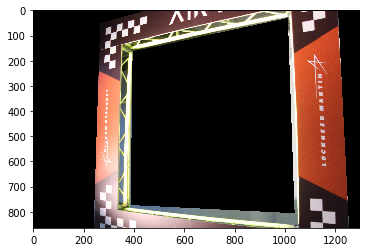

In [14]:
# testing annotation all together 

def get_mask(img_shape, poly,display=False):
     

    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    polygons = []
    for pt in poly:
        a = (int(pt[0]), int(pt[1]))
        polygons.append(a)
    
    draw.polygon(xy=polygons, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    if display:
        plt.imshow(mask)
        plt.show
    return mask
#getting the final mask

for i in tqdm(range(0,len(df_enet))): # use one image only for testing
    print(i)
    img=cv2.imread(df_enet['img_path'][i])
    row=img.shape[0]
    col=img.shape[1]
    img_shape = (row,col)
    outer_poly=df_enet['outer_poly'][i] 
     
    inner_poly=df_enet['inner_poly'][i]
    print('outer_poly',outer_poly)
    if len(outer_poly) < 2:
        print('gt annotation error has been detected in img ID:', i)
        print('skipping img')
        
    else: 
        outer_mask=get_mask(img_shape,outer_poly,display=False)
        inner_mask=get_mask(img_shape,inner_poly,display=False)
        inner_mask.dtype='uint8'
        outer_mask.dtype='uint8'
        final_mask=cv2.subtract(outer_mask,inner_mask)
        plt.imshow(cv2.bitwise_and(img,img,mask=final_mask))
        plt.show

In [15]:
print(len(df_enet))

4943


Create the ENet model
We decided to to split the model to three sub classes:

1) Initial block

2) RDDNeck - class for regular, downsampling and dilated bottlenecks

3) ASNeck - class for asymetric bottlenecks

4) UBNeck - class for upsampling bottlenecks

In [16]:
class InitialBlock(nn.Module):
  
  # Initial block of the model:
  #         Input
  #        /     \
  #       /       \
  #maxpool2d    conv2d-3x3
  #       \       /  
  #        \     /
  #      concatenate
   
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        # concatenating on the channels axis
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

In [17]:
class UBNeck(nn.Module):
    
  # Upsampling bottleneck:
  #     Bottleneck Input
  #        /        \
  #       /          \
  # conv2d-1x1     convTrans2d-1x1
  #      |             | PReLU
  #      |         convTrans2d-3x3
  #      |             | PReLU
  #      |         convTrans2d-1x1
  #      |             |
  # maxunpool2d    Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  #  Params: 
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        # This layer used for Upsampling
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm2(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # summing the main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [18]:
class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
      
  # Regular|Dilated|Downsampling bottlenecks:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  # maxpooling2d   conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-3x3
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params: 
  #  dilation (bool) - if True: creating dilation bottleneck
  #  down_flag (bool) - if True: creating downsampling bottleneck
  #  projection_ratio - ratio between input and output channels
  #  relu - if True: relu used as the activation function else: Prelu us used
  #  p - dropout ratio
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag
        
        # calculating the number of reduced channels
        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm2(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

In [19]:
class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
      
  # Asymetric bottleneck:
  #
  #     Bottleneck Input
  #        /        \
  #       /          \
  #      |         conv2d-1x1
  #      |             | PReLU
  #      |         conv2d-1x5
  #      |             |
  #      |         conv2d-5x1
  #      |             | PReLU
  #      |         conv2d-1x1
  #      |             |
  #  Padding2d     Regularizer
  #       \           /  
  #        \         /
  #      Summing + PReLU
  #
  # Params:    
  #  projection_ratio - ratio between input and output channels
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm2(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            
            #padding and concatenating in order to match the channels axis of the side and main branches
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Summing main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

In [20]:
class ENet(nn.Module):
  
  # Creating Enet model!
  
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        # C - number of classes
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

In [35]:
#Instantiate the ENet model
load_pretrained = True
enet = ENet(2)
if load_pretrained:
    state_dict = torch.load('content/ckpt-enet-460.pth')['state_dict']
    enet.load_state_dict(state_dict)
    print('loaded a pretrained model')

loaded a pretrained model


In [36]:
# Checking if there is any gpu available and pass the model to gpu or cpu
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
enet = enet.to(device)

In [37]:
img = plt.imread(df_enet['img_path'][8])
print(img.shape)

(864, 1296, 3)


In [40]:
#build a generater
from ImgAugumentation import ImgAugumentation
img_augumentation = ImgAugumentation()
def loader(df, batch_size, im_size=(512,512), aug=False):
    total_files_s=len(df)
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
   
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
          # Reading normalized photo
        
 
            img = plt.imread(df['img_path'][jj])
            orginal_im_size=img.shape
          # Resizing using nearest neighbor method
            img = cv2.resize(img, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
            
          # creating semantic mask 
            outer_poly=df['outer_poly'][jj] 
            #print('outer poly',outer_poly)
            inner_poly=df['inner_poly'][jj]
            #print('inner_poly', list(inner_poly))
            if len(outer_poly) > 1:
                outer_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),outer_poly,display=False)
                inner_mask=get_mask((orginal_im_size[0], orginal_im_size[1]),inner_poly,display=False)
                inner_mask.dtype='uint8'
                outer_mask.dtype='uint8'
                final_mask=cv2.subtract(outer_mask,inner_mask)
              # Resizing using nearest neighbor method
                final_mask = cv2.resize(final_mask, (im_size[0], im_size[1]), cv2.INTER_NEAREST)
                if aug:
                    rand_value_augument = np.random.randint(7)
                    if (rand_value_augument == 0):   
                        img, final_mask=img_augumentation.flip_image_horz(img, final_mask)
                    if (rand_value_augument == 1): 
                        img, final_mask=img_augumentation.flip_image_ver(img, final_mask)
                    if (rand_value_augument == 2) or (rand_value_augument == 3): 
                        img=img_augumentation.brightness_images(img)
                    if (rand_value_augument == 4): 
                        img, final_mask =img_augumentation.trans_image(img,final_mask,50)
                    if (rand_value_augument == 5): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,-100)
                    if (rand_value_augument == 6): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,-50)
                    if (rand_value_augument == 7): 
                        img, final_mask =img_augumentation.stretch_image(img, final_mask,+30)
                inputs.append(img)
                labels.append(final_mask)

        inputs = np.stack(inputs, axis=2)
      # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

torch.Size([512, 512])


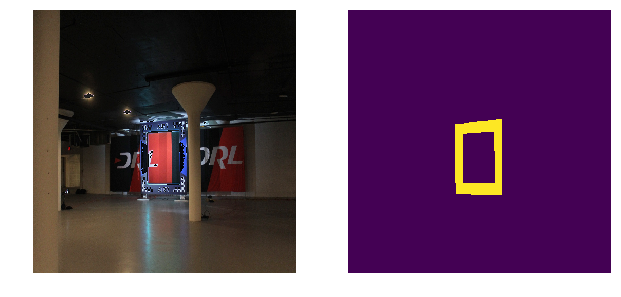

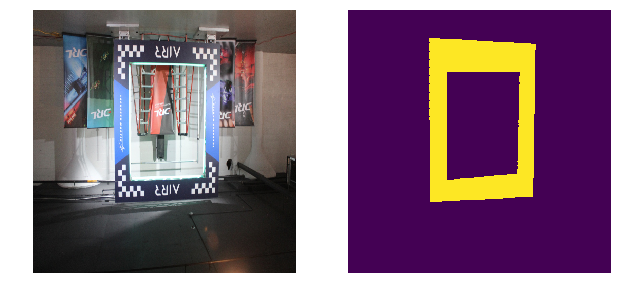

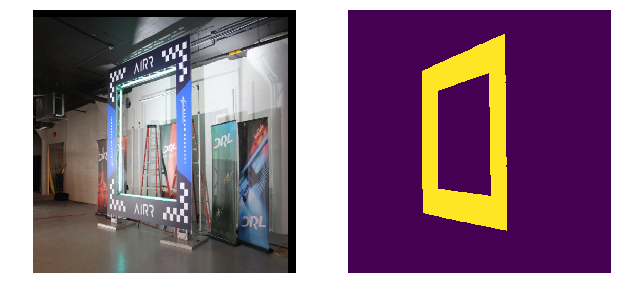

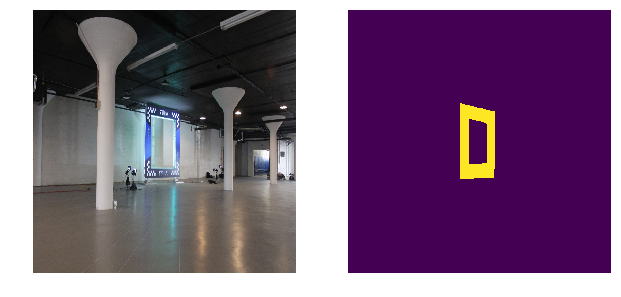

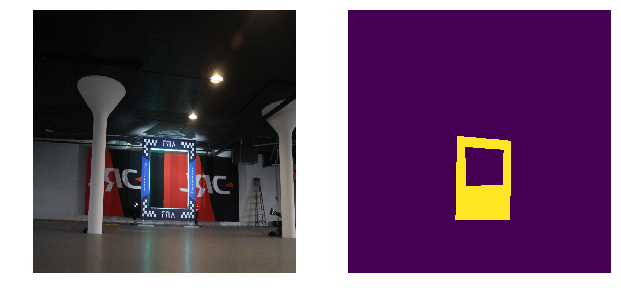

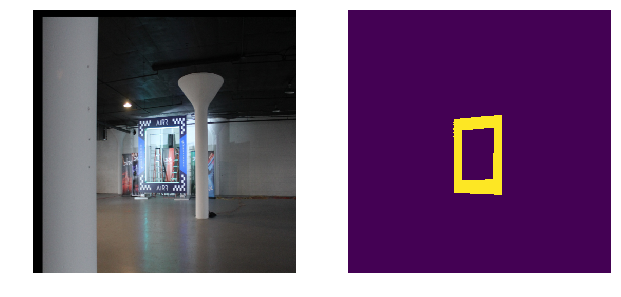

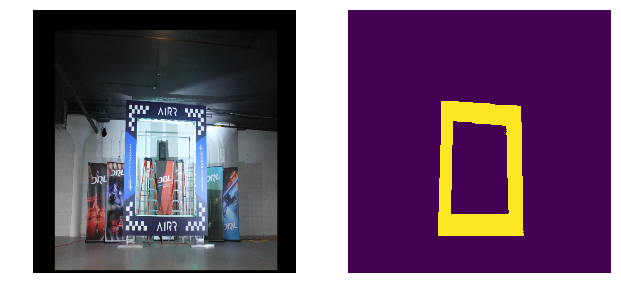

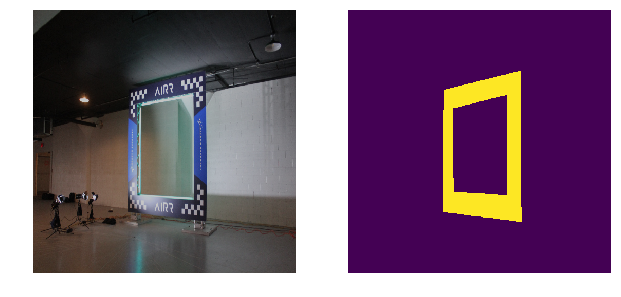

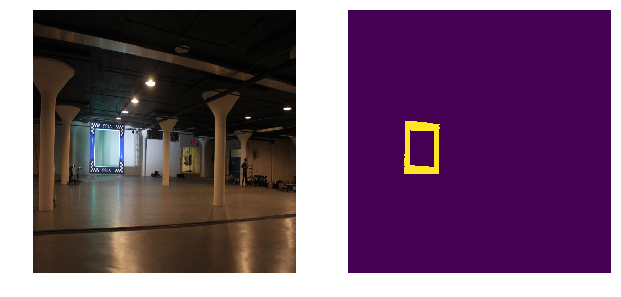

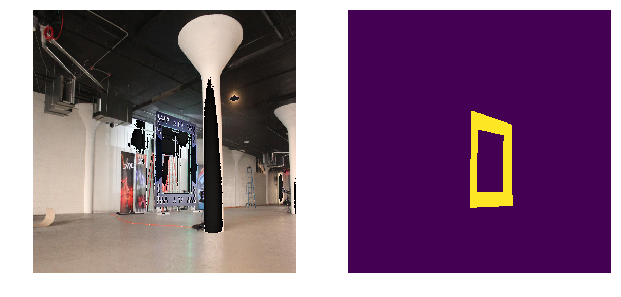

In [39]:
#test the generater
batch_size=10
training_gen=loader(df_enet, batch_size=batch_size, aug=True)
batch_img,batch_mask = next(training_gen)
print(batch_mask[0].shape)

for i in range(0,len(batch_img)):
 
    plt.figure(figsize=(16,16))
    plt.subplot(1,3,1)
    plt.imshow(batch_img[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(batch_mask[i])
    plt.axis('off')

    plt.show();

In [30]:
def get_class_weights(num_classes, c=1.02):
    pipe = loader(df_enet, batch_size='all',aug=True)
    _, labels = next(pipe)
    all_labels = labels.flatten()
    each_class = np.bincount(all_labels, minlength=num_classes)
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    return class_weights

In [31]:
class_weights = get_class_weights(1)


In [32]:
print(class_weights)

[  1.49089612  12.35272287]


In [41]:
lr = 5e-4
batch_size = 20

criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = torch.optim.Adam(enet.parameters(), 
                             lr=lr,
                             weight_decay=2e-4)

print_every = 20
eval_every = 40

In [42]:
print(len(df_enet))

4943


In [43]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
df_trn, df_tst = train_test_split(df_enet, test_size=0.03)
print(len(df_trn))
print(len(df_tst))


4794
149


In [44]:
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

,img_path,outer_x_min,outer_y_min,outer_x_max,outer_y_max,outer_poly,class_id_x,inner_x_min,inner_y_min,inner_x_max,inner_y_max,inner_poly,class_id_y
0,/media/a/D/lockheed-martin/dataset/LM_dataset/...,379,151,920,690,"[(379, 154), (919, 151), (919, 685), (383, 689)]",0,461,228,835,609,"[(461, 228), (834, 228), (834, 601), (468, 608)]",1
1,/media/a/D/lockheed-martin/dataset/LM_dataset/...,490,120,789,706,"[(490, 230), (775, 120), (788, 705), (499, 644)]",0,535,212,728,600,"[(535, 273), (720, 212), (727, 599), (552, 566)]",1
2,/media/a/D/lockheed-martin/dataset/LM_dataset/...,508,270,750,723,"[(508, 270), (742, 353), (749, 695), (509, 722)]",0,551,349,709,649,"[(554, 349), (708, 390), (703, 639), (551, 648)]",1
3,/media/a/D/lockheed-martin/dataset/LM_dataset/...,439,227,732,693,"[(444, 227), (731, 289), (729, 645), (439, 692)]",0,487,297,693,617,"[(490, 297), (680, 328), (692, 590), (487, 616)]",1
4,/media/a/D/lockheed-martin/dataset/LM_dataset/...,567,279,688,630,"[(567, 352), (680, 279), (687, 629), (572, 619)]",0,599,355,659,572,"[(599, 380), (654, 355), (658, 571), (599, 571)]",1


#create overfitting dataset
df_trn, df_tst = train_test_split(df_tst, test_size=0.1)
print(len(df_trn))
print(len(df_tst))
df_trn.reset_index(drop=True, inplace=True)
df_tst.reset_index(drop=True, inplace=True)
df_trn.head()

In [ ]:
train_losses = []
eval_losses = []

bc_train = 100# 1 // batch_size # mini_batch train
bc_eval = 77# // batch_size  # mini_batch validation

# Define pipeline objects
pipe = loader(df_trn, batch_size,aug=True)
eval_pipe = loader(df_tst, batch_size)

epochs = 1000

# Train loop

for e in range(1, epochs+1):
    
    
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    
    enet.train()
    
    for _ in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)
        
        # assign data to cpu/gpu
        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = enet(X_batch.float())
        #print(out.shape)
        # loss calculation
        loss = criterion(out, mask_batch.long())
        # update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        
    print ()
    train_losses.append(train_loss)
    
    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Loss {:6f}'.format(train_loss))
    
    if e % eval_every == 0:
        with torch.no_grad():
            enet.eval()
            
            eval_loss = 0

            # Validation loop
            for _ in tqdm(range(bc_eval)):
                inputs, labels = next(eval_pipe)

                inputs=inputs.float()
                inputs, labels = inputs.to(device), labels.to(device)
                    
                
                out = enet(inputs)
                
                out = out.data.max(1)[1]
                
                eval_loss += (labels.long() - out.long()).sum()
                
            
            print ()
            print ('Loss {:6f}'.format(eval_loss))
            
            eval_losses.append(eval_loss)
        
    if e % print_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : enet.state_dict()
        }
        torch.save(checkpoint, 'content/ckpt-enet-{}-{}.pth'.format(e, train_loss))
        print ('Model saved!')

print ('Epoch {}/{}...'.format(e, epochs),
       'Total Mean Loss: {:6f}'.format(sum(train_losses) / epochs))

  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/100 [00:00<?, ?it/s]


--------------- Epoch 2 ---------------


 26%|██▌       | 26/100 [00:39<02:24,  1.95s/it]

# Postprocessing pipeline

In [ ]:
sample_img=70 
tmg_ = plt.imread(df_tst['img_path'][sample_img])
img_size=tmg_.shape
print(img_size)
#tmg_ = cv2.resize(tmg_, (img_size[0], img_size[1]), cv2.INTER_NEAREST)
tmg = torch.tensor(tmg_).unsqueeze(0).float()
tmg = tmg.transpose(2, 3).transpose(1, 2).to(device)

enet.to(device)
with torch.no_grad():
    out1 = enet(tmg.float()).squeeze(0)

In [ ]:
 
outer_poly=df_tst['outer_poly'][sample_img] 
#print('outer poly',outer_poly)
inner_poly=df_tst['inner_poly'][sample_img]
#print('inner_poly', list(inner_poly))
outer_mask=get_mask((img_size[0], img_size[1]),outer_poly,display=False)
inner_mask=get_mask((img_size[0], img_size[1]),inner_poly,display=False)
inner_mask.dtype='uint8'
outer_mask.dtype='uint8'
final_mask=cv2.subtract(outer_mask,inner_mask)
plt.imshow(final_mask)
plt.show

# Load a pretrained model if needed
enet = ENet(2)
state_dict = torch.load('content/ckpt-enet-108-3.242320427671075.pth')['state_dict']
enet.load_state_dict(state_dict)

In [ ]:
out2 = out1.cpu().detach().numpy()

In [ ]:
mno = 1 # Should be between 0 - n-1 | where n is the number of classes

figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Output Image')
plt.axis('off')
plt.imshow(out2[mno, :, :])
plt.show()

In [ ]:
b_ = out1.data.max(0)[1].cpu().numpy()

In [ ]:
def decode_segmap(image):
    gate = [128, 128, 128]
     

    label_colours = np.array([gate]).astype(np.uint8)
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 1):
        r[image == l] = label_colours[l, 0]
        g[image == l] = label_colours[l, 1]
        b[image == l] = label_colours[l, 2]

    rgb = np.zeros((image.shape[0], image.shape[1], 3)).astype(np.uint8)
    rgb[:, :, 0] = b
    rgb[:, :, 1] = g
    rgb[:, :, 2] = r
    return rgb


In [ ]:
true_seg = decode_segmap(final_mask)
pred_seg = decode_segmap(b_)

In [ ]:
figure = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.axis('off')
plt.imshow(tmg_)
plt.subplot(1, 3, 2)
plt.title('Predicted Segmentation')
plt.axis('off')
plt.imshow(pred_seg)
plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.axis('off')
plt.imshow(true_seg)
plt.show()

# Training pipeline

# Post-processing pipeline      

In [ ]:
start = time.time()
training_gen = generate_train_batch(cars_15_35GB,1)
batch_img,batch_mask = next(training_gen)
end = time.time()
end-start

In [ ]:
start = time.time()
sample_imgs=1 
testing_gen = generate_test_batch(cars_15_35GB,sample_imgs)
pre_final_predictions= model.predict(batch_img)
end = time.time()
end-start

In [ ]:
### Test on last frames of data
start = time.time()
batch_img,batch_mask = next(testing_gen)
pre_final_predictions= model.predict(batch_img)
np.shape(pre_final_predictions)
for i in range(sample_imgs):
    im=batch_img[i]
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    img_true = cv2.addWeighted(rgb_mask_true,0.70,im,0.70,0)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmented')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(draw_img)
    plt.title('Predicted')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(img_true)
    plt.title('Gtruth')
    plt.axis('off')

end = time.time()
end-start   

In [ ]:
test_img = 'scene01021.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = next_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]

img_pred = cv2.addWeighted(rgb_mask_pred,0.70,im,1,0)

draw_img = get_BB_new_img(im)

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentated')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');



## Performing camera calibration
Camera calibration is performed in order to correct the deformation in the images that is caused to the optic lens curvature. The first step is to print a chessboard and take random pictures of it. Then count the chess intersecting squires to provide "objp" which holds the (x,y,z) coordinates of these corners. Z=0 here and the object points are the same for all images in the calibration folder. The objpoints will be appended in "objp" every time the method successfully detect all chessboard corners in a test image. "imgpoints" will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.
"objpoints" and "imgpoints" were used to compute the camera calibration and distortion coefficients using the "cv2.calibrateCamera()" function on a test image in "cv2.undistort()"

In [ ]:
# prepare object points. The number of corners are 6x9
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images, all located in camera_cal
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    # imread reads images in BGR format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
#cv2.destroyAllWindows()

## Perform distortion removal on test images¶
1. Has the distortion correction been correctly applied to each image?
Undistortion is performed on the provided test images before they are used in the pipeline. This also applies to the video frames. "dst" holds undistorted frames from "cv2.undistort" that were computed using "mtx".

In [ ]:
for image_name in glob.glob("Frames/*"):
    im = cv2.imread(image_name)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = undistort(im,read=False, display = False, write = False)
    pred,im = next_img(im)
    im  = np.array(im,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    img_pred = cv2.addWeighted(rgb_mask_pred,0.50,im,1,0)
    draw_img = get_BB_new_img(im)
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Segmentated')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');

heatmap_10 = [np.zeros((640,960))]*10
    

In [ ]:
def video_pipeline(image):
    #test_img = 'scene01021.jpg'
    #im = cv2.imread(im)
    #im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    #img = get_BB_new_img(im)
    # Apply bounding box to image
    image_bb = np.copy(image)
    bbox_cars = get_BB_new(image_bb)
    img_size = np.shape(image)
    result = image
    img_res_shape = result.shape
    for bbox in bbox_cars:
        cv2.rectangle(result,(np.int32(bbox[0][0]*img_res_shape[1]/960),np.int32(bbox[0][1]*img_res_shape[0]/640)), (np.int32(bbox[1][0]*img_res_shape[1]/960),np.int32(bbox[1][1]*img_res_shape[0]/640)),(0,255,0),6)
    #heatmap = get_Unet_mask(image_bb)
    #plt.imshow(img)
    return result

In [ ]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) 
white_clip.write_videofile(video_output, audio=False)

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))